In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import librosa
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from MyDataSet import MyDataSet 
from IPython.display import Audio

Traindatapath = os.path.join(".\soundWake", "dataLable\\train.json")
Validdatapath = os.path.join(".\soundWake", "dataLable\\valid.json")
Testdatapath = os.path.join(".\soundWake", "dataLable\\test.json")


MFCCtrain_set = MyDataSet(data_json=Traindatapath,resample_rate=8000,rawMode=False)
MFCCvalid_set = MyDataSet(data_json=Validdatapath,resample_rate=8000,rawMode=False)
MFCCtest_set = MyDataSet(data_json=Testdatapath,resample_rate=8000,rawMode=False)
RAWtrain_set = MyDataSet(data_json=Traindatapath,resample_rate=8000,rawMode=True)
RAWvalid_set = MyDataSet(data_json=Validdatapath,resample_rate=8000,rawMode=True)
RAWtest_set = MyDataSet(data_json=Testdatapath,resample_rate=8000,rawMode=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
label_Encoder=LabelEncoder()
encode_labels=label_Encoder.fit_transform(RAWtrain_set.data.voice)
print(label_Encoder.classes_)

['common voice' 'open arduino' 'open dead by day light' 'open garena'
 'open google' 'open goose goose duck' 'open microsoft teams'
 'open microsoft word' 'open this pc' 'open valorant' 'open vscode']


<AxesSubplot: >

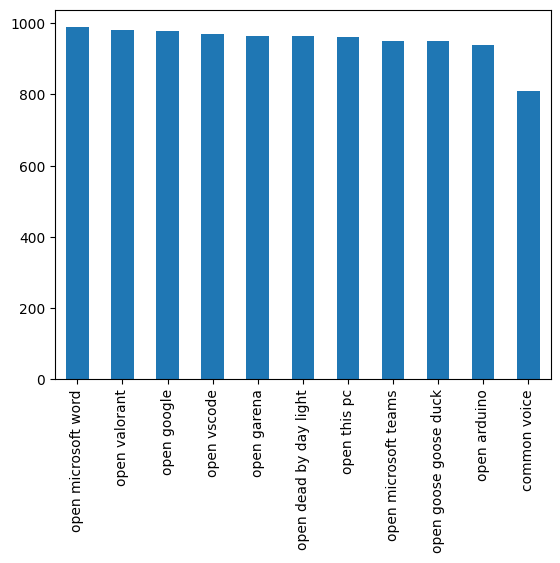

In [5]:
Traindf = pd.read_json(Traindatapath, lines=False)
Traindf=pd.json_normalize(Traindf.data)
Traindf.voice.value_counts().plot(kind="bar")

<AxesSubplot: >

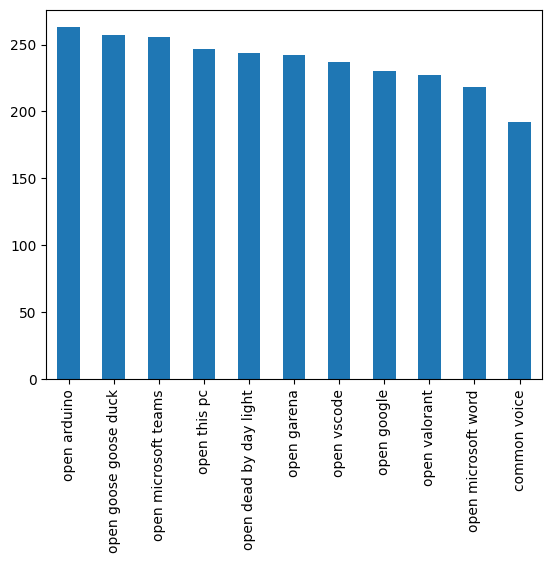

In [6]:
Validdf = pd.read_json(Validdatapath, lines=False)
Validdf=pd.json_normalize(Validdf.data)
Validdf.voice.value_counts().plot(kind="bar")

<AxesSubplot: >

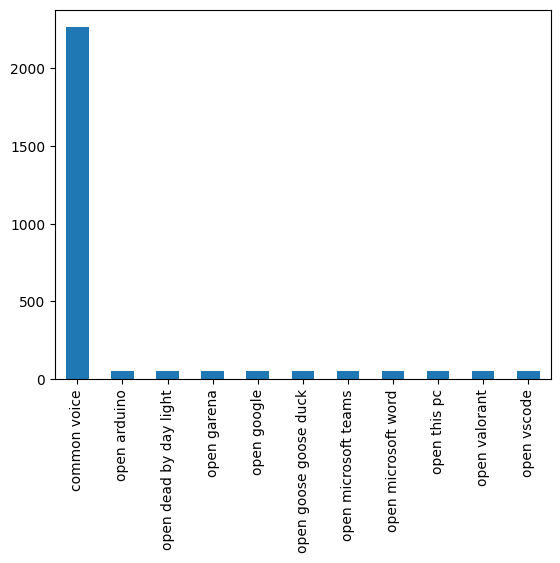

In [7]:
Testdf = pd.read_json(Testdatapath, lines=False)
Testdf=pd.json_normalize(Testdf.data)
Testdf.voice.value_counts().plot(kind="bar")

tensor([[-0.0006,  0.0132,  0.0180,  ...,  0.0029,  0.0284,  0.0010]])
torch.Size([1, 15360])
tensor(7, dtype=torch.int32)
Shape of waveform: torch.Size([1, 15360])


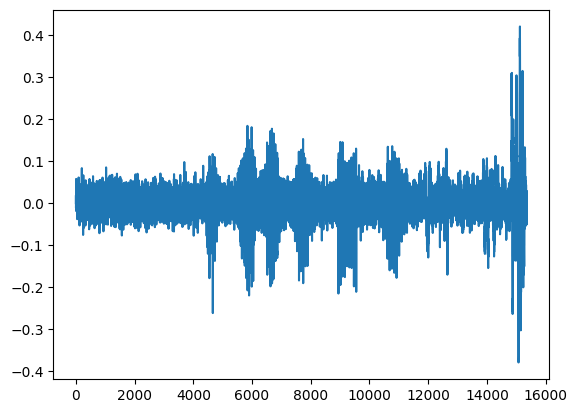

In [8]:
waveform,label = RAWtrain_set[-1]
print(waveform)
print(waveform.shape)
print(label)
print("Shape of waveform: {}".format(waveform.size()))
plt.plot(waveform.t().numpy());

tensor([[ 0.0000e+00, -9.1553e-05, -6.1035e-05,  ...,  0.0000e+00,
          9.1553e-05,  2.1362e-04]])
torch.Size([1, 15360])
tensor(0, dtype=torch.int32)
Shape of waveform: torch.Size([1, 15360])


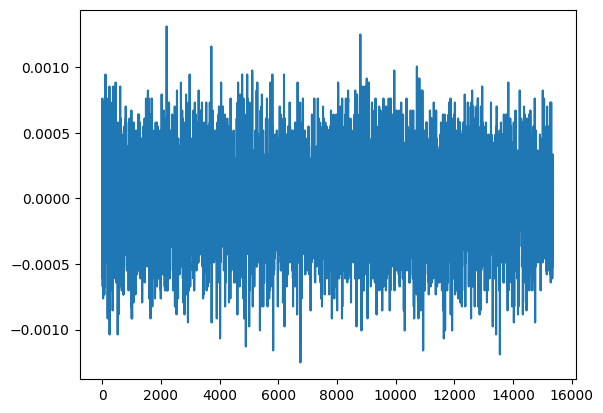

In [9]:
waveform,label = RAWtest_set[0]
print(waveform)
print(waveform.shape)
print(label)
print("Shape of waveform: {}".format(waveform.size()))
plt.plot(waveform.t().numpy())

torch.Size([1, 128, 128])
open microsoft word
Shape of spectrogram: torch.Size([1, 128, 128])


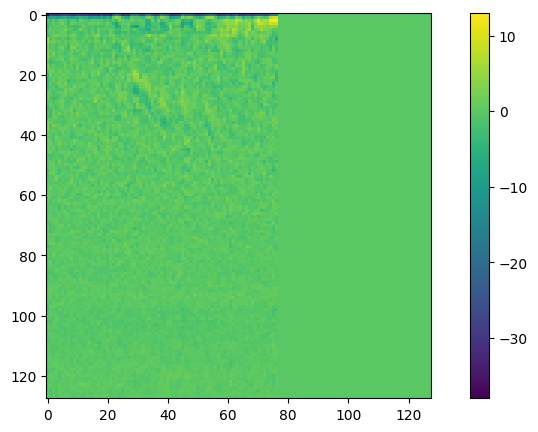

In [10]:
print(MFCCtrain_set[-1][0].size())
print(label_Encoder.classes_[MFCCtrain_set[-1][1]])
spectogram=MFCCtrain_set[-1][0]
print("Shape of spectrogram: {}".format(spectogram.size()))

plt.figure(figsize=(10,5))
plt.imshow(spectogram[0,:,:].numpy())
plt.colorbar()
plt.show()


In [28]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)
    

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label

    tensors, targets = [], []
    # Gather in lists, and encode labels as indices
    for waveform,label in batch:
        tensors += [waveform]
        targets += [label]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets


In [30]:
class RawModel1(nn.Module):
    def __init__(self, n_input=1, n_output=11, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.dropout1 = nn.Dropout(0.3) 
        self.dropout2 = nn.Dropout(0.3) 
        self.dropout3 = nn.Dropout(0.3) 
        self.dropout4 = nn.Dropout(0.3) 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        #x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        #x = self.dropout2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        #x = self.dropout3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        #self.dropout4 = nn.Dropout(0.3) 

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        return x



In [31]:
class RawModel2(nn.Module):
    def __init__(self, n_input=1, n_output=11, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.AvgPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=4)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.AvgPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=4)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.AvgPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=4)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.AvgPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.dropout1 = nn.Dropout(0.3) 
        self.dropout2 = nn.Dropout(0.3) 
        self.dropout3 = nn.Dropout(0.3) 
        self.dropout3 = nn.Dropout(0.3) 
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        self.dropout4 = nn.Dropout(0.3) 

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        return x



In [75]:
class RawModel3(nn.Module):
    def __init__(self, n_input=1, n_output=11, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.AvgPool1d(4)
        self.fc1 = nn.Linear( n_channel, n_output)
        self.dropout1 = nn.Dropout(0.3) 
        self.dropout2 = nn.Dropout(0.3)  
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)
        return x



In [86]:
class MFCCModel1(nn.Module):
    def __init__(self, num_class):
        super(MFCCModel1,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=16,stride=1)
        self.dropout1 = nn.Dropout(0.1) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=2,stride=1)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=2,stride=1)
        self.dropout3 = nn.Dropout(0.1)

        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=1,stride=1)
        self.dropout4 = nn.Dropout(0.1)

        # self.flat=nn.Flatten(),
        # self.dropout3 = nn.Dropout(0.1)
        
        self.fc1 = nn.Linear(256,512)
        self.dropout5 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(512,1024)
        self.dropout6 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(1024,512)
        self.dropout7 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(512,128)
        self.dropout8 = nn.Dropout(0.1)
        
        self.fc5 = nn.Linear(128, num_class)
    
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)

        x = F.avg_pool2d(F.relu(self.conv3(x)),kernel_size=5)
        x = self.dropout3(x)
        

        x = F.relu(self.conv4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2] *x.shape[3]  )))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)

        x = F.relu(self.fc4(x))
        x = self.dropout8(x)
        
        x = self.fc5(x)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        return x 

In [102]:
class MFCCModel2(nn.Module):
    def __init__(self, num_class):
        super(MFCCModel2,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=16,stride=1)
        self.dropout1 = nn.Dropout(0.1) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=2,stride=1)
        self.dropout2 = nn.Dropout(0.1)


        self.flat=nn.Flatten()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256,128)
        self.dropout5 = nn.Dropout(0.5)

       
        
        self.fc2 = nn.Linear(128, num_class)
    
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)

        

        x = self.flat(x)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2] *x.shape[3]  )))
        x = self.dropout5(x)
        
        
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x 

In [103]:
class MFCCModel3(nn.Module):
    def __init__(self, num_class):
        super(MFCCModel3,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=16,stride=1)
        self.dropout1 = nn.Dropout(0.1) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=2,stride=1)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=2,stride=1)
        self.dropout3 = nn.Dropout(0.1)

        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=1,stride=1)
        self.dropout4 = nn.Dropout(0.3)

        self.flat=nn.Flatten(),
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256,512)
        self.dropout5 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512,256)
        self.dropout6 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256,128)
        self.dropout7 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, num_class)
    
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)

        x = F.avg_pool2d(F.relu(self.conv3(x)),kernel_size=5)
        x = self.dropout3(x)
        

        x = F.relu(self.conv4(x))
        x = self.dropout4(x)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2] *x.shape[3]  )))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout7(x)

        
        x = self.fc4(x)
        x = F.log_softmax(x,dim=1)
        #print(x.shape)
        return x 

In [104]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
RAWmodel1 = RawModel1(n_input=waveform.shape[0], n_output=11)
RAWmodel2 = RawModel2(n_input=waveform.shape[0], n_output=11)
RAWmodel3 = RawModel3(n_input=waveform.shape[0], n_output=11)
MFCCmodel1 = MFCCModel1(num_class=11)
MFCCmodel2 = MFCCModel2(num_class=11)
MFCCmodel3 = MFCCModel3(num_class=11)
RAWmodel1.to(device)
RAWmodel2.to(device)
RAWmodel3.to(device)
MFCCmodel1.to(device)
MFCCmodel2.to(device)
MFCCmodel3.to(device)

print("Number of parameters: ",count_parameters(RAWmodel1))
print("Number of parameters: ",count_parameters(RAWmodel2))
print("Number of parameters: ",count_parameters(RAWmodel3))
print("Number of parameters: ",count_parameters(MFCCmodel1))
print("Number of parameters: ",count_parameters(MFCCmodel2))
print("Number of parameters: ",count_parameters(MFCCmodel3))

Number of parameters:  25355
Number of parameters:  32523
Number of parameters:  6187
Number of parameters:  1255555
Number of parameters:  36899
Number of parameters:  304003


In [105]:
def RAWtrain(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(RAWtrain_loader):

        data = data.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)
        output = model(data)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(RAWtrain_loader.dataset)} ({100. * batch_idx / len(RAWtrain_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def RAWtest(model, epoch):
    model.eval()
    correct = 0
    for data, target in RAWvalid_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nValidate Epoch: {epoch}\tAccuracy: {correct}/{len(RAWvalid_loader.dataset)} ({100. * correct / len(RAWvalid_loader.dataset):.0f}%)\n")

In [106]:
def MFCCtrain(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(MFCCtrain_loader):

        data = data.to(device)
        target = target.type(torch.LongTensor)
        target = target.to(device)
        output = model(data)
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(MFCCtrain_loader.dataset)} ({100. * batch_idx / len(MFCCtrain_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def MFCCtest(model, epoch):
    model.eval()
    correct = 0
    for data, target in MFCCvalid_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nValidate Epoch: {epoch}\tAccuracy: {correct}/{len(MFCCvalid_loader.dataset)} ({100. * correct / len(MFCCvalid_loader.dataset):.0f}%)\n")

In [107]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def predict(tensor,model):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = tensor.squeeze()
    return label_Encoder.classes_[tensor]

#HyperParameter

In [108]:



batch_size = 1024
lr=0.01
n_epoch = 150
log_interval = 20




In [109]:
num_workers = 0
pin_memory = False
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [110]:
#RAW LOADER
RAWtrain_loader = torch.utils.data.DataLoader(
    RAWtrain_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
RAWvalid_loader = torch.utils.data.DataLoader(
    RAWvalid_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [111]:
#MFCC LOADER
MFCCtrain_loader = torch.utils.data.DataLoader(
    MFCCtrain_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
MFCCvalid_loader = torch.utils.data.DataLoader(
    MFCCvalid_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

  0%|                                                                                                                               | 0.009708737864077669/150 [00:03<15:19:55, 367.99s/it]

Train Epoch: 1 [0/10452 (0%)]	Loss: 2.477003


  0%|▏                                                                                                                                 | 0.21359223300970867/150 [00:08<1:02:11, 24.91s/it]

Train Epoch: 1 [2560/10452 (24%)]	Loss: 1.928508


  0%|▎                                                                                                                                   | 0.407766990291262/150 [00:13<1:08:34, 27.51s/it]

Train Epoch: 1 [5120/10452 (49%)]	Loss: 1.590671


  0%|▌                                                                                                                                    | 0.5922330097087377/150 [00:18<57:55, 23.26s/it]

Train Epoch: 1 [7680/10452 (73%)]	Loss: 1.238361


  1%|▋                                                                                                                                    | 0.7961165048543687/150 [00:23<58:47, 23.64s/it]

Train Epoch: 1 [10240/10452 (98%)]	Loss: 0.813617


  1%|▊                                                                                                                                   | 0.990291262135922/150 [00:28<1:08:44, 27.68s/it]


Validate Epoch: 1	Accuracy: 1047/2613 (40%)



  1%|▉                                                                                                                                    | 1.0097087378640774/150 [00:28<56:07, 22.60s/it]

Train Epoch: 2 [0/10452 (0%)]	Loss: 0.664802


  1%|█                                                                                                                                  | 1.2038834951456308/150 [00:33<1:07:20, 27.15s/it]

Train Epoch: 2 [2560/10452 (24%)]	Loss: 0.522517


  1%|█▏                                                                                                                                    | 1.398058252427184/150 [00:38<57:51, 23.36s/it]

Train Epoch: 2 [5120/10452 (49%)]	Loss: 0.256238


  1%|█▍                                                                                                                                    | 1.601941747572815/150 [00:42<52:49, 21.36s/it]

Train Epoch: 2 [7680/10452 (73%)]	Loss: 0.197686


  1%|█▌                                                                                                                                   | 1.7961165048543684/150 [00:47<56:07, 22.72s/it]

Train Epoch: 2 [10240/10452 (98%)]	Loss: 0.242737


  1%|█▊                                                                                                                                   | 1.9999999999999993/150 [00:52<57:09, 23.17s/it]


Validate Epoch: 2	Accuracy: 2106/2613 (81%)



  1%|█▊                                                                                                                                  | 2.009708737864077/150 [00:52<1:03:42, 25.83s/it]

Train Epoch: 3 [0/10452 (0%)]	Loss: 0.247917


  1%|█▉                                                                                                                                   | 2.2038834951456305/150 [00:56<56:37, 22.98s/it]

Train Epoch: 3 [2560/10452 (24%)]	Loss: 0.145604


  2%|██                                                                                                                                  | 2.398058252427184/150 [01:01<1:07:54, 27.61s/it]

Train Epoch: 3 [5120/10452 (49%)]	Loss: 0.173807


  2%|██▎                                                                                                                                 | 2.601941747572815/150 [01:06<1:00:35, 24.66s/it]

Train Epoch: 3 [7680/10452 (73%)]	Loss: 0.096418


  2%|██▍                                                                                                                                   | 2.796116504854368/150 [01:11<47:07, 19.21s/it]

Train Epoch: 3 [10240/10452 (98%)]	Loss: 0.043132


  2%|██▌                                                                                                                                | 2.9902912621359214/150 [01:15<1:00:02, 24.50s/it]


Validate Epoch: 3	Accuracy: 2017/2613 (77%)



  2%|██▋                                                                                                                                  | 3.0097087378640768/150 [01:16<59:15, 24.19s/it]

Train Epoch: 4 [0/10452 (0%)]	Loss: 0.060508


  2%|██▊                                                                                                                                  | 3.2135922330097078/150 [01:20<54:23, 22.24s/it]

Train Epoch: 4 [2560/10452 (24%)]	Loss: 0.078202


  2%|██▉                                                                                                                                 | 3.407766990291261/150 [01:25<1:01:37, 25.23s/it]

Train Epoch: 4 [5120/10452 (49%)]	Loss: 0.041483


  2%|███▏                                                                                                                                 | 3.6019417475728144/150 [01:29<48:59, 20.08s/it]

Train Epoch: 4 [7680/10452 (73%)]	Loss: 0.041265


  3%|███▎                                                                                                                                 | 3.7961165048543677/150 [01:33<54:38, 22.42s/it]

Train Epoch: 4 [10240/10452 (98%)]	Loss: 0.006327


  3%|███▌                                                                                                                                | 3.990291262135921/150 [01:38<1:02:02, 25.50s/it]


Validate Epoch: 4	Accuracy: 2307/2613 (88%)



  3%|███▌                                                                                                                                | 4.009708737864076/150 [01:39<1:04:52, 26.66s/it]

Train Epoch: 5 [0/10452 (0%)]	Loss: 0.095697


  3%|███▋                                                                                                                                 | 4.2038834951456385/150 [01:43<50:33, 20.81s/it]

Train Epoch: 5 [2560/10452 (24%)]	Loss: 0.014845


  3%|███▉                                                                                                                                  | 4.398058252427201/150 [01:47<53:30, 22.05s/it]

Train Epoch: 5 [5120/10452 (49%)]	Loss: 0.039191


  3%|████                                                                                                                                  | 4.592233009708763/150 [01:51<53:14, 21.97s/it]

Train Epoch: 5 [7680/10452 (73%)]	Loss: 0.029261


  3%|████▎                                                                                                                                 | 4.796116504854403/150 [01:56<55:41, 23.01s/it]

Train Epoch: 5 [10240/10452 (98%)]	Loss: 0.008060


  3%|████▍                                                                                                                               | 4.990291262135965/150 [02:01<1:01:20, 25.38s/it]


Validate Epoch: 5	Accuracy: 2546/2613 (97%)

Train Epoch: 6 [0/10452 (0%)]	Loss: 0.025999


  3%|████▋                                                                                                                                 | 5.203883495145684/150 [02:06<59:49, 24.79s/it]

Train Epoch: 6 [2560/10452 (24%)]	Loss: 0.021283


  4%|████▊                                                                                                                                 | 5.407766990291324/150 [02:10<53:56, 22.38s/it]

Train Epoch: 6 [5120/10452 (49%)]	Loss: 0.016176


  4%|████▉                                                                                                                               | 5.592233009708808/150 [02:15<1:14:05, 30.78s/it]

Train Epoch: 6 [7680/10452 (73%)]	Loss: 0.092068


  4%|█████▏                                                                                                                               | 5.7961165048544485/150 [02:20<58:55, 24.51s/it]

Train Epoch: 6 [10240/10452 (98%)]	Loss: 0.006203


  4%|█████▎                                                                                                                                | 5.990291262136011/150 [02:25<59:13, 24.67s/it]


Validate Epoch: 6	Accuracy: 2545/2613 (97%)

Train Epoch: 7 [0/10452 (0%)]	Loss: 0.008246


  4%|█████▍                                                                                                                              | 6.203883495145729/150 [02:30<1:10:25, 29.39s/it]

Train Epoch: 7 [2560/10452 (24%)]	Loss: 0.009772


  4%|█████▋                                                                                                                                | 6.407766990291369/150 [02:35<58:44, 24.55s/it]

Train Epoch: 7 [5120/10452 (49%)]	Loss: 0.323683


  4%|█████▊                                                                                                                               | 6.5922330097088535/150 [02:40<53:19, 22.31s/it]

Train Epoch: 7 [7680/10452 (73%)]	Loss: 0.196920


  5%|██████                                                                                                                                | 6.796116504854494/150 [02:44<54:35, 22.87s/it]

Train Epoch: 7 [10240/10452 (98%)]	Loss: 0.119318


  5%|██████▏                                                                                                                               | 6.990291262136056/150 [02:49<56:19, 23.63s/it]


Validate Epoch: 7	Accuracy: 2134/2613 (82%)

Train Epoch: 8 [0/10452 (0%)]	Loss: 0.075703


  5%|██████▍                                                                                                                               | 7.203883495145774/150 [02:54<56:01, 23.54s/it]

Train Epoch: 8 [2560/10452 (24%)]	Loss: 0.038143


  5%|██████▌                                                                                                                             | 7.407766990291415/150 [02:59<1:06:43, 28.08s/it]

Train Epoch: 8 [5120/10452 (49%)]	Loss: 0.059852


  5%|██████▊                                                                                                                               | 7.592233009708899/150 [03:03<59:43, 25.16s/it]

Train Epoch: 8 [7680/10452 (73%)]	Loss: 0.006892


  5%|██████▉                                                                                                                               | 7.796116504854539/150 [03:08<52:11, 22.02s/it]

Train Epoch: 8 [10240/10452 (98%)]	Loss: 0.006960


  5%|███████                                                                                                                             | 7.990291262136101/150 [03:13<1:00:27, 25.54s/it]


Validate Epoch: 8	Accuracy: 2554/2613 (98%)



  5%|███████▏                                                                                                                              | 8.009708737864257/150 [03:13<52:10, 22.05s/it]

Train Epoch: 9 [0/10452 (0%)]	Loss: 0.008526


  5%|███████▎                                                                                                                              | 8.203883495145801/150 [03:18<58:09, 24.61s/it]

Train Epoch: 9 [2560/10452 (24%)]	Loss: 0.008721


  6%|███████▍                                                                                                                            | 8.398058252427345/150 [03:23<1:09:35, 29.49s/it]

Train Epoch: 9 [5120/10452 (49%)]	Loss: 0.010518


  6%|███████▋                                                                                                                               | 8.59223300970889/150 [03:28<54:35, 23.16s/it]

Train Epoch: 9 [7680/10452 (73%)]	Loss: 0.001146


  6%|███████▊                                                                                                                              | 8.796116504854512/150 [03:33<58:16, 24.76s/it]

Train Epoch: 9 [10240/10452 (98%)]	Loss: 0.023251


  6%|████████                                                                                                                              | 8.990291262136056/150 [03:38<54:06, 23.02s/it]


Validate Epoch: 9	Accuracy: 2606/2613 (100%)



  6%|████████                                                                                                                              | 9.019417475728288/150 [03:38<48:53, 20.80s/it]

Train Epoch: 10 [0/10452 (0%)]	Loss: 0.009085


  6%|████████▏                                                                                                                             | 9.213592233009832/150 [03:43<57:17, 24.41s/it]

Train Epoch: 10 [2560/10452 (24%)]	Loss: 0.007885


  6%|████████▍                                                                                                                             | 9.407766990291377/150 [03:48<56:34, 24.14s/it]

Train Epoch: 10 [5120/10452 (49%)]	Loss: 0.004001


  6%|████████▌                                                                                                                             | 9.592233009708844/150 [03:52<50:14, 21.47s/it]

Train Epoch: 10 [7680/10452 (73%)]	Loss: 0.009851


  7%|████████▊                                                                                                                             | 9.796116504854465/150 [03:57<57:04, 24.42s/it]

Train Epoch: 10 [10240/10452 (98%)]	Loss: 0.013034


  7%|████████▉                                                                                                                            | 10.009708737864164/150 [04:02<48:50, 20.94s/it]


Validate Epoch: 10	Accuracy: 2571/2613 (98%)

Train Epoch: 11 [0/10452 (0%)]	Loss: 0.003172


  7%|█████████                                                                                                                            | 10.213592233009786/150 [04:07<48:25, 20.79s/it]

Train Epoch: 11 [2560/10452 (24%)]	Loss: 0.002480


  7%|█████████                                                                                                                          | 10.398058252427253/150 [04:11<1:01:56, 26.62s/it]

Train Epoch: 11 [5120/10452 (49%)]	Loss: 0.007313


  7%|█████████▍                                                                                                                           | 10.592233009708798/150 [04:16<47:03, 20.25s/it]

Train Epoch: 11 [7680/10452 (73%)]	Loss: 0.002201


  7%|█████████▋                                                                                                                            | 10.79611650485442/150 [04:20<54:28, 23.48s/it]

Train Epoch: 11 [10240/10452 (98%)]	Loss: 0.001127


  7%|█████████▌                                                                                                                         | 10.990291262135964/150 [04:25<1:02:33, 27.00s/it]


Validate Epoch: 11	Accuracy: 2605/2613 (100%)



  7%|█████████▊                                                                                                                           | 11.009708737864118/150 [04:25<53:39, 23.16s/it]

Train Epoch: 12 [0/10452 (0%)]	Loss: 0.003729


  7%|█████████▉                                                                                                                           | 11.203883495145663/150 [04:30<53:46, 23.25s/it]

Train Epoch: 12 [2560/10452 (24%)]	Loss: 0.000914


  8%|██████████                                                                                                                           | 11.407766990291284/150 [04:34<55:35, 24.06s/it]

Train Epoch: 12 [5120/10452 (49%)]	Loss: 0.000332


  8%|██████████▎                                                                                                                          | 11.592233009708751/150 [04:39<48:58, 21.23s/it]

Train Epoch: 12 [7680/10452 (73%)]	Loss: 0.000497


  8%|██████████▍                                                                                                                          | 11.796116504854373/150 [04:44<52:50, 22.94s/it]

Train Epoch: 12 [10240/10452 (98%)]	Loss: 0.003692


  8%|██████████▋                                                                                                                          | 11.990291262135917/150 [04:48<58:46, 25.55s/it]


Validate Epoch: 12	Accuracy: 2522/2613 (97%)



  8%|██████████▋                                                                                                                           | 12.01941747572815/150 [04:49<50:12, 21.83s/it]

Train Epoch: 13 [0/10452 (0%)]	Loss: 0.004938


  8%|██████████▊                                                                                                                          | 12.203883495145616/150 [04:53<53:17, 23.21s/it]

Train Epoch: 13 [2560/10452 (24%)]	Loss: 0.009697


  8%|███████████                                                                                                                           | 12.39805825242716/150 [04:58<51:08, 22.30s/it]

Train Epoch: 13 [5120/10452 (49%)]	Loss: 0.002894


  8%|███████████▏                                                                                                                         | 12.592233009708705/150 [05:02<51:09, 22.34s/it]

Train Epoch: 13 [7680/10452 (73%)]	Loss: 0.001739


  9%|███████████▎                                                                                                                         | 12.796116504854327/150 [05:07<48:36, 21.26s/it]

Train Epoch: 13 [10240/10452 (98%)]	Loss: 0.004867


  9%|███████████▎                                                                                                                       | 12.990291262135871/150 [05:12<1:03:30, 27.81s/it]


Validate Epoch: 13	Accuracy: 2606/2613 (100%)

Train Epoch: 14 [0/10452 (0%)]	Loss: 0.001050


  9%|███████████▊                                                                                                                          | 13.20388349514557/150 [05:16<52:11, 22.89s/it]

Train Epoch: 14 [2560/10452 (24%)]	Loss: 0.001695


  9%|███████████▉                                                                                                                         | 13.407766990291192/150 [05:21<48:31, 21.32s/it]

Train Epoch: 14 [5120/10452 (49%)]	Loss: 0.000928


  9%|████████████                                                                                                                         | 13.601941747572736/150 [05:26<48:42, 21.43s/it]

Train Epoch: 14 [7680/10452 (73%)]	Loss: 0.003345


  9%|████████████▎                                                                                                                         | 13.79611650485428/150 [05:31<45:21, 19.98s/it]

Train Epoch: 14 [10240/10452 (98%)]	Loss: 0.001163


  9%|████████████▍                                                                                                                        | 13.990291262135825/150 [05:35<55:00, 24.27s/it]


Validate Epoch: 14	Accuracy: 2608/2613 (100%)



  9%|████████████▌                                                                                                                         | 14.00970873786398/150 [05:36<58:04, 25.62s/it]

Train Epoch: 15 [0/10452 (0%)]	Loss: 0.005711


  9%|████████████▌                                                                                                                        | 14.213592233009601/150 [05:40<49:59, 22.09s/it]

Train Epoch: 15 [2560/10452 (24%)]	Loss: 0.000663


 10%|████████████▊                                                                                                                        | 14.407766990291146/150 [05:45<54:49, 24.26s/it]

Train Epoch: 15 [5120/10452 (49%)]	Loss: 0.001664


 10%|████████████▋                                                                                                                      | 14.592233009708613/150 [05:49<1:10:22, 31.18s/it]

Train Epoch: 15 [7680/10452 (73%)]	Loss: 0.005335


 10%|█████████████                                                                                                                        | 14.796116504854234/150 [05:54<49:01, 21.76s/it]

Train Epoch: 15 [10240/10452 (98%)]	Loss: 0.003684


 10%|█████████████▎                                                                                                                       | 14.999999999999856/150 [05:59<49:49, 22.14s/it]


Validate Epoch: 15	Accuracy: 2293/2613 (88%)



 10%|█████████████                                                                                                                      | 15.009708737863933/150 [05:59<1:00:42, 26.99s/it]

Train Epoch: 16 [0/10452 (0%)]	Loss: 0.002618


 10%|█████████████▍                                                                                                                       | 15.203883495145478/150 [06:03<53:38, 23.87s/it]

Train Epoch: 16 [2560/10452 (24%)]	Loss: 0.002516


 10%|█████████████▋                                                                                                                       | 15.398058252427022/150 [06:08<47:38, 21.24s/it]

Train Epoch: 16 [5120/10452 (49%)]	Loss: 0.001545


 10%|█████████████▊                                                                                                                       | 15.592233009708567/150 [06:12<51:49, 23.13s/it]

Train Epoch: 16 [7680/10452 (73%)]	Loss: 0.007815


 11%|██████████████                                                                                                                       | 15.796116504854188/150 [06:17<53:49, 24.07s/it]

Train Epoch: 16 [10240/10452 (98%)]	Loss: 0.009965


 11%|██████████████▏                                                                                                                      | 15.990291262135733/150 [06:21<50:33, 22.64s/it]


Validate Epoch: 16	Accuracy: 2421/2613 (93%)



 11%|██████████████▏                                                                                                                      | 16.019417475727966/150 [06:22<44:46, 20.05s/it]

Train Epoch: 17 [0/10452 (0%)]	Loss: 0.003276


 11%|██████████████▎                                                                                                                      | 16.203883495145433/150 [06:26<47:30, 21.30s/it]

Train Epoch: 17 [2560/10452 (24%)]	Loss: 0.002549


 11%|██████████████▌                                                                                                                      | 16.398058252426978/150 [06:31<48:57, 21.99s/it]

Train Epoch: 17 [5120/10452 (49%)]	Loss: 0.010441


 11%|██████████████▉                                                                                                                        | 16.6019417475726/150 [06:36<44:18, 19.93s/it]

Train Epoch: 17 [7680/10452 (73%)]	Loss: 0.072952


 11%|██████████████▉                                                                                                                      | 16.796116504854144/150 [06:41<39:34, 17.83s/it]

Train Epoch: 17 [10240/10452 (98%)]	Loss: 0.111110


 11%|███████████████▏                                                                                                                      | 16.99029126213569/150 [06:45<44:46, 20.20s/it]


Validate Epoch: 17	Accuracy: 1333/2613 (51%)

Train Epoch: 18 [0/10452 (0%)]	Loss: 0.164526


 11%|███████████████▎                                                                                                                     | 17.213592233009464/150 [06:50<49:38, 22.43s/it]

Train Epoch: 18 [2560/10452 (24%)]	Loss: 0.044165


 12%|███████████████▎                                                                                                                    | 17.39805825242693/150 [06:54<1:02:13, 28.16s/it]

Train Epoch: 18 [5120/10452 (49%)]	Loss: 0.113053


 12%|███████████████▌                                                                                                                     | 17.592233009708476/150 [06:59<57:55, 26.25s/it]

Train Epoch: 18 [7680/10452 (73%)]	Loss: 0.006313


 12%|███████████████▊                                                                                                                     | 17.796116504854098/150 [07:04<56:02, 25.43s/it]

Train Epoch: 18 [10240/10452 (98%)]	Loss: 0.007384


 12%|███████████████▉                                                                                                                     | 17.990291262135642/150 [07:09<50:19, 22.88s/it]


Validate Epoch: 18	Accuracy: 2596/2613 (99%)



 12%|███████████████▉                                                                                                                     | 18.009708737863797/150 [07:09<44:11, 20.09s/it]

Train Epoch: 19 [0/10452 (0%)]	Loss: 0.003504


 12%|████████████████▎                                                                                                                     | 18.20388349514534/150 [07:14<51:40, 23.53s/it]

Train Epoch: 19 [2560/10452 (24%)]	Loss: 0.003732


 12%|████████████████▎                                                                                                                    | 18.398058252426885/150 [07:18<52:48, 24.07s/it]

Train Epoch: 19 [5120/10452 (49%)]	Loss: 0.005038


 12%|████████████████▍                                                                                                                    | 18.601941747572507/150 [07:23<56:32, 25.82s/it]

Train Epoch: 19 [7680/10452 (73%)]	Loss: 0.002293


 13%|████████████████▊                                                                                                                     | 18.79611650485405/150 [07:28<43:26, 19.86s/it]

Train Epoch: 19 [10240/10452 (98%)]	Loss: 0.000473


 13%|████████████████▊                                                                                                                    | 18.999999999999673/150 [07:33<49:33, 22.69s/it]


Validate Epoch: 19	Accuracy: 2605/2613 (100%)



 13%|████████████████▉                                                                                                                     | 19.00970873786375/150 [07:33<58:29, 26.79s/it]

Train Epoch: 20 [0/10452 (0%)]	Loss: 0.000675


 13%|█████████████████                                                                                                                    | 19.203883495145295/150 [07:38<52:31, 24.10s/it]

Train Epoch: 20 [2560/10452 (24%)]	Loss: 0.003356


 13%|█████████████████▏                                                                                                                   | 19.407766990290916/150 [07:42<46:10, 21.22s/it]

Train Epoch: 20 [5120/10452 (49%)]	Loss: 0.014971


 13%|█████████████████▌                                                                                                                    | 19.60194174757246/150 [07:47<42:29, 19.55s/it]

Train Epoch: 20 [7680/10452 (73%)]	Loss: 0.001567


 13%|█████████████████▌                                                                                                                   | 19.796116504854005/150 [07:51<43:11, 19.90s/it]

Train Epoch: 20 [10240/10452 (98%)]	Loss: 0.003228


 13%|█████████████████▋                                                                                                                   | 19.999999999999627/150 [07:56<48:43, 22.49s/it]


Validate Epoch: 20	Accuracy: 2608/2613 (100%)



 13%|█████████████████▋                                                                                                                   | 20.009708737863704/150 [07:57<51:55, 23.97s/it]

Train Epoch: 21 [0/10452 (0%)]	Loss: 0.002400


 13%|██████████████████                                                                                                                    | 20.20388349514525/150 [08:02<57:01, 26.36s/it]

Train Epoch: 21 [2560/10452 (24%)]	Loss: 0.001418


 14%|██████████████████                                                                                                                   | 20.398058252426793/150 [08:07<55:18, 25.61s/it]

Train Epoch: 21 [5120/10452 (49%)]	Loss: 0.000420


 14%|█████████████████▉                                                                                                                 | 20.592233009708337/150 [08:12<1:07:24, 31.26s/it]

Train Epoch: 21 [7680/10452 (73%)]	Loss: 0.006416


 14%|██████████████████▌                                                                                                                   | 20.79611650485396/150 [08:15<38:35, 17.92s/it]

Train Epoch: 21 [10240/10452 (98%)]	Loss: 0.000543


 14%|██████████████████▌                                                                                                                  | 20.990291262135504/150 [08:20<55:20, 25.74s/it]


Validate Epoch: 21	Accuracy: 2609/2613 (100%)

Train Epoch: 22 [0/10452 (0%)]	Loss: 0.000435


 14%|██████████████████▉                                                                                                                   | 21.21359223300928/150 [08:25<54:00, 25.16s/it]

Train Epoch: 22 [2560/10452 (24%)]	Loss: 0.002304


 14%|██████████████████▉                                                                                                                  | 21.407766990290824/150 [08:29<43:54, 20.49s/it]

Train Epoch: 22 [5120/10452 (49%)]	Loss: 0.000805


 14%|███████████████████                                                                                                                 | 21.59223300970829/150 [08:34<1:02:34, 29.24s/it]

Train Epoch: 22 [7680/10452 (73%)]	Loss: 0.000174


 15%|███████████████████▎                                                                                                                 | 21.796116504853913/150 [08:39<48:53, 22.88s/it]

Train Epoch: 22 [10240/10452 (98%)]	Loss: 0.001167


 15%|███████████████████▌                                                                                                                 | 21.999999999999535/150 [08:43<42:06, 19.74s/it]


Validate Epoch: 22	Accuracy: 2610/2613 (100%)



 15%|███████████████████▌                                                                                                                 | 22.009708737863612/150 [08:44<43:04, 20.19s/it]

Train Epoch: 23 [0/10452 (0%)]	Loss: 0.000368


 15%|███████████████████▋                                                                                                                 | 22.203883495145156/150 [08:48<45:59, 21.60s/it]

Train Epoch: 23 [2560/10452 (24%)]	Loss: 0.000346


 15%|███████████████████▊                                                                                                                 | 22.407766990290778/150 [08:52<43:01, 20.24s/it]

Train Epoch: 23 [5120/10452 (49%)]	Loss: 0.001757


 15%|████████████████████                                                                                                                 | 22.592233009708245/150 [08:56<50:36, 23.83s/it]

Train Epoch: 23 [7680/10452 (73%)]	Loss: 0.000445


 15%|████████████████████▏                                                                                                                | 22.796116504853867/150 [09:01<46:57, 22.15s/it]

Train Epoch: 23 [10240/10452 (98%)]	Loss: 0.000179


 15%|████████████████████▍                                                                                                                | 23.009708737863566/150 [09:06<36:04, 17.04s/it]


Validate Epoch: 23	Accuracy: 2611/2613 (100%)

Train Epoch: 24 [0/10452 (0%)]	Loss: 0.000718


 15%|████████████████████▌                                                                                                                | 23.213592233009187/150 [09:11<53:05, 25.12s/it]

Train Epoch: 24 [2560/10452 (24%)]	Loss: 0.000336


 16%|████████████████████▉                                                                                                                 | 23.40776699029073/150 [09:15<45:17, 21.47s/it]

Train Epoch: 24 [5120/10452 (49%)]	Loss: 0.000435


 16%|█████████████████████▏                                                                                                                 | 23.5922330097082/150 [09:20<53:35, 25.44s/it]

Train Epoch: 24 [7680/10452 (73%)]	Loss: 0.001765


 16%|█████████████████████▎                                                                                                                | 23.79611650485382/150 [09:24<37:21, 17.76s/it]

Train Epoch: 24 [10240/10452 (98%)]	Loss: 0.000179


 16%|█████████████████████▍                                                                                                                | 24.00970873786352/150 [09:29<35:04, 16.70s/it]


Validate Epoch: 24	Accuracy: 2609/2613 (100%)

Train Epoch: 25 [0/10452 (0%)]	Loss: 0.000613


 16%|█████████████████████▋                                                                                                                | 24.21359223300914/150 [09:33<44:00, 20.99s/it]

Train Epoch: 25 [2560/10452 (24%)]	Loss: 0.000767


 16%|█████████████████████▊                                                                                                                | 24.39805825242661/150 [09:37<47:28, 22.68s/it]

Train Epoch: 25 [5120/10452 (49%)]	Loss: 0.003858


 16%|█████████████████████▉                                                                                                                | 24.60194174757223/150 [09:41<41:51, 20.03s/it]

Train Epoch: 25 [7680/10452 (73%)]	Loss: 0.001785


 17%|█████████████████████▉                                                                                                               | 24.796116504853774/150 [09:46<47:44, 22.88s/it]

Train Epoch: 25 [10240/10452 (98%)]	Loss: 0.000353


 17%|██████████████████████▎                                                                                                               | 24.99029126213532/150 [09:50<44:13, 21.22s/it]


Validate Epoch: 25	Accuracy: 2608/2613 (100%)



 17%|██████████████████████▎                                                                                                               | 25.01941747572755/150 [09:51<40:20, 19.37s/it]

Train Epoch: 26 [0/10452 (0%)]	Loss: 0.001188


 17%|██████████████████████                                                                                                             | 25.203883495145018/150 [09:56<1:00:46, 29.22s/it]

Train Epoch: 26 [2560/10452 (24%)]	Loss: 0.001059


 17%|██████████████████████▏                                                                                                            | 25.398058252426562/150 [10:01<1:01:08, 29.45s/it]

Train Epoch: 26 [5120/10452 (49%)]	Loss: 0.003548


 17%|██████████████████████▋                                                                                                              | 25.592233009708107/150 [10:05<57:20, 27.66s/it]

Train Epoch: 26 [7680/10452 (73%)]	Loss: 0.003001


 17%|██████████████████████▊                                                                                                              | 25.796116504853728/150 [10:10<45:26, 21.95s/it]

Train Epoch: 26 [10240/10452 (98%)]	Loss: 0.013522


 17%|███████████████████████▏                                                                                                              | 25.99999999999935/150 [10:15<47:51, 23.15s/it]


Validate Epoch: 26	Accuracy: 2609/2613 (100%)



 17%|███████████████████████                                                                                                              | 26.009708737863427/150 [10:15<54:41, 26.46s/it]

Train Epoch: 27 [0/10452 (0%)]	Loss: 0.000872


 17%|███████████████████████▍                                                                                                              | 26.20388349514497/150 [10:20<53:58, 26.16s/it]

Train Epoch: 27 [2560/10452 (24%)]	Loss: 0.000167


 18%|███████████████████████▍                                                                                                             | 26.407766990290593/150 [10:24<42:34, 20.67s/it]

Train Epoch: 27 [5120/10452 (49%)]	Loss: 0.000770


 18%|███████████████████████▊                                                                                                              | 26.59223300970806/150 [10:29<58:41, 28.54s/it]

Train Epoch: 27 [7680/10452 (73%)]	Loss: 0.001565


 18%|███████████████████████▊                                                                                                             | 26.796116504853682/150 [10:34<49:20, 24.03s/it]

Train Epoch: 27 [10240/10452 (98%)]	Loss: 0.001226


 18%|███████████████████████▉                                                                                                             | 26.990291262135226/150 [10:38<54:46, 26.71s/it]


Validate Epoch: 27	Accuracy: 2609/2613 (100%)

Train Epoch: 28 [0/10452 (0%)]	Loss: 0.000371


 18%|████████████████████████▏                                                                                                            | 27.213592233009003/150 [10:43<54:13, 26.50s/it]

Train Epoch: 28 [2560/10452 (24%)]	Loss: 0.000741


 18%|████████████████████████▍                                                                                                             | 27.39805825242647/150 [10:47<44:46, 21.91s/it]

Train Epoch: 28 [5120/10452 (49%)]	Loss: 0.000682


 18%|████████████████████████▍                                                                                                            | 27.592233009708014/150 [10:52<56:10, 27.53s/it]

Train Epoch: 28 [7680/10452 (73%)]	Loss: 0.000226


 19%|████████████████████████▋                                                                                                            | 27.796116504853636/150 [10:56<39:50, 19.57s/it]

Train Epoch: 28 [10240/10452 (98%)]	Loss: 0.000564


 19%|█████████████████████████                                                                                                             | 27.99029126213518/150 [11:01<43:15, 21.27s/it]


Validate Epoch: 28	Accuracy: 2610/2613 (100%)



 19%|████████████████████████▊                                                                                                            | 28.009708737863335/150 [11:01<40:05, 19.72s/it]

Train Epoch: 29 [0/10452 (0%)]	Loss: 0.001230


 19%|█████████████████████████▏                                                                                                            | 28.20388349514488/150 [11:06<43:02, 21.20s/it]

Train Epoch: 29 [2560/10452 (24%)]	Loss: 0.000361


 19%|█████████████████████████▏                                                                                                           | 28.398058252426424/150 [11:10<52:39, 25.98s/it]

Train Epoch: 29 [5120/10452 (49%)]	Loss: 0.000486


 19%|█████████████████████████▎                                                                                                           | 28.592233009707968/150 [11:15<45:23, 22.43s/it]

Train Epoch: 29 [7680/10452 (73%)]	Loss: 0.002508


 19%|█████████████████████████▋                                                                                                            | 28.79611650485359/150 [11:20<45:50, 22.69s/it]

Train Epoch: 29 [10240/10452 (98%)]	Loss: 0.002188


 19%|█████████████████████████▋                                                                                                           | 28.990291262135134/150 [11:24<45:38, 22.63s/it]


Validate Epoch: 29	Accuracy: 2608/2613 (100%)



 19%|█████████████████████████▉                                                                                                            | 29.00970873786329/150 [11:25<50:53, 25.24s/it]

Train Epoch: 30 [0/10452 (0%)]	Loss: 0.001559


 19%|█████████████████████████▉                                                                                                           | 29.203883495144833/150 [11:29<51:16, 25.47s/it]

Train Epoch: 30 [2560/10452 (24%)]	Loss: 0.001252


 20%|██████████████████████████                                                                                                           | 29.398058252426377/150 [11:34<56:14, 27.98s/it]

Train Epoch: 30 [5120/10452 (49%)]	Loss: 0.000232


 20%|██████████████████████████▏                                                                                                          | 29.592233009707922/150 [11:39<52:42, 26.27s/it]

Train Epoch: 30 [7680/10452 (73%)]	Loss: 0.001290


 20%|██████████████████████████▍                                                                                                          | 29.796116504853543/150 [11:44<45:40, 22.80s/it]

Train Epoch: 30 [10240/10452 (98%)]	Loss: 0.000685


 20%|██████████████████████████▌                                                                                                          | 29.990291262135088/150 [11:49<43:23, 21.69s/it]


Validate Epoch: 30	Accuracy: 2610/2613 (100%)



 20%|██████████████████████████▌                                                                                                          | 30.009708737863242/150 [11:49<39:13, 19.62s/it]

Train Epoch: 31 [0/10452 (0%)]	Loss: 0.003693


 20%|██████████████████████████▊                                                                                                          | 30.203883495144787/150 [11:54<50:58, 25.53s/it]

Train Epoch: 31 [2560/10452 (24%)]	Loss: 0.001236


 20%|███████████████████████████▏                                                                                                          | 30.39805825242633/150 [11:58<52:32, 26.36s/it]

Train Epoch: 31 [5120/10452 (49%)]	Loss: 0.000581


 20%|███████████████████████████▏                                                                                                         | 30.592233009707876/150 [12:04<57:29, 28.89s/it]

Train Epoch: 31 [7680/10452 (73%)]	Loss: 0.004466


 21%|███████████████████████████                                                                                                         | 30.78640776698942/150 [12:10<1:04:18, 32.36s/it]

Train Epoch: 31 [10240/10452 (98%)]	Loss: 0.000700


 21%|███████████████████████████▋                                                                                                          | 30.99999999999912/150 [12:16<54:34, 27.52s/it]


Validate Epoch: 31	Accuracy: 2610/2613 (100%)



 21%|███████████████████████████▍                                                                                                         | 31.009708737863196/150 [12:16<52:40, 26.56s/it]

Train Epoch: 32 [0/10452 (0%)]	Loss: 0.000785


 21%|███████████████████████████▍                                                                                                        | 31.20388349514474/150 [12:22<1:00:52, 30.75s/it]

Train Epoch: 32 [2560/10452 (24%)]	Loss: 0.000460


 21%|███████████████████████████▍                                                                                                       | 31.398058252426285/150 [12:27<1:04:26, 32.60s/it]

Train Epoch: 32 [5120/10452 (49%)]	Loss: 0.000891


 21%|███████████████████████████▊                                                                                                        | 31.59223300970783/150 [12:34<1:06:14, 33.57s/it]

Train Epoch: 32 [7680/10452 (73%)]	Loss: 0.000410


 21%|████████████████████████████▍                                                                                                         | 31.79611650485345/150 [12:39<55:18, 28.07s/it]

Train Epoch: 32 [10240/10452 (98%)]	Loss: 0.010460


 21%|████████████████████████████▎                                                                                                        | 31.999999999999073/150 [12:45<44:57, 22.86s/it]


Validate Epoch: 32	Accuracy: 2609/2613 (100%)



 21%|████████████████████████████▌                                                                                                         | 32.01941747572723/150 [12:46<44:35, 22.67s/it]

Train Epoch: 33 [0/10452 (0%)]	Loss: 0.000332


 21%|████████████████████████████▌                                                                                                        | 32.203883495144765/150 [12:50<40:28, 20.62s/it]

Train Epoch: 33 [2560/10452 (24%)]	Loss: 0.000617


 22%|████████████████████████████▉                                                                                                         | 32.39805825242638/150 [12:55<46:39, 23.81s/it]

Train Epoch: 33 [5120/10452 (49%)]	Loss: 0.000612


 22%|████████████████████████████▉                                                                                                        | 32.592233009707996/150 [13:00<53:22, 27.28s/it]

Train Epoch: 33 [7680/10452 (73%)]	Loss: 0.002334


 22%|█████████████████████████████▎                                                                                                        | 32.79611650485369/150 [13:06<54:17, 27.79s/it]

Train Epoch: 33 [10240/10452 (98%)]	Loss: 0.000401


 22%|█████████████████████████████▍                                                                                                        | 32.99999999999939/150 [13:11<42:04, 21.58s/it]


Validate Epoch: 33	Accuracy: 2610/2613 (100%)



 22%|█████████████████████████████▍                                                                                                        | 33.00970873786347/150 [13:11<51:40, 26.50s/it]

Train Epoch: 34 [0/10452 (0%)]	Loss: 0.000948


 22%|█████████████████████████████▍                                                                                                       | 33.203883495145085/150 [13:15<49:34, 25.47s/it]

Train Epoch: 34 [2560/10452 (24%)]	Loss: 0.000951


 22%|█████████████████████████████▊                                                                                                        | 33.40776699029078/150 [13:20<49:14, 25.34s/it]

Train Epoch: 34 [5120/10452 (49%)]	Loss: 0.002805


 22%|█████████████████████████████▊                                                                                                       | 33.592233009708316/150 [13:25<54:01, 27.85s/it]

Train Epoch: 34 [7680/10452 (73%)]	Loss: 0.000496


 23%|██████████████████████████████▏                                                                                                       | 33.79611650485401/150 [13:30<44:48, 23.13s/it]

Train Epoch: 34 [10240/10452 (98%)]	Loss: 0.000842


 23%|██████████████████████████████▎                                                                                                       | 33.99029126213563/150 [13:35<46:13, 23.91s/it]


Validate Epoch: 34	Accuracy: 2608/2613 (100%)



 23%|██████████████████████████████▍                                                                                                       | 34.00970873786379/150 [13:35<40:02, 20.72s/it]

Train Epoch: 35 [0/10452 (0%)]	Loss: 0.000329


 23%|██████████████████████████████▎                                                                                                      | 34.213592233009486/150 [13:41<48:41, 25.23s/it]

Train Epoch: 35 [2560/10452 (24%)]	Loss: 0.004789


 23%|██████████████████████████████▋                                                                                                       | 34.39805825242702/150 [13:45<50:38, 26.28s/it]

Train Epoch: 35 [5120/10452 (49%)]	Loss: 0.000322


 23%|██████████████████████████████▋                                                                                                      | 34.592233009708636/150 [13:49<42:11, 21.94s/it]

Train Epoch: 35 [7680/10452 (73%)]	Loss: 0.000981


 23%|███████████████████████████████                                                                                                       | 34.79611650485433/150 [13:54<40:20, 21.01s/it]

Train Epoch: 35 [10240/10452 (98%)]	Loss: 0.000411


 23%|███████████████████████████████▎                                                                                                      | 35.00000000000003/150 [13:59<40:34, 21.17s/it]


Validate Epoch: 35	Accuracy: 2609/2613 (100%)



 23%|███████████████████████████████▎                                                                                                      | 35.00970873786411/150 [13:59<43:41, 22.80s/it]

Train Epoch: 36 [0/10452 (0%)]	Loss: 0.000732


 23%|███████████████████████████████▏                                                                                                     | 35.203883495145725/150 [14:04<42:29, 22.21s/it]

Train Epoch: 36 [2560/10452 (24%)]	Loss: 0.000325


 24%|███████████████████████████████▌                                                                                                      | 35.39805825242734/150 [14:08<43:48, 22.93s/it]

Train Epoch: 36 [5120/10452 (49%)]	Loss: 0.001282


 24%|███████████████████████████████                                                                                                    | 35.592233009708956/150 [14:14<1:00:27, 31.71s/it]

Train Epoch: 36 [7680/10452 (73%)]	Loss: 0.000230


 24%|███████████████████████████████▍                                                                                                    | 35.78640776699057/150 [14:19<1:02:19, 32.74s/it]

Train Epoch: 36 [10240/10452 (98%)]	Loss: 0.000733


 24%|████████████████████████████████▏                                                                                                     | 36.00000000000035/150 [14:24<44:07, 23.23s/it]


Validate Epoch: 36	Accuracy: 2610/2613 (100%)



 24%|████████████████████████████████▏                                                                                                     | 36.00970873786443/150 [14:24<45:55, 24.17s/it]

Train Epoch: 37 [0/10452 (0%)]	Loss: 0.001699


 24%|████████████████████████████████                                                                                                     | 36.203883495146044/150 [14:29<43:14, 22.80s/it]

Train Epoch: 37 [2560/10452 (24%)]	Loss: 0.000277


 24%|████████████████████████████████▌                                                                                                     | 36.39805825242766/150 [14:34<55:12, 29.16s/it]

Train Epoch: 37 [5120/10452 (49%)]	Loss: 0.000397


 24%|████████████████████████████████▍                                                                                                    | 36.601941747573356/150 [14:39<47:40, 25.22s/it]

Train Epoch: 37 [7680/10452 (73%)]	Loss: 0.000559


 25%|████████████████████████████████▊                                                                                                     | 36.79611650485497/150 [14:44<45:05, 23.90s/it]

Train Epoch: 37 [10240/10452 (98%)]	Loss: 0.000678


 25%|█████████████████████████████████                                                                                                     | 36.99029126213659/150 [14:49<52:30, 27.87s/it]


Validate Epoch: 37	Accuracy: 2608/2613 (100%)

Train Epoch: 38 [0/10452 (0%)]	Loss: 0.001263


 25%|████████████████████████████████▉                                                                                                    | 37.203883495146364/150 [14:53<49:04, 26.11s/it]

Train Epoch: 38 [2560/10452 (24%)]	Loss: 0.000477


 25%|█████████████████████████████████▍                                                                                                    | 37.39805825242798/150 [14:59<56:46, 30.26s/it]

Train Epoch: 38 [5120/10452 (49%)]	Loss: 0.001281


 25%|█████████████████████████████████▎                                                                                                   | 37.592233009709595/150 [15:03<43:14, 23.08s/it]

Train Epoch: 38 [7680/10452 (73%)]	Loss: 0.000207


 25%|█████████████████████████████████▊                                                                                                    | 37.79611650485529/150 [15:08<51:02, 27.29s/it]

Train Epoch: 38 [10240/10452 (98%)]	Loss: 0.001857


 25%|█████████████████████████████████▉                                                                                                    | 37.99029126213691/150 [15:13<36:36, 19.61s/it]


Validate Epoch: 38	Accuracy: 2611/2613 (100%)



 25%|█████████████████████████████████▉                                                                                                    | 38.00970873786507/150 [15:13<31:52, 17.07s/it]

Train Epoch: 39 [0/10452 (0%)]	Loss: 0.000752


 25%|█████████████████████████████████▊                                                                                                   | 38.203883495146684/150 [15:18<47:20, 25.41s/it]

Train Epoch: 39 [2560/10452 (24%)]	Loss: 0.009741


 26%|██████████████████████████████████▌                                                                                                    | 38.3980582524283/150 [15:22<44:45, 24.06s/it]

Train Epoch: 39 [5120/10452 (49%)]	Loss: 0.000351


 26%|██████████████████████████████████▏                                                                                                  | 38.592233009709915/150 [15:27<51:48, 27.90s/it]

Train Epoch: 39 [7680/10452 (73%)]	Loss: 0.003079


 26%|██████████████████████████████████▋                                                                                                   | 38.79611650485561/150 [15:32<42:01, 22.68s/it]

Train Epoch: 39 [10240/10452 (98%)]	Loss: 0.000349


 26%|██████████████████████████████████▊                                                                                                   | 38.99029126213723/150 [15:37<43:01, 23.25s/it]


Validate Epoch: 39	Accuracy: 2608/2613 (100%)



 26%|██████████████████████████████████▊                                                                                                   | 39.00970873786539/150 [15:37<37:29, 20.27s/it]

Train Epoch: 40 [0/10452 (0%)]	Loss: 0.000167


 26%|██████████████████████████████████▊                                                                                                  | 39.203883495147004/150 [15:42<53:12, 28.82s/it]

Train Epoch: 40 [2560/10452 (24%)]	Loss: 0.002150


 26%|███████████████████████████████████▏                                                                                                  | 39.39805825242862/150 [15:47<43:14, 23.46s/it]

Train Epoch: 40 [5120/10452 (49%)]	Loss: 0.001088


 26%|███████████████████████████████████                                                                                                  | 39.592233009710235/150 [15:51<47:24, 25.76s/it]

Train Epoch: 40 [7680/10452 (73%)]	Loss: 0.003628


 27%|███████████████████████████████████▌                                                                                                  | 39.79611650485593/150 [15:56<41:30, 22.60s/it]

Train Epoch: 40 [10240/10452 (98%)]	Loss: 0.000405


 27%|███████████████████████████████████▍                                                                                                 | 39.990291262137546/150 [16:00<46:05, 25.14s/it]


Validate Epoch: 40	Accuracy: 2608/2613 (100%)



 27%|███████████████████████████████████▋                                                                                                  | 40.00970873786571/150 [16:01<39:21, 21.47s/it]

Train Epoch: 41 [0/10452 (0%)]	Loss: 0.000381


 27%|███████████████████████████████████▉                                                                                                  | 40.20388349514732/150 [16:06<43:33, 23.80s/it]

Train Epoch: 41 [2560/10452 (24%)]	Loss: 0.000263


 27%|████████████████████████████████████                                                                                                  | 40.39805825242894/150 [16:11<52:53, 28.95s/it]

Train Epoch: 41 [5120/10452 (49%)]	Loss: 0.000480


 27%|███████████████████████████████████▉                                                                                                 | 40.592233009710554/150 [16:15<39:22, 21.60s/it]

Train Epoch: 41 [7680/10452 (73%)]	Loss: 0.000446


 27%|████████████████████████████████████▍                                                                                                 | 40.79611650485625/150 [16:21<53:53, 29.61s/it]

Train Epoch: 41 [10240/10452 (98%)]	Loss: 0.000170


 27%|████████████████████████████████████▋                                                                                                 | 41.00000000000195/150 [16:26<44:04, 24.27s/it]


Validate Epoch: 41	Accuracy: 2610/2613 (100%)



 27%|████████████████████████████████████▋                                                                                                 | 41.00970873786603/150 [16:26<53:17, 29.34s/it]

Train Epoch: 42 [0/10452 (0%)]	Loss: 0.001354


 27%|████████████████████████████████████▊                                                                                                 | 41.20388349514764/150 [16:30<42:59, 23.71s/it]

Train Epoch: 42 [2560/10452 (24%)]	Loss: 0.001798


 28%|████████████████████████████████████▉                                                                                                 | 41.40776699029334/150 [16:36<49:50, 27.54s/it]

Train Epoch: 42 [5120/10452 (49%)]	Loss: 0.002504


 28%|████████████████████████████████████▉                                                                                                | 41.592233009710874/150 [16:40<54:24, 30.11s/it]

Train Epoch: 42 [7680/10452 (73%)]	Loss: 0.001357


 28%|█████████████████████████████████████▎                                                                                                | 41.79611650485657/150 [16:45<43:17, 24.01s/it]

Train Epoch: 42 [10240/10452 (98%)]	Loss: 0.000826


 28%|█████████████████████████████████████▏                                                                                               | 41.990291262138186/150 [16:50<42:29, 23.60s/it]


Validate Epoch: 42	Accuracy: 2610/2613 (100%)



 28%|█████████████████████████████████████▌                                                                                                | 42.01941747573043/150 [16:50<37:12, 20.67s/it]

Train Epoch: 43 [0/10452 (0%)]	Loss: 0.000366


 28%|█████████████████████████████████████▋                                                                                                | 42.20388349514796/150 [16:55<41:01, 22.84s/it]

Train Epoch: 43 [2560/10452 (24%)]	Loss: 0.001417


 28%|█████████████████████████████████████▉                                                                                                | 42.40776699029366/150 [17:00<46:38, 26.01s/it]

Train Epoch: 43 [5120/10452 (49%)]	Loss: 0.000197


 28%|█████████████████████████████████████▊                                                                                               | 42.592233009711194/150 [17:04<41:45, 23.33s/it]

Train Epoch: 43 [7680/10452 (73%)]	Loss: 0.003045


 29%|██████████████████████████████████████▏                                                                                               | 42.79611650485689/150 [17:10<44:33, 24.94s/it]

Train Epoch: 43 [10240/10452 (98%)]	Loss: 0.007534


 29%|██████████████████████████████████████▏                                                                                              | 43.000000000002586/150 [17:15<38:31, 21.60s/it]


Validate Epoch: 43	Accuracy: 2608/2613 (100%)



 29%|██████████████████████████████████████▍                                                                                               | 43.00970873786667/150 [17:15<44:02, 24.70s/it]

Train Epoch: 44 [0/10452 (0%)]	Loss: 0.002125


 29%|██████████████████████████████████████▌                                                                                               | 43.21359223301236/150 [17:20<36:50, 20.70s/it]

Train Epoch: 44 [2560/10452 (24%)]	Loss: 0.001116


 29%|███████████████████████████████████████                                                                                                | 43.3980582524299/150 [17:25<50:27, 28.40s/it]

Train Epoch: 44 [5120/10452 (49%)]	Loss: 0.000203


 29%|██████████████████████████████████████▋                                                                                              | 43.592233009711514/150 [17:29<37:35, 21.20s/it]

Train Epoch: 44 [7680/10452 (73%)]	Loss: 0.001498


 29%|███████████████████████████████████████                                                                                               | 43.79611650485721/150 [17:34<41:31, 23.46s/it]

Train Epoch: 44 [10240/10452 (98%)]	Loss: 0.000321


 29%|███████████████████████████████████████                                                                                              | 43.990291262138825/150 [17:39<43:15, 24.48s/it]


Validate Epoch: 44	Accuracy: 2610/2613 (100%)



 29%|███████████████████████████████████████▎                                                                                              | 44.00970873786699/150 [17:39<43:39, 24.72s/it]

Train Epoch: 45 [0/10452 (0%)]	Loss: 0.002646


 29%|███████████████████████████████████████▍                                                                                              | 44.21359223301268/150 [17:45<43:43, 24.80s/it]

Train Epoch: 45 [2560/10452 (24%)]	Loss: 0.000961


 30%|███████████████████████████████████████▉                                                                                               | 44.4077669902943/150 [17:49<36:33, 20.78s/it]

Train Epoch: 45 [5120/10452 (49%)]	Loss: 0.000621


 30%|███████████████████████████████████████▊                                                                                              | 44.59223300971183/150 [17:54<47:37, 27.11s/it]

Train Epoch: 45 [7680/10452 (73%)]	Loss: 0.000261


 30%|████████████████████████████████████████                                                                                              | 44.79611650485753/150 [17:59<42:02, 23.98s/it]

Train Epoch: 45 [10240/10452 (98%)]	Loss: 0.000377


 30%|███████████████████████████████████████▉                                                                                             | 45.000000000003226/150 [18:04<35:29, 20.28s/it]


Validate Epoch: 45	Accuracy: 2610/2613 (100%)



 30%|████████████████████████████████████████▏                                                                                             | 45.00970873786731/150 [18:04<36:15, 20.72s/it]

Train Epoch: 46 [0/10452 (0%)]	Loss: 0.000288


 30%|████████████████████████████████████████▍                                                                                             | 45.20388349514892/150 [18:09<40:30, 23.19s/it]

Train Epoch: 46 [2560/10452 (24%)]	Loss: 0.003687


 30%|████████████████████████████████████████▌                                                                                             | 45.39805825243054/150 [18:13<42:18, 24.27s/it]

Train Epoch: 46 [5120/10452 (49%)]	Loss: 0.000123


 30%|████████████████████████████████████████▋                                                                                             | 45.59223300971215/150 [18:18<44:23, 25.51s/it]

Train Epoch: 46 [7680/10452 (73%)]	Loss: 0.001124


 31%|████████████████████████████████████████▉                                                                                             | 45.79611650485785/150 [18:23<41:30, 23.90s/it]

Train Epoch: 46 [10240/10452 (98%)]	Loss: 0.000169


 31%|████████████████████████████████████████▊                                                                                            | 45.990291262139465/150 [18:28<45:36, 26.31s/it]


Validate Epoch: 46	Accuracy: 2609/2613 (100%)

Train Epoch: 47 [0/10452 (0%)]	Loss: 0.000588


 31%|█████████████████████████████████████████▎                                                                                            | 46.21359223301332/150 [18:32<36:57, 21.37s/it]

Train Epoch: 47 [2560/10452 (24%)]	Loss: 0.000325


 31%|█████████████████████████████████████████▍                                                                                            | 46.39805825243086/150 [18:37<41:36, 24.09s/it]

Train Epoch: 47 [5120/10452 (49%)]	Loss: 0.001749


 31%|█████████████████████████████████████████▌                                                                                            | 46.59223300971247/150 [18:42<48:18, 28.03s/it]

Train Epoch: 47 [7680/10452 (73%)]	Loss: 0.000813


 31%|█████████████████████████████████████████▊                                                                                            | 46.79611650485817/150 [18:46<39:10, 22.77s/it]

Train Epoch: 47 [10240/10452 (98%)]	Loss: 0.000253


 31%|█████████████████████████████████████████▋                                                                                           | 46.990291262139785/150 [18:50<36:43, 21.39s/it]


Validate Epoch: 47	Accuracy: 2611/2613 (100%)



 31%|█████████████████████████████████████████▋                                                                                           | 47.009708737867946/150 [18:50<38:43, 22.56s/it]

Train Epoch: 48 [0/10452 (0%)]	Loss: 0.000339


 31%|██████████████████████████████████████████▏                                                                                           | 47.20388349514956/150 [18:55<41:48, 24.40s/it]

Train Epoch: 48 [2560/10452 (24%)]	Loss: 0.000583


 32%|██████████████████████████████████████████▎                                                                                           | 47.39805825243118/150 [19:00<50:32, 29.55s/it]

Train Epoch: 48 [5120/10452 (49%)]	Loss: 0.000403


 32%|██████████████████████████████████████████▌                                                                                           | 47.59223300971279/150 [19:06<58:55, 34.53s/it]

Train Epoch: 48 [7680/10452 (73%)]	Loss: 0.001311


 32%|██████████████████████████████████████████▋                                                                                           | 47.79611650485849/150 [19:12<39:47, 23.36s/it]

Train Epoch: 48 [10240/10452 (98%)]	Loss: 0.000417


 32%|██████████████████████████████████████████▌                                                                                          | 47.990291262140104/150 [19:17<50:10, 29.51s/it]


Validate Epoch: 48	Accuracy: 2611/2613 (100%)



 32%|██████████████████████████████████████████▌                                                                                          | 48.009708737868266/150 [19:17<39:46, 23.40s/it]

Train Epoch: 49 [0/10452 (0%)]	Loss: 0.000850


 32%|███████████████████████████████████████████                                                                                           | 48.20388349514988/150 [19:22<43:57, 25.91s/it]

Train Epoch: 49 [2560/10452 (24%)]	Loss: 0.000206


 32%|███████████████████████████████████████████▌                                                                                           | 48.3980582524315/150 [19:27<48:35, 28.70s/it]

Train Epoch: 49 [5120/10452 (49%)]	Loss: 0.000185


 32%|███████████████████████████████████████████▍                                                                                          | 48.59223300971311/150 [19:32<41:42, 24.68s/it]

Train Epoch: 49 [7680/10452 (73%)]	Loss: 0.007113


 33%|███████████████████████████████████████████▌                                                                                          | 48.79611650485881/150 [19:37<41:05, 24.36s/it]

Train Epoch: 49 [10240/10452 (98%)]	Loss: 0.000375


 33%|███████████████████████████████████████████▍                                                                                         | 48.990291262140424/150 [19:42<43:00, 25.55s/it]


Validate Epoch: 49	Accuracy: 2610/2613 (100%)



 33%|███████████████████████████████████████████▍                                                                                         | 49.019417475732666/150 [19:43<33:45, 20.06s/it]

Train Epoch: 50 [0/10452 (0%)]	Loss: 0.003202


 33%|████████████████████████████████████████████▎                                                                                          | 49.2038834951502/150 [19:47<42:40, 25.40s/it]

Train Epoch: 50 [2560/10452 (24%)]	Loss: 0.000755


 33%|████████████████████████████████████████████▏                                                                                         | 49.39805825243182/150 [19:51<37:17, 22.24s/it]

Train Epoch: 50 [5120/10452 (49%)]	Loss: 0.001931


 33%|████████████████████████████████████████████▎                                                                                         | 49.59223300971343/150 [19:56<37:43, 22.55s/it]

Train Epoch: 50 [7680/10452 (73%)]	Loss: 0.000487


 33%|████████████████████████████████████████████▍                                                                                         | 49.79611650485913/150 [20:01<44:02, 26.37s/it]

Train Epoch: 50 [10240/10452 (98%)]	Loss: 0.000501


 33%|████████████████████████████████████████████▎                                                                                        | 50.009708737868905/150 [20:06<34:34, 20.75s/it]


Validate Epoch: 50	Accuracy: 2610/2613 (100%)

Train Epoch: 51 [0/10452 (0%)]	Loss: 0.000297


 33%|████████████████████████████████████████████▊                                                                                         | 50.20388349515052/150 [20:11<47:47, 28.74s/it]

Train Epoch: 51 [2560/10452 (24%)]	Loss: 0.001714


 34%|████████████████████████████████████████████▋                                                                                        | 50.398058252432136/150 [20:16<36:25, 21.94s/it]

Train Epoch: 51 [5120/10452 (49%)]	Loss: 0.000220


 34%|█████████████████████████████████████████████▏                                                                                        | 50.59223300971375/150 [20:21<51:03, 30.82s/it]

Train Epoch: 51 [7680/10452 (73%)]	Loss: 0.000107


 34%|█████████████████████████████████████████████▍                                                                                        | 50.79611650485945/150 [20:27<40:21, 24.41s/it]

Train Epoch: 51 [10240/10452 (98%)]	Loss: 0.000230


 34%|█████████████████████████████████████████████▏                                                                                       | 50.990291262141064/150 [20:32<41:52, 25.37s/it]


Validate Epoch: 51	Accuracy: 2610/2613 (100%)



 34%|█████████████████████████████████████████████▏                                                                                       | 51.019417475733306/150 [20:32<33:39, 20.40s/it]

Train Epoch: 52 [0/10452 (0%)]	Loss: 0.001472


 34%|█████████████████████████████████████████████▋                                                                                        | 51.20388349515084/150 [20:37<34:59, 21.25s/it]

Train Epoch: 52 [2560/10452 (24%)]	Loss: 0.002951


 34%|█████████████████████████████████████████████▌                                                                                       | 51.398058252432456/150 [20:42<51:07, 31.11s/it]

Train Epoch: 52 [5120/10452 (49%)]	Loss: 0.000543


 34%|██████████████████████████████████████████████                                                                                        | 51.59223300971407/150 [20:46<36:59, 22.56s/it]

Train Epoch: 52 [7680/10452 (73%)]	Loss: 0.001094


 35%|██████████████████████████████████████████████▎                                                                                       | 51.79611650485977/150 [20:52<45:47, 27.98s/it]

Train Epoch: 52 [10240/10452 (98%)]	Loss: 0.000285


 35%|██████████████████████████████████████████████                                                                                       | 52.000000000005464/150 [20:57<37:46, 23.13s/it]


Validate Epoch: 52	Accuracy: 2609/2613 (100%)



 35%|██████████████████████████████████████████████                                                                                       | 52.009708737869545/150 [20:57<39:43, 24.32s/it]

Train Epoch: 53 [0/10452 (0%)]	Loss: 0.000625


 35%|██████████████████████████████████████████████▋                                                                                       | 52.21359223301524/150 [21:02<33:39, 20.66s/it]

Train Epoch: 53 [2560/10452 (24%)]	Loss: 0.000432


 35%|██████████████████████████████████████████████▍                                                                                      | 52.398058252432776/150 [21:06<37:01, 22.76s/it]

Train Epoch: 53 [5120/10452 (49%)]	Loss: 0.000843


 35%|██████████████████████████████████████████████▉                                                                                       | 52.59223300971439/150 [21:11<47:56, 29.53s/it]

Train Epoch: 53 [7680/10452 (73%)]	Loss: 0.001101


 35%|███████████████████████████████████████████████▏                                                                                      | 52.79611650486009/150 [21:17<45:14, 27.93s/it]

Train Epoch: 53 [10240/10452 (98%)]	Loss: 0.000319


 35%|██████████████████████████████████████████████▉                                                                                      | 53.000000000005784/150 [21:21<37:31, 23.21s/it]


Validate Epoch: 53	Accuracy: 2609/2613 (100%)



 35%|███████████████████████████████████████████████                                                                                      | 53.009708737869865/150 [21:22<36:10, 22.38s/it]

Train Epoch: 54 [0/10452 (0%)]	Loss: 0.001851


 35%|███████████████████████████████████████████████▌                                                                                      | 53.20388349515148/150 [21:26<39:33, 24.52s/it]

Train Epoch: 54 [2560/10452 (24%)]	Loss: 0.001107


 36%|███████████████████████████████████████████████▎                                                                                     | 53.398058252433096/150 [21:31<39:49, 24.73s/it]

Train Epoch: 54 [5120/10452 (49%)]	Loss: 0.002897


 36%|███████████████████████████████████████████████▉                                                                                      | 53.60194174757879/150 [21:35<34:06, 21.23s/it]

Train Epoch: 54 [7680/10452 (73%)]	Loss: 0.000712


 36%|████████████████████████████████████████████████                                                                                      | 53.79611650486041/150 [21:40<41:50, 26.10s/it]

Train Epoch: 54 [10240/10452 (98%)]	Loss: 0.000228


 36%|███████████████████████████████████████████████▉                                                                                     | 54.009708737870184/150 [21:45<29:07, 18.21s/it]


Validate Epoch: 54	Accuracy: 2611/2613 (100%)

Train Epoch: 55 [0/10452 (0%)]	Loss: 0.000602


 36%|████████████████████████████████████████████████▊                                                                                      | 54.2038834951518/150 [21:49<42:20, 26.52s/it]

Train Epoch: 55 [2560/10452 (24%)]	Loss: 0.001147


 36%|████████████████████████████████████████████████▏                                                                                    | 54.407766990297496/150 [21:54<32:03, 20.13s/it]

Train Epoch: 55 [5120/10452 (49%)]	Loss: 0.001447


 36%|████████████████████████████████████████████████▊                                                                                     | 54.60194174757911/150 [21:58<30:38, 19.28s/it]

Train Epoch: 55 [7680/10452 (73%)]	Loss: 0.000439


 37%|████████████████████████████████████████████████▉                                                                                     | 54.79611650486073/150 [22:02<35:28, 22.36s/it]

Train Epoch: 55 [10240/10452 (98%)]	Loss: 0.001496


 37%|█████████████████████████████████████████████████                                                                                     | 54.99029126214234/150 [22:07<39:29, 24.94s/it]


Validate Epoch: 55	Accuracy: 2608/2613 (100%)



 37%|████████████████████████████████████████████████▊                                                                                    | 55.009708737870504/150 [22:07<35:26, 22.39s/it]

Train Epoch: 56 [0/10452 (0%)]	Loss: 0.000972


 37%|█████████████████████████████████████████████████▎                                                                                    | 55.20388349515212/150 [22:13<45:37, 28.87s/it]

Train Epoch: 56 [2560/10452 (24%)]	Loss: 0.000265


 37%|█████████████████████████████████████████████████▏                                                                                   | 55.407766990297816/150 [22:17<34:47, 22.07s/it]

Train Epoch: 56 [5120/10452 (49%)]	Loss: 0.001301


 37%|█████████████████████████████████████████████████▋                                                                                    | 55.59223300971535/150 [22:21<38:02, 24.18s/it]

Train Epoch: 56 [7680/10452 (73%)]	Loss: 0.000636


 37%|█████████████████████████████████████████████████▊                                                                                    | 55.79611650486105/150 [22:26<28:48, 18.35s/it]

Train Epoch: 56 [10240/10452 (98%)]	Loss: 0.013458


 37%|██████████████████████████████████████████████████                                                                                    | 56.00000000000674/150 [22:31<34:50, 22.24s/it]


Validate Epoch: 56	Accuracy: 2609/2613 (100%)



 37%|█████████████████████████████████████████████████▋                                                                                   | 56.019417475734905/150 [22:31<39:26, 25.18s/it]

Train Epoch: 57 [0/10452 (0%)]	Loss: 0.000550


 37%|██████████████████████████████████████████████████▏                                                                                   | 56.21359223301652/150 [22:35<34:41, 22.19s/it]

Train Epoch: 57 [2560/10452 (24%)]	Loss: 0.001078


 38%|██████████████████████████████████████████████████                                                                                   | 56.398058252434055/150 [22:40<44:52, 28.76s/it]

Train Epoch: 57 [5120/10452 (49%)]	Loss: 0.000407


 38%|██████████████████████████████████████████████████▌                                                                                   | 56.59223300971567/150 [22:44<34:23, 22.09s/it]

Train Epoch: 57 [7680/10452 (73%)]	Loss: 0.000229


 38%|██████████████████████████████████████████████████▋                                                                                   | 56.79611650486137/150 [22:49<28:57, 18.64s/it]

Train Epoch: 57 [10240/10452 (98%)]	Loss: 0.001040


 38%|██████████████████████████████████████████████████▉                                                                                   | 56.99029126214298/150 [22:53<36:30, 23.55s/it]


Validate Epoch: 57	Accuracy: 2610/2613 (100%)



 38%|██████████████████████████████████████████████████▌                                                                                  | 57.019417475735224/150 [22:53<32:41, 21.09s/it]

Train Epoch: 58 [0/10452 (0%)]	Loss: 0.001153


 38%|███████████████████████████████████████████████████                                                                                   | 57.21359223301684/150 [22:58<32:42, 21.15s/it]

Train Epoch: 58 [2560/10452 (24%)]	Loss: 0.000357


 38%|██████████████████████████████████████████████████▉                                                                                  | 57.398058252434375/150 [23:03<37:18, 24.17s/it]

Train Epoch: 58 [5120/10452 (49%)]	Loss: 0.001467


 38%|███████████████████████████████████████████████████▍                                                                                  | 57.59223300971599/150 [23:07<46:33, 30.23s/it]

Train Epoch: 58 [7680/10452 (73%)]	Loss: 0.000368


 39%|███████████████████████████████████████████████████▏                                                                                 | 57.796116504861686/150 [23:13<41:29, 27.00s/it]

Train Epoch: 58 [10240/10452 (98%)]	Loss: 0.001388


 39%|███████████████████████████████████████████████████▊                                                                                  | 58.00000000000738/150 [23:19<37:06, 24.20s/it]


Validate Epoch: 58	Accuracy: 2609/2613 (100%)



 39%|███████████████████████████████████████████████████▍                                                                                 | 58.019417475735544/150 [23:19<40:15, 26.26s/it]

Train Epoch: 59 [0/10452 (0%)]	Loss: 0.001512


 39%|████████████████████████████████████████████████████                                                                                  | 58.21359223301716/150 [23:24<39:47, 26.02s/it]

Train Epoch: 59 [2560/10452 (24%)]	Loss: 0.005592


 39%|███████████████████████████████████████████████████▊                                                                                 | 58.398058252434694/150 [23:28<40:42, 26.66s/it]

Train Epoch: 59 [5120/10452 (49%)]	Loss: 0.000303


 39%|████████████████████████████████████████████████████▎                                                                                 | 58.60194174758039/150 [23:33<31:22, 20.59s/it]

Train Epoch: 59 [7680/10452 (73%)]	Loss: 0.000245


 39%|████████████████████████████████████████████████████▏                                                                                | 58.796116504862006/150 [23:38<34:08, 22.46s/it]

Train Epoch: 59 [10240/10452 (98%)]	Loss: 0.000160


 39%|████████████████████████████████████████████████████▋                                                                                 | 58.99029126214362/150 [23:42<40:28, 26.68s/it]


Validate Epoch: 59	Accuracy: 2609/2613 (100%)



 39%|████████████████████████████████████████████████████▋                                                                                 | 59.00970873787178/150 [23:43<40:05, 26.44s/it]

Train Epoch: 60 [0/10452 (0%)]	Loss: 0.012233


 39%|█████████████████████████████████████████████████████▎                                                                                 | 59.2038834951534/150 [23:48<30:32, 20.19s/it]

Train Epoch: 60 [2560/10452 (24%)]	Loss: 0.001788


 40%|████████████████████████████████████████████████████▋                                                                                | 59.407766990299095/150 [23:52<33:14, 22.02s/it]

Train Epoch: 60 [5120/10452 (49%)]	Loss: 0.000535


 40%|█████████████████████████████████████████████████████▏                                                                                | 59.60194174758071/150 [23:57<30:16, 20.10s/it]

Train Epoch: 60 [7680/10452 (73%)]	Loss: 0.004215


 40%|█████████████████████████████████████████████████████                                                                                | 59.796116504862326/150 [24:01<38:14, 25.44s/it]

Train Epoch: 60 [10240/10452 (98%)]	Loss: 0.001005


 40%|██████████████████████████████████████████████████████                                                                                 | 60.0097087378721/150 [24:06<29:14, 19.50s/it]


Validate Epoch: 60	Accuracy: 2610/2613 (100%)

Train Epoch: 61 [0/10452 (0%)]	Loss: 0.000615


 40%|█████████████████████████████████████████████████████▊                                                                                | 60.20388349515372/150 [24:11<42:07, 28.15s/it]

Train Epoch: 61 [2560/10452 (24%)]	Loss: 0.000207


 40%|█████████████████████████████████████████████████████▌                                                                               | 60.407766990299415/150 [24:16<30:17, 20.29s/it]

Train Epoch: 61 [5120/10452 (49%)]	Loss: 0.000297


 40%|██████████████████████████████████████████████████████▏                                                                               | 60.60194174758103/150 [24:21<36:46, 24.68s/it]

Train Epoch: 61 [7680/10452 (73%)]	Loss: 0.000429


 41%|█████████████████████████████████████████████████████▉                                                                               | 60.796116504862646/150 [24:25<31:49, 21.40s/it]

Train Epoch: 61 [10240/10452 (98%)]	Loss: 0.001282


 41%|██████████████████████████████████████████████████████▍                                                                               | 61.00000000000834/150 [24:30<36:32, 24.64s/it]


Validate Epoch: 61	Accuracy: 2610/2613 (100%)



 41%|██████████████████████████████████████████████████████▌                                                                               | 61.00970873787242/150 [24:30<35:04, 23.65s/it]

Train Epoch: 62 [0/10452 (0%)]	Loss: 0.001124


 41%|██████████████████████████████████████████████████████▋                                                                               | 61.20388349515404/150 [24:34<36:25, 24.61s/it]

Train Epoch: 62 [2560/10452 (24%)]	Loss: 0.000546


 41%|██████████████████████████████████████████████████████▍                                                                              | 61.407766990299734/150 [24:40<36:44, 24.89s/it]

Train Epoch: 62 [5120/10452 (49%)]	Loss: 0.000424


 41%|███████████████████████████████████████████████████████                                                                               | 61.59223300971727/150 [24:44<38:41, 26.26s/it]

Train Epoch: 62 [7680/10452 (73%)]	Loss: 0.000135


 41%|██████████████████████████████████████████████████████▊                                                                              | 61.796116504862965/150 [24:49<39:19, 26.75s/it]

Train Epoch: 62 [10240/10452 (98%)]	Loss: 0.000335


 41%|███████████████████████████████████████████████████████▍                                                                              | 61.99029126214458/150 [24:54<33:37, 22.93s/it]


Validate Epoch: 62	Accuracy: 2609/2613 (100%)

Train Epoch: 63 [0/10452 (0%)]	Loss: 0.000420


 41%|███████████████████████████████████████████████████████▌                                                                              | 62.20388349515436/150 [24:59<41:23, 28.29s/it]

Train Epoch: 63 [2560/10452 (24%)]	Loss: 0.000583


 42%|███████████████████████████████████████████████████████▋                                                                              | 62.39805825243597/150 [25:04<34:41, 23.76s/it]

Train Epoch: 63 [5120/10452 (49%)]	Loss: 0.000483


 42%|███████████████████████████████████████████████████████▉                                                                              | 62.60194174758167/150 [25:09<41:12, 28.29s/it]

Train Epoch: 63 [7680/10452 (73%)]	Loss: 0.000121


 42%|███████████████████████████████████████████████████████▋                                                                             | 62.796116504863285/150 [25:13<30:34, 21.04s/it]

Train Epoch: 63 [10240/10452 (98%)]	Loss: 0.000718


 42%|████████████████████████████████████████████████████████▋                                                                              | 62.9902912621449/150 [25:17<28:52, 19.92s/it]


Validate Epoch: 63	Accuracy: 2609/2613 (100%)



 42%|████████████████████████████████████████████████████████▎                                                                             | 63.01941747573714/150 [25:18<25:35, 17.65s/it]

Train Epoch: 64 [0/10452 (0%)]	Loss: 0.000412


 42%|████████████████████████████████████████████████████████▍                                                                             | 63.20388349515468/150 [25:22<32:46, 22.66s/it]

Train Epoch: 64 [2560/10452 (24%)]	Loss: 0.000311


 42%|████████████████████████████████████████████████████████▋                                                                             | 63.39805825243629/150 [25:27<33:34, 23.26s/it]

Train Epoch: 64 [5120/10452 (49%)]	Loss: 0.000336


 42%|████████████████████████████████████████████████████████▊                                                                             | 63.59223300971791/150 [25:31<31:42, 22.02s/it]

Train Epoch: 64 [7680/10452 (73%)]	Loss: 0.000307


 43%|████████████████████████████████████████████████████████▌                                                                            | 63.796116504863605/150 [25:36<27:17, 18.99s/it]

Train Epoch: 64 [10240/10452 (98%)]	Loss: 0.001818


 43%|█████████████████████████████████████████████████████████▌                                                                             | 64.0000000000093/150 [25:40<32:11, 22.46s/it]


Validate Epoch: 64	Accuracy: 2611/2613 (100%)



 43%|█████████████████████████████████████████████████████████▏                                                                            | 64.00970873787337/150 [25:41<36:15, 25.30s/it]

Train Epoch: 65 [0/10452 (0%)]	Loss: 0.000658


 43%|█████████████████████████████████████████████████████████▎                                                                            | 64.20388349515484/150 [25:45<36:22, 25.43s/it]

Train Epoch: 65 [2560/10452 (24%)]	Loss: 0.000743


 43%|█████████████████████████████████████████████████████████▌                                                                            | 64.39805825243631/150 [25:50<32:59, 23.13s/it]

Train Epoch: 65 [5120/10452 (49%)]	Loss: 0.001156


 43%|█████████████████████████████████████████████████████████▋                                                                            | 64.60194174758186/150 [25:55<37:29, 26.34s/it]

Train Epoch: 65 [7680/10452 (73%)]	Loss: 0.002323


 43%|█████████████████████████████████████████████████████████▉                                                                            | 64.79611650486333/150 [25:59<26:23, 18.59s/it]

Train Epoch: 65 [10240/10452 (98%)]	Loss: 0.000520


 43%|██████████████████████████████████████████████████████████                                                                            | 64.99029126214481/150 [26:04<34:59, 24.70s/it]


Validate Epoch: 65	Accuracy: 2610/2613 (100%)



 43%|██████████████████████████████████████████████████████████                                                                            | 65.00970873787296/150 [26:04<31:01, 21.90s/it]

Train Epoch: 66 [0/10452 (0%)]	Loss: 0.001116


 43%|██████████████████████████████████████████████████████████▏                                                                           | 65.20388349515443/150 [26:09<42:12, 29.87s/it]

Train Epoch: 66 [2560/10452 (24%)]	Loss: 0.000427


 44%|██████████████████████████████████████████████████████████▊                                                                            | 65.3980582524359/150 [26:14<30:28, 21.61s/it]

Train Epoch: 66 [5120/10452 (49%)]	Loss: 0.001208


 44%|██████████████████████████████████████████████████████████▌                                                                           | 65.60194174758145/150 [26:19<36:32, 25.98s/it]

Train Epoch: 66 [7680/10452 (73%)]	Loss: 0.001931


 44%|██████████████████████████████████████████████████████████▊                                                                           | 65.79611650486292/150 [26:23<27:07, 19.32s/it]

Train Epoch: 66 [10240/10452 (98%)]	Loss: 0.001032


 44%|██████████████████████████████████████████████████████████▉                                                                           | 66.00970873787254/150 [26:28<23:54, 17.08s/it]


Validate Epoch: 66	Accuracy: 2610/2613 (100%)

Train Epoch: 67 [0/10452 (0%)]	Loss: 0.000672


 44%|███████████████████████████████████████████████████████████▏                                                                          | 66.20388349515402/150 [26:32<35:59, 25.77s/it]

Train Epoch: 67 [2560/10452 (24%)]	Loss: 0.001195


 44%|███████████████████████████████████████████████████████████▎                                                                          | 66.40776699029956/150 [26:37<29:11, 20.96s/it]

Train Epoch: 67 [5120/10452 (49%)]	Loss: 0.001079


 44%|███████████████████████████████████████████████████████████▍                                                                          | 66.59223300971696/150 [26:42<39:55, 28.72s/it]

Train Epoch: 67 [7680/10452 (73%)]	Loss: 0.000160


 45%|███████████████████████████████████████████████████████████▋                                                                          | 66.79611650486251/150 [26:46<26:58, 19.45s/it]

Train Epoch: 67 [10240/10452 (98%)]	Loss: 0.000213


 45%|███████████████████████████████████████████████████████████▊                                                                          | 66.99029126214398/150 [26:51<27:01, 19.54s/it]


Validate Epoch: 67	Accuracy: 2611/2613 (100%)

Train Epoch: 68 [0/10452 (0%)]	Loss: 0.000518


 45%|████████████████████████████████████████████████████████████▍                                                                          | 67.2038834951536/150 [26:55<41:13, 29.88s/it]

Train Epoch: 68 [2560/10452 (24%)]	Loss: 0.000449


 45%|████████████████████████████████████████████████████████████▏                                                                         | 67.39805825243508/150 [27:00<29:05, 21.14s/it]

Train Epoch: 68 [5120/10452 (49%)]	Loss: 0.001240


 45%|████████████████████████████████████████████████████████████▍                                                                         | 67.59223300971655/150 [27:05<42:45, 31.13s/it]

Train Epoch: 68 [7680/10452 (73%)]	Loss: 0.006215


 45%|█████████████████████████████████████████████████████████████                                                                          | 67.7961165048621/150 [27:09<25:13, 18.41s/it]

Train Epoch: 68 [10240/10452 (98%)]	Loss: 0.001488


 45%|████████████████████████████████████████████████████████████▋                                                                         | 68.00000000000765/150 [27:14<29:40, 21.71s/it]


Validate Epoch: 68	Accuracy: 2609/2613 (100%)



 45%|████████████████████████████████████████████████████████████▊                                                                         | 68.00970873787172/150 [27:14<31:45, 23.24s/it]

Train Epoch: 69 [0/10452 (0%)]	Loss: 0.000556


 45%|████████████████████████████████████████████████████████████▉                                                                         | 68.21359223301727/150 [27:19<30:16, 22.21s/it]

Train Epoch: 69 [2560/10452 (24%)]	Loss: 0.000327


 46%|█████████████████████████████████████████████████████████████                                                                         | 68.39805825243467/150 [27:23<29:36, 21.77s/it]

Train Epoch: 69 [5120/10452 (49%)]	Loss: 0.000172


 46%|█████████████████████████████████████████████████████████████▎                                                                        | 68.59223300971614/150 [27:27<31:45, 23.40s/it]

Train Epoch: 69 [7680/10452 (73%)]	Loss: 0.002391


 46%|█████████████████████████████████████████████████████████████▍                                                                        | 68.79611650486169/150 [27:33<30:36, 22.62s/it]

Train Epoch: 69 [10240/10452 (98%)]	Loss: 0.001736


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 68.99029126214316/150 [27:37<30:51, 22.85s/it]


Validate Epoch: 69	Accuracy: 2610/2613 (100%)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 69.01941747573538/150 [27:38<25:30, 18.90s/it]

Train Epoch: 70 [0/10452 (0%)]	Loss: 0.000902


 46%|█████████████████████████████████████████████████████████████▊                                                                        | 69.20388349515278/150 [27:42<31:05, 23.09s/it]

Train Epoch: 70 [2560/10452 (24%)]	Loss: 0.000256


 46%|█████████████████████████████████████████████████████████████▉                                                                        | 69.39805825243425/150 [27:46<33:55, 25.25s/it]

Train Epoch: 70 [5120/10452 (49%)]	Loss: 0.013371


 46%|██████████████████████████████████████████████████████████████▏                                                                       | 69.59223300971573/150 [27:51<37:11, 27.76s/it]

Train Epoch: 70 [7680/10452 (73%)]	Loss: 0.001632


 47%|██████████████████████████████████████████████████████████████▎                                                                       | 69.79611650486127/150 [27:55<25:02, 18.73s/it]

Train Epoch: 70 [10240/10452 (98%)]	Loss: 0.000794


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 70.00000000000682/150 [28:00<28:35, 21.44s/it]


Validate Epoch: 70	Accuracy: 2610/2613 (100%)



 47%|███████████████████████████████████████████████████████████████                                                                        | 70.0097087378709/150 [28:00<31:42, 23.79s/it]

Train Epoch: 71 [0/10452 (0%)]	Loss: 0.000306


 47%|██████████████████████████████████████████████████████████████▋                                                                       | 70.20388349515237/150 [28:05<28:54, 21.73s/it]

Train Epoch: 71 [2560/10452 (24%)]	Loss: 0.000217


 47%|██████████████████████████████████████████████████████████████▉                                                                       | 70.39805825243384/150 [28:10<30:36, 23.07s/it]

Train Epoch: 71 [5120/10452 (49%)]	Loss: 0.000261


 47%|███████████████████████████████████████████████████████████████                                                                       | 70.60194174757939/150 [28:14<28:05, 21.23s/it]

Train Epoch: 71 [7680/10452 (73%)]	Loss: 0.001127


 47%|███████████████████████████████████████████████████████████████▏                                                                      | 70.79611650486086/150 [28:19<35:44, 27.07s/it]

Train Epoch: 71 [10240/10452 (98%)]	Loss: 0.003439


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 70.99029126214234/150 [28:23<27:05, 20.58s/it]


Validate Epoch: 71	Accuracy: 2609/2613 (100%)



 47%|███████████████████████████████████████████████████████████████▍                                                                      | 71.01941747573456/150 [28:24<24:40, 18.74s/it]

Train Epoch: 72 [0/10452 (0%)]	Loss: 0.000249


 47%|███████████████████████████████████████████████████████████████▌                                                                      | 71.21359223301603/150 [28:28<25:55, 19.74s/it]

Train Epoch: 72 [2560/10452 (24%)]	Loss: 0.001395


 48%|███████████████████████████████████████████████████████████████▊                                                                      | 71.39805825243343/150 [28:32<27:14, 20.80s/it]

Train Epoch: 72 [5120/10452 (49%)]	Loss: 0.000252


 48%|███████████████████████████████████████████████████████████████▉                                                                      | 71.60194174757898/150 [28:37<29:39, 22.69s/it]

Train Epoch: 72 [7680/10452 (73%)]	Loss: 0.000784


 48%|████████████████████████████████████████████████████████████████▏                                                                     | 71.79611650486045/150 [28:41<23:06, 17.73s/it]

Train Epoch: 72 [10240/10452 (98%)]	Loss: 0.000450


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 72.000000000006/150 [28:45<25:52, 19.90s/it]


Validate Epoch: 72	Accuracy: 2610/2613 (100%)



 48%|████████████████████████████████████████████████████████████████▎                                                                     | 72.00970873787007/150 [28:46<28:09, 21.66s/it]

Train Epoch: 73 [0/10452 (0%)]	Loss: 0.000276


 48%|████████████████████████████████████████████████████████████████▌                                                                     | 72.20388349515154/150 [28:50<27:52, 21.49s/it]

Train Epoch: 73 [2560/10452 (24%)]	Loss: 0.000497


 48%|████████████████████████████████████████████████████████████████▋                                                                     | 72.39805825243302/150 [28:55<35:45, 27.65s/it]

Train Epoch: 73 [5120/10452 (49%)]	Loss: 0.000529


 48%|████████████████████████████████████████████████████████████████▊                                                                     | 72.60194174757856/150 [29:00<31:07, 24.13s/it]

Train Epoch: 73 [7680/10452 (73%)]	Loss: 0.000869


 49%|█████████████████████████████████████████████████████████████████                                                                     | 72.79611650486004/150 [29:05<24:24, 18.97s/it]

Train Epoch: 73 [10240/10452 (98%)]	Loss: 0.000829


 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 72.99029126214151/150 [29:09<28:16, 22.04s/it]


Validate Epoch: 73	Accuracy: 2610/2613 (100%)



 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 73.00970873786966/150 [29:09<25:28, 19.85s/it]

Train Epoch: 74 [0/10452 (0%)]	Loss: 0.000821


 49%|█████████████████████████████████████████████████████████████████▉                                                                     | 73.2135922330152/150 [29:14<25:34, 19.98s/it]

Train Epoch: 74 [2560/10452 (24%)]	Loss: 0.001081


 49%|██████████████████████████████████████████████████████████████████                                                                     | 73.3980582524326/150 [29:18<27:27, 21.51s/it]

Train Epoch: 74 [5120/10452 (49%)]	Loss: 0.000176


 49%|█████████████████████████████████████████████████████████████████▋                                                                    | 73.59223300971408/150 [29:22<31:38, 24.84s/it]

Train Epoch: 74 [7680/10452 (73%)]	Loss: 0.001288


 49%|█████████████████████████████████████████████████████████████████▉                                                                    | 73.79611650485963/150 [29:27<23:35, 18.57s/it]

Train Epoch: 74 [10240/10452 (98%)]	Loss: 0.000716


 49%|██████████████████████████████████████████████████████████████████                                                                    | 74.00000000000517/150 [29:31<24:43, 19.51s/it]


Validate Epoch: 74	Accuracy: 2610/2613 (100%)



 49%|██████████████████████████████████████████████████████████████████                                                                    | 74.01941747573332/150 [29:32<26:24, 20.85s/it]

Train Epoch: 75 [0/10452 (0%)]	Loss: 0.000716


 49%|██████████████████████████████████████████████████████████████████▊                                                                    | 74.2135922330148/150 [29:37<26:14, 20.77s/it]

Train Epoch: 75 [2560/10452 (24%)]	Loss: 0.000162


 50%|██████████████████████████████████████████████████████████████████▉                                                                    | 74.3980582524322/150 [29:41<26:45, 21.23s/it]

Train Epoch: 75 [5120/10452 (49%)]	Loss: 0.000871


 50%|██████████████████████████████████████████████████████████████████▋                                                                   | 74.60194174757774/150 [29:45<28:42, 22.84s/it]

Train Epoch: 75 [7680/10452 (73%)]	Loss: 0.000840


 50%|██████████████████████████████████████████████████████████████████▊                                                                   | 74.79611650485921/150 [29:50<27:58, 22.32s/it]

Train Epoch: 75 [10240/10452 (98%)]	Loss: 0.001904


 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.00000000000476/150 [29:54<22:19, 17.85s/it]


Validate Epoch: 75	Accuracy: 2609/2613 (100%)



 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.00970873786883/150 [29:54<25:16, 20.23s/it]

Train Epoch: 76 [0/10452 (0%)]	Loss: 0.000273


 50%|███████████████████████████████████████████████████████████████████▏                                                                  | 75.21359223301438/150 [29:59<26:22, 21.15s/it]

Train Epoch: 76 [2560/10452 (24%)]	Loss: 0.002288


 50%|███████████████████████████████████████████████████████████████████▎                                                                  | 75.39805825243178/150 [30:04<38:28, 30.95s/it]

Train Epoch: 76 [5120/10452 (49%)]	Loss: 0.004469


 50%|███████████████████████████████████████████████████████████████████▌                                                                  | 75.60194174757733/150 [30:09<30:56, 24.95s/it]

Train Epoch: 76 [7680/10452 (73%)]	Loss: 0.000409


 51%|████████████████████████████████████████████████████████████████████▏                                                                  | 75.7961165048588/150 [30:13<23:00, 18.61s/it]

Train Epoch: 76 [10240/10452 (98%)]	Loss: 0.004780


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.00000000000435/150 [30:18<25:48, 20.92s/it]


Validate Epoch: 76	Accuracy: 2609/2613 (100%)



 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.00970873786842/150 [30:18<34:53, 28.29s/it]

Train Epoch: 77 [0/10452 (0%)]	Loss: 0.001933


 51%|████████████████████████████████████████████████████████████████████▌                                                                  | 76.2038834951499/150 [30:22<26:09, 21.26s/it]

Train Epoch: 77 [2560/10452 (24%)]	Loss: 0.000582


 51%|████████████████████████████████████████████████████████████████████▎                                                                 | 76.40776699029544/150 [30:27<29:50, 24.33s/it]

Train Epoch: 77 [5120/10452 (49%)]	Loss: 0.000358


 51%|████████████████████████████████████████████████████████████████████▍                                                                 | 76.59223300971284/150 [30:32<27:46, 22.71s/it]

Train Epoch: 77 [7680/10452 (73%)]	Loss: 0.002083


 51%|████████████████████████████████████████████████████████████████████▌                                                                 | 76.79611650485839/150 [30:37<29:41, 24.33s/it]

Train Epoch: 77 [10240/10452 (98%)]	Loss: 0.006153


 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 76.99029126213986/150 [30:41<27:50, 22.88s/it]


Validate Epoch: 77	Accuracy: 2609/2613 (100%)



 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 77.01941747573208/150 [30:42<24:14, 19.93s/it]

Train Epoch: 78 [0/10452 (0%)]	Loss: 0.000810


 51%|████████████████████████████████████████████████████████████████████▉                                                                 | 77.20388349514948/150 [30:46<34:45, 28.65s/it]

Train Epoch: 78 [2560/10452 (24%)]	Loss: 0.000623


 52%|█████████████████████████████████████████████████████████████████████▏                                                                | 77.39805825243096/150 [30:51<30:00, 24.79s/it]

Train Epoch: 78 [5120/10452 (49%)]	Loss: 0.000254


 52%|█████████████████████████████████████████████████████████████████████▊                                                                 | 77.6019417475765/150 [30:56<30:40, 25.42s/it]

Train Epoch: 78 [7680/10452 (73%)]	Loss: 0.000584


 52%|█████████████████████████████████████████████████████████████████████▍                                                                | 77.79611650485798/150 [31:00<25:15, 20.98s/it]

Train Epoch: 78 [10240/10452 (98%)]	Loss: 0.000301


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 77.99029126213945/150 [31:05<30:20, 25.29s/it]


Validate Epoch: 78	Accuracy: 2611/2613 (100%)



 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 78.0097087378676/150 [31:05<29:31, 24.61s/it]

Train Epoch: 79 [0/10452 (0%)]	Loss: 0.000579


 52%|█████████████████████████████████████████████████████████████████████▊                                                                | 78.20388349514907/150 [31:10<31:20, 26.19s/it]

Train Epoch: 79 [2560/10452 (24%)]	Loss: 0.000679


 52%|██████████████████████████████████████████████████████████████████████                                                                | 78.40776699029462/150 [31:15<29:33, 24.77s/it]

Train Epoch: 79 [5120/10452 (49%)]	Loss: 0.000504


 52%|██████████████████████████████████████████████████████████████████████▏                                                               | 78.59223300971202/150 [31:20<31:33, 26.52s/it]

Train Epoch: 79 [7680/10452 (73%)]	Loss: 0.000450


 53%|██████████████████████████████████████████████████████████████████████▍                                                               | 78.79611650485757/150 [31:25<22:29, 18.96s/it]

Train Epoch: 79 [10240/10452 (98%)]	Loss: 0.000201


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 79.00000000000311/150 [31:29<25:40, 21.70s/it]


Validate Epoch: 79	Accuracy: 2611/2613 (100%)



 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 79.01941747573126/150 [31:30<27:35, 23.33s/it]

Train Epoch: 80 [0/10452 (0%)]	Loss: 0.001387


 53%|██████████████████████████████████████████████████████████████████████▊                                                               | 79.21359223301273/150 [31:35<27:59, 23.73s/it]

Train Epoch: 80 [2560/10452 (24%)]	Loss: 0.000184


 53%|██████████████████████████████████████████████████████████████████████▉                                                               | 79.39805825243013/150 [31:39<23:42, 20.15s/it]

Train Epoch: 80 [5120/10452 (49%)]	Loss: 0.000504


 53%|███████████████████████████████████████████████████████████████████████                                                               | 79.60194174757568/150 [31:44<27:51, 23.74s/it]

Train Epoch: 80 [7680/10452 (73%)]	Loss: 0.000720


 53%|███████████████████████████████████████████████████████████████████████▎                                                              | 79.79611650485715/150 [31:48<21:41, 18.53s/it]

Train Epoch: 80 [10240/10452 (98%)]	Loss: 0.000407


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 79.99029126213863/150 [31:52<28:48, 24.70s/it]


Validate Epoch: 80	Accuracy: 2610/2613 (100%)



 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 80.01941747573085/150 [31:53<26:17, 22.55s/it]

Train Epoch: 81 [0/10452 (0%)]	Loss: 0.000377


 53%|███████████████████████████████████████████████████████████████████████▋                                                              | 80.20388349514825/150 [31:57<25:51, 22.24s/it]

Train Epoch: 81 [2560/10452 (24%)]	Loss: 0.000421


 54%|███████████████████████████████████████████████████████████████████████▊                                                              | 80.39805825242972/150 [32:01<24:16, 20.92s/it]

Train Epoch: 81 [5120/10452 (49%)]	Loss: 0.000187


 54%|████████████████████████████████████████████████████████████████████████▌                                                              | 80.5922330097112/150 [32:06<29:55, 25.88s/it]

Train Epoch: 81 [7680/10452 (73%)]	Loss: 0.000690


 54%|████████████████████████████████████████████████████████████████████████▏                                                             | 80.79611650485674/150 [32:11<25:46, 22.35s/it]

Train Epoch: 81 [10240/10452 (98%)]	Loss: 0.001647


 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 80.99029126213821/150 [32:15<23:40, 20.58s/it]


Validate Epoch: 81	Accuracy: 2611/2613 (100%)

Train Epoch: 82 [0/10452 (0%)]	Loss: 0.002626


 54%|████████████████████████████████████████████████████████████████████████▌                                                             | 81.20388349514783/150 [32:20<26:33, 23.16s/it]

Train Epoch: 82 [2560/10452 (24%)]	Loss: 0.000507


 54%|████████████████████████████████████████████████████████████████████████▋                                                             | 81.39805825242931/150 [32:25<34:02, 29.77s/it]

Train Epoch: 82 [5120/10452 (49%)]	Loss: 0.000511


 54%|████████████████████████████████████████████████████████████████████████▉                                                             | 81.59223300971078/150 [32:29<27:37, 24.23s/it]

Train Epoch: 82 [7680/10452 (73%)]	Loss: 0.000476


 55%|█████████████████████████████████████████████████████████████████████████                                                             | 81.79611650485633/150 [32:34<25:55, 22.80s/it]

Train Epoch: 82 [10240/10452 (98%)]	Loss: 0.000103


 55%|█████████████████████████████████████████████████████████████████████████▊                                                             | 81.9902912621378/150 [32:39<27:10, 23.97s/it]


Validate Epoch: 82	Accuracy: 2610/2613 (100%)



 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 82.01941747573002/150 [32:39<23:05, 20.38s/it]

Train Epoch: 83 [0/10452 (0%)]	Loss: 0.000307


 55%|█████████████████████████████████████████████████████████████████████████▍                                                            | 82.20388349514742/150 [32:44<23:40, 20.95s/it]

Train Epoch: 83 [2560/10452 (24%)]	Loss: 0.000323


 55%|█████████████████████████████████████████████████████████████████████████▌                                                            | 82.40776699029297/150 [32:48<22:06, 19.62s/it]

Train Epoch: 83 [5120/10452 (49%)]	Loss: 0.000579


 55%|█████████████████████████████████████████████████████████████████████████▊                                                            | 82.59223300971037/150 [32:52<26:50, 23.89s/it]

Train Epoch: 83 [7680/10452 (73%)]	Loss: 0.000546


 55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 82.79611650485592/150 [32:57<26:43, 23.86s/it]

Train Epoch: 83 [10240/10452 (98%)]	Loss: 0.002109


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 82.99029126213739/150 [33:02<24:53, 22.29s/it]


Validate Epoch: 83	Accuracy: 2610/2613 (100%)



 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 83.00970873786554/150 [33:02<23:34, 21.12s/it]

Train Epoch: 84 [0/10452 (0%)]	Loss: 0.002252


 55%|██████████████████████████████████████████████████████████████████████████▎                                                           | 83.20388349514701/150 [33:07<24:07, 21.67s/it]

Train Epoch: 84 [2560/10452 (24%)]	Loss: 0.001961


 56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 83.39805825242848/150 [33:11<24:32, 22.11s/it]

Train Epoch: 84 [5120/10452 (49%)]	Loss: 0.000689


 56%|██████████████████████████████████████████████████████████████████████████▋                                                           | 83.59223300970996/150 [33:16<33:12, 30.00s/it]

Train Epoch: 84 [7680/10452 (73%)]	Loss: 0.001007


 56%|███████████████████████████████████████████████████████████████████████████▍                                                           | 83.7961165048555/150 [33:20<22:08, 20.07s/it]

Train Epoch: 84 [10240/10452 (98%)]	Loss: 0.000901


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 83.99029126213698/150 [33:25<28:30, 25.91s/it]


Validate Epoch: 84	Accuracy: 2610/2613 (100%)



 56%|███████████████████████████████████████████████████████████████████████████                                                           | 84.00970873786513/150 [33:25<25:28, 23.17s/it]

Train Epoch: 85 [0/10452 (0%)]	Loss: 0.000090


 56%|███████████████████████████████████████████████████████████████████████████▏                                                          | 84.21359223301067/150 [33:30<23:32, 21.47s/it]

Train Epoch: 85 [2560/10452 (24%)]	Loss: 0.000698


 56%|███████████████████████████████████████████████████████████████████████████▍                                                          | 84.39805825242807/150 [33:34<23:08, 21.17s/it]

Train Epoch: 85 [5120/10452 (49%)]	Loss: 0.000986


 56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 84.59223300970955/150 [33:39<31:18, 28.72s/it]

Train Epoch: 85 [7680/10452 (73%)]	Loss: 0.000342


 57%|███████████████████████████████████████████████████████████████████████████▊                                                          | 84.79611650485509/150 [33:44<23:15, 21.40s/it]

Train Epoch: 85 [10240/10452 (98%)]	Loss: 0.001520


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 84.99029126213657/150 [33:48<23:52, 22.04s/it]


Validate Epoch: 85	Accuracy: 2609/2613 (100%)



 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 85.00970873786471/150 [33:48<22:17, 20.58s/it]

Train Epoch: 86 [0/10452 (0%)]	Loss: 0.001764


 57%|████████████████████████████████████████████████████████████████████████████                                                          | 85.21359223301026/150 [33:53<23:40, 21.92s/it]

Train Epoch: 86 [2560/10452 (24%)]	Loss: 0.003702


 57%|████████████████████████████████████████████████████████████████████████████▎                                                         | 85.40776699029173/150 [33:58<28:39, 26.63s/it]

Train Epoch: 86 [5120/10452 (49%)]	Loss: 0.004682


 57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 85.59223300970913/150 [34:02<23:01, 21.45s/it]

Train Epoch: 86 [7680/10452 (73%)]	Loss: 0.000655


 57%|████████████████████████████████████████████████████████████████████████████▋                                                         | 85.79611650485468/150 [34:07<24:45, 23.14s/it]

Train Epoch: 86 [10240/10452 (98%)]	Loss: 0.003114


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 86.00000000000023/150 [34:11<20:47, 19.49s/it]


Validate Epoch: 86	Accuracy: 2608/2613 (100%)



 57%|█████████████████████████████████████████████████████████████████████████████▍                                                         | 86.0097087378643/150 [34:12<23:41, 22.21s/it]

Train Epoch: 87 [0/10452 (0%)]	Loss: 0.000908


 57%|█████████████████████████████████████████████████████████████████████████████                                                         | 86.21359223300985/150 [34:16<21:33, 20.28s/it]

Train Epoch: 87 [2560/10452 (24%)]	Loss: 0.000366


 58%|█████████████████████████████████████████████████████████████████████████████▏                                                        | 86.40776699029132/150 [34:21<27:13, 25.68s/it]

Train Epoch: 87 [5120/10452 (49%)]	Loss: 0.001604


 58%|█████████████████████████████████████████████████████████████████████████████▎                                                        | 86.59223300970872/150 [34:25<26:47, 25.35s/it]

Train Epoch: 87 [7680/10452 (73%)]	Loss: 0.001245


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                        | 86.79611650485427/150 [34:30<24:39, 23.41s/it]

Train Epoch: 87 [10240/10452 (98%)]	Loss: 0.000136


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 86.99029126213574/150 [34:35<25:35, 24.36s/it]


Validate Epoch: 87	Accuracy: 2607/2613 (100%)



 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 87.00970873786389/150 [34:35<22:50, 21.77s/it]

Train Epoch: 88 [0/10452 (0%)]	Loss: 0.000568


 58%|█████████████████████████████████████████████████████████████████████████████▉                                                        | 87.20388349514536/150 [34:40<29:04, 27.77s/it]

Train Epoch: 88 [2560/10452 (24%)]	Loss: 0.000461


 58%|██████████████████████████████████████████████████████████████████████████████                                                        | 87.39805825242684/150 [34:45<25:56, 24.86s/it]

Train Epoch: 88 [5120/10452 (49%)]	Loss: 0.001628


 58%|██████████████████████████████████████████████████████████████████████████████▏                                                       | 87.59223300970831/150 [34:49<28:36, 27.51s/it]

Train Epoch: 88 [7680/10452 (73%)]	Loss: 0.000200


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                       | 87.79611650485386/150 [34:54<18:14, 17.60s/it]

Train Epoch: 88 [10240/10452 (98%)]	Loss: 0.000601


 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 87.99029126213533/150 [34:58<23:46, 23.00s/it]


Validate Epoch: 88	Accuracy: 2610/2613 (100%)



 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 88.00970873786348/150 [34:59<21:30, 20.82s/it]

Train Epoch: 89 [0/10452 (0%)]	Loss: 0.000365


 59%|██████████████████████████████████████████████████████████████████████████████▊                                                       | 88.20388349514495/150 [35:04<28:58, 28.13s/it]

Train Epoch: 89 [2560/10452 (24%)]	Loss: 0.000781


 59%|██████████████████████████████████████████████████████████████████████████████▉                                                       | 88.39805825242642/150 [35:08<22:26, 21.86s/it]

Train Epoch: 89 [5120/10452 (49%)]	Loss: 0.000298


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                      | 88.60194174757197/150 [35:13<25:39, 25.08s/it]

Train Epoch: 89 [7680/10452 (73%)]	Loss: 0.000490


 59%|███████████████████████████████████████████████████████████████████████████████▎                                                      | 88.79611650485344/150 [35:17<20:06, 19.71s/it]

Train Epoch: 89 [10240/10452 (98%)]	Loss: 0.000448


 59%|███████████████████████████████████████████████████████████████████████████████▍                                                      | 88.99029126213492/150 [35:22<24:04, 23.68s/it]


Validate Epoch: 89	Accuracy: 2610/2613 (100%)



 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 89.00970873786306/150 [35:22<20:51, 20.52s/it]

Train Epoch: 90 [0/10452 (0%)]	Loss: 0.000154


 59%|███████████████████████████████████████████████████████████████████████████████▋                                                      | 89.20388349514454/150 [35:26<22:30, 22.22s/it]

Train Epoch: 90 [2560/10452 (24%)]	Loss: 0.000256


 60%|███████████████████████████████████████████████████████████████████████████████▊                                                      | 89.40776699029009/150 [35:31<24:53, 24.65s/it]

Train Epoch: 90 [5120/10452 (49%)]	Loss: 0.000123


 60%|████████████████████████████████████████████████████████████████████████████████                                                      | 89.60194174757156/150 [35:36<25:09, 24.99s/it]

Train Epoch: 90 [7680/10452 (73%)]	Loss: 0.000723


 60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 89.79611650485303/150 [35:41<19:42, 19.64s/it]

Train Epoch: 90 [10240/10452 (98%)]	Loss: 0.000533


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 89.9902912621345/150 [35:45<23:34, 23.58s/it]


Validate Epoch: 90	Accuracy: 2610/2613 (100%)



 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90.00970873786265/150 [35:46<20:44, 20.75s/it]

Train Epoch: 91 [0/10452 (0%)]	Loss: 0.001281


 60%|█████████████████████████████████████████████████████████████████████████████████▏                                                     | 90.2135922330082/150 [35:50<21:28, 21.56s/it]

Train Epoch: 91 [2560/10452 (24%)]	Loss: 0.002110


 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 90.3980582524256/150 [35:55<20:19, 20.47s/it]

Train Epoch: 91 [5120/10452 (49%)]	Loss: 0.000151


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.59223300970707/150 [36:00<28:34, 28.86s/it]

Train Epoch: 91 [7680/10452 (73%)]	Loss: 0.000520


 61%|█████████████████████████████████████████████████████████████████████████████████                                                     | 90.79611650485262/150 [36:05<22:57, 23.27s/it]

Train Epoch: 91 [10240/10452 (98%)]	Loss: 0.001453


 61%|█████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.9902912621341/150 [36:09<23:46, 24.17s/it]


Validate Epoch: 91	Accuracy: 2608/2613 (100%)



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 91.00970873786224/150 [36:09<24:40, 25.10s/it]

Train Epoch: 92 [0/10452 (0%)]	Loss: 0.001438


 61%|█████████████████████████████████████████████████████████████████████████████████▍                                                    | 91.21359223300779/150 [36:15<24:58, 25.49s/it]

Train Epoch: 92 [2560/10452 (24%)]	Loss: 0.002369


 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                    | 91.40776699028926/150 [36:19<20:18, 20.80s/it]

Train Epoch: 92 [5120/10452 (49%)]	Loss: 0.000678


 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                    | 91.59223300970666/150 [36:23<29:12, 30.00s/it]

Train Epoch: 92 [7680/10452 (73%)]	Loss: 0.000362


 61%|██████████████████████████████████████████████████████████████████████████████████                                                    | 91.79611650485221/150 [36:28<17:14, 17.78s/it]

Train Epoch: 92 [10240/10452 (98%)]	Loss: 0.000384


 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 91.99999999999775/150 [36:32<19:52, 20.56s/it]


Validate Epoch: 92	Accuracy: 2609/2613 (100%)



 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 92.00970873786183/150 [36:33<25:13, 26.10s/it]

Train Epoch: 93 [0/10452 (0%)]	Loss: 0.000746


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                    | 92.2038834951433/150 [36:38<23:34, 24.47s/it]

Train Epoch: 93 [2560/10452 (24%)]	Loss: 0.000170


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.40776699028885/150 [36:42<26:03, 27.15s/it]

Train Epoch: 93 [5120/10452 (49%)]	Loss: 0.000912


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                   | 92.59223300970625/150 [36:47<20:23, 21.31s/it]

Train Epoch: 93 [7680/10452 (73%)]	Loss: 0.000515


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.7961165048518/150 [36:52<20:09, 21.14s/it]

Train Epoch: 93 [10240/10452 (98%)]	Loss: 0.000322


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 92.99029126213327/150 [36:56<22:17, 23.46s/it]


Validate Epoch: 93	Accuracy: 2610/2613 (100%)



 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 93.00970873786142/150 [36:56<21:01, 22.13s/it]

Train Epoch: 94 [0/10452 (0%)]	Loss: 0.001078


 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                  | 93.21359223300696/150 [37:00<20:07, 21.26s/it]

Train Epoch: 94 [2560/10452 (24%)]	Loss: 0.000221


 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                  | 93.40776699028844/150 [37:05<19:10, 20.33s/it]

Train Epoch: 94 [5120/10452 (49%)]	Loss: 0.000571


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                  | 93.60194174756991/150 [37:10<18:03, 19.21s/it]

Train Epoch: 94 [7680/10452 (73%)]	Loss: 0.000407


 63%|███████████████████████████████████████████████████████████████████████████████████▊                                                  | 93.79611650485138/150 [37:14<20:41, 22.08s/it]

Train Epoch: 94 [10240/10452 (98%)]	Loss: 0.000660


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 93.99029126213286/150 [37:18<21:18, 22.83s/it]


Validate Epoch: 94	Accuracy: 2609/2613 (100%)



 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 94.01941747572508/150 [37:19<18:57, 20.33s/it]

Train Epoch: 95 [0/10452 (0%)]	Loss: 0.001557


 63%|████████████████████████████████████████████████████████████████████████████████████▏                                                 | 94.20388349514248/150 [37:23<22:15, 23.94s/it]

Train Epoch: 95 [2560/10452 (24%)]	Loss: 0.000446


 63%|████████████████████████████████████████████████████████████████████████████████████▎                                                 | 94.39805825242395/150 [37:28<22:36, 24.39s/it]

Train Epoch: 95 [5120/10452 (49%)]	Loss: 0.000424


 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                 | 94.59223300970542/150 [37:33<24:33, 26.59s/it]

Train Epoch: 95 [7680/10452 (73%)]	Loss: 0.000341


 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                 | 94.79611650485097/150 [37:37<18:00, 19.58s/it]

Train Epoch: 95 [10240/10452 (98%)]	Loss: 0.000803


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 94.99029126213244/150 [37:42<21:57, 23.96s/it]


Validate Epoch: 95	Accuracy: 2609/2613 (100%)



 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 95.00970873786059/150 [37:42<19:30, 21.29s/it]

Train Epoch: 96 [0/10452 (0%)]	Loss: 0.001587


 63%|█████████████████████████████████████████████████████████████████████████████████████                                                 | 95.21359223300614/150 [37:47<21:27, 23.50s/it]

Train Epoch: 96 [2560/10452 (24%)]	Loss: 0.000226


 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                                | 95.40776699028761/150 [37:52<19:25, 21.34s/it]

Train Epoch: 96 [5120/10452 (49%)]	Loss: 0.001232


 64%|█████████████████████████████████████████████████████████████████████████████████████▍                                                | 95.60194174756909/150 [37:56<18:58, 20.92s/it]

Train Epoch: 96 [7680/10452 (73%)]	Loss: 0.000306


 64%|█████████████████████████████████████████████████████████████████████████████████████▌                                                | 95.79611650485056/150 [38:01<22:33, 24.98s/it]

Train Epoch: 96 [10240/10452 (98%)]	Loss: 0.000135


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 95.99029126213203/150 [38:05<19:47, 21.99s/it]


Validate Epoch: 96	Accuracy: 2609/2613 (100%)



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.01941747572425/150 [38:06<18:21, 20.41s/it]

Train Epoch: 97 [0/10452 (0%)]	Loss: 0.002065


 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.20388349514165/150 [38:11<25:25, 28.35s/it]

Train Epoch: 97 [2560/10452 (24%)]	Loss: 0.000856


 64%|██████████████████████████████████████████████████████████████████████████████████████                                                | 96.39805825242313/150 [38:15<19:20, 21.66s/it]

Train Epoch: 97 [5120/10452 (49%)]	Loss: 0.001093


 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.5922330097046/150 [38:19<20:44, 23.29s/it]

Train Epoch: 97 [7680/10452 (73%)]	Loss: 0.000335


 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                               | 96.79611650485015/150 [38:24<21:14, 23.95s/it]

Train Epoch: 97 [10240/10452 (98%)]	Loss: 0.000230


 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 96.99029126213162/150 [38:29<20:26, 23.14s/it]


Validate Epoch: 97	Accuracy: 2611/2613 (100%)



 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 97.00970873785977/150 [38:29<17:45, 20.11s/it]

Train Epoch: 98 [0/10452 (0%)]	Loss: 0.000114


 65%|██████████████████████████████████████████████████████████████████████████████████████▊                                               | 97.20388349514124/150 [38:34<18:16, 20.76s/it]

Train Epoch: 98 [2560/10452 (24%)]	Loss: 0.001080


 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 97.39805825242271/150 [38:38<17:15, 19.69s/it]

Train Epoch: 98 [5120/10452 (49%)]	Loss: 0.000598


 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 97.60194174756826/150 [38:43<22:02, 25.24s/it]

Train Epoch: 98 [7680/10452 (73%)]	Loss: 0.001204


 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                              | 97.79611650484973/150 [38:47<16:38, 19.13s/it]

Train Epoch: 98 [10240/10452 (98%)]	Loss: 0.001748


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 97.99999999999528/150 [38:52<19:42, 22.73s/it]


Validate Epoch: 98	Accuracy: 2610/2613 (100%)



 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.00970873785936/150 [38:52<20:49, 24.04s/it]

Train Epoch: 99 [0/10452 (0%)]	Loss: 0.000767


 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 98.20388349514083/150 [38:57<24:05, 27.91s/it]

Train Epoch: 99 [2560/10452 (24%)]	Loss: 0.000128


 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.3980582524223/150 [39:01<19:05, 22.19s/it]

Train Epoch: 99 [5120/10452 (49%)]	Loss: 0.000841


 66%|████████████████████████████████████████████████████████████████████████████████████████                                              | 98.59223300970378/150 [39:06<17:44, 20.71s/it]

Train Epoch: 99 [7680/10452 (73%)]	Loss: 0.000582


 66%|████████████████████████████████████████████████████████████████████████████████████████▎                                             | 98.79611650484932/150 [39:11<16:25, 19.25s/it]

Train Epoch: 99 [10240/10452 (98%)]	Loss: 0.000410


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 98.9902912621308/150 [39:15<19:18, 22.71s/it]


Validate Epoch: 99	Accuracy: 2610/2613 (100%)



 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 99.00970873785894/150 [39:16<21:01, 24.74s/it]

Train Epoch: 100 [0/10452 (0%)]	Loss: 0.001928


 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                             | 99.20388349514042/150 [39:21<22:10, 26.19s/it]

Train Epoch: 100 [2560/10452 (24%)]	Loss: 0.000549


 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                             | 99.40776699028596/150 [39:25<20:44, 24.60s/it]

Train Epoch: 100 [5120/10452 (49%)]	Loss: 0.000120


 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                             | 99.59223300970336/150 [39:30<24:20, 28.97s/it]

Train Epoch: 100 [7680/10452 (73%)]	Loss: 0.001604


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                            | 99.79611650484891/150 [39:35<16:49, 20.11s/it]

Train Epoch: 100 [10240/10452 (98%)]	Loss: 0.000206


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 99.99029126213038/150 [39:39<20:05, 24.11s/it]


Validate Epoch: 100	Accuracy: 2611/2613 (100%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 100.0194174757226/150 [39:40<16:53, 20.29s/it]

Train Epoch: 101 [0/10452 (0%)]	Loss: 0.000142


 67%|████████████████████████████████████████████████████████████████████████████████████████▊                                            | 100.21359223300408/150 [39:44<21:39, 26.09s/it]

Train Epoch: 101 [2560/10452 (24%)]	Loss: 0.005236


 67%|█████████████████████████████████████████████████████████████████████████████████████████                                            | 100.40776699028555/150 [39:49<17:25, 21.08s/it]

Train Epoch: 101 [5120/10452 (49%)]	Loss: 0.000648


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                           | 100.59223300970295/150 [39:53<23:05, 28.03s/it]

Train Epoch: 101 [7680/10452 (73%)]	Loss: 0.002554


 67%|██████████████████████████████████████████████████████████████████████████████████████████                                            | 100.7961165048485/150 [39:58<16:45, 20.44s/it]

Train Epoch: 101 [10240/10452 (98%)]	Loss: 0.000485


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 100.99029126212997/150 [40:02<18:58, 23.24s/it]


Validate Epoch: 101	Accuracy: 2609/2613 (100%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 101.00970873785812/150 [40:03<16:53, 20.68s/it]

Train Epoch: 102 [0/10452 (0%)]	Loss: 0.000155


 67%|█████████████████████████████████████████████████████████████████████████████████████████▋                                           | 101.20388349513959/150 [40:07<21:44, 26.73s/it]

Train Epoch: 102 [2560/10452 (24%)]	Loss: 0.000542


 68%|█████████████████████████████████████████████████████████████████████████████████████████▉                                           | 101.39805825242107/150 [40:12<18:09, 22.42s/it]

Train Epoch: 102 [5120/10452 (49%)]	Loss: 0.000862


 68%|██████████████████████████████████████████████████████████████████████████████████████████                                           | 101.59223300970254/150 [40:17<23:14, 28.82s/it]

Train Epoch: 102 [7680/10452 (73%)]	Loss: 0.000476


 68%|██████████████████████████████████████████████████████████████████████████████████████████▎                                          | 101.79611650484809/150 [40:21<14:49, 18.46s/it]

Train Epoch: 102 [10240/10452 (98%)]	Loss: 0.000679


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 101.99029126212956/150 [40:26<23:45, 29.70s/it]


Validate Epoch: 102	Accuracy: 2611/2613 (100%)

Train Epoch: 103 [0/10452 (0%)]	Loss: 0.000367


 68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                          | 102.20388349513918/150 [40:31<22:38, 28.42s/it]

Train Epoch: 103 [2560/10452 (24%)]	Loss: 0.001622


 68%|██████████████████████████████████████████████████████████████████████████████████████████▊                                          | 102.39805825242065/150 [40:35<19:25, 24.48s/it]

Train Epoch: 103 [5120/10452 (49%)]	Loss: 0.000939


 68%|██████████████████████████████████████████████████████████████████████████████████████████▉                                          | 102.59223300970213/150 [40:40<21:58, 27.81s/it]

Train Epoch: 103 [7680/10452 (73%)]	Loss: 0.001250


 69%|███████████████████████████████████████████████████████████████████████████████████████████▏                                         | 102.79611650484767/150 [40:45<14:33, 18.50s/it]

Train Epoch: 103 [10240/10452 (98%)]	Loss: 0.000283


 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 102.99029126212915/150 [40:49<17:53, 22.84s/it]


Validate Epoch: 103	Accuracy: 2609/2613 (100%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████                                          | 103.0097087378573/150 [40:49<18:51, 24.07s/it]

Train Epoch: 104 [0/10452 (0%)]	Loss: 0.000791


 69%|███████████████████████████████████████████████████████████████████████████████████████████▌                                         | 103.20388349513877/150 [40:54<17:31, 22.47s/it]

Train Epoch: 104 [2560/10452 (24%)]	Loss: 0.001266


 69%|███████████████████████████████████████████████████████████████████████████████████████████▋                                         | 103.39805825242024/150 [40:59<19:43, 25.40s/it]

Train Epoch: 104 [5120/10452 (49%)]	Loss: 0.000309


 69%|███████████████████████████████████████████████████████████████████████████████████████████▊                                         | 103.60194174756579/150 [41:03<16:52, 21.82s/it]

Train Epoch: 104 [7680/10452 (73%)]	Loss: 0.000120


 69%|████████████████████████████████████████████████████████████████████████████████████████████                                         | 103.79611650484726/150 [41:08<14:16, 18.54s/it]

Train Epoch: 104 [10240/10452 (98%)]	Loss: 0.000630


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 103.99029126212874/150 [41:12<17:10, 22.39s/it]


Validate Epoch: 104	Accuracy: 2610/2613 (100%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 104.01941747572096/150 [41:13<17:09, 22.38s/it]

Train Epoch: 105 [0/10452 (0%)]	Loss: 0.002154


 69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 104.21359223300243/150 [41:17<16:40, 21.85s/it]

Train Epoch: 105 [2560/10452 (24%)]	Loss: 0.001127


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 104.4077669902839/150 [41:22<17:20, 22.83s/it]

Train Epoch: 105 [5120/10452 (49%)]	Loss: 0.000698


 70%|████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 104.60194174756538/150 [41:26<18:32, 24.51s/it]

Train Epoch: 105 [7680/10452 (73%)]	Loss: 0.001204


 70%|████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 104.79611650484685/150 [41:31<16:59, 22.56s/it]

Train Epoch: 105 [10240/10452 (98%)]	Loss: 0.001000


 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 104.99029126212832/150 [41:35<16:31, 22.02s/it]


Validate Epoch: 105	Accuracy: 2611/2613 (100%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 105.00970873785647/150 [41:35<15:27, 20.62s/it]

Train Epoch: 106 [0/10452 (0%)]	Loss: 0.001452


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 105.21359223300202/150 [41:40<14:50, 19.89s/it]

Train Epoch: 106 [2560/10452 (24%)]	Loss: 0.000239


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 105.40776699028349/150 [41:44<19:01, 25.61s/it]

Train Epoch: 106 [5120/10452 (49%)]	Loss: 0.001402


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 105.60194174756496/150 [41:49<14:39, 19.81s/it]

Train Epoch: 106 [7680/10452 (73%)]	Loss: 0.000429


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 105.79611650484644/150 [41:54<17:33, 23.83s/it]

Train Epoch: 106 [10240/10452 (98%)]	Loss: 0.000297


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 105.99029126212791/150 [41:58<16:49, 22.94s/it]


Validate Epoch: 106	Accuracy: 2610/2613 (100%)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 106.00970873785606/150 [41:58<14:46, 20.15s/it]

Train Epoch: 107 [0/10452 (0%)]	Loss: 0.000574


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 106.20388349513753/150 [42:04<21:30, 29.47s/it]

Train Epoch: 107 [2560/10452 (24%)]	Loss: 0.000606


 71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 106.398058252419/150 [42:08<14:36, 20.10s/it]

Train Epoch: 107 [5120/10452 (49%)]	Loss: 0.003568


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 106.59223300970048/150 [42:12<17:23, 24.04s/it]

Train Epoch: 107 [7680/10452 (73%)]	Loss: 0.001003


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 106.79611650484603/150 [42:17<17:46, 24.68s/it]

Train Epoch: 107 [10240/10452 (98%)]	Loss: 0.000545


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 106.99999999999157/150 [42:22<14:04, 19.64s/it]


Validate Epoch: 107	Accuracy: 2610/2613 (100%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.00970873785565/150 [42:22<15:16, 21.33s/it]

Train Epoch: 108 [0/10452 (0%)]	Loss: 0.000397


 71%|███████████████████████████████████████████████████████████████████████████████████████████████                                      | 107.20388349513712/150 [42:27<17:57, 25.17s/it]

Train Epoch: 108 [2560/10452 (24%)]	Loss: 0.001073


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 107.40776699028267/150 [42:31<14:04, 19.82s/it]

Train Epoch: 108 [5120/10452 (49%)]	Loss: 0.000765


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 107.60194174756414/150 [42:36<14:48, 20.97s/it]

Train Epoch: 108 [7680/10452 (73%)]	Loss: 0.001655


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 107.79611650484561/150 [42:41<12:51, 18.27s/it]

Train Epoch: 108 [10240/10452 (98%)]	Loss: 0.000379


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 107.99999999999116/150 [42:45<15:26, 22.05s/it]


Validate Epoch: 108	Accuracy: 2609/2613 (100%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 108.00970873785523/150 [42:46<17:27, 24.95s/it]

Train Epoch: 109 [0/10452 (0%)]	Loss: 0.011837


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 108.20388349513671/150 [42:50<14:49, 21.29s/it]

Train Epoch: 109 [2560/10452 (24%)]	Loss: 0.001326


 72%|████████████████████████████████████████████████████████████████████████████████████████████████                                     | 108.40776699028225/150 [42:55<17:41, 25.53s/it]

Train Epoch: 109 [5120/10452 (49%)]	Loss: 0.000450


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 108.59223300969965/150 [43:00<19:00, 27.54s/it]

Train Epoch: 109 [7680/10452 (73%)]	Loss: 0.000737


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 108.7961165048452/150 [43:04<14:25, 21.00s/it]

Train Epoch: 109 [10240/10452 (98%)]	Loss: 0.004150


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 108.99029126212668/150 [43:09<14:16, 20.88s/it]


Validate Epoch: 109	Accuracy: 2609/2613 (100%)

Train Epoch: 110 [0/10452 (0%)]	Loss: 0.000850


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 109.2038834951363/150 [43:14<15:36, 22.95s/it]

Train Epoch: 110 [2560/10452 (24%)]	Loss: 0.000611


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 109.39805825241777/150 [43:18<19:02, 28.14s/it]

Train Epoch: 110 [5120/10452 (49%)]	Loss: 0.001000


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 109.59223300969924/150 [43:22<14:42, 21.83s/it]

Train Epoch: 110 [7680/10452 (73%)]	Loss: 0.000168


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 109.79611650484479/150 [43:27<12:40, 18.92s/it]

Train Epoch: 110 [10240/10452 (98%)]	Loss: 0.000587


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 109.99999999999034/150 [43:32<13:08, 19.72s/it]


Validate Epoch: 110	Accuracy: 2609/2613 (100%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 110.00970873785441/150 [43:32<14:46, 22.16s/it]

Train Epoch: 111 [0/10452 (0%)]	Loss: 0.000166


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 110.20388349513588/150 [43:36<14:14, 21.47s/it]

Train Epoch: 111 [2560/10452 (24%)]	Loss: 0.000396


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 110.39805825241736/150 [43:41<15:30, 23.50s/it]

Train Epoch: 111 [5120/10452 (49%)]	Loss: 0.000135


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████                                   | 110.59223300969883/150 [43:45<20:38, 31.42s/it]

Train Epoch: 111 [7680/10452 (73%)]	Loss: 0.000869


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 110.79611650484438/150 [43:50<15:58, 24.44s/it]

Train Epoch: 111 [10240/10452 (98%)]	Loss: 0.000790


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 110.99999999998992/150 [43:54<10:56, 16.82s/it]


Validate Epoch: 111	Accuracy: 2609/2613 (100%)



 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 111.01941747571807/150 [43:55<14:15, 21.95s/it]

Train Epoch: 112 [0/10452 (0%)]	Loss: 0.001779


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 111.20388349513547/150 [43:59<14:48, 22.90s/it]

Train Epoch: 112 [2560/10452 (24%)]	Loss: 0.000378


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 111.40776699028102/150 [44:03<12:52, 20.00s/it]

Train Epoch: 112 [5120/10452 (49%)]	Loss: 0.000775


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 111.59223300969842/150 [44:08<17:09, 26.81s/it]

Train Epoch: 112 [7680/10452 (73%)]	Loss: 0.000589


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 111.79611650484397/150 [44:12<12:18, 19.33s/it]

Train Epoch: 112 [10240/10452 (98%)]	Loss: 0.000379


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 111.99029126212544/150 [44:17<15:30, 24.48s/it]


Validate Epoch: 112	Accuracy: 2610/2613 (100%)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 112.00970873785359/150 [44:17<15:27, 24.41s/it]

Train Epoch: 113 [0/10452 (0%)]	Loss: 0.000445


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 112.20388349513506/150 [44:21<14:03, 22.32s/it]

Train Epoch: 113 [2560/10452 (24%)]	Loss: 0.001475


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 112.4077669902806/150 [44:26<12:48, 20.44s/it]

Train Epoch: 113 [5120/10452 (49%)]	Loss: 0.001682


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 112.60194174756208/150 [44:30<14:26, 23.16s/it]

Train Epoch: 113 [7680/10452 (73%)]	Loss: 0.001950


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 112.79611650484355/150 [44:34<12:18, 19.85s/it]

Train Epoch: 113 [10240/10452 (98%)]	Loss: 0.000706


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 112.9999999999891/150 [44:39<12:25, 20.15s/it]


Validate Epoch: 113	Accuracy: 2610/2613 (100%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 113.00970873785317/150 [44:39<14:13, 23.07s/it]

Train Epoch: 114 [0/10452 (0%)]	Loss: 0.000471


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 113.21359223299872/150 [44:44<13:27, 21.96s/it]

Train Epoch: 114 [2560/10452 (24%)]	Loss: 0.000382


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 113.4077669902802/150 [44:49<16:49, 27.59s/it]

Train Epoch: 114 [5120/10452 (49%)]	Loss: 0.000683


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 113.60194174756167/150 [44:53<12:38, 20.85s/it]

Train Epoch: 114 [7680/10452 (73%)]	Loss: 0.000234


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 113.79611650484314/150 [44:58<11:10, 18.53s/it]

Train Epoch: 114 [10240/10452 (98%)]	Loss: 0.000258


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 114.00970873785276/150 [45:02<11:00, 18.36s/it]


Validate Epoch: 114	Accuracy: 2610/2613 (100%)

Train Epoch: 115 [0/10452 (0%)]	Loss: 0.000177


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 114.20388349513424/150 [45:06<13:22, 22.42s/it]

Train Epoch: 115 [2560/10452 (24%)]	Loss: 0.000809


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 114.39805825241571/150 [45:11<12:57, 21.85s/it]

Train Epoch: 115 [5120/10452 (49%)]	Loss: 0.000748


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 114.60194174756126/150 [45:16<11:37, 19.70s/it]

Train Epoch: 115 [7680/10452 (73%)]	Loss: 0.000316


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 114.79611650484273/150 [45:20<14:40, 25.02s/it]

Train Epoch: 115 [10240/10452 (98%)]	Loss: 0.000995


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 115.00970873785235/150 [45:25<09:36, 16.46s/it]


Validate Epoch: 115	Accuracy: 2610/2613 (100%)

Train Epoch: 116 [0/10452 (0%)]	Loss: 0.000163


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 115.20388349513382/150 [45:29<12:29, 21.55s/it]

Train Epoch: 116 [2560/10452 (24%)]	Loss: 0.000736


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 115.40776699027937/150 [45:33<13:00, 22.55s/it]

Train Epoch: 116 [5120/10452 (49%)]	Loss: 0.000146


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 115.60194174756084/150 [45:38<11:27, 19.97s/it]

Train Epoch: 116 [7680/10452 (73%)]	Loss: 0.000698


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 115.79611650484232/150 [45:42<09:58, 17.50s/it]

Train Epoch: 116 [10240/10452 (98%)]	Loss: 0.000422


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 115.99029126212379/150 [45:46<13:00, 22.96s/it]


Validate Epoch: 116	Accuracy: 2607/2613 (100%)



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 116.00970873785194/150 [45:47<11:48, 20.84s/it]

Train Epoch: 117 [0/10452 (0%)]	Loss: 0.000320


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                              | 116.21359223299748/150 [45:51<11:28, 20.37s/it]

Train Epoch: 117 [2560/10452 (24%)]	Loss: 0.000359


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 116.40776699027896/150 [45:55<12:12, 21.79s/it]

Train Epoch: 117 [5120/10452 (49%)]	Loss: 0.000443


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 116.60194174756043/150 [46:00<12:09, 21.86s/it]

Train Epoch: 117 [7680/10452 (73%)]	Loss: 0.000901


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 116.7961165048419/150 [46:04<11:39, 21.06s/it]

Train Epoch: 117 [10240/10452 (98%)]	Loss: 0.000326


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 116.99029126212338/150 [46:09<13:24, 24.39s/it]


Validate Epoch: 117	Accuracy: 2611/2613 (100%)



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 117.0194174757156/150 [46:09<11:09, 20.30s/it]

Train Epoch: 118 [0/10452 (0%)]	Loss: 0.000451


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 117.203883495133/150 [46:14<12:34, 22.99s/it]

Train Epoch: 118 [2560/10452 (24%)]	Loss: 0.001643


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 117.39805825241447/150 [46:18<11:53, 21.89s/it]

Train Epoch: 118 [5120/10452 (49%)]	Loss: 0.000732


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 117.60194174756002/150 [46:23<11:47, 21.84s/it]

Train Epoch: 118 [7680/10452 (73%)]	Loss: 0.000484


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 117.79611650484149/150 [46:28<12:54, 24.04s/it]

Train Epoch: 118 [10240/10452 (98%)]	Loss: 0.001037


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 117.99029126212297/150 [46:32<13:53, 26.05s/it]


Validate Epoch: 118	Accuracy: 2609/2613 (100%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 118.01941747571519/150 [46:32<11:47, 22.11s/it]

Train Epoch: 119 [0/10452 (0%)]	Loss: 0.001713


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 118.20388349513259/150 [46:37<11:41, 22.05s/it]

Train Epoch: 119 [2560/10452 (24%)]	Loss: 0.006465


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 118.40776699027813/150 [46:42<14:07, 26.83s/it]

Train Epoch: 119 [5120/10452 (49%)]	Loss: 0.000495


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 118.59223300969553/150 [46:46<11:28, 21.92s/it]

Train Epoch: 119 [7680/10452 (73%)]	Loss: 0.000301


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 118.79611650484108/150 [46:50<12:54, 24.81s/it]

Train Epoch: 119 [10240/10452 (98%)]	Loss: 0.000448


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 119.0097087378507/150 [46:55<08:57, 17.36s/it]


Validate Epoch: 119	Accuracy: 2610/2613 (100%)

Train Epoch: 120 [0/10452 (0%)]	Loss: 0.000140


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 119.20388349513217/150 [46:59<10:48, 21.04s/it]

Train Epoch: 120 [2560/10452 (24%)]	Loss: 0.000984


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.39805825241365/150 [47:03<13:19, 26.12s/it]

Train Epoch: 120 [5120/10452 (49%)]	Loss: 0.000569


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.6019417475592/150 [47:08<10:57, 21.64s/it]

Train Epoch: 120 [7680/10452 (73%)]	Loss: 0.000228


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 119.79611650484067/150 [47:12<09:41, 19.26s/it]

Train Epoch: 120 [10240/10452 (98%)]	Loss: 0.002829


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 119.99029126212214/150 [47:17<14:36, 29.21s/it]


Validate Epoch: 120	Accuracy: 2611/2613 (100%)

Train Epoch: 121 [0/10452 (0%)]	Loss: 0.000535


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 120.21359223299584/150 [47:21<10:17, 20.72s/it]

Train Epoch: 121 [2560/10452 (24%)]	Loss: 0.001352


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 120.40776699027731/150 [47:26<10:09, 20.61s/it]

Train Epoch: 121 [5120/10452 (49%)]	Loss: 0.000416


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 120.60194174755878/150 [47:30<10:13, 20.86s/it]

Train Epoch: 121 [7680/10452 (73%)]	Loss: 0.000710


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 120.79611650484026/150 [47:35<11:41, 24.01s/it]

Train Epoch: 121 [10240/10452 (98%)]	Loss: 0.000726


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 120.99029126212173/150 [47:39<09:57, 20.58s/it]


Validate Epoch: 121	Accuracy: 2609/2613 (100%)

Train Epoch: 122 [0/10452 (0%)]	Loss: 0.000803


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 121.20388349513135/150 [47:44<10:28, 21.81s/it]

Train Epoch: 122 [2560/10452 (24%)]	Loss: 0.000349


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 121.4077669902769/150 [47:48<09:51, 20.70s/it]

Train Epoch: 122 [5120/10452 (49%)]	Loss: 0.000655


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 121.5922330096943/150 [47:53<13:47, 29.14s/it]

Train Epoch: 122 [7680/10452 (73%)]	Loss: 0.000228


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 121.79611650483984/150 [47:57<11:10, 23.79s/it]

Train Epoch: 122 [10240/10452 (98%)]	Loss: 0.000675


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 121.99029126212132/150 [48:02<13:26, 28.80s/it]


Validate Epoch: 122	Accuracy: 2609/2613 (100%)

Train Epoch: 123 [0/10452 (0%)]	Loss: 0.001853


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 122.20388349513094/150 [48:06<10:33, 22.78s/it]

Train Epoch: 123 [2560/10452 (24%)]	Loss: 0.001875


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 122.39805825241241/150 [48:11<10:38, 23.14s/it]

Train Epoch: 123 [5120/10452 (49%)]	Loss: 0.000366


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 122.59223300969389/150 [48:15<10:20, 22.64s/it]

Train Epoch: 123 [7680/10452 (73%)]	Loss: 0.000469


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 122.79611650483943/150 [48:20<08:36, 18.99s/it]

Train Epoch: 123 [10240/10452 (98%)]	Loss: 0.000225


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 122.99999999998498/150 [48:24<09:06, 20.23s/it]


Validate Epoch: 123	Accuracy: 2609/2613 (100%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.00970873784905/150 [48:25<10:16, 22.84s/it]

Train Epoch: 124 [0/10452 (0%)]	Loss: 0.000557


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.2135922329946/150 [48:29<09:49, 22.02s/it]

Train Epoch: 124 [2560/10452 (24%)]	Loss: 0.000377


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 123.40776699027607/150 [48:33<09:17, 20.97s/it]

Train Epoch: 124 [5120/10452 (49%)]	Loss: 0.001004


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 123.60194174755755/150 [48:38<09:06, 20.72s/it]

Train Epoch: 124 [7680/10452 (73%)]	Loss: 0.000675


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.79611650483902/150 [48:42<07:42, 17.65s/it]

Train Epoch: 124 [10240/10452 (98%)]	Loss: 0.000297


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.9902912621205/150 [48:47<10:28, 24.15s/it]


Validate Epoch: 124	Accuracy: 2609/2613 (100%)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 124.01941747571271/150 [48:47<10:07, 23.39s/it]

Train Epoch: 125 [0/10452 (0%)]	Loss: 0.000505


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 124.21359223299419/150 [48:51<08:48, 20.49s/it]

Train Epoch: 125 [2560/10452 (24%)]	Loss: 0.000270


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 124.39805825241159/150 [48:56<09:58, 23.36s/it]

Train Epoch: 125 [5120/10452 (49%)]	Loss: 0.000451


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 124.59223300969306/150 [49:00<13:14, 31.26s/it]

Train Epoch: 125 [7680/10452 (73%)]	Loss: 0.000277


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 124.79611650483861/150 [49:05<07:49, 18.64s/it]

Train Epoch: 125 [10240/10452 (98%)]	Loss: 0.001425


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 124.99029126212008/150 [49:09<10:32, 25.31s/it]


Validate Epoch: 125	Accuracy: 2610/2613 (100%)

Train Epoch: 126 [0/10452 (0%)]	Loss: 0.000405


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 125.2038834951297/150 [49:13<10:01, 24.25s/it]

Train Epoch: 126 [2560/10452 (24%)]	Loss: 0.000136


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 125.40776699027525/150 [49:18<08:19, 20.30s/it]

Train Epoch: 126 [5120/10452 (49%)]	Loss: 0.001845


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 125.59223300969265/150 [49:22<12:09, 29.90s/it]

Train Epoch: 126 [7680/10452 (73%)]	Loss: 0.001079


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 125.7961165048382/150 [49:27<07:44, 19.20s/it]

Train Epoch: 126 [10240/10452 (98%)]	Loss: 0.002168


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 125.99999999998374/150 [49:31<08:10, 20.43s/it]


Validate Epoch: 126	Accuracy: 2609/2613 (100%)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 126.01941747571189/150 [49:32<08:15, 20.68s/it]

Train Epoch: 127 [0/10452 (0%)]	Loss: 0.000197


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 126.20388349512929/150 [49:36<08:19, 20.97s/it]

Train Epoch: 127 [2560/10452 (24%)]	Loss: 0.001261


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 126.39805825241076/150 [49:41<08:16, 21.05s/it]

Train Epoch: 127 [5120/10452 (49%)]	Loss: 0.000086


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 126.60194174755631/150 [49:45<08:07, 20.85s/it]

Train Epoch: 127 [7680/10452 (73%)]	Loss: 0.001812


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 126.79611650483778/150 [49:50<08:57, 23.15s/it]

Train Epoch: 127 [10240/10452 (98%)]	Loss: 0.000544


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 127.0097087378474/150 [49:54<06:20, 16.54s/it]


Validate Epoch: 127	Accuracy: 2610/2613 (100%)

Train Epoch: 128 [0/10452 (0%)]	Loss: 0.000177


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 127.20388349512888/150 [49:59<07:46, 20.48s/it]

Train Epoch: 128 [2560/10452 (24%)]	Loss: 0.000287


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.39805825241035/150 [50:03<10:48, 28.68s/it]

Train Epoch: 128 [5120/10452 (49%)]	Loss: 0.000369


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 127.59223300969182/150 [50:07<08:18, 22.25s/it]

Train Epoch: 128 [7680/10452 (73%)]	Loss: 0.001141


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 127.79611650483737/150 [50:12<08:01, 21.69s/it]

Train Epoch: 128 [10240/10452 (98%)]	Loss: 0.001007


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 127.99029126211884/150 [50:17<07:52, 21.48s/it]


Validate Epoch: 128	Accuracy: 2610/2613 (100%)

Train Epoch: 129 [0/10452 (0%)]	Loss: 0.000458


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 128.21359223299285/150 [50:21<08:03, 22.18s/it]

Train Epoch: 129 [2560/10452 (24%)]	Loss: 0.001520


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 128.39805825241052/150 [50:26<07:29, 20.82s/it]

Train Epoch: 129 [5120/10452 (49%)]	Loss: 0.001181


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 128.59223300969228/150 [50:30<11:08, 31.21s/it]

Train Epoch: 129 [7680/10452 (73%)]	Loss: 0.000860


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 128.79611650483812/150 [50:35<07:52, 22.27s/it]

Train Epoch: 129 [10240/10452 (98%)]	Loss: 0.000699


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 128.99029126211988/150 [50:38<07:09, 20.45s/it]


Validate Epoch: 129	Accuracy: 2611/2613 (100%)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 129.00970873784806/150 [50:39<07:04, 20.20s/it]

Train Epoch: 130 [0/10452 (0%)]	Loss: 0.001590


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 129.20388349512982/150 [50:43<07:32, 21.74s/it]

Train Epoch: 130 [2560/10452 (24%)]	Loss: 0.002955


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 129.40776699027566/150 [50:48<09:21, 27.27s/it]

Train Epoch: 130 [5120/10452 (49%)]	Loss: 0.000270


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 129.59223300969333/150 [50:52<07:27, 21.93s/it]

Train Epoch: 130 [7680/10452 (73%)]	Loss: 0.000740


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 129.79611650483918/150 [50:57<06:13, 18.48s/it]

Train Epoch: 130 [10240/10452 (98%)]	Loss: 0.000868


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 129.99999999998502/150 [51:01<06:18, 18.91s/it]


Validate Epoch: 130	Accuracy: 2609/2613 (100%)



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 130.0097087378491/150 [51:01<07:11, 21.59s/it]

Train Epoch: 131 [0/10452 (0%)]	Loss: 0.000845


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 130.21359223299496/150 [51:06<06:59, 21.20s/it]

Train Epoch: 131 [2560/10452 (24%)]	Loss: 0.000199


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 130.4077669902767/150 [51:10<06:23, 19.60s/it]

Train Epoch: 131 [5120/10452 (49%)]	Loss: 0.000146


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 130.60194174755847/150 [51:15<07:04, 21.90s/it]

Train Epoch: 131 [7680/10452 (73%)]	Loss: 0.001531


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 130.79611650484023/150 [51:19<07:23, 23.09s/it]

Train Epoch: 131 [10240/10452 (98%)]	Loss: 0.001892


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 130.99029126212199/150 [51:23<06:28, 20.41s/it]


Validate Epoch: 131	Accuracy: 2611/2613 (100%)



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 131.01941747571425/150 [51:23<05:54, 18.69s/it]

Train Epoch: 132 [0/10452 (0%)]	Loss: 0.000194


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 131.20388349513192/150 [51:28<06:44, 21.53s/it]

Train Epoch: 132 [2560/10452 (24%)]	Loss: 0.001038


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 131.40776699027776/150 [51:32<06:09, 19.87s/it]

Train Epoch: 132 [5120/10452 (49%)]	Loss: 0.000200


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 131.60194174755952/150 [51:37<07:02, 22.95s/it]

Train Epoch: 132 [7680/10452 (73%)]	Loss: 0.000186


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 131.79611650484128/150 [51:41<06:10, 20.36s/it]

Train Epoch: 132 [10240/10452 (98%)]	Loss: 0.006144


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 131.99999999998712/150 [51:46<06:12, 20.72s/it]


Validate Epoch: 132	Accuracy: 2608/2613 (100%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 132.0194174757153/150 [51:46<06:26, 21.48s/it]

Train Epoch: 133 [0/10452 (0%)]	Loss: 0.002195


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 132.20388349513297/150 [51:51<07:10, 24.17s/it]

Train Epoch: 133 [2560/10452 (24%)]	Loss: 0.002182


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 132.39805825241473/150 [51:55<06:58, 23.77s/it]

Train Epoch: 133 [5120/10452 (49%)]	Loss: 0.000526


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 132.59223300969649/150 [51:59<08:17, 28.59s/it]

Train Epoch: 133 [7680/10452 (73%)]	Loss: 0.000758


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 132.79611650484233/150 [52:04<06:51, 23.92s/it]

Train Epoch: 133 [10240/10452 (98%)]	Loss: 0.007642


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 132.99999999998818/150 [52:08<05:50, 20.63s/it]


Validate Epoch: 133	Accuracy: 2609/2613 (100%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 133.00970873785226/150 [52:08<06:15, 22.08s/it]

Train Epoch: 134 [0/10452 (0%)]	Loss: 0.000208


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 133.20388349513402/150 [52:13<05:54, 21.09s/it]

Train Epoch: 134 [2560/10452 (24%)]	Loss: 0.000301


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 133.39805825241578/150 [52:17<06:02, 21.85s/it]

Train Epoch: 134 [5120/10452 (49%)]	Loss: 0.000667


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 133.59223300969754/150 [52:22<07:54, 28.93s/it]

Train Epoch: 134 [7680/10452 (73%)]	Loss: 0.000782


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 133.79611650484338/150 [52:27<05:14, 19.39s/it]

Train Epoch: 134 [10240/10452 (98%)]	Loss: 0.000591


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 133.99029126212514/150 [52:31<05:54, 22.16s/it]


Validate Epoch: 134	Accuracy: 2610/2613 (100%)

Train Epoch: 135 [0/10452 (0%)]	Loss: 0.000525


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 134.20388349513507/150 [52:36<07:58, 30.28s/it]

Train Epoch: 135 [2560/10452 (24%)]	Loss: 0.003398


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 134.40776699028092/150 [52:40<05:50, 22.51s/it]

Train Epoch: 135 [5120/10452 (49%)]	Loss: 0.001178


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 134.60194174756268/150 [52:45<05:17, 20.63s/it]

Train Epoch: 135 [7680/10452 (73%)]	Loss: 0.000675


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 134.79611650484443/150 [52:49<06:25, 25.35s/it]

Train Epoch: 135 [10240/10452 (98%)]	Loss: 0.001439


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 134.99999999999028/150 [52:54<05:06, 20.46s/it]


Validate Epoch: 135	Accuracy: 2609/2613 (100%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 135.00970873785437/150 [52:54<05:39, 22.67s/it]

Train Epoch: 136 [0/10452 (0%)]	Loss: 0.000398


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 135.20388349513613/150 [52:58<05:41, 23.10s/it]

Train Epoch: 136 [2560/10452 (24%)]	Loss: 0.000284


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 135.40776699028197/150 [53:03<05:15, 21.59s/it]

Train Epoch: 136 [5120/10452 (49%)]	Loss: 0.000893


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 135.59223300969964/150 [53:08<05:14, 21.85s/it]

Train Epoch: 136 [7680/10452 (73%)]	Loss: 0.000659


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 135.7961165048455/150 [53:12<04:26, 18.78s/it]

Train Epoch: 136 [10240/10452 (98%)]	Loss: 0.000303


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 136.00970873785542/150 [53:17<04:26, 19.04s/it]


Validate Epoch: 136	Accuracy: 2607/2613 (100%)

Train Epoch: 137 [0/10452 (0%)]	Loss: 0.000525


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 136.21359223300126/150 [53:21<05:36, 24.42s/it]

Train Epoch: 137 [2560/10452 (24%)]	Loss: 0.000369


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 136.39805825241893/150 [53:25<05:05, 22.48s/it]

Train Epoch: 137 [5120/10452 (49%)]	Loss: 0.000448


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 136.60194174756478/150 [53:30<05:57, 26.69s/it]

Train Epoch: 137 [7680/10452 (73%)]	Loss: 0.000557


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 136.79611650484654/150 [53:34<04:13, 19.18s/it]

Train Epoch: 137 [10240/10452 (98%)]	Loss: 0.000181


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 136.9902912621283/150 [53:39<05:52, 27.10s/it]


Validate Epoch: 137	Accuracy: 2610/2613 (100%)

Train Epoch: 138 [0/10452 (0%)]	Loss: 0.000244


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 137.20388349513823/150 [53:43<05:51, 27.45s/it]

Train Epoch: 138 [2560/10452 (24%)]	Loss: 0.001109


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 137.39805825242/150 [53:48<04:47, 22.84s/it]

Train Epoch: 138 [5120/10452 (49%)]	Loss: 0.000602


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 137.59223300970174/150 [53:52<04:40, 22.62s/it]

Train Epoch: 138 [7680/10452 (73%)]	Loss: 0.001021


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 137.7961165048476/150 [53:57<04:06, 20.19s/it]

Train Epoch: 138 [10240/10452 (98%)]	Loss: 0.001624


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 137.99029126212935/150 [54:01<04:33, 22.77s/it]


Validate Epoch: 138	Accuracy: 2608/2613 (100%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 138.0194174757216/150 [54:01<04:02, 20.24s/it]

Train Epoch: 139 [0/10452 (0%)]	Loss: 0.000085


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 138.20388349513928/150 [54:06<04:27, 22.70s/it]

Train Epoch: 139 [2560/10452 (24%)]	Loss: 0.000955


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 138.40776699028513/150 [54:10<03:48, 19.67s/it]

Train Epoch: 139 [5120/10452 (49%)]	Loss: 0.000408


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 138.5922330097028/150 [54:14<04:15, 22.41s/it]

Train Epoch: 139 [7680/10452 (73%)]	Loss: 0.000645


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 138.79611650484864/150 [54:19<03:58, 21.31s/it]

Train Epoch: 139 [10240/10452 (98%)]	Loss: 0.000294


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 138.9902912621304/150 [54:24<03:39, 19.93s/it]


Validate Epoch: 139	Accuracy: 2610/2613 (100%)



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 139.01941747572266/150 [54:24<03:16, 17.87s/it]

Train Epoch: 140 [0/10452 (0%)]	Loss: 0.000340


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139.21359223300442/150 [54:29<04:48, 26.74s/it]

Train Epoch: 140 [2560/10452 (24%)]	Loss: 0.000768


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 139.3980582524221/150 [54:33<03:53, 22.03s/it]

Train Epoch: 140 [5120/10452 (49%)]	Loss: 0.000882


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 139.59223300970385/150 [54:37<04:04, 23.47s/it]

Train Epoch: 140 [7680/10452 (73%)]	Loss: 0.000176


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 139.7961165048497/150 [54:42<04:09, 24.45s/it]

Train Epoch: 140 [10240/10452 (98%)]	Loss: 0.010613


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 139.99029126213145/150 [54:46<03:36, 21.62s/it]


Validate Epoch: 140	Accuracy: 2609/2613 (100%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 140.0194174757237/150 [54:47<03:29, 20.95s/it]

Train Epoch: 141 [0/10452 (0%)]	Loss: 0.000738


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 140.21359223300547/150 [54:51<04:00, 24.56s/it]

Train Epoch: 141 [2560/10452 (24%)]	Loss: 0.000633


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 140.40776699028723/150 [54:56<03:46, 23.63s/it]

Train Epoch: 141 [5120/10452 (49%)]	Loss: 0.000794


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 140.601941747569/150 [55:00<03:12, 20.50s/it]

Train Epoch: 141 [7680/10452 (73%)]	Loss: 0.000659


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 140.79611650485074/150 [55:04<02:51, 18.68s/it]

Train Epoch: 141 [10240/10452 (98%)]	Loss: 0.000684


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 140.9902912621325/150 [55:09<03:31, 23.48s/it]


Validate Epoch: 141	Accuracy: 2610/2613 (100%)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 141.00970873786068/150 [55:09<03:36, 24.11s/it]

Train Epoch: 142 [0/10452 (0%)]	Loss: 0.000252


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 141.20388349514243/150 [55:13<03:22, 23.08s/it]

Train Epoch: 142 [2560/10452 (24%)]	Loss: 0.000517


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 141.3980582524242/150 [55:18<03:03, 21.31s/it]

Train Epoch: 142 [5120/10452 (49%)]	Loss: 0.002627


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141.60194174757004/150 [55:23<03:01, 21.59s/it]

Train Epoch: 142 [7680/10452 (73%)]	Loss: 0.005569


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 141.7961165048518/150 [55:27<02:48, 20.54s/it]

Train Epoch: 142 [10240/10452 (98%)]	Loss: 0.000179


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 141.99029126213355/150 [55:32<02:55, 21.91s/it]


Validate Epoch: 142	Accuracy: 2611/2613 (100%)

Train Epoch: 143 [0/10452 (0%)]	Loss: 0.000900


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142.2038834951435/150 [55:36<02:53, 22.27s/it]

Train Epoch: 143 [2560/10452 (24%)]	Loss: 0.000136


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 142.40776699028933/150 [55:41<02:39, 21.06s/it]

Train Epoch: 143 [5120/10452 (49%)]	Loss: 0.003019


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 142.592233009707/150 [55:45<02:45, 22.32s/it]

Train Epoch: 143 [7680/10452 (73%)]	Loss: 0.001113


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142.79611650485285/150 [55:50<02:14, 18.73s/it]

Train Epoch: 143 [10240/10452 (98%)]	Loss: 0.000432


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 142.9902912621346/150 [55:54<02:55, 24.97s/it]


Validate Epoch: 143	Accuracy: 2608/2613 (100%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 143.01941747572687/150 [55:55<02:28, 21.33s/it]

Train Epoch: 144 [0/10452 (0%)]	Loss: 0.001218


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143.21359223300863/150 [55:59<02:18, 20.39s/it]

Train Epoch: 144 [2560/10452 (24%)]	Loss: 0.000327


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 143.3980582524263/150 [56:03<02:20, 21.31s/it]

Train Epoch: 144 [5120/10452 (49%)]	Loss: 0.000738


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 143.59223300970805/150 [56:08<02:35, 24.30s/it]

Train Epoch: 144 [7680/10452 (73%)]	Loss: 0.001611


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143.7961165048539/150 [56:12<01:54, 18.43s/it]

Train Epoch: 144 [10240/10452 (98%)]	Loss: 0.000403


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 143.99029126213566/150 [56:17<03:08, 31.29s/it]


Validate Epoch: 144	Accuracy: 2611/2613 (100%)

Train Epoch: 145 [0/10452 (0%)]	Loss: 0.000198


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.2038834951456/150 [56:21<02:23, 24.70s/it]

Train Epoch: 145 [2560/10452 (24%)]	Loss: 0.000613


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 144.40776699029144/150 [56:26<01:50, 19.74s/it]

Train Epoch: 145 [5120/10452 (49%)]	Loss: 0.001287


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144.5922330097091/150 [56:31<02:25, 26.97s/it]

Train Epoch: 145 [7680/10452 (73%)]	Loss: 0.000751


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 144.79611650485495/150 [56:35<01:31, 17.52s/it]

Train Epoch: 145 [10240/10452 (98%)]	Loss: 0.002199


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 144.9902912621367/150 [56:39<01:39, 19.93s/it]


Validate Epoch: 145	Accuracy: 2605/2613 (100%)

Train Epoch: 146 [0/10452 (0%)]	Loss: 0.000463


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145.20388349514664/150 [56:44<02:05, 26.08s/it]

Train Epoch: 146 [2560/10452 (24%)]	Loss: 0.000970


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145.3980582524284/150 [56:48<01:40, 21.85s/it]

Train Epoch: 146 [5120/10452 (49%)]	Loss: 0.003676


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145.59223300971016/150 [56:53<02:14, 30.55s/it]

Train Epoch: 146 [7680/10452 (73%)]	Loss: 0.001058


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 145.796116504856/150 [56:57<01:22, 19.73s/it]

Train Epoch: 146 [10240/10452 (98%)]	Loss: 0.000878


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 146.00970873786594/150 [57:02<01:11, 18.02s/it]


Validate Epoch: 146	Accuracy: 2611/2613 (100%)

Train Epoch: 147 [0/10452 (0%)]	Loss: 0.000600


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 146.21359223301178/150 [57:07<01:21, 21.42s/it]

Train Epoch: 147 [2560/10452 (24%)]	Loss: 0.000432


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146.40776699029354/150 [57:11<01:11, 19.78s/it]

Train Epoch: 147 [5120/10452 (49%)]	Loss: 0.001167


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 146.6019417475753/150 [57:15<01:08, 20.18s/it]

Train Epoch: 147 [7680/10452 (73%)]	Loss: 0.001810


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 146.79611650485705/150 [57:20<01:01, 19.31s/it]

Train Epoch: 147 [10240/10452 (98%)]	Loss: 0.000280


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 146.9902912621388/150 [57:25<01:17, 25.86s/it]


Validate Epoch: 147	Accuracy: 2609/2613 (100%)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147.009708737867/150 [57:25<01:09, 23.11s/it]

Train Epoch: 148 [0/10452 (0%)]	Loss: 0.000861


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147.20388349514874/150 [57:29<01:00, 21.81s/it]

Train Epoch: 148 [2560/10452 (24%)]	Loss: 0.000330


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 147.3980582524305/150 [57:34<01:07, 26.04s/it]

Train Epoch: 148 [5120/10452 (49%)]	Loss: 0.000563


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 147.60194174757635/150 [57:38<00:50, 20.98s/it]

Train Epoch: 148 [7680/10452 (73%)]	Loss: 0.000282


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 147.7961165048581/150 [57:43<00:44, 20.24s/it]

Train Epoch: 148 [10240/10452 (98%)]	Loss: 0.000707


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 147.99029126213986/150 [57:47<00:46, 23.13s/it]


Validate Epoch: 148	Accuracy: 2608/2613 (100%)

Train Epoch: 149 [0/10452 (0%)]	Loss: 0.000606


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148.21359223301388/150 [57:51<00:37, 20.95s/it]

Train Epoch: 149 [2560/10452 (24%)]	Loss: 0.001872


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 148.39805825243155/150 [57:56<00:31, 19.74s/it]

Train Epoch: 149 [5120/10452 (49%)]	Loss: 0.000111


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 148.5922330097133/150 [58:00<00:35, 25.52s/it]

Train Epoch: 149 [7680/10452 (73%)]	Loss: 0.001361


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 148.79611650485916/150 [58:05<00:24, 20.14s/it]

Train Epoch: 149 [10240/10452 (98%)]	Loss: 0.000840


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 148.99029126214091/150 [58:09<00:20, 20.75s/it]


Validate Epoch: 149	Accuracy: 2609/2613 (100%)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149.0097087378691/150 [58:09<00:21, 21.95s/it]

Train Epoch: 150 [0/10452 (0%)]	Loss: 0.000451


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 149.20388349515085/150 [58:13<00:17, 21.83s/it]

Train Epoch: 150 [2560/10452 (24%)]	Loss: 0.001123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 149.4077669902967/150 [58:18<00:15, 25.83s/it]

Train Epoch: 150 [5120/10452 (49%)]	Loss: 0.000470


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 149.59223300971436/150 [58:24<00:11, 28.87s/it]

Train Epoch: 150 [7680/10452 (73%)]	Loss: 0.000285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 149.7961165048602/150 [58:29<00:04, 23.30s/it]

Train Epoch: 150 [10240/10452 (98%)]	Loss: 0.000468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 149.99029126214197/150 [58:33<00:00, 23.96s/it]C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150.00000000000605/150 [58:33<00:00, 23.42s/it]


Validate Epoch: 150	Accuracy: 2609/2613 (100%)



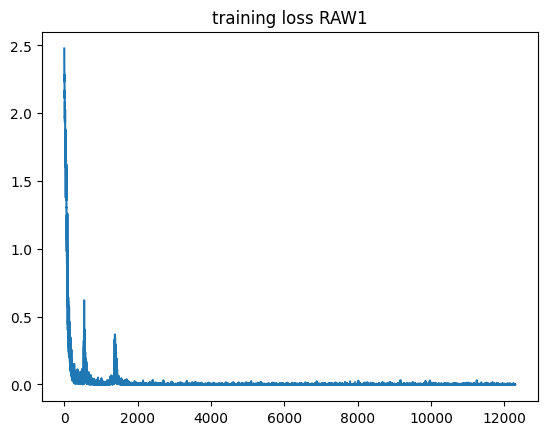

In [52]:
#RAW1 TRAINER
optimizer = optim.Adam(RAWmodel1.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

pbar_update = 1 / (len(RAWtrain_loader) + len(RAWvalid_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        RAWtrain(RAWmodel1, epoch, log_interval)
        RAWtest(RAWmodel1, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss RAW1");

In [53]:
error=0
print("test amount",len(RAWtest_set))
for i in range(len(RAWtest_set)-1) :
    if i==1685 or i==1692 or i==1753: 
        continue
    waveform, utterance = RAWtest_set[i]
    output = predict(waveform.to(device),RAWmodel1)
    if output != label_Encoder.classes_[utterance]:
        #Audio(waveform.numpy(), rate=sample_rate)
        #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
        error+=1         
print("error: ",error)
print("acc: ",float(100-error/len(RAWtest_set)*100))

test amount 2763
error:  1483
acc:  46.32645674990952


  0%|                                                                                                                                 | 0.009708737864077669/150 [00:00<1:48:02, 43.22s/it]

Train Epoch: 1 [0/10452 (0%)]	Loss: 2.416097


  0%|▏                                                                                                                                   | 0.203883495145631/150 [00:04<1:07:42, 27.12s/it]

Train Epoch: 1 [2560/10452 (24%)]	Loss: 2.001190


  0%|▎                                                                                                                                   | 0.39805825242718434/150 [00:09<53:31, 21.46s/it]

Train Epoch: 1 [5120/10452 (49%)]	Loss: 1.904467


  0%|▌                                                                                                                                  | 0.6019417475728154/150 [00:14<1:03:45, 25.61s/it]

Train Epoch: 1 [7680/10452 (73%)]	Loss: 1.812713


  1%|▋                                                                                                                                    | 0.7961165048543687/150 [00:19<57:21, 23.07s/it]

Train Epoch: 1 [10240/10452 (98%)]	Loss: 1.685392


  1%|▊                                                                                                                                   | 0.990291262135922/150 [00:24<1:04:01, 25.78s/it]


Validate Epoch: 1	Accuracy: 590/2613 (23%)



  1%|▉                                                                                                                                  | 1.0097087378640774/150 [00:24<1:00:53, 24.52s/it]

Train Epoch: 2 [0/10452 (0%)]	Loss: 1.868687


  1%|█                                                                                                                                    | 1.2038834951456308/150 [00:28<57:56, 23.36s/it]

Train Epoch: 2 [2560/10452 (24%)]	Loss: 1.603811


  1%|█▏                                                                                                                                   | 1.4077669902912617/150 [00:33<53:20, 21.54s/it]

Train Epoch: 2 [5120/10452 (49%)]	Loss: 1.300848


  1%|█▍                                                                                                                                 | 1.5922330097087374/150 [00:38<1:11:58, 29.10s/it]

Train Epoch: 2 [7680/10452 (73%)]	Loss: 1.121462


  1%|█▌                                                                                                                                   | 1.7961165048543684/150 [00:43<52:46, 21.37s/it]

Train Epoch: 2 [10240/10452 (98%)]	Loss: 1.084420


  1%|█▊                                                                                                                                   | 1.9999999999999993/150 [00:47<46:14, 18.74s/it]


Validate Epoch: 2	Accuracy: 1143/2613 (44%)



  1%|█▊                                                                                                                                    | 2.009708737864077/150 [00:48<56:40, 22.98s/it]

Train Epoch: 3 [0/10452 (0%)]	Loss: 0.988965


  1%|█▉                                                                                                                                 | 2.2038834951456305/150 [00:53<1:00:46, 24.67s/it]

Train Epoch: 3 [2560/10452 (24%)]	Loss: 0.852400


  2%|██                                                                                                                                  | 2.398058252427184/150 [00:58<1:11:11, 28.94s/it]

Train Epoch: 3 [5120/10452 (49%)]	Loss: 0.871094


  2%|██▎                                                                                                                                 | 2.592233009708737/150 [01:03<1:05:10, 26.53s/it]

Train Epoch: 3 [7680/10452 (73%)]	Loss: 0.773635


  2%|██▍                                                                                                                                   | 2.796116504854368/150 [01:08<55:00, 22.42s/it]

Train Epoch: 3 [10240/10452 (98%)]	Loss: 0.579140


  2%|██▌                                                                                                                                | 2.9902912621359214/150 [01:13<1:03:34, 25.95s/it]


Validate Epoch: 3	Accuracy: 1593/2613 (61%)



  2%|██▋                                                                                                                                  | 3.0194174757281544/150 [01:13<52:21, 21.37s/it]

Train Epoch: 4 [0/10452 (0%)]	Loss: 0.712302


  2%|██▊                                                                                                                                  | 3.20388349514563/150 [01:18<1:08:01, 27.80s/it]

Train Epoch: 4 [2560/10452 (24%)]	Loss: 0.502635


  2%|██▉                                                                                                                                | 3.3980582524271834/150 [01:23<1:09:49, 28.58s/it]

Train Epoch: 4 [5120/10452 (49%)]	Loss: 1.116135


  2%|███▏                                                                                                                               | 3.5922330097087367/150 [01:28<1:04:27, 26.42s/it]

Train Epoch: 4 [7680/10452 (73%)]	Loss: 0.337218


  3%|███▎                                                                                                                                 | 3.7961165048543677/150 [01:33<55:58, 22.97s/it]

Train Epoch: 4 [10240/10452 (98%)]	Loss: 0.460050


  3%|███▌                                                                                                                                 | 3.9999999999999987/150 [01:38<51:56, 21.35s/it]


Validate Epoch: 4	Accuracy: 2275/2613 (87%)



  3%|███▌                                                                                                                                | 4.009708737864076/150 [01:38<1:01:49, 25.41s/it]

Train Epoch: 5 [0/10452 (0%)]	Loss: 0.398089


  3%|███▋                                                                                                                               | 4.2038834951456385/150 [01:43<1:10:52, 29.16s/it]

Train Epoch: 5 [2560/10452 (24%)]	Loss: 0.266545


  3%|███▉                                                                                                                                  | 4.407766990291279/150 [01:48<48:58, 20.18s/it]

Train Epoch: 5 [5120/10452 (49%)]	Loss: 0.246115


  3%|████                                                                                                                                | 4.592233009708763/150 [01:53<1:13:16, 30.23s/it]

Train Epoch: 5 [7680/10452 (73%)]	Loss: 0.573128


  3%|████▎                                                                                                                                 | 4.796116504854403/150 [01:58<53:59, 22.31s/it]

Train Epoch: 5 [10240/10452 (98%)]	Loss: 0.390730


  3%|████▍                                                                                                                                 | 4.990291262135965/150 [02:02<55:50, 23.11s/it]


Validate Epoch: 5	Accuracy: 2026/2613 (78%)



  3%|████▍                                                                                                                                 | 5.009708737864122/150 [02:02<47:52, 19.81s/it]

Train Epoch: 6 [0/10452 (0%)]	Loss: 0.379571


  3%|████▌                                                                                                                               | 5.203883495145684/150 [02:08<1:08:33, 28.41s/it]

Train Epoch: 6 [2560/10452 (24%)]	Loss: 0.190722


  4%|████▊                                                                                                                                 | 5.398058252427246/150 [02:12<57:33, 23.88s/it]

Train Epoch: 6 [5120/10452 (49%)]	Loss: 0.498620


  4%|████▉                                                                                                                               | 5.592233009708808/150 [02:17<1:05:30, 27.22s/it]

Train Epoch: 6 [7680/10452 (73%)]	Loss: 0.226036


  4%|█████▏                                                                                                                               | 5.7961165048544485/150 [02:22<43:23, 18.05s/it]

Train Epoch: 6 [10240/10452 (98%)]	Loss: 0.151524


  4%|█████▎                                                                                                                                | 6.000000000000089/150 [02:26<53:27, 22.27s/it]


Validate Epoch: 6	Accuracy: 2472/2613 (95%)



  4%|█████▍                                                                                                                                | 6.019417475728245/150 [02:27<55:16, 23.04s/it]

Train Epoch: 7 [0/10452 (0%)]	Loss: 0.278975


  4%|█████▌                                                                                                                                | 6.213592233009807/150 [02:31<50:14, 20.97s/it]

Train Epoch: 7 [2560/10452 (24%)]	Loss: 0.182255


  4%|█████▋                                                                                                                              | 6.398058252427291/150 [02:36<1:06:55, 27.96s/it]

Train Epoch: 7 [5120/10452 (49%)]	Loss: 0.126323


  4%|█████▊                                                                                                                             | 6.5922330097088535/150 [02:41<1:09:33, 29.10s/it]

Train Epoch: 7 [7680/10452 (73%)]	Loss: 0.482644


  5%|██████                                                                                                                                | 6.796116504854494/150 [02:45<48:12, 20.20s/it]

Train Epoch: 7 [10240/10452 (98%)]	Loss: 0.110757


  5%|██████▎                                                                                                                               | 7.000000000000134/150 [02:50<51:52, 21.76s/it]


Validate Epoch: 7	Accuracy: 2533/2613 (97%)



  5%|██████▎                                                                                                                                | 7.01941747572829/150 [02:51<55:46, 23.41s/it]

Train Epoch: 8 [0/10452 (0%)]	Loss: 0.405965


  5%|██████▎                                                                                                                             | 7.203883495145774/150 [02:56<1:07:11, 28.23s/it]

Train Epoch: 8 [2560/10452 (24%)]	Loss: 0.167327


  5%|██████▌                                                                                                                             | 7.398058252427337/150 [03:00<1:05:03, 27.37s/it]

Train Epoch: 8 [5120/10452 (49%)]	Loss: 0.212028


  5%|██████▊                                                                                                                               | 7.592233009708899/150 [03:05<48:20, 20.37s/it]

Train Epoch: 8 [7680/10452 (73%)]	Loss: 0.163147


  5%|██████▉                                                                                                                               | 7.796116504854539/150 [03:10<59:39, 25.17s/it]

Train Epoch: 8 [10240/10452 (98%)]	Loss: 0.174797


  5%|███████▏                                                                                                                              | 7.990291262136101/150 [03:14<55:58, 23.65s/it]


Validate Epoch: 8	Accuracy: 2528/2613 (97%)



  5%|███████▏                                                                                                                              | 8.009708737864257/150 [03:15<48:34, 20.53s/it]

Train Epoch: 9 [0/10452 (0%)]	Loss: 0.265520


  5%|███████▎                                                                                                                              | 8.213592233009878/150 [03:20<49:25, 20.92s/it]

Train Epoch: 9 [2560/10452 (24%)]	Loss: 0.109447


  6%|███████▍                                                                                                                            | 8.398058252427345/150 [03:24<1:10:12, 29.75s/it]

Train Epoch: 9 [5120/10452 (49%)]	Loss: 0.202014


  6%|███████▋                                                                                                                               | 8.59223300970889/150 [03:28<54:57, 23.32s/it]

Train Epoch: 9 [7680/10452 (73%)]	Loss: 0.187251


  6%|███████▊                                                                                                                              | 8.796116504854512/150 [03:34<54:50, 23.30s/it]

Train Epoch: 9 [10240/10452 (98%)]	Loss: 0.112513


  6%|████████                                                                                                                              | 9.000000000000133/150 [03:38<48:22, 20.59s/it]


Validate Epoch: 9	Accuracy: 2560/2613 (98%)



  6%|███████▉                                                                                                                             | 9.00970873786421/150 [03:39<1:00:29, 25.75s/it]

Train Epoch: 10 [0/10452 (0%)]	Loss: 0.242898


  6%|████████                                                                                                                            | 9.203883495145755/150 [03:44<1:05:01, 27.71s/it]

Train Epoch: 10 [2560/10452 (24%)]	Loss: 0.082217


  6%|████████▌                                                                                                                               | 9.3980582524273/150 [03:49<52:36, 22.45s/it]

Train Epoch: 10 [5120/10452 (49%)]	Loss: 0.127347


  6%|████████▌                                                                                                                             | 9.601941747572921/150 [03:53<59:29, 25.42s/it]

Train Epoch: 10 [7680/10452 (73%)]	Loss: 0.224960


  7%|████████▊                                                                                                                             | 9.796116504854465/150 [03:58<55:53, 23.92s/it]

Train Epoch: 10 [10240/10452 (98%)]	Loss: 0.285367


  7%|████████▉                                                                                                                              | 9.99029126213601/150 [04:03<57:23, 24.60s/it]


Validate Epoch: 10	Accuracy: 2240/2613 (86%)



  7%|████████▉                                                                                                                            | 10.009708737864164/150 [04:03<50:24, 21.61s/it]

Train Epoch: 11 [0/10452 (0%)]	Loss: 0.129875


  7%|█████████                                                                                                                            | 10.213592233009786/150 [04:08<46:49, 20.10s/it]

Train Epoch: 11 [2560/10452 (24%)]	Loss: 0.130632


  7%|█████████                                                                                                                          | 10.398058252427253/150 [04:13<1:08:49, 29.58s/it]

Train Epoch: 11 [5120/10452 (49%)]	Loss: 0.190986


  7%|█████████▍                                                                                                                           | 10.601941747572875/150 [04:18<56:13, 24.20s/it]

Train Epoch: 11 [7680/10452 (73%)]	Loss: 0.055076


  7%|█████████▋                                                                                                                            | 10.79611650485442/150 [04:23<59:42, 25.74s/it]

Train Epoch: 11 [10240/10452 (98%)]	Loss: 0.429639


  7%|█████████▊                                                                                                                           | 11.009708737864118/150 [04:27<40:36, 17.53s/it]


Validate Epoch: 11	Accuracy: 2578/2613 (99%)

Train Epoch: 12 [0/10452 (0%)]	Loss: 0.056976


  7%|█████████▊                                                                                                                         | 11.203883495145663/150 [04:32<1:04:26, 27.86s/it]

Train Epoch: 12 [2560/10452 (24%)]	Loss: 0.113628


  8%|██████████                                                                                                                           | 11.398058252427207/150 [04:37<52:54, 22.91s/it]

Train Epoch: 12 [5120/10452 (49%)]	Loss: 0.208835


  8%|██████████▎                                                                                                                          | 11.592233009708751/150 [04:41<52:00, 22.55s/it]

Train Epoch: 12 [7680/10452 (73%)]	Loss: 0.072545


  8%|██████████▍                                                                                                                          | 11.796116504854373/150 [04:46<58:12, 25.27s/it]

Train Epoch: 12 [10240/10452 (98%)]	Loss: 0.264204


  8%|██████████▋                                                                                                                          | 11.990291262135917/150 [04:51<52:37, 22.88s/it]


Validate Epoch: 12	Accuracy: 2563/2613 (98%)



  8%|██████████▋                                                                                                                          | 12.009708737864072/150 [04:51<47:33, 20.68s/it]

Train Epoch: 13 [0/10452 (0%)]	Loss: 0.089757


  8%|██████████▊                                                                                                                          | 12.203883495145616/150 [04:56<50:18, 21.90s/it]

Train Epoch: 13 [2560/10452 (24%)]	Loss: 0.094202


  8%|███████████                                                                                                                           | 12.39805825242716/150 [05:01<56:34, 24.67s/it]

Train Epoch: 13 [5120/10452 (49%)]	Loss: 0.079198


  8%|███████████▏                                                                                                                         | 12.601941747572782/150 [05:06<57:37, 25.16s/it]

Train Epoch: 13 [7680/10452 (73%)]	Loss: 0.054496


  9%|███████████▎                                                                                                                         | 12.796116504854327/150 [05:10<46:13, 20.22s/it]

Train Epoch: 13 [10240/10452 (98%)]	Loss: 0.120546


  9%|███████████▌                                                                                                                         | 12.990291262135871/150 [05:15<57:05, 25.00s/it]


Validate Epoch: 13	Accuracy: 2572/2613 (98%)



  9%|███████████▌                                                                                                                         | 13.009708737864026/150 [05:15<49:33, 21.71s/it]

Train Epoch: 14 [0/10452 (0%)]	Loss: 0.037434


  9%|███████████▊                                                                                                                          | 13.20388349514557/150 [05:20<52:44, 23.13s/it]

Train Epoch: 14 [2560/10452 (24%)]	Loss: 0.087646


  9%|███████████▉                                                                                                                         | 13.407766990291192/150 [05:25<58:17, 25.61s/it]

Train Epoch: 14 [5120/10452 (49%)]	Loss: 0.211540


  9%|███████████▊                                                                                                                       | 13.592233009708659/150 [05:30<1:04:56, 28.57s/it]

Train Epoch: 14 [7680/10452 (73%)]	Loss: 0.057513


  9%|████████████▎                                                                                                                         | 13.79611650485428/150 [05:34<41:32, 18.30s/it]

Train Epoch: 14 [10240/10452 (98%)]	Loss: 0.151836


  9%|████████████▍                                                                                                                        | 13.990291262135825/150 [05:39<57:26, 25.34s/it]


Validate Epoch: 14	Accuracy: 2579/2613 (99%)



  9%|████████████▍                                                                                                                        | 14.019417475728057/150 [05:40<47:47, 21.09s/it]

Train Epoch: 15 [0/10452 (0%)]	Loss: 0.048476


  9%|████████████▍                                                                                                                      | 14.203883495145524/150 [05:44<1:01:33, 27.20s/it]

Train Epoch: 15 [2560/10452 (24%)]	Loss: 0.054547


 10%|████████████▊                                                                                                                        | 14.398058252427068/150 [05:49<45:47, 20.26s/it]

Train Epoch: 15 [5120/10452 (49%)]	Loss: 0.031961


 10%|█████████████                                                                                                                         | 14.60194174757269/150 [05:54<52:28, 23.26s/it]

Train Epoch: 15 [7680/10452 (73%)]	Loss: 0.129987


 10%|█████████████                                                                                                                        | 14.796116504854234/150 [05:58<53:24, 23.70s/it]

Train Epoch: 15 [10240/10452 (98%)]	Loss: 0.203229


 10%|█████████████▎                                                                                                                       | 14.990291262135779/150 [06:03<53:08, 23.61s/it]


Validate Epoch: 15	Accuracy: 2569/2613 (98%)



 10%|█████████████▍                                                                                                                        | 15.01941747572801/150 [06:03<44:32, 19.80s/it]

Train Epoch: 16 [0/10452 (0%)]	Loss: 0.049666


 10%|█████████████▍                                                                                                                       | 15.203883495145478/150 [06:08<56:16, 25.05s/it]

Train Epoch: 16 [2560/10452 (24%)]	Loss: 0.070646


 10%|█████████████▍                                                                                                                     | 15.398058252427022/150 [06:13<1:01:53, 27.59s/it]

Train Epoch: 16 [5120/10452 (49%)]	Loss: 0.113666


 10%|█████████████▊                                                                                                                       | 15.601941747572644/150 [06:17<48:22, 21.60s/it]

Train Epoch: 16 [7680/10452 (73%)]	Loss: 0.097624


 11%|██████████████                                                                                                                       | 15.796116504854188/150 [06:22<46:24, 20.75s/it]

Train Epoch: 16 [10240/10452 (98%)]	Loss: 0.198591


 11%|██████████████▏                                                                                                                      | 15.990291262135733/150 [06:27<57:19, 25.66s/it]


Validate Epoch: 16	Accuracy: 2527/2613 (97%)



 11%|██████████████▎                                                                                                                       | 16.00970873786389/150 [06:27<49:41, 22.25s/it]

Train Epoch: 17 [0/10452 (0%)]	Loss: 0.101751


 11%|██████████████▍                                                                                                                       | 16.21359223300951/150 [06:32<45:18, 20.32s/it]

Train Epoch: 17 [2560/10452 (24%)]	Loss: 0.057908


 11%|██████████████▎                                                                                                                    | 16.398058252426978/150 [06:36<1:04:12, 28.84s/it]

Train Epoch: 17 [5120/10452 (49%)]	Loss: 0.339488


 11%|██████████████▋                                                                                                                      | 16.592233009708522/150 [06:41<53:54, 24.25s/it]

Train Epoch: 17 [7680/10452 (73%)]	Loss: 0.042476


 11%|██████████████▉                                                                                                                      | 16.796116504854144/150 [06:46<40:39, 18.31s/it]

Train Epoch: 17 [10240/10452 (98%)]	Loss: 0.121905


 11%|███████████████                                                                                                                      | 16.999999999999766/150 [06:50<50:33, 22.81s/it]


Validate Epoch: 17	Accuracy: 2582/2613 (99%)



 11%|██████████████▊                                                                                                                    | 17.009708737863843/150 [06:51<1:03:14, 28.53s/it]

Train Epoch: 18 [0/10452 (0%)]	Loss: 0.125046


 11%|███████████████                                                                                                                    | 17.203883495145387/150 [06:55<1:03:35, 28.74s/it]

Train Epoch: 18 [2560/10452 (24%)]	Loss: 0.060783


 12%|███████████████▎                                                                                                                    | 17.39805825242693/150 [07:00<1:02:22, 28.23s/it]

Train Epoch: 18 [5120/10452 (49%)]	Loss: 0.046703


 12%|███████████████▌                                                                                                                     | 17.601941747572553/150 [07:05<45:37, 20.67s/it]

Train Epoch: 18 [7680/10452 (73%)]	Loss: 0.083345


 12%|███████████████▊                                                                                                                     | 17.796116504854098/150 [07:10<52:10, 23.68s/it]

Train Epoch: 18 [10240/10452 (98%)]	Loss: 0.034470


 12%|███████████████▉                                                                                                                     | 17.990291262135642/150 [07:14<49:58, 22.71s/it]


Validate Epoch: 18	Accuracy: 2578/2613 (99%)



 12%|███████████████▉                                                                                                                     | 18.009708737863797/150 [07:15<43:56, 19.98s/it]

Train Epoch: 19 [0/10452 (0%)]	Loss: 0.051386


 12%|████████████████▏                                                                                                                    | 18.213592233009418/150 [07:20<45:31, 20.73s/it]

Train Epoch: 19 [2560/10452 (24%)]	Loss: 0.096316


 12%|████████████████                                                                                                                   | 18.398058252426885/150 [07:24<1:05:05, 29.67s/it]

Train Epoch: 19 [5120/10452 (49%)]	Loss: 0.025759


 12%|████████████████▌                                                                                                                     | 18.59223300970843/150 [07:29<49:24, 22.56s/it]

Train Epoch: 19 [7680/10452 (73%)]	Loss: 0.062941


 13%|████████████████▊                                                                                                                     | 18.79611650485405/150 [07:34<50:06, 22.92s/it]

Train Epoch: 19 [10240/10452 (98%)]	Loss: 0.043538


 13%|████████████████▊                                                                                                                    | 18.990291262135596/150 [07:38<49:25, 22.63s/it]


Validate Epoch: 19	Accuracy: 2581/2613 (99%)



 13%|████████████████▊                                                                                                                    | 19.019417475727828/150 [07:39<45:54, 21.03s/it]

Train Epoch: 20 [0/10452 (0%)]	Loss: 0.099908


 13%|█████████████████                                                                                                                    | 19.213592233009372/150 [07:43<45:03, 20.67s/it]

Train Epoch: 20 [2560/10452 (24%)]	Loss: 0.046039


 13%|█████████████████                                                                                                                   | 19.39805825242684/150 [07:48<1:02:24, 28.67s/it]

Train Epoch: 20 [5120/10452 (49%)]	Loss: 0.125271


 13%|█████████████████▎                                                                                                                   | 19.592233009708384/150 [07:53<58:34, 26.95s/it]

Train Epoch: 20 [7680/10452 (73%)]	Loss: 0.058955


 13%|█████████████████▌                                                                                                                   | 19.796116504854005/150 [07:58<40:18, 18.57s/it]

Train Epoch: 20 [10240/10452 (98%)]	Loss: 0.120837


 13%|█████████████████▋                                                                                                                   | 19.999999999999627/150 [08:02<45:24, 20.96s/it]


Validate Epoch: 20	Accuracy: 2556/2613 (98%)



 13%|█████████████████▋                                                                                                                   | 20.009708737863704/150 [08:02<53:03, 24.49s/it]

Train Epoch: 21 [0/10452 (0%)]	Loss: 0.080572


 13%|██████████████████                                                                                                                    | 20.20388349514525/150 [08:07<48:18, 22.33s/it]

Train Epoch: 21 [2560/10452 (24%)]	Loss: 0.029091


 14%|██████████████████                                                                                                                   | 20.398058252426793/150 [08:12<56:22, 26.10s/it]

Train Epoch: 21 [5120/10452 (49%)]	Loss: 0.013033


 14%|██████████████████▎                                                                                                                  | 20.601941747572415/150 [08:17<54:15, 25.16s/it]

Train Epoch: 21 [7680/10452 (73%)]	Loss: 0.015229


 14%|██████████████████▌                                                                                                                   | 20.79611650485396/150 [08:21<50:24, 23.41s/it]

Train Epoch: 21 [10240/10452 (98%)]	Loss: 0.016930


 14%|██████████████████▌                                                                                                                  | 20.990291262135504/150 [08:26<45:40, 21.25s/it]


Validate Epoch: 21	Accuracy: 2594/2613 (99%)



 14%|██████████████████▋                                                                                                                  | 21.009708737863658/150 [08:26<41:33, 19.33s/it]

Train Epoch: 22 [0/10452 (0%)]	Loss: 0.037336


 14%|██████████████████▉                                                                                                                   | 21.21359223300928/150 [08:30<46:12, 21.53s/it]

Train Epoch: 22 [2560/10452 (24%)]	Loss: 0.010606


 14%|██████████████████▉                                                                                                                  | 21.407766990290824/150 [08:35<56:28, 26.35s/it]

Train Epoch: 22 [5120/10452 (49%)]	Loss: 0.026784


 14%|███████████████████▎                                                                                                                  | 21.59223300970829/150 [08:40<58:40, 27.42s/it]

Train Epoch: 22 [7680/10452 (73%)]	Loss: 0.010980


 15%|███████████████████▎                                                                                                                 | 21.796116504853913/150 [08:44<40:45, 19.08s/it]

Train Epoch: 22 [10240/10452 (98%)]	Loss: 0.029464


 15%|███████████████████▍                                                                                                                 | 21.990291262135457/150 [08:49<58:30, 27.42s/it]


Validate Epoch: 22	Accuracy: 2598/2613 (99%)



 15%|███████████████████▌                                                                                                                 | 22.009708737863612/150 [08:49<49:20, 23.13s/it]

Train Epoch: 23 [0/10452 (0%)]	Loss: 0.009306


 15%|███████████████████▋                                                                                                                 | 22.203883495145156/150 [08:54<48:17, 22.67s/it]

Train Epoch: 23 [2560/10452 (24%)]	Loss: 0.044641


 15%|███████████████████▊                                                                                                                 | 22.3980582524267/150 [08:59<1:01:19, 28.84s/it]

Train Epoch: 23 [5120/10452 (49%)]	Loss: 0.039394


 15%|████████████████████                                                                                                                 | 22.592233009708245/150 [09:04<56:18, 26.51s/it]

Train Epoch: 23 [7680/10452 (73%)]	Loss: 0.026298


 15%|████████████████████▏                                                                                                                | 22.796116504853867/150 [09:09<50:38, 23.89s/it]

Train Epoch: 23 [10240/10452 (98%)]	Loss: 0.013435


 15%|████████████████████▌                                                                                                                 | 22.99029126213541/150 [09:13<45:29, 21.49s/it]


Validate Epoch: 23	Accuracy: 2586/2613 (99%)



 15%|████████████████████▍                                                                                                                | 23.009708737863566/150 [09:14<47:30, 22.45s/it]

Train Epoch: 24 [0/10452 (0%)]	Loss: 0.012278


 15%|████████████████████▋                                                                                                                 | 23.20388349514511/150 [09:18<49:08, 23.25s/it]

Train Epoch: 24 [2560/10452 (24%)]	Loss: 0.027061


 16%|████████████████████▉                                                                                                                 | 23.40776699029073/150 [09:23<57:34, 27.28s/it]

Train Epoch: 24 [5120/10452 (49%)]	Loss: 0.031838


 16%|████████████████████▉                                                                                                                | 23.601941747572276/150 [09:27<50:08, 23.80s/it]

Train Epoch: 24 [7680/10452 (73%)]	Loss: 0.026206


 16%|█████████████████████▎                                                                                                                | 23.79611650485382/150 [09:32<50:42, 24.10s/it]

Train Epoch: 24 [10240/10452 (98%)]	Loss: 0.020359


 16%|█████████████████████▎                                                                                                               | 23.990291262135365/150 [09:37<46:02, 21.93s/it]


Validate Epoch: 24	Accuracy: 2595/2613 (99%)



 16%|█████████████████████▎                                                                                                               | 24.019417475727597/150 [09:37<43:42, 20.82s/it]

Train Epoch: 25 [0/10452 (0%)]	Loss: 0.011394


 16%|█████████████████████▋                                                                                                                | 24.21359223300914/150 [09:42<42:22, 20.22s/it]

Train Epoch: 25 [2560/10452 (24%)]	Loss: 0.022014


 16%|█████████████████████▋                                                                                                               | 24.407766990290686/150 [09:47<52:36, 25.14s/it]

Train Epoch: 25 [5120/10452 (49%)]	Loss: 0.019377


 16%|█████████████████████▊                                                                                                               | 24.592233009708153/150 [09:51<47:35, 22.77s/it]

Train Epoch: 25 [7680/10452 (73%)]	Loss: 0.056874


 17%|█████████████████████▉                                                                                                               | 24.796116504853774/150 [09:55<42:50, 20.53s/it]

Train Epoch: 25 [10240/10452 (98%)]	Loss: 0.023780


 17%|██████████████████████▎                                                                                                               | 24.99029126213532/150 [10:00<50:01, 24.01s/it]


Validate Epoch: 25	Accuracy: 2598/2613 (99%)



 17%|██████████████████████▏                                                                                                              | 25.009708737863473/150 [10:00<43:24, 20.84s/it]

Train Epoch: 26 [0/10452 (0%)]	Loss: 0.014598


 17%|██████████████████████▎                                                                                                              | 25.203883495145018/150 [10:05<49:17, 23.70s/it]

Train Epoch: 26 [2560/10452 (24%)]	Loss: 0.064946


 17%|██████████████████████▏                                                                                                            | 25.398058252426562/150 [10:10<1:00:51, 29.31s/it]

Train Epoch: 26 [5120/10452 (49%)]	Loss: 0.011350


 17%|██████████████████████▋                                                                                                              | 25.601941747572184/150 [10:15<42:12, 20.36s/it]

Train Epoch: 26 [7680/10452 (73%)]	Loss: 0.016459


 17%|██████████████████████▊                                                                                                              | 25.796116504853728/150 [10:19<52:23, 25.31s/it]

Train Epoch: 26 [10240/10452 (98%)]	Loss: 0.007774


 17%|███████████████████████▏                                                                                                              | 25.99999999999935/150 [10:24<45:51, 22.19s/it]


Validate Epoch: 26	Accuracy: 2596/2613 (99%)



 17%|███████████████████████                                                                                                              | 26.019417475727504/150 [10:24<45:17, 21.92s/it]

Train Epoch: 27 [0/10452 (0%)]	Loss: 0.014519


 17%|███████████████████████▍                                                                                                              | 26.21359223300905/150 [10:29<41:05, 19.92s/it]

Train Epoch: 27 [2560/10452 (24%)]	Loss: 0.105475


 18%|███████████████████████▍                                                                                                             | 26.398058252426516/150 [10:34<58:49, 28.56s/it]

Train Epoch: 27 [5120/10452 (49%)]	Loss: 0.067524


 18%|███████████████████████▌                                                                                                             | 26.601941747572138/150 [10:38<42:34, 20.70s/it]

Train Epoch: 27 [7680/10452 (73%)]	Loss: 0.019018


 18%|███████████████████████▊                                                                                                             | 26.796116504853682/150 [10:43<40:32, 19.74s/it]

Train Epoch: 27 [10240/10452 (98%)]	Loss: 0.079940


 18%|███████████████████████▉                                                                                                             | 26.990291262135226/150 [10:48<46:44, 22.80s/it]


Validate Epoch: 27	Accuracy: 2594/2613 (99%)



 18%|████████████████████████▏                                                                                                             | 27.00970873786338/150 [10:48<41:11, 20.10s/it]

Train Epoch: 28 [0/10452 (0%)]	Loss: 0.009869


 18%|████████████████████████▏                                                                                                            | 27.213592233009003/150 [10:53<44:40, 21.83s/it]

Train Epoch: 28 [2560/10452 (24%)]	Loss: 0.034254


 18%|████████████████████████▎                                                                                                            | 27.407766990290547/150 [10:58<45:49, 22.42s/it]

Train Epoch: 28 [5120/10452 (49%)]	Loss: 0.066451


 18%|████████████████████████▍                                                                                                            | 27.592233009708014/150 [11:02<56:12, 27.56s/it]

Train Epoch: 28 [7680/10452 (73%)]	Loss: 0.010530


 19%|████████████████████████▋                                                                                                            | 27.796116504853636/150 [11:07<39:11, 19.24s/it]

Train Epoch: 28 [10240/10452 (98%)]	Loss: 0.007314


 19%|█████████████████████████                                                                                                             | 27.99029126213518/150 [11:11<51:54, 25.53s/it]


Validate Epoch: 28	Accuracy: 2597/2613 (99%)



 19%|████████████████████████▊                                                                                                            | 28.009708737863335/150 [11:12<45:02, 22.16s/it]

Train Epoch: 29 [0/10452 (0%)]	Loss: 0.015457


 19%|█████████████████████████                                                                                                            | 28.213592233008956/150 [11:16<42:39, 21.01s/it]

Train Epoch: 29 [2560/10452 (24%)]	Loss: 0.022725


 19%|█████████████████████████▏                                                                                                           | 28.398058252426424/150 [11:21<45:36, 22.50s/it]

Train Epoch: 29 [5120/10452 (49%)]	Loss: 0.019430


 19%|█████████████████████████▎                                                                                                           | 28.601941747572045/150 [11:26<49:06, 24.27s/it]

Train Epoch: 29 [7680/10452 (73%)]	Loss: 0.055104


 19%|█████████████████████████▋                                                                                                            | 28.79611650485359/150 [11:31<42:53, 21.23s/it]

Train Epoch: 29 [10240/10452 (98%)]	Loss: 0.010342


 19%|█████████████████████████▋                                                                                                           | 28.990291262135134/150 [11:35<47:46, 23.68s/it]


Validate Epoch: 29	Accuracy: 2600/2613 (100%)



 19%|█████████████████████████▉                                                                                                            | 29.00970873786329/150 [11:35<44:17, 21.97s/it]

Train Epoch: 30 [0/10452 (0%)]	Loss: 0.040939


 19%|█████████████████████████▉                                                                                                           | 29.203883495144833/150 [11:40<44:00, 21.86s/it]

Train Epoch: 30 [2560/10452 (24%)]	Loss: 0.048062


 20%|██████████████████████████                                                                                                           | 29.398058252426377/150 [11:45<58:04, 28.89s/it]

Train Epoch: 30 [5120/10452 (49%)]	Loss: 0.028835


 20%|██████████████████████████▊                                                                                                             | 29.601941747572/150 [11:49<43:35, 21.72s/it]

Train Epoch: 30 [7680/10452 (73%)]	Loss: 0.059542


 20%|██████████████████████████▍                                                                                                          | 29.796116504853543/150 [11:54<49:20, 24.63s/it]

Train Epoch: 30 [10240/10452 (98%)]	Loss: 0.007274


 20%|██████████████████████████▌                                                                                                          | 29.999999999999165/150 [11:59<38:25, 19.21s/it]


Validate Epoch: 30	Accuracy: 2597/2613 (99%)



 20%|██████████████████████████▌                                                                                                          | 30.009708737863242/150 [11:59<41:40, 20.84s/it]

Train Epoch: 31 [0/10452 (0%)]	Loss: 0.007900


 20%|██████████████████████████▊                                                                                                          | 30.213592233008864/150 [12:04<42:17, 21.18s/it]

Train Epoch: 31 [2560/10452 (24%)]	Loss: 0.007630


 20%|███████████████████████████▏                                                                                                          | 30.39805825242633/150 [12:08<47:45, 23.96s/it]

Train Epoch: 31 [5120/10452 (49%)]	Loss: 0.060301


 20%|███████████████████████████▏                                                                                                         | 30.592233009707876/150 [12:13<47:26, 23.84s/it]

Train Epoch: 31 [7680/10452 (73%)]	Loss: 0.013029


 21%|███████████████████████████▎                                                                                                         | 30.796116504853497/150 [12:17<46:18, 23.31s/it]

Train Epoch: 31 [10240/10452 (98%)]	Loss: 0.006874


 21%|███████████████████████████▋                                                                                                          | 30.99029126213504/150 [12:22<44:46, 22.57s/it]


Validate Epoch: 31	Accuracy: 2596/2613 (99%)



 21%|███████████████████████████▍                                                                                                         | 31.009708737863196/150 [12:22<39:25, 19.88s/it]

Train Epoch: 32 [0/10452 (0%)]	Loss: 0.029854


 21%|███████████████████████████▉                                                                                                          | 31.20388349514474/150 [12:27<45:40, 23.07s/it]

Train Epoch: 32 [2560/10452 (24%)]	Loss: 0.015108


 21%|███████████████████████████▊                                                                                                         | 31.407766990290362/150 [12:32<41:11, 20.84s/it]

Train Epoch: 32 [5120/10452 (49%)]	Loss: 0.010764


 21%|████████████████████████████▏                                                                                                         | 31.59223300970783/150 [12:36<40:00, 20.27s/it]

Train Epoch: 32 [7680/10452 (73%)]	Loss: 0.065356


 21%|████████████████████████████▍                                                                                                         | 31.79611650485345/150 [12:40<47:05, 23.90s/it]

Train Epoch: 32 [10240/10452 (98%)]	Loss: 0.027555


 21%|████████████████████████████▎                                                                                                        | 31.990291262134996/150 [12:45<47:52, 24.34s/it]


Validate Epoch: 32	Accuracy: 2582/2613 (99%)



 21%|████████████████████████████▌                                                                                                         | 32.00970873786315/150 [12:46<41:25, 21.07s/it]

Train Epoch: 33 [0/10452 (0%)]	Loss: 0.026020


 21%|████████████████████████████▌                                                                                                        | 32.203883495144765/150 [12:51<45:56, 23.40s/it]

Train Epoch: 33 [2560/10452 (24%)]	Loss: 0.063503


 22%|████████████████████████████▉                                                                                                         | 32.39805825242638/150 [12:55<52:35, 26.83s/it]

Train Epoch: 33 [5120/10452 (49%)]	Loss: 0.022427


 22%|████████████████████████████▉                                                                                                        | 32.592233009707996/150 [13:00<49:23, 25.24s/it]

Train Epoch: 33 [7680/10452 (73%)]	Loss: 0.027765


 22%|█████████████████████████████▎                                                                                                        | 32.79611650485369/150 [13:05<36:15, 18.56s/it]

Train Epoch: 33 [10240/10452 (98%)]	Loss: 0.008108


 22%|█████████████████████████████▍                                                                                                        | 32.99029126213531/150 [13:09<54:12, 27.79s/it]


Validate Epoch: 33	Accuracy: 2596/2613 (99%)



 22%|█████████████████████████████▍                                                                                                        | 33.00970873786347/150 [13:10<44:31, 22.83s/it]

Train Epoch: 34 [0/10452 (0%)]	Loss: 0.019074


 22%|█████████████████████████████▍                                                                                                       | 33.213592233009166/150 [13:15<47:32, 24.42s/it]

Train Epoch: 34 [2560/10452 (24%)]	Loss: 0.024298


 22%|█████████████████████████████▊                                                                                                        | 33.40776699029078/150 [13:19<39:03, 20.10s/it]

Train Epoch: 34 [5120/10452 (49%)]	Loss: 0.022347


 22%|██████████████████████████████▏                                                                                                        | 33.6019417475724/150 [13:23<46:23, 23.92s/it]

Train Epoch: 34 [7680/10452 (73%)]	Loss: 0.026738


 23%|██████████████████████████████▏                                                                                                       | 33.79611650485401/150 [13:28<36:00, 18.60s/it]

Train Epoch: 34 [10240/10452 (98%)]	Loss: 0.016509


 23%|██████████████████████████████▎                                                                                                       | 33.99029126213563/150 [13:32<46:00, 23.80s/it]


Validate Epoch: 34	Accuracy: 2599/2613 (99%)



 23%|██████████████████████████████▍                                                                                                       | 34.00970873786379/150 [13:33<39:55, 20.65s/it]

Train Epoch: 35 [0/10452 (0%)]	Loss: 0.014516


 23%|██████████████████████████████▎                                                                                                      | 34.213592233009486/150 [13:37<40:35, 21.03s/it]

Train Epoch: 35 [2560/10452 (24%)]	Loss: 0.029444


 23%|██████████████████████████████▉                                                                                                        | 34.4077669902911/150 [13:42<39:57, 20.75s/it]

Train Epoch: 35 [5120/10452 (49%)]	Loss: 0.010834


 23%|██████████████████████████████▋                                                                                                      | 34.592233009708636/150 [13:46<40:16, 20.94s/it]

Train Epoch: 35 [7680/10452 (73%)]	Loss: 0.011537


 23%|███████████████████████████████                                                                                                       | 34.79611650485433/150 [13:51<48:12, 25.10s/it]

Train Epoch: 35 [10240/10452 (98%)]	Loss: 0.013299


 23%|███████████████████████████████▎                                                                                                      | 34.99029126213595/150 [13:56<44:19, 23.12s/it]


Validate Epoch: 35	Accuracy: 2599/2613 (99%)



 23%|███████████████████████████████▎                                                                                                      | 35.00970873786411/150 [13:56<38:39, 20.17s/it]

Train Epoch: 36 [0/10452 (0%)]	Loss: 0.015932


 23%|███████████████████████████████▏                                                                                                     | 35.203883495145725/150 [14:01<58:01, 30.33s/it]

Train Epoch: 36 [2560/10452 (24%)]	Loss: 0.036092


 24%|███████████████████████████████▋                                                                                                      | 35.40776699029142/150 [14:06<48:42, 25.50s/it]

Train Epoch: 36 [5120/10452 (49%)]	Loss: 0.035740


 24%|███████████████████████████████▌                                                                                                     | 35.592233009708956/150 [14:10<48:59, 25.69s/it]

Train Epoch: 36 [7680/10452 (73%)]	Loss: 0.024143


 24%|███████████████████████████████▉                                                                                                      | 35.79611650485465/150 [14:15<37:17, 19.59s/it]

Train Epoch: 36 [10240/10452 (98%)]	Loss: 0.018799


 24%|████████████████████████████████▏                                                                                                     | 35.99029126213627/150 [14:19<38:07, 20.07s/it]


Validate Epoch: 36	Accuracy: 2600/2613 (100%)

Train Epoch: 37 [0/10452 (0%)]	Loss: 0.011442


 24%|████████████████████████████████                                                                                                     | 36.203883495146044/150 [14:24<45:26, 23.96s/it]

Train Epoch: 37 [2560/10452 (24%)]	Loss: 0.011582


 24%|████████████████████████████████▌                                                                                                     | 36.39805825242766/150 [14:29<52:00, 27.47s/it]

Train Epoch: 37 [5120/10452 (49%)]	Loss: 0.009614


 24%|████████████████████████████████▍                                                                                                    | 36.601941747573356/150 [14:33<49:10, 26.02s/it]

Train Epoch: 37 [7680/10452 (73%)]	Loss: 0.019340


 25%|████████████████████████████████▊                                                                                                     | 36.79611650485497/150 [14:38<46:37, 24.71s/it]

Train Epoch: 37 [10240/10452 (98%)]	Loss: 0.055146


 25%|█████████████████████████████████                                                                                                     | 37.00000000000067/150 [14:42<36:21, 19.31s/it]


Validate Epoch: 37	Accuracy: 2597/2613 (99%)



 25%|█████████████████████████████████                                                                                                     | 37.00970873786475/150 [14:42<45:03, 23.93s/it]

Train Epoch: 38 [0/10452 (0%)]	Loss: 0.084868


 25%|████████████████████████████████▉                                                                                                    | 37.213592233010445/150 [14:47<44:40, 23.76s/it]

Train Epoch: 38 [2560/10452 (24%)]	Loss: 0.037086


 25%|█████████████████████████████████▍                                                                                                    | 37.40776699029206/150 [14:52<41:38, 22.19s/it]

Train Epoch: 38 [5120/10452 (49%)]	Loss: 0.004708


 25%|█████████████████████████████████▎                                                                                                   | 37.601941747573676/150 [14:56<39:58, 21.34s/it]

Train Epoch: 38 [7680/10452 (73%)]	Loss: 0.049741


 25%|█████████████████████████████████▊                                                                                                    | 37.79611650485529/150 [15:01<35:23, 18.93s/it]

Train Epoch: 38 [10240/10452 (98%)]	Loss: 0.109725


 25%|█████████████████████████████████▉                                                                                                    | 37.99029126213691/150 [15:06<47:29, 25.44s/it]


Validate Epoch: 38	Accuracy: 2594/2613 (99%)

Train Epoch: 39 [0/10452 (0%)]	Loss: 0.005405


 25%|█████████████████████████████████▊                                                                                                   | 38.203883495146684/150 [15:10<43:02, 23.10s/it]

Train Epoch: 39 [2560/10452 (24%)]	Loss: 0.007421


 26%|██████████████████████████████████▌                                                                                                    | 38.3980582524283/150 [15:14<41:34, 22.35s/it]

Train Epoch: 39 [5120/10452 (49%)]	Loss: 0.031326


 26%|██████████████████████████████████▏                                                                                                  | 38.601941747573996/150 [15:19<37:27, 20.18s/it]

Train Epoch: 39 [7680/10452 (73%)]	Loss: 0.054339


 26%|██████████████████████████████████▋                                                                                                   | 38.79611650485561/150 [15:24<42:23, 22.87s/it]

Train Epoch: 39 [10240/10452 (98%)]	Loss: 0.018806


 26%|██████████████████████████████████▊                                                                                                   | 38.99029126213723/150 [15:28<43:42, 23.62s/it]


Validate Epoch: 39	Accuracy: 2594/2613 (99%)

Train Epoch: 40 [0/10452 (0%)]	Loss: 0.022736


 26%|██████████████████████████████████▊                                                                                                  | 39.213592233011084/150 [15:32<39:40, 21.49s/it]

Train Epoch: 40 [2560/10452 (24%)]	Loss: 0.029824


 26%|███████████████████████████████████▏                                                                                                  | 39.39805825242862/150 [15:37<46:18, 25.13s/it]

Train Epoch: 40 [5120/10452 (49%)]	Loss: 0.038619


 26%|███████████████████████████████████                                                                                                  | 39.592233009710235/150 [15:41<42:46, 23.24s/it]

Train Epoch: 40 [7680/10452 (73%)]	Loss: 0.028962


 27%|███████████████████████████████████▌                                                                                                  | 39.79611650485593/150 [15:46<36:34, 19.92s/it]

Train Epoch: 40 [10240/10452 (98%)]	Loss: 0.025324


 27%|███████████████████████████████████▍                                                                                                 | 39.990291262137546/150 [15:50<42:33, 23.22s/it]


Validate Epoch: 40	Accuracy: 2590/2613 (99%)



 27%|███████████████████████████████████▋                                                                                                  | 40.00970873786571/150 [15:51<39:12, 21.38s/it]

Train Epoch: 41 [0/10452 (0%)]	Loss: 0.016926


 27%|███████████████████████████████████▋                                                                                                 | 40.213592233011404/150 [15:55<40:17, 22.02s/it]

Train Epoch: 41 [2560/10452 (24%)]	Loss: 0.010660


 27%|████████████████████████████████████                                                                                                  | 40.39805825242894/150 [16:00<38:25, 21.03s/it]

Train Epoch: 41 [5120/10452 (49%)]	Loss: 0.016310


 27%|███████████████████████████████████▉                                                                                                 | 40.592233009710554/150 [16:04<39:45, 21.80s/it]

Train Epoch: 41 [7680/10452 (73%)]	Loss: 0.061967


 27%|████████████████████████████████████▍                                                                                                 | 40.79611650485625/150 [16:09<42:06, 23.14s/it]

Train Epoch: 41 [10240/10452 (98%)]	Loss: 0.022194


 27%|████████████████████████████████████▋                                                                                                 | 41.00970873786603/150 [16:14<37:46, 20.79s/it]


Validate Epoch: 41	Accuracy: 2596/2613 (99%)

Train Epoch: 42 [0/10452 (0%)]	Loss: 0.036486


 27%|████████████████████████████████████▌                                                                                                | 41.213592233011724/150 [16:18<40:19, 22.24s/it]

Train Epoch: 42 [2560/10452 (24%)]	Loss: 0.053655


 28%|████████████████████████████████████▉                                                                                                 | 41.39805825242926/150 [16:22<39:21, 21.74s/it]

Train Epoch: 42 [5120/10452 (49%)]	Loss: 0.002661


 28%|████████████████████████████████████▉                                                                                                | 41.592233009710874/150 [16:27<46:56, 25.98s/it]

Train Epoch: 42 [7680/10452 (73%)]	Loss: 0.012302


 28%|█████████████████████████████████████▎                                                                                                | 41.79611650485657/150 [16:32<43:53, 24.33s/it]

Train Epoch: 42 [10240/10452 (98%)]	Loss: 0.012134


 28%|█████████████████████████████████████▏                                                                                               | 41.990291262138186/150 [16:36<36:12, 20.11s/it]


Validate Epoch: 42	Accuracy: 2593/2613 (99%)

Train Epoch: 43 [0/10452 (0%)]	Loss: 0.023462


 28%|█████████████████████████████████████▍                                                                                               | 42.213592233012044/150 [16:41<34:53, 19.42s/it]

Train Epoch: 43 [2560/10452 (24%)]	Loss: 0.015717


 28%|█████████████████████████████████████▉                                                                                                | 42.39805825242958/150 [16:45<49:04, 27.36s/it]

Train Epoch: 43 [5120/10452 (49%)]	Loss: 0.017188


 28%|█████████████████████████████████████▊                                                                                               | 42.601941747575275/150 [16:49<37:47, 21.11s/it]

Train Epoch: 43 [7680/10452 (73%)]	Loss: 0.040257


 29%|██████████████████████████████████████▏                                                                                               | 42.79611650485689/150 [16:54<33:00, 18.47s/it]

Train Epoch: 43 [10240/10452 (98%)]	Loss: 0.019481


 29%|██████████████████████████████████████                                                                                               | 42.990291262138506/150 [16:58<53:06, 29.77s/it]


Validate Epoch: 43	Accuracy: 2597/2613 (99%)



 29%|██████████████████████████████████████▍                                                                                               | 43.00970873786667/150 [16:59<44:15, 24.82s/it]

Train Epoch: 44 [0/10452 (0%)]	Loss: 0.013441


 29%|██████████████████████████████████████▌                                                                                               | 43.20388349514828/150 [17:03<42:41, 23.98s/it]

Train Epoch: 44 [2560/10452 (24%)]	Loss: 0.032226


 29%|██████████████████████████████████████▊                                                                                               | 43.40776699029398/150 [17:08<37:27, 21.09s/it]

Train Epoch: 44 [5120/10452 (49%)]	Loss: 0.088513


 29%|██████████████████████████████████████▋                                                                                              | 43.592233009711514/150 [17:12<49:03, 27.66s/it]

Train Epoch: 44 [7680/10452 (73%)]	Loss: 0.049327


 29%|███████████████████████████████████████                                                                                               | 43.79611650485721/150 [17:17<43:53, 24.79s/it]

Train Epoch: 44 [10240/10452 (98%)]	Loss: 0.034515


 29%|███████████████████████████████████████▎                                                                                              | 44.00970873786699/150 [17:22<32:23, 18.34s/it]


Validate Epoch: 44	Accuracy: 2601/2613 (100%)

Train Epoch: 45 [0/10452 (0%)]	Loss: 0.022632


 29%|███████████████████████████████████████▊                                                                                               | 44.2038834951486/150 [17:26<43:11, 24.49s/it]

Train Epoch: 45 [2560/10452 (24%)]	Loss: 0.009548


 30%|███████████████████████████████████████▋                                                                                              | 44.39805825243022/150 [17:30<37:03, 21.06s/it]

Train Epoch: 45 [5120/10452 (49%)]	Loss: 0.077485


 30%|███████████████████████████████████████▊                                                                                              | 44.59223300971183/150 [17:35<38:14, 21.77s/it]

Train Epoch: 45 [7680/10452 (73%)]	Loss: 0.019785


 30%|████████████████████████████████████████                                                                                              | 44.79611650485753/150 [17:40<38:08, 21.76s/it]

Train Epoch: 45 [10240/10452 (98%)]	Loss: 0.004789


 30%|███████████████████████████████████████▉                                                                                             | 44.990291262139145/150 [17:44<40:34, 23.18s/it]


Validate Epoch: 45	Accuracy: 2595/2613 (99%)



 30%|████████████████████████████████████████▏                                                                                             | 45.00970873786731/150 [17:45<36:33, 20.89s/it]

Train Epoch: 46 [0/10452 (0%)]	Loss: 0.016791


 30%|████████████████████████████████████████▍                                                                                             | 45.20388349514892/150 [17:49<45:47, 26.22s/it]

Train Epoch: 46 [2560/10452 (24%)]	Loss: 0.011477


 30%|████████████████████████████████████████▌                                                                                             | 45.39805825243054/150 [17:53<40:26, 23.19s/it]

Train Epoch: 46 [5120/10452 (49%)]	Loss: 0.008034


 30%|████████████████████████████████████████▋                                                                                             | 45.59223300971215/150 [17:58<37:45, 21.70s/it]

Train Epoch: 46 [7680/10452 (73%)]	Loss: 0.010544


 31%|████████████████████████████████████████▉                                                                                             | 45.79611650485785/150 [18:03<43:27, 25.02s/it]

Train Epoch: 46 [10240/10452 (98%)]	Loss: 0.023634


 31%|████████████████████████████████████████▊                                                                                            | 46.009708737867626/150 [18:07<30:31, 17.61s/it]


Validate Epoch: 46	Accuracy: 2600/2613 (100%)

Train Epoch: 47 [0/10452 (0%)]	Loss: 0.005284


 31%|█████████████████████████████████████████▎                                                                                            | 46.21359223301332/150 [18:12<37:59, 21.97s/it]

Train Epoch: 47 [2560/10452 (24%)]	Loss: 0.008774


 31%|█████████████████████████████████████████▍                                                                                            | 46.39805825243086/150 [18:16<50:08, 29.04s/it]

Train Epoch: 47 [5120/10452 (49%)]	Loss: 0.008141


 31%|█████████████████████████████████████████▎                                                                                           | 46.601941747576554/150 [18:21<44:44, 25.96s/it]

Train Epoch: 47 [7680/10452 (73%)]	Loss: 0.010073


 31%|█████████████████████████████████████████▊                                                                                            | 46.79611650485817/150 [18:25<35:50, 20.84s/it]

Train Epoch: 47 [10240/10452 (98%)]	Loss: 0.005229


 31%|█████████████████████████████████████████▋                                                                                           | 46.990291262139785/150 [18:30<37:23, 21.78s/it]


Validate Epoch: 47	Accuracy: 2596/2613 (99%)

Train Epoch: 48 [0/10452 (0%)]	Loss: 0.023611


 31%|██████████████████████████████████████████▏                                                                                           | 47.20388349514956/150 [18:34<42:31, 24.82s/it]

Train Epoch: 48 [2560/10452 (24%)]	Loss: 0.022818


 32%|██████████████████████████████████████████▎                                                                                           | 47.39805825243118/150 [18:39<38:18, 22.40s/it]

Train Epoch: 48 [5120/10452 (49%)]	Loss: 0.011127


 32%|██████████████████████████████████████████▌                                                                                           | 47.60194174757687/150 [18:44<39:02, 22.88s/it]

Train Epoch: 48 [7680/10452 (73%)]	Loss: 0.020326


 32%|██████████████████████████████████████████▋                                                                                           | 47.79611650485849/150 [18:48<41:44, 24.51s/it]

Train Epoch: 48 [10240/10452 (98%)]	Loss: 0.027105


 32%|██████████████████████████████████████████▌                                                                                          | 47.990291262140104/150 [18:53<42:23, 24.93s/it]


Validate Epoch: 48	Accuracy: 2589/2613 (99%)



 32%|██████████████████████████████████████████▌                                                                                          | 48.009708737868266/150 [18:53<37:28, 22.05s/it]

Train Epoch: 49 [0/10452 (0%)]	Loss: 0.025678


 32%|███████████████████████████████████████████                                                                                           | 48.20388349514988/150 [18:58<37:35, 22.16s/it]

Train Epoch: 49 [2560/10452 (24%)]	Loss: 0.007939


 32%|███████████████████████████████████████████▌                                                                                           | 48.3980582524315/150 [19:03<44:06, 26.05s/it]

Train Epoch: 49 [5120/10452 (49%)]	Loss: 0.017700


 32%|███████████████████████████████████████████▍                                                                                          | 48.59223300971311/150 [19:07<53:23, 31.59s/it]

Train Epoch: 49 [7680/10452 (73%)]	Loss: 0.086516


 33%|███████████████████████████████████████████▌                                                                                          | 48.79611650485881/150 [19:12<40:00, 23.72s/it]

Train Epoch: 49 [10240/10452 (98%)]	Loss: 0.062133


 33%|███████████████████████████████████████████▍                                                                                         | 48.990291262140424/150 [19:17<40:31, 24.07s/it]


Validate Epoch: 49	Accuracy: 2600/2613 (100%)



 33%|███████████████████████████████████████████▍                                                                                         | 49.009708737868586/150 [19:17<37:00, 21.99s/it]

Train Epoch: 50 [0/10452 (0%)]	Loss: 0.092556


 33%|███████████████████████████████████████████▉                                                                                          | 49.21359223301428/150 [19:21<36:03, 21.46s/it]

Train Epoch: 50 [2560/10452 (24%)]	Loss: 0.009429


 33%|████████████████████████████████████████████▏                                                                                         | 49.39805825243182/150 [19:26<40:31, 24.17s/it]

Train Epoch: 50 [5120/10452 (49%)]	Loss: 0.032451


 33%|████████████████████████████████████████████▎                                                                                         | 49.60194174757751/150 [19:31<42:36, 25.46s/it]

Train Epoch: 50 [7680/10452 (73%)]	Loss: 0.008499


 33%|████████████████████████████████████████████▍                                                                                         | 49.79611650485913/150 [19:35<33:04, 19.81s/it]

Train Epoch: 50 [10240/10452 (98%)]	Loss: 0.033597


 33%|████████████████████████████████████████████▎                                                                                        | 49.990291262140744/150 [19:40<33:30, 20.10s/it]


Validate Epoch: 50	Accuracy: 2599/2613 (99%)

Train Epoch: 51 [0/10452 (0%)]	Loss: 0.057906


 33%|████████████████████████████████████████████▊                                                                                         | 50.20388349515052/150 [19:44<45:13, 27.19s/it]

Train Epoch: 51 [2560/10452 (24%)]	Loss: 0.053597


 34%|█████████████████████████████████████████████                                                                                         | 50.40776699029622/150 [19:49<34:34, 20.83s/it]

Train Epoch: 51 [5120/10452 (49%)]	Loss: 0.016405


 34%|█████████████████████████████████████████████▏                                                                                        | 50.59223300971375/150 [19:53<34:19, 20.72s/it]

Train Epoch: 51 [7680/10452 (73%)]	Loss: 0.026154


 34%|█████████████████████████████████████████████▍                                                                                        | 50.79611650485945/150 [19:58<33:19, 20.15s/it]

Train Epoch: 51 [10240/10452 (98%)]	Loss: 0.024133


 34%|█████████████████████████████████████████████▏                                                                                       | 50.990291262141064/150 [20:02<40:57, 24.82s/it]


Validate Epoch: 51	Accuracy: 2599/2613 (99%)



 34%|█████████████████████████████████████████████▏                                                                                       | 51.019417475733306/150 [20:03<35:44, 21.67s/it]

Train Epoch: 52 [0/10452 (0%)]	Loss: 0.016239


 34%|█████████████████████████████████████████████▋                                                                                        | 51.20388349515084/150 [20:07<37:33, 22.81s/it]

Train Epoch: 52 [2560/10452 (24%)]	Loss: 0.063978


 34%|█████████████████████████████████████████████▌                                                                                       | 51.398058252432456/150 [20:12<44:32, 27.10s/it]

Train Epoch: 52 [5120/10452 (49%)]	Loss: 0.044052


 34%|██████████████████████████████████████████████                                                                                        | 51.59223300971407/150 [20:16<34:50, 21.24s/it]

Train Epoch: 52 [7680/10452 (73%)]	Loss: 0.058531


 35%|██████████████████████████████████████████████▎                                                                                       | 51.79611650485977/150 [20:21<33:41, 20.58s/it]

Train Epoch: 52 [10240/10452 (98%)]	Loss: 0.014729


 35%|██████████████████████████████████████████████                                                                                       | 52.009708737869545/150 [20:25<28:52, 17.68s/it]


Validate Epoch: 52	Accuracy: 2598/2613 (99%)

Train Epoch: 53 [0/10452 (0%)]	Loss: 0.017635


 35%|██████████████████████████████████████████████▋                                                                                       | 52.20388349515116/150 [20:30<47:34, 29.19s/it]

Train Epoch: 53 [2560/10452 (24%)]	Loss: 0.005244


 35%|██████████████████████████████████████████████▍                                                                                      | 52.398058252432776/150 [20:34<39:08, 24.06s/it]

Train Epoch: 53 [5120/10452 (49%)]	Loss: 0.012171


 35%|██████████████████████████████████████████████▉                                                                                       | 52.59223300971439/150 [20:39<37:23, 23.03s/it]

Train Epoch: 53 [7680/10452 (73%)]	Loss: 0.030106


 35%|███████████████████████████████████████████████▏                                                                                      | 52.79611650486009/150 [20:44<33:11, 20.48s/it]

Train Epoch: 53 [10240/10452 (98%)]	Loss: 0.015907


 35%|███████████████████████████████████████████████▋                                                                                       | 52.9902912621417/150 [20:49<43:50, 27.12s/it]


Validate Epoch: 53	Accuracy: 2600/2613 (100%)



 35%|███████████████████████████████████████████████                                                                                      | 53.009708737869865/150 [20:49<38:11, 23.63s/it]

Train Epoch: 54 [0/10452 (0%)]	Loss: 0.023914


 35%|███████████████████████████████████████████████▌                                                                                      | 53.20388349515148/150 [20:53<35:41, 22.13s/it]

Train Epoch: 54 [2560/10452 (24%)]	Loss: 0.037414


 36%|███████████████████████████████████████████████▎                                                                                     | 53.398058252433096/150 [20:58<35:36, 22.11s/it]

Train Epoch: 54 [5120/10452 (49%)]	Loss: 0.003770


 36%|███████████████████████████████████████████████▉                                                                                      | 53.60194174757879/150 [21:03<34:12, 21.29s/it]

Train Epoch: 54 [7680/10452 (73%)]	Loss: 0.009474


 36%|████████████████████████████████████████████████                                                                                      | 53.79611650486041/150 [21:07<32:49, 20.47s/it]

Train Epoch: 54 [10240/10452 (98%)]	Loss: 0.021886


 36%|███████████████████████████████████████████████▉                                                                                     | 54.000000000006104/150 [21:12<32:04, 20.04s/it]


Validate Epoch: 54	Accuracy: 2599/2613 (99%)



 36%|███████████████████████████████████████████████▉                                                                                     | 54.009708737870184/150 [21:12<48:39, 30.41s/it]

Train Epoch: 55 [0/10452 (0%)]	Loss: 0.017507


 36%|████████████████████████████████████████████████▊                                                                                      | 54.2038834951518/150 [21:17<37:56, 23.76s/it]

Train Epoch: 55 [2560/10452 (24%)]	Loss: 0.009322


 36%|████████████████████████████████████████████████▏                                                                                    | 54.398058252433415/150 [21:21<38:22, 24.09s/it]

Train Epoch: 55 [5120/10452 (49%)]	Loss: 0.011311


 36%|████████████████████████████████████████████████▊                                                                                     | 54.59223300971503/150 [21:25<35:11, 22.13s/it]

Train Epoch: 55 [7680/10452 (73%)]	Loss: 0.013477


 37%|████████████████████████████████████████████████▉                                                                                     | 54.79611650486073/150 [21:30<30:56, 19.50s/it]

Train Epoch: 55 [10240/10452 (98%)]	Loss: 0.042153


 37%|█████████████████████████████████████████████████                                                                                     | 54.99029126214234/150 [21:35<42:24, 26.78s/it]


Validate Epoch: 55	Accuracy: 2602/2613 (100%)



 37%|████████████████████████████████████████████████▊                                                                                    | 55.009708737870504/150 [21:35<37:22, 23.61s/it]

Train Epoch: 56 [0/10452 (0%)]	Loss: 0.042531


 37%|█████████████████████████████████████████████████▎                                                                                    | 55.20388349515212/150 [21:40<37:43, 23.88s/it]

Train Epoch: 56 [2560/10452 (24%)]	Loss: 0.019291


 37%|█████████████████████████████████████████████████                                                                                    | 55.398058252433735/150 [21:44<35:33, 22.55s/it]

Train Epoch: 56 [5120/10452 (49%)]	Loss: 0.041319


 37%|█████████████████████████████████████████████████▋                                                                                    | 55.59223300971535/150 [21:49<47:51, 30.42s/it]

Train Epoch: 56 [7680/10452 (73%)]	Loss: 0.021082


 37%|█████████████████████████████████████████████████▊                                                                                    | 55.79611650486105/150 [21:54<35:25, 22.57s/it]

Train Epoch: 56 [10240/10452 (98%)]	Loss: 0.007533


 37%|██████████████████████████████████████████████████                                                                                    | 56.00000000000674/150 [21:58<32:12, 20.56s/it]


Validate Epoch: 56	Accuracy: 2595/2613 (99%)



 37%|█████████████████████████████████████████████████▋                                                                                   | 56.009708737870824/150 [21:59<38:10, 24.37s/it]

Train Epoch: 57 [0/10452 (0%)]	Loss: 0.045850


 37%|██████████████████████████████████████████████████▏                                                                                   | 56.20388349515244/150 [22:03<45:00, 28.79s/it]

Train Epoch: 57 [2560/10452 (24%)]	Loss: 0.032062


 38%|██████████████████████████████████████████████████                                                                                   | 56.407766990298136/150 [22:08<39:48, 25.52s/it]

Train Epoch: 57 [5120/10452 (49%)]	Loss: 0.036133


 38%|██████████████████████████████████████████████████▌                                                                                   | 56.59223300971567/150 [22:12<36:25, 23.40s/it]

Train Epoch: 57 [7680/10452 (73%)]	Loss: 0.027749


 38%|██████████████████████████████████████████████████▋                                                                                   | 56.79611650486137/150 [22:17<34:42, 22.35s/it]

Train Epoch: 57 [10240/10452 (98%)]	Loss: 0.038761


 38%|██████████████████████████████████████████████████▉                                                                                   | 56.99029126214298/150 [22:21<36:58, 23.86s/it]


Validate Epoch: 57	Accuracy: 2595/2613 (99%)



 38%|██████████████████████████████████████████████████▌                                                                                  | 57.019417475735224/150 [22:22<32:01, 20.67s/it]

Train Epoch: 58 [0/10452 (0%)]	Loss: 0.061016


 38%|███████████████████████████████████████████████████                                                                                   | 57.20388349515276/150 [22:26<41:36, 26.91s/it]

Train Epoch: 58 [2560/10452 (24%)]	Loss: 0.011373


 38%|██████████████████████████████████████████████████▉                                                                                  | 57.398058252434375/150 [22:31<46:09, 29.91s/it]

Train Epoch: 58 [5120/10452 (49%)]	Loss: 0.028598


 38%|███████████████████████████████████████████████████▍                                                                                  | 57.60194174758007/150 [22:35<31:33, 20.49s/it]

Train Epoch: 58 [7680/10452 (73%)]	Loss: 0.020055


 39%|███████████████████████████████████████████████████▏                                                                                 | 57.796116504861686/150 [22:39<28:02, 18.25s/it]

Train Epoch: 58 [10240/10452 (98%)]	Loss: 0.018436


 39%|████████████████████████████████████████████████████▏                                                                                  | 57.9902912621433/150 [22:44<37:39, 24.56s/it]


Validate Epoch: 58	Accuracy: 2596/2613 (99%)



 39%|███████████████████████████████████████████████████▊                                                                                  | 58.00970873787146/150 [22:44<39:11, 25.57s/it]

Train Epoch: 59 [0/10452 (0%)]	Loss: 0.010217


 39%|███████████████████████████████████████████████████▉                                                                                  | 58.20388349515308/150 [22:49<31:25, 20.54s/it]

Train Epoch: 59 [2560/10452 (24%)]	Loss: 0.027732


 39%|███████████████████████████████████████████████████▊                                                                                 | 58.398058252434694/150 [22:53<37:05, 24.30s/it]

Train Epoch: 59 [5120/10452 (49%)]	Loss: 0.019962


 39%|████████████████████████████████████████████████████▎                                                                                 | 58.60194174758039/150 [22:57<32:34, 21.38s/it]

Train Epoch: 59 [7680/10452 (73%)]	Loss: 0.004180


 39%|████████████████████████████████████████████████████▏                                                                                | 58.796116504862006/150 [23:02<30:50, 20.29s/it]

Train Epoch: 59 [10240/10452 (98%)]	Loss: 0.015650


 39%|████████████████████████████████████████████████████▋                                                                                 | 59.00970873787178/150 [23:07<26:55, 17.75s/it]


Validate Epoch: 59	Accuracy: 2596/2613 (99%)

Train Epoch: 60 [0/10452 (0%)]	Loss: 0.012311


 39%|█████████████████████████████████████████████████████▎                                                                                 | 59.2038834951534/150 [23:11<36:55, 24.40s/it]

Train Epoch: 60 [2560/10452 (24%)]	Loss: 0.024974


 40%|████████████████████████████████████████████████████▋                                                                                | 59.398058252435014/150 [23:16<32:43, 21.67s/it]

Train Epoch: 60 [5120/10452 (49%)]	Loss: 0.007121


 40%|█████████████████████████████████████████████████████▏                                                                                | 59.59223300971663/150 [23:21<33:53, 22.50s/it]

Train Epoch: 60 [7680/10452 (73%)]	Loss: 0.013585


 40%|█████████████████████████████████████████████████████                                                                                | 59.796116504862326/150 [23:26<28:56, 19.25s/it]

Train Epoch: 60 [10240/10452 (98%)]	Loss: 0.014417


 40%|█████████████████████████████████████████████████████▌                                                                                | 60.00000000000802/150 [23:30<30:47, 20.53s/it]


Validate Epoch: 60	Accuracy: 2600/2613 (100%)



 40%|██████████████████████████████████████████████████████                                                                                 | 60.0097087378721/150 [23:31<37:29, 24.99s/it]

Train Epoch: 61 [0/10452 (0%)]	Loss: 0.035621


 40%|█████████████████████████████████████████████████████▊                                                                                | 60.20388349515372/150 [23:35<38:10, 25.51s/it]

Train Epoch: 61 [2560/10452 (24%)]	Loss: 0.017340


 40%|█████████████████████████████████████████████████████▌                                                                               | 60.398058252435334/150 [23:39<33:51, 22.67s/it]

Train Epoch: 61 [5120/10452 (49%)]	Loss: 0.002851


 40%|██████████████████████████████████████████████████████▏                                                                               | 60.60194174758103/150 [23:44<30:13, 20.28s/it]

Train Epoch: 61 [7680/10452 (73%)]	Loss: 0.004819


 41%|█████████████████████████████████████████████████████▉                                                                               | 60.796116504862646/150 [23:49<38:07, 25.64s/it]

Train Epoch: 61 [10240/10452 (98%)]	Loss: 0.016477


 41%|██████████████████████████████████████████████████████▍                                                                               | 61.00000000000834/150 [23:53<30:10, 20.34s/it]


Validate Epoch: 61	Accuracy: 2596/2613 (99%)



 41%|██████████████████████████████████████████████████████▌                                                                               | 61.00970873787242/150 [23:53<32:54, 22.18s/it]

Train Epoch: 62 [0/10452 (0%)]	Loss: 0.020511


 41%|██████████████████████████████████████████████████████▋                                                                               | 61.20388349515404/150 [23:58<32:10, 21.74s/it]

Train Epoch: 62 [2560/10452 (24%)]	Loss: 0.012377


 41%|██████████████████████████████████████████████████████▊                                                                               | 61.39805825243565/150 [24:02<31:38, 21.43s/it]

Train Epoch: 62 [5120/10452 (49%)]	Loss: 0.020390


 41%|███████████████████████████████████████████████████████                                                                               | 61.60194174758135/150 [24:07<30:30, 20.70s/it]

Train Epoch: 62 [7680/10452 (73%)]	Loss: 0.019641


 41%|██████████████████████████████████████████████████████▊                                                                              | 61.796116504862965/150 [24:11<28:32, 19.41s/it]

Train Epoch: 62 [10240/10452 (98%)]	Loss: 0.027305


 41%|███████████████████████████████████████████████████████▍                                                                              | 61.99029126214458/150 [24:15<30:27, 20.76s/it]


Validate Epoch: 62	Accuracy: 2595/2613 (99%)



 41%|███████████████████████████████████████████████████████▍                                                                              | 62.00970873787274/150 [24:16<26:49, 18.29s/it]

Train Epoch: 63 [0/10452 (0%)]	Loss: 0.064860


 41%|███████████████████████████████████████████████████████▌                                                                              | 62.20388349515436/150 [24:20<42:55, 29.34s/it]

Train Epoch: 63 [2560/10452 (24%)]	Loss: 0.027938


 42%|███████████████████████████████████████████████████████▎                                                                             | 62.407766990300054/150 [24:25<33:30, 22.95s/it]

Train Epoch: 63 [5120/10452 (49%)]	Loss: 0.013670


 42%|███████████████████████████████████████████████████████▉                                                                              | 62.59223300971759/150 [24:29<33:30, 23.00s/it]

Train Epoch: 63 [7680/10452 (73%)]	Loss: 0.025409


 42%|███████████████████████████████████████████████████████▋                                                                             | 62.796116504863285/150 [24:34<31:32, 21.70s/it]

Train Epoch: 63 [10240/10452 (98%)]	Loss: 0.058398


 42%|████████████████████████████████████████████████████████▋                                                                              | 62.9902912621449/150 [24:38<31:15, 21.56s/it]


Validate Epoch: 63	Accuracy: 2597/2613 (99%)



 42%|████████████████████████████████████████████████████████▎                                                                             | 63.00970873787306/150 [24:39<26:20, 18.17s/it]

Train Epoch: 64 [0/10452 (0%)]	Loss: 0.011804


 42%|████████████████████████████████████████████████████████▍                                                                             | 63.21359223301876/150 [24:43<33:47, 23.37s/it]

Train Epoch: 64 [2560/10452 (24%)]	Loss: 0.045118


 42%|████████████████████████████████████████████████████████▋                                                                             | 63.39805825243629/150 [24:48<42:04, 29.15s/it]

Train Epoch: 64 [5120/10452 (49%)]	Loss: 0.017429


 42%|████████████████████████████████████████████████████████▊                                                                             | 63.59223300971791/150 [24:53<45:30, 31.59s/it]

Train Epoch: 64 [7680/10452 (73%)]	Loss: 0.015731


 43%|████████████████████████████████████████████████████████▌                                                                            | 63.796116504863605/150 [24:57<29:52, 20.79s/it]

Train Epoch: 64 [10240/10452 (98%)]	Loss: 0.038498


 43%|█████████████████████████████████████████████████████████▏                                                                            | 63.99029126214522/150 [25:02<34:06, 23.80s/it]


Validate Epoch: 64	Accuracy: 2594/2613 (99%)



 43%|█████████████████████████████████████████████████████████▏                                                                            | 64.00970873787337/150 [25:02<28:20, 19.78s/it]

Train Epoch: 65 [0/10452 (0%)]	Loss: 0.003454


 43%|█████████████████████████████████████████████████████████▎                                                                            | 64.21359223301891/150 [25:07<32:27, 22.71s/it]

Train Epoch: 65 [2560/10452 (24%)]	Loss: 0.008016


 43%|█████████████████████████████████████████████████████████▌                                                                            | 64.39805825243631/150 [25:11<30:46, 21.58s/it]

Train Epoch: 65 [5120/10452 (49%)]	Loss: 0.004087


 43%|█████████████████████████████████████████████████████████▋                                                                            | 64.59223300971779/150 [25:16<31:58, 22.46s/it]

Train Epoch: 65 [7680/10452 (73%)]	Loss: 0.018338


 43%|█████████████████████████████████████████████████████████▉                                                                            | 64.79611650486333/150 [25:21<27:56, 19.68s/it]

Train Epoch: 65 [10240/10452 (98%)]	Loss: 0.014392


 43%|██████████████████████████████████████████████████████████                                                                            | 64.99029126214481/150 [25:25<37:11, 26.25s/it]


Validate Epoch: 65	Accuracy: 2603/2613 (100%)

Train Epoch: 66 [0/10452 (0%)]	Loss: 0.016040


 43%|██████████████████████████████████████████████████████████▏                                                                           | 65.20388349515443/150 [25:30<32:15, 22.82s/it]

Train Epoch: 66 [2560/10452 (24%)]	Loss: 0.014975


 44%|██████████████████████████████████████████████████████████▊                                                                            | 65.3980582524359/150 [25:34<30:42, 21.78s/it]

Train Epoch: 66 [5120/10452 (49%)]	Loss: 0.030337


 44%|██████████████████████████████████████████████████████████▌                                                                           | 65.59223300971738/150 [25:39<30:50, 21.93s/it]

Train Epoch: 66 [7680/10452 (73%)]	Loss: 0.026535


 44%|██████████████████████████████████████████████████████████▊                                                                           | 65.79611650486292/150 [25:44<33:43, 24.03s/it]

Train Epoch: 66 [10240/10452 (98%)]	Loss: 0.014506


 44%|███████████████████████████████████████████████████████████▍                                                                           | 65.9902912621444/150 [25:48<30:37, 21.87s/it]


Validate Epoch: 66	Accuracy: 2594/2613 (99%)

Train Epoch: 67 [0/10452 (0%)]	Loss: 0.011072


 44%|███████████████████████████████████████████████████████████▏                                                                          | 66.21359223301809/150 [25:53<29:14, 20.95s/it]

Train Epoch: 67 [2560/10452 (24%)]	Loss: 0.060151


 44%|███████████████████████████████████████████████████████████▎                                                                          | 66.39805825243549/150 [25:58<28:27, 20.43s/it]

Train Epoch: 67 [5120/10452 (49%)]	Loss: 0.024911


 44%|███████████████████████████████████████████████████████████▍                                                                          | 66.59223300971696/150 [26:02<39:18, 28.28s/it]

Train Epoch: 67 [7680/10452 (73%)]	Loss: 0.041970


 45%|███████████████████████████████████████████████████████████▋                                                                          | 66.79611650486251/150 [26:07<27:28, 19.81s/it]

Train Epoch: 67 [10240/10452 (98%)]	Loss: 0.002503


 45%|███████████████████████████████████████████████████████████▊                                                                          | 67.00970873787213/150 [26:12<23:47, 17.20s/it]


Validate Epoch: 67	Accuracy: 2595/2613 (99%)

Train Epoch: 68 [0/10452 (0%)]	Loss: 0.005416


 45%|████████████████████████████████████████████████████████████▍                                                                          | 67.2038834951536/150 [26:16<38:24, 27.83s/it]

Train Epoch: 68 [2560/10452 (24%)]	Loss: 0.019134


 45%|████████████████████████████████████████████████████████████▏                                                                         | 67.39805825243508/150 [26:20<31:23, 22.81s/it]

Train Epoch: 68 [5120/10452 (49%)]	Loss: 0.015253


 45%|████████████████████████████████████████████████████████████▍                                                                         | 67.60194174758063/150 [26:25<29:42, 21.64s/it]

Train Epoch: 68 [7680/10452 (73%)]	Loss: 0.014752


 45%|█████████████████████████████████████████████████████████████                                                                          | 67.7961165048621/150 [26:29<27:07, 19.80s/it]

Train Epoch: 68 [10240/10452 (98%)]	Loss: 0.049859


 45%|████████████████████████████████████████████████████████████▋                                                                         | 68.00000000000765/150 [26:34<30:37, 22.41s/it]


Validate Epoch: 68	Accuracy: 2598/2613 (99%)



 45%|████████████████████████████████████████████████████████████▊                                                                         | 68.00970873787172/150 [26:34<31:52, 23.32s/it]

Train Epoch: 69 [0/10452 (0%)]	Loss: 0.011239


 45%|████████████████████████████████████████████████████████████▉                                                                         | 68.20388349515319/150 [26:39<43:50, 32.16s/it]

Train Epoch: 69 [2560/10452 (24%)]	Loss: 0.021891


 46%|█████████████████████████████████████████████████████████████                                                                         | 68.40776699029874/150 [26:43<28:19, 20.83s/it]

Train Epoch: 69 [5120/10452 (49%)]	Loss: 0.031795


 46%|█████████████████████████████████████████████████████████████▎                                                                        | 68.60194174758021/150 [26:48<36:49, 27.14s/it]

Train Epoch: 69 [7680/10452 (73%)]	Loss: 0.009764


 46%|█████████████████████████████████████████████████████████████▍                                                                        | 68.79611650486169/150 [26:52<25:37, 18.93s/it]

Train Epoch: 69 [10240/10452 (98%)]	Loss: 0.028280


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 68.99029126214316/150 [26:57<34:20, 25.43s/it]


Validate Epoch: 69	Accuracy: 2601/2613 (100%)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 69.01941747573538/150 [26:58<28:46, 21.32s/it]

Train Epoch: 70 [0/10452 (0%)]	Loss: 0.004566


 46%|█████████████████████████████████████████████████████████████▊                                                                        | 69.20388349515278/150 [27:02<32:12, 23.92s/it]

Train Epoch: 70 [2560/10452 (24%)]	Loss: 0.015441


 46%|█████████████████████████████████████████████████████████████▉                                                                        | 69.39805825243425/150 [27:06<31:30, 23.45s/it]

Train Epoch: 70 [5120/10452 (49%)]	Loss: 0.016498


 46%|██████████████████████████████████████████████████████████████▋                                                                        | 69.6019417475798/150 [27:11<27:15, 20.34s/it]

Train Epoch: 70 [7680/10452 (73%)]	Loss: 0.012458


 47%|██████████████████████████████████████████████████████████████▎                                                                       | 69.79611650486127/150 [27:15<25:00, 18.71s/it]

Train Epoch: 70 [10240/10452 (98%)]	Loss: 0.019495


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 69.99029126214275/150 [27:20<37:58, 28.48s/it]


Validate Epoch: 70	Accuracy: 2600/2613 (100%)

Train Epoch: 71 [0/10452 (0%)]	Loss: 0.009283


 47%|██████████████████████████████████████████████████████████████▋                                                                       | 70.21359223301644/150 [27:24<27:56, 21.01s/it]

Train Epoch: 71 [2560/10452 (24%)]	Loss: 0.015915


 47%|██████████████████████████████████████████████████████████████▉                                                                       | 70.39805825243384/150 [27:29<28:54, 21.79s/it]

Train Epoch: 71 [5120/10452 (49%)]	Loss: 0.014622


 47%|███████████████████████████████████████████████████████████████                                                                       | 70.60194174757939/150 [27:33<28:28, 21.52s/it]

Train Epoch: 71 [7680/10452 (73%)]	Loss: 0.004964


 47%|███████████████████████████████████████████████████████████████▏                                                                      | 70.79611650486086/150 [27:38<29:11, 22.11s/it]

Train Epoch: 71 [10240/10452 (98%)]	Loss: 0.004909


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 70.99029126214234/150 [27:42<29:02, 22.06s/it]


Validate Epoch: 71	Accuracy: 2598/2613 (99%)

Train Epoch: 72 [0/10452 (0%)]	Loss: 0.030241


 47%|███████████████████████████████████████████████████████████████▌                                                                      | 71.20388349515196/150 [27:47<34:31, 26.28s/it]

Train Epoch: 72 [2560/10452 (24%)]	Loss: 0.025575


 48%|███████████████████████████████████████████████████████████████▊                                                                      | 71.39805825243343/150 [27:52<29:51, 22.79s/it]

Train Epoch: 72 [5120/10452 (49%)]	Loss: 0.011741


 48%|████████████████████████████████████████████████████████████████▍                                                                      | 71.5922330097149/150 [27:56<26:23, 20.19s/it]

Train Epoch: 72 [7680/10452 (73%)]	Loss: 0.012924


 48%|████████████████████████████████████████████████████████████████▏                                                                     | 71.79611650486045/150 [28:00<31:30, 24.17s/it]

Train Epoch: 72 [10240/10452 (98%)]	Loss: 0.017620


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 71.99029126214192/150 [28:05<29:16, 22.51s/it]


Validate Epoch: 72	Accuracy: 2596/2613 (99%)



 48%|████████████████████████████████████████████████████████████████▎                                                                     | 72.00970873787007/150 [28:05<27:27, 21.12s/it]

Train Epoch: 73 [0/10452 (0%)]	Loss: 0.009892


 48%|████████████████████████████████████████████████████████████████▌                                                                     | 72.21359223301562/150 [28:10<27:11, 20.98s/it]

Train Epoch: 73 [2560/10452 (24%)]	Loss: 0.007254


 48%|████████████████████████████████████████████████████████████████▋                                                                     | 72.40776699029709/150 [28:15<26:33, 20.54s/it]

Train Epoch: 73 [5120/10452 (49%)]	Loss: 0.017354


 48%|████████████████████████████████████████████████████████████████▊                                                                     | 72.60194174757856/150 [28:19<27:18, 21.17s/it]

Train Epoch: 73 [7680/10452 (73%)]	Loss: 0.026437


 49%|█████████████████████████████████████████████████████████████████                                                                     | 72.79611650486004/150 [28:24<30:14, 23.50s/it]

Train Epoch: 73 [10240/10452 (98%)]	Loss: 0.032636


 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 73.00970873786966/150 [28:28<21:13, 16.54s/it]


Validate Epoch: 73	Accuracy: 2600/2613 (100%)

Train Epoch: 74 [0/10452 (0%)]	Loss: 0.003573


 49%|█████████████████████████████████████████████████████████████████▉                                                                     | 73.2135922330152/150 [28:33<29:54, 23.37s/it]

Train Epoch: 74 [2560/10452 (24%)]	Loss: 0.015339


 49%|█████████████████████████████████████████████████████████████████▌                                                                    | 73.40776699029668/150 [28:37<26:13, 20.54s/it]

Train Epoch: 74 [5120/10452 (49%)]	Loss: 0.061173


 49%|█████████████████████████████████████████████████████████████████▊                                                                    | 73.60194174757815/150 [28:42<31:17, 24.58s/it]

Train Epoch: 74 [7680/10452 (73%)]	Loss: 0.011096


 49%|█████████████████████████████████████████████████████████████████▉                                                                    | 73.79611650485963/150 [28:46<32:06, 25.28s/it]

Train Epoch: 74 [10240/10452 (98%)]	Loss: 0.006345


 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 73.9902912621411/150 [28:51<31:43, 25.04s/it]


Validate Epoch: 74	Accuracy: 2599/2613 (99%)



 49%|██████████████████████████████████████████████████████████████████                                                                    | 74.01941747573332/150 [28:51<26:01, 20.55s/it]

Train Epoch: 75 [0/10452 (0%)]	Loss: 0.016810


 49%|██████████████████████████████████████████████████████████████████▎                                                                   | 74.20388349515072/150 [28:56<29:33, 23.40s/it]

Train Epoch: 75 [2560/10452 (24%)]	Loss: 0.046616


 50%|██████████████████████████████████████████████████████████████████▉                                                                    | 74.3980582524322/150 [29:00<35:16, 28.00s/it]

Train Epoch: 75 [5120/10452 (49%)]	Loss: 0.009019


 50%|██████████████████████████████████████████████████████████████████▋                                                                   | 74.59223300971367/150 [29:05<34:17, 27.28s/it]

Train Epoch: 75 [7680/10452 (73%)]	Loss: 0.018692


 50%|██████████████████████████████████████████████████████████████████▊                                                                   | 74.79611650485921/150 [29:10<30:09, 24.06s/it]

Train Epoch: 75 [10240/10452 (98%)]	Loss: 0.004113


 50%|██████████████████████████████████████████████████████████████████▉                                                                   | 74.99029126214069/150 [29:14<30:00, 24.00s/it]


Validate Epoch: 75	Accuracy: 2601/2613 (100%)



 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.01941747573291/150 [29:15<26:08, 20.92s/it]

Train Epoch: 76 [0/10452 (0%)]	Loss: 0.031000


 50%|███████████████████████████████████████████████████████████████████▏                                                                  | 75.21359223301438/150 [29:19<26:10, 21.00s/it]

Train Epoch: 76 [2560/10452 (24%)]	Loss: 0.008938


 50%|███████████████████████████████████████████████████████████████████▎                                                                  | 75.39805825243178/150 [29:23<23:53, 19.22s/it]

Train Epoch: 76 [5120/10452 (49%)]	Loss: 0.008262


 50%|███████████████████████████████████████████████████████████████████▌                                                                  | 75.60194174757733/150 [29:28<32:13, 25.99s/it]

Train Epoch: 76 [7680/10452 (73%)]	Loss: 0.006014


 51%|████████████████████████████████████████████████████████████████████▏                                                                  | 75.7961165048588/150 [29:33<30:17, 24.50s/it]

Train Epoch: 76 [10240/10452 (98%)]	Loss: 0.014761


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 75.99029126214027/150 [29:37<34:02, 27.60s/it]


Validate Epoch: 76	Accuracy: 2599/2613 (99%)



 51%|████████████████████████████████████████████████████████████████████▍                                                                  | 76.0194174757325/150 [29:38<27:22, 22.21s/it]

Train Epoch: 77 [0/10452 (0%)]	Loss: 0.007444


 51%|████████████████████████████████████████████████████████████████████                                                                  | 76.21359223301397/150 [29:43<25:16, 20.55s/it]

Train Epoch: 77 [2560/10452 (24%)]	Loss: 0.004828


 51%|████████████████████████████████████████████████████████████████████▏                                                                 | 76.39805825243137/150 [29:47<34:29, 28.11s/it]

Train Epoch: 77 [5120/10452 (49%)]	Loss: 0.018447


 51%|████████████████████████████████████████████████████████████████████▍                                                                 | 76.59223300971284/150 [29:52<29:32, 24.14s/it]

Train Epoch: 77 [7680/10452 (73%)]	Loss: 0.017707


 51%|████████████████████████████████████████████████████████████████████▌                                                                 | 76.79611650485839/150 [29:57<23:31, 19.28s/it]

Train Epoch: 77 [10240/10452 (98%)]	Loss: 0.003031


 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 76.99029126213986/150 [30:01<25:59, 21.36s/it]


Validate Epoch: 77	Accuracy: 2597/2613 (99%)

Train Epoch: 78 [0/10452 (0%)]	Loss: 0.024151


 51%|████████████████████████████████████████████████████████████████████▉                                                                 | 77.20388349514948/150 [30:06<28:28, 23.47s/it]

Train Epoch: 78 [2560/10452 (24%)]	Loss: 0.011214


 52%|█████████████████████████████████████████████████████████████████████▏                                                                | 77.39805825243096/150 [30:11<35:23, 29.25s/it]

Train Epoch: 78 [5120/10452 (49%)]	Loss: 0.085663


 52%|█████████████████████████████████████████████████████████████████████▎                                                                | 77.59223300971243/150 [30:15<26:00, 21.55s/it]

Train Epoch: 78 [7680/10452 (73%)]	Loss: 0.037845


 52%|█████████████████████████████████████████████████████████████████████▍                                                                | 77.79611650485798/150 [30:20<29:33, 24.56s/it]

Train Epoch: 78 [10240/10452 (98%)]	Loss: 0.029703


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 77.99029126213945/150 [30:25<28:45, 23.97s/it]


Validate Epoch: 78	Accuracy: 2600/2613 (100%)



 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 78.0097087378676/150 [30:25<25:05, 20.91s/it]

Train Epoch: 79 [0/10452 (0%)]	Loss: 0.017108


 52%|█████████████████████████████████████████████████████████████████████▊                                                                | 78.21359223301315/150 [30:29<29:03, 24.29s/it]

Train Epoch: 79 [2560/10452 (24%)]	Loss: 0.049595


 52%|██████████████████████████████████████████████████████████████████████                                                                | 78.40776699029462/150 [30:34<24:44, 20.74s/it]

Train Epoch: 79 [5120/10452 (49%)]	Loss: 0.032799


 52%|██████████████████████████████████████████████████████████████████████▏                                                               | 78.59223300971202/150 [30:38<24:32, 20.62s/it]

Train Epoch: 79 [7680/10452 (73%)]	Loss: 0.010182


 53%|██████████████████████████████████████████████████████████████████████▍                                                               | 78.79611650485757/150 [30:43<24:55, 21.00s/it]

Train Epoch: 79 [10240/10452 (98%)]	Loss: 0.013771


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 78.99029126213904/150 [30:47<30:12, 25.52s/it]


Validate Epoch: 79	Accuracy: 2597/2613 (99%)



 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 79.01941747573126/150 [30:48<25:29, 21.55s/it]

Train Epoch: 80 [0/10452 (0%)]	Loss: 0.019545


 53%|██████████████████████████████████████████████████████████████████████▊                                                               | 79.20388349514866/150 [30:52<25:42, 21.79s/it]

Train Epoch: 80 [2560/10452 (24%)]	Loss: 0.033049


 53%|██████████████████████████████████████████████████████████████████████▉                                                               | 79.39805825243013/150 [30:57<34:02, 28.93s/it]

Train Epoch: 80 [5120/10452 (49%)]	Loss: 0.007543


 53%|███████████████████████████████████████████████████████████████████████▋                                                               | 79.5922330097116/150 [31:01<32:03, 27.31s/it]

Train Epoch: 80 [7680/10452 (73%)]	Loss: 0.005660


 53%|███████████████████████████████████████████████████████████████████████▎                                                              | 79.79611650485715/150 [31:06<24:22, 20.83s/it]

Train Epoch: 80 [10240/10452 (98%)]	Loss: 0.011809


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 79.99029126213863/150 [31:11<27:46, 23.80s/it]


Validate Epoch: 80	Accuracy: 2603/2613 (100%)



 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 80.00970873786677/150 [31:11<25:10, 21.58s/it]

Train Epoch: 81 [0/10452 (0%)]	Loss: 0.042941


 53%|███████████████████████████████████████████████████████████████████████▋                                                              | 80.20388349514825/150 [31:15<25:38, 22.04s/it]

Train Epoch: 81 [2560/10452 (24%)]	Loss: 0.038160


 54%|████████████████████████████████████████████████████████████████████████▎                                                              | 80.4077669902938/150 [31:20<23:15, 20.05s/it]

Train Epoch: 81 [5120/10452 (49%)]	Loss: 0.012443


 54%|████████████████████████████████████████████████████████████████████████▌                                                              | 80.5922330097112/150 [31:24<26:27, 22.88s/it]

Train Epoch: 81 [7680/10452 (73%)]	Loss: 0.012687


 54%|████████████████████████████████████████████████████████████████████████▏                                                             | 80.79611650485674/150 [31:28<22:32, 19.54s/it]

Train Epoch: 81 [10240/10452 (98%)]	Loss: 0.005123


 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 80.99029126213821/150 [31:33<28:28, 24.75s/it]


Validate Epoch: 81	Accuracy: 2599/2613 (99%)



 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 81.00970873786636/150 [31:33<24:59, 21.74s/it]

Train Epoch: 82 [0/10452 (0%)]	Loss: 0.018022


 54%|████████████████████████████████████████████████████████████████████████▌                                                             | 81.21359223301191/150 [31:38<25:37, 22.35s/it]

Train Epoch: 82 [2560/10452 (24%)]	Loss: 0.061168


 54%|████████████████████████████████████████████████████████████████████████▋                                                             | 81.39805825242931/150 [31:42<24:54, 21.79s/it]

Train Epoch: 82 [5120/10452 (49%)]	Loss: 0.021888


 54%|████████████████████████████████████████████████████████████████████████▉                                                             | 81.60194174757486/150 [31:47<30:08, 26.45s/it]

Train Epoch: 82 [7680/10452 (73%)]	Loss: 0.049166


 55%|█████████████████████████████████████████████████████████████████████████                                                             | 81.79611650485633/150 [31:51<23:10, 20.39s/it]

Train Epoch: 82 [10240/10452 (98%)]	Loss: 0.009582


 55%|█████████████████████████████████████████████████████████████████████████▊                                                             | 81.9902912621378/150 [31:56<27:04, 23.89s/it]


Validate Epoch: 82	Accuracy: 2600/2613 (100%)

Train Epoch: 83 [0/10452 (0%)]	Loss: 0.018006


 55%|█████████████████████████████████████████████████████████████████████████▍                                                            | 82.20388349514742/150 [32:01<30:46, 27.24s/it]

Train Epoch: 83 [2560/10452 (24%)]	Loss: 0.044682


 55%|█████████████████████████████████████████████████████████████████████████▌                                                            | 82.40776699029297/150 [32:05<23:35, 20.94s/it]

Train Epoch: 83 [5120/10452 (49%)]	Loss: 0.014995


 55%|█████████████████████████████████████████████████████████████████████████▊                                                            | 82.59223300971037/150 [32:09<24:37, 21.91s/it]

Train Epoch: 83 [7680/10452 (73%)]	Loss: 0.014623


 55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 82.79611650485592/150 [32:14<21:03, 18.79s/it]

Train Epoch: 83 [10240/10452 (98%)]	Loss: 0.027302


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 82.99029126213739/150 [32:19<28:16, 25.31s/it]


Validate Epoch: 83	Accuracy: 2599/2613 (99%)



 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 83.00970873786554/150 [32:19<24:36, 22.04s/it]

Train Epoch: 84 [0/10452 (0%)]	Loss: 0.004521


 55%|██████████████████████████████████████████████████████████████████████████▎                                                           | 83.20388349514701/150 [32:23<24:57, 22.42s/it]

Train Epoch: 84 [2560/10452 (24%)]	Loss: 0.015762


 56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 83.40776699029256/150 [32:28<23:57, 21.59s/it]

Train Epoch: 84 [5120/10452 (49%)]	Loss: 0.015338


 56%|██████████████████████████████████████████████████████████████████████████▋                                                           | 83.60194174757403/150 [32:33<23:58, 21.66s/it]

Train Epoch: 84 [7680/10452 (73%)]	Loss: 0.026033


 56%|███████████████████████████████████████████████████████████████████████████▍                                                           | 83.7961165048555/150 [32:37<20:30, 18.59s/it]

Train Epoch: 84 [10240/10452 (98%)]	Loss: 0.081806


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 83.99029126213698/150 [32:42<27:04, 24.61s/it]


Validate Epoch: 84	Accuracy: 2600/2613 (100%)



 56%|███████████████████████████████████████████████████████████████████████████                                                           | 84.00970873786513/150 [32:42<24:04, 21.90s/it]

Train Epoch: 85 [0/10452 (0%)]	Loss: 0.010787


 56%|███████████████████████████████████████████████████████████████████████████▊                                                           | 84.2038834951466/150 [32:46<31:23, 28.63s/it]

Train Epoch: 85 [2560/10452 (24%)]	Loss: 0.002101


 56%|███████████████████████████████████████████████████████████████████████████▍                                                          | 84.40776699029215/150 [32:51<23:56, 21.90s/it]

Train Epoch: 85 [5120/10452 (49%)]	Loss: 0.004716


 56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 84.59223300970955/150 [32:55<24:14, 22.23s/it]

Train Epoch: 85 [7680/10452 (73%)]	Loss: 0.024420


 57%|███████████████████████████████████████████████████████████████████████████▊                                                          | 84.79611650485509/150 [33:00<21:20, 19.63s/it]

Train Epoch: 85 [10240/10452 (98%)]	Loss: 0.008320


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 84.99029126213657/150 [33:05<29:46, 27.48s/it]


Validate Epoch: 85	Accuracy: 2601/2613 (100%)



 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 85.00970873786471/150 [33:05<23:15, 21.48s/it]

Train Epoch: 86 [0/10452 (0%)]	Loss: 0.005140


 57%|████████████████████████████████████████████████████████████████████████████                                                          | 85.21359223301026/150 [33:10<27:27, 25.43s/it]

Train Epoch: 86 [2560/10452 (24%)]	Loss: 0.009645


 57%|████████████████████████████████████████████████████████████████████████████▎                                                         | 85.40776699029173/150 [33:14<22:21, 20.77s/it]

Train Epoch: 86 [5120/10452 (49%)]	Loss: 0.007709


 57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 85.59223300970913/150 [33:19<31:00, 28.88s/it]

Train Epoch: 86 [7680/10452 (73%)]	Loss: 0.015073


 57%|████████████████████████████████████████████████████████████████████████████▋                                                         | 85.79611650485468/150 [33:23<21:32, 20.14s/it]

Train Epoch: 86 [10240/10452 (98%)]	Loss: 0.024257


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 85.99029126213615/150 [33:27<20:07, 18.86s/it]


Validate Epoch: 86	Accuracy: 2596/2613 (99%)



 57%|█████████████████████████████████████████████████████████████████████████████▍                                                         | 86.0097087378643/150 [33:28<17:40, 16.57s/it]

Train Epoch: 87 [0/10452 (0%)]	Loss: 0.002907


 57%|█████████████████████████████████████████████████████████████████████████████                                                         | 86.20388349514577/150 [33:32<31:35, 29.71s/it]

Train Epoch: 87 [2560/10452 (24%)]	Loss: 0.029257


 58%|█████████████████████████████████████████████████████████████████████████████▏                                                        | 86.39805825242725/150 [33:37<24:33, 23.17s/it]

Train Epoch: 87 [5120/10452 (49%)]	Loss: 0.006751


 58%|█████████████████████████████████████████████████████████████████████████████▎                                                        | 86.59223300970872/150 [33:42<30:41, 29.05s/it]

Train Epoch: 87 [7680/10452 (73%)]	Loss: 0.008403


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                        | 86.79611650485427/150 [33:47<22:05, 20.98s/it]

Train Epoch: 87 [10240/10452 (98%)]	Loss: 0.013606


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 86.99029126213574/150 [33:51<24:06, 22.96s/it]


Validate Epoch: 87	Accuracy: 2595/2613 (99%)



 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 87.00970873786389/150 [33:52<21:14, 20.23s/it]

Train Epoch: 88 [0/10452 (0%)]	Loss: 0.014304


 58%|█████████████████████████████████████████████████████████████████████████████▉                                                        | 87.21359223300944/150 [33:57<22:42, 21.71s/it]

Train Epoch: 88 [2560/10452 (24%)]	Loss: 0.006978


 58%|██████████████████████████████████████████████████████████████████████████████                                                        | 87.40776699029091/150 [34:01<22:50, 21.90s/it]

Train Epoch: 88 [5120/10452 (49%)]	Loss: 0.003216


 58%|██████████████████████████████████████████████████████████████████████████████▏                                                       | 87.59223300970831/150 [34:05<25:04, 24.11s/it]

Train Epoch: 88 [7680/10452 (73%)]	Loss: 0.019075


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                       | 87.79611650485386/150 [34:10<24:09, 23.30s/it]

Train Epoch: 88 [10240/10452 (98%)]	Loss: 0.022896


 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 87.99029126213533/150 [34:15<23:39, 22.89s/it]


Validate Epoch: 88	Accuracy: 2600/2613 (100%)



 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 88.00970873786348/150 [34:15<21:10, 20.50s/it]

Train Epoch: 89 [0/10452 (0%)]	Loss: 0.040525


 59%|██████████████████████████████████████████████████████████████████████████████▊                                                       | 88.21359223300902/150 [34:20<21:52, 21.24s/it]

Train Epoch: 89 [2560/10452 (24%)]	Loss: 0.019805


 59%|██████████████████████████████████████████████████████████████████████████████▉                                                       | 88.39805825242642/150 [34:24<22:07, 21.55s/it]

Train Epoch: 89 [5120/10452 (49%)]	Loss: 0.036412


 59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 88.5922330097079/150 [34:29<29:52, 29.19s/it]

Train Epoch: 89 [7680/10452 (73%)]	Loss: 0.012462


 59%|███████████████████████████████████████████████████████████████████████████████▎                                                      | 88.79611650485344/150 [34:34<19:51, 19.47s/it]

Train Epoch: 89 [10240/10452 (98%)]	Loss: 0.043916


 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 88.99999999999899/150 [34:38<22:42, 22.33s/it]


Validate Epoch: 89	Accuracy: 2602/2613 (100%)



 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 89.00970873786306/150 [34:39<26:48, 26.38s/it]

Train Epoch: 90 [0/10452 (0%)]	Loss: 0.020655


 59%|███████████████████████████████████████████████████████████████████████████████▋                                                      | 89.20388349514454/150 [34:43<26:56, 26.58s/it]

Train Epoch: 90 [2560/10452 (24%)]	Loss: 0.010442


 60%|███████████████████████████████████████████████████████████████████████████████▊                                                      | 89.39805825242601/150 [34:48<28:19, 28.04s/it]

Train Epoch: 90 [5120/10452 (49%)]	Loss: 0.036472


 60%|████████████████████████████████████████████████████████████████████████████████                                                      | 89.59223300970748/150 [34:52<22:35, 22.43s/it]

Train Epoch: 90 [7680/10452 (73%)]	Loss: 0.006096


 60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 89.79611650485303/150 [34:57<24:05, 24.00s/it]

Train Epoch: 90 [10240/10452 (98%)]	Loss: 0.010137


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 89.9902912621345/150 [35:02<22:07, 22.13s/it]


Validate Epoch: 90	Accuracy: 2598/2613 (99%)



 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90.01941747572673/150 [35:02<19:44, 19.75s/it]

Train Epoch: 91 [0/10452 (0%)]	Loss: 0.043370


 60%|█████████████████████████████████████████████████████████████████████████████████▏                                                     | 90.2135922330082/150 [35:07<25:19, 25.41s/it]

Train Epoch: 91 [2560/10452 (24%)]	Loss: 0.108380


 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 90.3980582524256/150 [35:12<28:43, 28.91s/it]

Train Epoch: 91 [5120/10452 (49%)]	Loss: 0.035552


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.59223300970707/150 [35:16<20:22, 20.58s/it]

Train Epoch: 91 [7680/10452 (73%)]	Loss: 0.006352


 61%|█████████████████████████████████████████████████████████████████████████████████                                                     | 90.79611650485262/150 [35:22<22:41, 22.99s/it]

Train Epoch: 91 [10240/10452 (98%)]	Loss: 0.010928


 61%|█████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.9902912621341/150 [35:26<25:16, 25.70s/it]


Validate Epoch: 91	Accuracy: 2600/2613 (100%)



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 91.00970873786224/150 [35:26<24:02, 24.45s/it]

Train Epoch: 92 [0/10452 (0%)]	Loss: 0.020367


 61%|█████████████████████████████████████████████████████████████████████████████████▍                                                    | 91.20388349514371/150 [35:31<27:22, 27.93s/it]

Train Epoch: 92 [2560/10452 (24%)]	Loss: 0.001991


 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                    | 91.40776699028926/150 [35:36<22:39, 23.20s/it]

Train Epoch: 92 [5120/10452 (49%)]	Loss: 0.008267


 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                    | 91.59223300970666/150 [35:40<21:25, 22.01s/it]

Train Epoch: 92 [7680/10452 (73%)]	Loss: 0.015660


 61%|██████████████████████████████████████████████████████████████████████████████████                                                    | 91.79611650485221/150 [35:45<22:26, 23.13s/it]

Train Epoch: 92 [10240/10452 (98%)]	Loss: 0.006652


 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 91.99029126213368/150 [35:50<25:03, 25.92s/it]


Validate Epoch: 92	Accuracy: 2598/2613 (99%)



 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 92.00970873786183/150 [35:50<20:44, 21.47s/it]

Train Epoch: 93 [0/10452 (0%)]	Loss: 0.071376


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                    | 92.2038834951433/150 [35:55<21:22, 22.20s/it]

Train Epoch: 93 [2560/10452 (24%)]	Loss: 0.007187


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.39805825242478/150 [35:59<21:50, 22.75s/it]

Train Epoch: 93 [5120/10452 (49%)]	Loss: 0.027354


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                   | 92.59223300970625/150 [36:04<24:14, 25.34s/it]

Train Epoch: 93 [7680/10452 (73%)]	Loss: 0.018957


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.7961165048518/150 [36:08<21:49, 22.88s/it]

Train Epoch: 93 [10240/10452 (98%)]	Loss: 0.038754


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 92.99029126213327/150 [36:13<22:10, 23.34s/it]


Validate Epoch: 93	Accuracy: 2596/2613 (99%)



 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 93.00970873786142/150 [36:13<23:18, 24.53s/it]

Train Epoch: 94 [0/10452 (0%)]	Loss: 0.048107


 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                  | 93.20388349514289/150 [36:17<21:24, 22.61s/it]

Train Epoch: 94 [2560/10452 (24%)]	Loss: 0.010286


 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                  | 93.40776699028844/150 [36:23<23:49, 25.26s/it]

Train Epoch: 94 [5120/10452 (49%)]	Loss: 0.004501


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                  | 93.59223300970584/150 [36:27<24:04, 25.61s/it]

Train Epoch: 94 [7680/10452 (73%)]	Loss: 0.003897


 63%|███████████████████████████████████████████████████████████████████████████████████▊                                                  | 93.79611650485138/150 [36:32<21:18, 22.75s/it]

Train Epoch: 94 [10240/10452 (98%)]	Loss: 0.019938


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 93.99999999999693/150 [36:36<19:03, 20.41s/it]


Validate Epoch: 94	Accuracy: 2599/2613 (99%)



 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 94.01941747572508/150 [36:37<20:56, 22.44s/it]

Train Epoch: 95 [0/10452 (0%)]	Loss: 0.030462


 63%|████████████████████████████████████████████████████████████████████████████████████▏                                                 | 94.20388349514248/150 [36:41<26:02, 28.00s/it]

Train Epoch: 95 [2560/10452 (24%)]	Loss: 0.013099


 63%|████████████████████████████████████████████████████████████████████████████████████▎                                                 | 94.39805825242395/150 [36:45<25:53, 27.93s/it]

Train Epoch: 95 [5120/10452 (49%)]	Loss: 0.015767


 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                 | 94.59223300970542/150 [36:50<19:52, 21.53s/it]

Train Epoch: 95 [7680/10452 (73%)]	Loss: 0.061222


 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                 | 94.79611650485097/150 [36:55<21:54, 23.80s/it]

Train Epoch: 95 [10240/10452 (98%)]	Loss: 0.012492


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 94.99029126213244/150 [37:00<21:21, 23.29s/it]


Validate Epoch: 95	Accuracy: 2598/2613 (99%)



 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 95.01941747572467/150 [37:00<20:17, 22.15s/it]

Train Epoch: 96 [0/10452 (0%)]	Loss: 0.005104


 63%|█████████████████████████████████████████████████████████████████████████████████████                                                 | 95.21359223300614/150 [37:05<19:07, 20.94s/it]

Train Epoch: 96 [2560/10452 (24%)]	Loss: 0.011632


 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                                | 95.39805825242354/150 [37:10<29:58, 32.94s/it]

Train Epoch: 96 [5120/10452 (49%)]	Loss: 0.026253


 64%|█████████████████████████████████████████████████████████████████████████████████████▍                                                | 95.59223300970501/150 [37:14<21:45, 24.00s/it]

Train Epoch: 96 [7680/10452 (73%)]	Loss: 0.006835


 64%|█████████████████████████████████████████████████████████████████████████████████████▌                                                | 95.79611650485056/150 [37:19<21:09, 23.42s/it]

Train Epoch: 96 [10240/10452 (98%)]	Loss: 0.017578


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 95.99029126213203/150 [37:23<20:09, 22.39s/it]


Validate Epoch: 96	Accuracy: 2595/2613 (99%)



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.00970873786018/150 [37:24<20:22, 22.64s/it]

Train Epoch: 97 [0/10452 (0%)]	Loss: 0.036445


 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.21359223300573/150 [37:28<18:55, 21.11s/it]

Train Epoch: 97 [2560/10452 (24%)]	Loss: 0.007634


 64%|██████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.4077669902872/150 [37:33<22:19, 24.99s/it]

Train Epoch: 97 [5120/10452 (49%)]	Loss: 0.016126


 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.5922330097046/150 [37:37<18:56, 21.27s/it]

Train Epoch: 97 [7680/10452 (73%)]	Loss: 0.007195


 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                               | 96.79611650485015/150 [37:42<16:07, 18.18s/it]

Train Epoch: 97 [10240/10452 (98%)]	Loss: 0.012070


 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                               | 96.9999999999957/150 [37:47<17:58, 20.35s/it]


Validate Epoch: 97	Accuracy: 2598/2613 (99%)



 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 97.00970873785977/150 [37:47<22:33, 25.55s/it]

Train Epoch: 98 [0/10452 (0%)]	Loss: 0.035885


 65%|██████████████████████████████████████████████████████████████████████████████████████▊                                               | 97.20388349514124/150 [37:52<18:23, 20.90s/it]

Train Epoch: 98 [2560/10452 (24%)]	Loss: 0.015376


 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 97.39805825242271/150 [37:56<25:34, 29.17s/it]

Train Epoch: 98 [5120/10452 (49%)]	Loss: 0.016740


 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 97.59223300970419/150 [38:01<23:41, 27.12s/it]

Train Epoch: 98 [7680/10452 (73%)]	Loss: 0.012448


 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                              | 97.79611650484973/150 [38:06<20:50, 23.96s/it]

Train Epoch: 98 [10240/10452 (98%)]	Loss: 0.033172


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 97.99029126213121/150 [38:10<21:00, 24.23s/it]


Validate Epoch: 98	Accuracy: 2594/2613 (99%)



 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.00970873785936/150 [38:11<18:09, 20.96s/it]

Train Epoch: 99 [0/10452 (0%)]	Loss: 0.050796


 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                              | 98.20388349514083/150 [38:15<17:24, 20.16s/it]

Train Epoch: 99 [2560/10452 (24%)]	Loss: 0.014333


 66%|███████████████████████████████████████████████████████████████████████████████████████▉                                              | 98.40776699028638/150 [38:20<22:03, 25.66s/it]

Train Epoch: 99 [5120/10452 (49%)]	Loss: 0.083852


 66%|████████████████████████████████████████████████████████████████████████████████████████                                              | 98.60194174756785/150 [38:25<17:44, 20.70s/it]

Train Epoch: 99 [7680/10452 (73%)]	Loss: 0.013397


 66%|████████████████████████████████████████████████████████████████████████████████████████▎                                             | 98.79611650484932/150 [38:30<21:04, 24.69s/it]

Train Epoch: 99 [10240/10452 (98%)]	Loss: 0.027590


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 98.9902912621308/150 [38:34<19:18, 22.70s/it]


Validate Epoch: 99	Accuracy: 2601/2613 (100%)



 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 99.00970873785894/150 [38:34<19:20, 22.77s/it]

Train Epoch: 100 [0/10452 (0%)]	Loss: 0.028086


 66%|████████████████████████████████████████████████████████████████████████████████████████▋                                             | 99.21359223300449/150 [38:38<17:25, 20.58s/it]

Train Epoch: 100 [2560/10452 (24%)]	Loss: 0.016070


 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                             | 99.39805825242189/150 [38:43<23:09, 27.45s/it]

Train Epoch: 100 [5120/10452 (49%)]	Loss: 0.028875


 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                             | 99.59223300970336/150 [38:47<18:54, 22.51s/it]

Train Epoch: 100 [7680/10452 (73%)]	Loss: 0.024776


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                            | 99.79611650484891/150 [38:53<19:36, 23.44s/it]

Train Epoch: 100 [10240/10452 (98%)]	Loss: 0.011234


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 99.99029126213038/150 [38:57<18:26, 22.12s/it]


Validate Epoch: 100	Accuracy: 2600/2613 (100%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 100.0194174757226/150 [38:58<16:48, 20.19s/it]

Train Epoch: 101 [0/10452 (0%)]	Loss: 0.065010


 67%|████████████████████████████████████████████████████████████████████████████████████████▊                                            | 100.21359223300408/150 [39:02<16:46, 20.21s/it]

Train Epoch: 101 [2560/10452 (24%)]	Loss: 0.044428


 67%|█████████████████████████████████████████████████████████████████████████████████████████                                            | 100.39805825242148/150 [39:07<24:56, 30.17s/it]

Train Epoch: 101 [5120/10452 (49%)]	Loss: 0.021707


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                           | 100.59223300970295/150 [39:12<22:55, 27.84s/it]

Train Epoch: 101 [7680/10452 (73%)]	Loss: 0.032719


 67%|██████████████████████████████████████████████████████████████████████████████████████████                                            | 100.7961165048485/150 [39:16<15:10, 18.51s/it]

Train Epoch: 101 [10240/10452 (98%)]	Loss: 0.008848


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 100.99029126212997/150 [39:21<21:10, 25.92s/it]


Validate Epoch: 101	Accuracy: 2598/2613 (99%)



 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 101.00970873785812/150 [39:21<20:31, 25.14s/it]

Train Epoch: 102 [0/10452 (0%)]	Loss: 0.033414


 67%|█████████████████████████████████████████████████████████████████████████████████████████▋                                           | 101.21359223300367/150 [39:25<16:54, 20.80s/it]

Train Epoch: 102 [2560/10452 (24%)]	Loss: 0.029957


 68%|█████████████████████████████████████████████████████████████████████████████████████████▉                                           | 101.39805825242107/150 [39:30<22:28, 27.74s/it]

Train Epoch: 102 [5120/10452 (49%)]	Loss: 0.006852


 68%|██████████████████████████████████████████████████████████████████████████████████████████                                           | 101.60194174756661/150 [39:35<19:53, 24.65s/it]

Train Epoch: 102 [7680/10452 (73%)]	Loss: 0.008464


 68%|██████████████████████████████████████████████████████████████████████████████████████████▎                                          | 101.79611650484809/150 [39:40<15:35, 19.41s/it]

Train Epoch: 102 [10240/10452 (98%)]	Loss: 0.032290


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 101.99029126212956/150 [39:44<23:43, 29.65s/it]


Validate Epoch: 102	Accuracy: 2597/2613 (99%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 102.00970873785771/150 [39:45<18:58, 23.73s/it]

Train Epoch: 103 [0/10452 (0%)]	Loss: 0.010960


 68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                          | 102.20388349513918/150 [39:49<17:44, 22.27s/it]

Train Epoch: 103 [2560/10452 (24%)]	Loss: 0.030365


 68%|██████████████████████████████████████████████████████████████████████████████████████████▊                                          | 102.40776699028473/150 [39:54<19:54, 25.09s/it]

Train Epoch: 103 [5120/10452 (49%)]	Loss: 0.004537


 68%|██████████████████████████████████████████████████████████████████████████████████████████▉                                          | 102.59223300970213/150 [39:59<22:11, 28.08s/it]

Train Epoch: 103 [7680/10452 (73%)]	Loss: 0.026654


 69%|███████████████████████████████████████████████████████████████████████████████████████████▏                                         | 102.79611650484767/150 [40:03<13:53, 17.66s/it]

Train Epoch: 103 [10240/10452 (98%)]	Loss: 0.005803


 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 102.99029126212915/150 [40:08<17:31, 22.38s/it]


Validate Epoch: 103	Accuracy: 2598/2613 (99%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 103.01941747572137/150 [40:08<17:05, 21.84s/it]

Train Epoch: 104 [0/10452 (0%)]	Loss: 0.019236


 69%|███████████████████████████████████████████████████████████████████████████████████████████▌                                         | 103.20388349513877/150 [40:12<17:58, 23.05s/it]

Train Epoch: 104 [2560/10452 (24%)]	Loss: 0.027985


 69%|███████████████████████████████████████████████████████████████████████████████████████████▋                                         | 103.39805825242024/150 [40:17<23:28, 30.22s/it]

Train Epoch: 104 [5120/10452 (49%)]	Loss: 0.020391


 69%|███████████████████████████████████████████████████████████████████████████████████████████▊                                         | 103.59223300970172/150 [40:22<18:17, 23.65s/it]

Train Epoch: 104 [7680/10452 (73%)]	Loss: 0.008847


 69%|████████████████████████████████████████████████████████████████████████████████████████████                                         | 103.79611650484726/150 [40:27<16:02, 20.83s/it]

Train Epoch: 104 [10240/10452 (98%)]	Loss: 0.005667


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 103.99999999999281/150 [40:31<16:48, 21.93s/it]


Validate Epoch: 104	Accuracy: 2600/2613 (100%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 104.00970873785688/150 [40:32<20:05, 26.22s/it]

Train Epoch: 105 [0/10452 (0%)]	Loss: 0.018610


 69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 104.21359223300243/150 [40:37<16:07, 21.13s/it]

Train Epoch: 105 [2560/10452 (24%)]	Loss: 0.031601


 70%|████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 104.39805825241983/150 [40:41<15:26, 20.31s/it]

Train Epoch: 105 [5120/10452 (49%)]	Loss: 0.013027


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 104.5922330097013/150 [40:45<22:06, 29.22s/it]

Train Epoch: 105 [7680/10452 (73%)]	Loss: 0.044443


 70%|████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 104.79611650484685/150 [40:50<14:44, 19.57s/it]

Train Epoch: 105 [10240/10452 (98%)]	Loss: 0.006955


 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 104.99029126212832/150 [40:55<17:54, 23.88s/it]


Validate Epoch: 105	Accuracy: 2601/2613 (100%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 105.01941747572054/150 [40:55<15:45, 21.01s/it]

Train Epoch: 106 [0/10452 (0%)]	Loss: 0.039292


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 105.20388349513794/150 [40:59<16:11, 21.70s/it]

Train Epoch: 106 [2560/10452 (24%)]	Loss: 0.036673


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 105.39805825241942/150 [41:04<17:42, 23.83s/it]

Train Epoch: 106 [5120/10452 (49%)]	Loss: 0.009758


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 105.59223300970089/150 [41:09<20:16, 27.39s/it]

Train Epoch: 106 [7680/10452 (73%)]	Loss: 0.006394


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 105.79611650484644/150 [41:13<16:14, 22.06s/it]

Train Epoch: 106 [10240/10452 (98%)]	Loss: 0.024535


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 105.99999999999199/150 [41:18<14:22, 19.61s/it]


Validate Epoch: 106	Accuracy: 2597/2613 (99%)



 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 106.00970873785606/150 [41:18<15:27, 21.09s/it]

Train Epoch: 107 [0/10452 (0%)]	Loss: 0.037876


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 106.2135922330016/150 [41:23<15:31, 21.26s/it]

Train Epoch: 107 [2560/10452 (24%)]	Loss: 0.018152


 71%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 106.398058252419/150 [41:27<18:15, 25.12s/it]

Train Epoch: 107 [5120/10452 (49%)]	Loss: 0.005396


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 106.60194174756455/150 [41:32<17:03, 23.58s/it]

Train Epoch: 107 [7680/10452 (73%)]	Loss: 0.077548


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 106.79611650484603/150 [41:36<13:17, 18.47s/it]

Train Epoch: 107 [10240/10452 (98%)]	Loss: 0.015838


 71%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 106.9902912621275/150 [41:40<17:15, 24.07s/it]


Validate Epoch: 107	Accuracy: 2599/2613 (99%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.01941747571972/150 [41:41<15:18, 21.37s/it]

Train Epoch: 108 [0/10452 (0%)]	Loss: 0.036168


 71%|███████████████████████████████████████████████████████████████████████████████████████████████                                      | 107.20388349513712/150 [41:45<17:20, 24.32s/it]

Train Epoch: 108 [2560/10452 (24%)]	Loss: 0.007069


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.3980582524186/150 [41:50<20:49, 29.32s/it]

Train Epoch: 108 [5120/10452 (49%)]	Loss: 0.024338


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 107.59223300970007/150 [41:54<16:14, 22.98s/it]

Train Epoch: 108 [7680/10452 (73%)]	Loss: 0.031323


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 107.79611650484561/150 [41:59<13:17, 18.89s/it]

Train Epoch: 108 [10240/10452 (98%)]	Loss: 0.006044


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 107.99029126212709/150 [42:03<15:44, 22.48s/it]


Validate Epoch: 108	Accuracy: 2598/2613 (99%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 108.00970873785523/150 [42:03<15:17, 21.84s/it]

Train Epoch: 109 [0/10452 (0%)]	Loss: 0.019131


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 108.21359223300078/150 [42:08<18:02, 25.91s/it]

Train Epoch: 109 [2560/10452 (24%)]	Loss: 0.021267


 72%|████████████████████████████████████████████████████████████████████████████████████████████████                                     | 108.39805825241818/150 [42:13<19:12, 27.69s/it]

Train Epoch: 109 [5120/10452 (49%)]	Loss: 0.009036


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 108.60194174756373/150 [42:17<16:49, 24.38s/it]

Train Epoch: 109 [7680/10452 (73%)]	Loss: 0.007798


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 108.7961165048452/150 [42:22<12:43, 18.52s/it]

Train Epoch: 109 [10240/10452 (98%)]	Loss: 0.016153


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 109.00970873785482/150 [42:26<11:29, 16.82s/it]


Validate Epoch: 109	Accuracy: 2597/2613 (99%)

Train Epoch: 110 [0/10452 (0%)]	Loss: 0.021283


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 109.21359223300037/150 [42:31<16:52, 24.83s/it]

Train Epoch: 110 [2560/10452 (24%)]	Loss: 0.016822


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████                                    | 109.40776699028184/150 [42:35<14:33, 21.51s/it]

Train Epoch: 110 [5120/10452 (49%)]	Loss: 0.002749


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 109.59223300969924/150 [42:39<14:33, 21.62s/it]

Train Epoch: 110 [7680/10452 (73%)]	Loss: 0.011290


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 109.79611650484479/150 [42:44<12:34, 18.77s/it]

Train Epoch: 110 [10240/10452 (98%)]	Loss: 0.008863


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 109.99999999999034/150 [42:48<13:29, 20.24s/it]


Validate Epoch: 110	Accuracy: 2595/2613 (99%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 110.00970873785441/150 [42:49<14:38, 21.96s/it]

Train Epoch: 111 [0/10452 (0%)]	Loss: 0.026366


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 110.21359223299996/150 [42:53<14:00, 21.11s/it]

Train Epoch: 111 [2560/10452 (24%)]	Loss: 0.007053


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 110.39805825241736/150 [42:57<13:50, 20.97s/it]

Train Epoch: 111 [5120/10452 (49%)]	Loss: 0.011549


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████                                   | 110.59223300969883/150 [43:02<19:37, 29.88s/it]

Train Epoch: 111 [7680/10452 (73%)]	Loss: 0.020585


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 110.79611650484438/150 [43:06<12:39, 19.38s/it]

Train Epoch: 111 [10240/10452 (98%)]	Loss: 0.017470


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 110.99999999998992/150 [43:11<15:34, 23.95s/it]


Validate Epoch: 111	Accuracy: 2599/2613 (99%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 111.009708737854/150 [43:11<19:14, 29.61s/it]

Train Epoch: 112 [0/10452 (0%)]	Loss: 0.023333


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 111.20388349513547/150 [43:16<19:29, 30.14s/it]

Train Epoch: 112 [2560/10452 (24%)]	Loss: 0.012140


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 111.39805825241694/150 [43:21<14:19, 22.28s/it]

Train Epoch: 112 [5120/10452 (49%)]	Loss: 0.006377


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 111.60194174756249/150 [43:26<14:09, 22.12s/it]

Train Epoch: 112 [7680/10452 (73%)]	Loss: 0.004608


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 111.79611650484397/150 [43:30<14:34, 22.90s/it]

Train Epoch: 112 [10240/10452 (98%)]	Loss: 0.009726


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 111.99029126212544/150 [43:35<14:19, 22.60s/it]


Validate Epoch: 112	Accuracy: 2595/2613 (99%)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 112.01941747571766/150 [43:35<13:29, 21.33s/it]

Train Epoch: 113 [0/10452 (0%)]	Loss: 0.017024


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 112.20388349513506/150 [43:39<18:30, 29.37s/it]

Train Epoch: 113 [2560/10452 (24%)]	Loss: 0.035072


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 112.4077669902806/150 [43:44<15:33, 24.84s/it]

Train Epoch: 113 [5120/10452 (49%)]	Loss: 0.016116


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 112.592233009698/150 [43:48<16:59, 27.25s/it]

Train Epoch: 113 [7680/10452 (73%)]	Loss: 0.021353


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 112.79611650484355/150 [43:53<12:50, 20.72s/it]

Train Epoch: 113 [10240/10452 (98%)]	Loss: 0.005364


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 112.99029126212503/150 [43:57<14:30, 23.51s/it]


Validate Epoch: 113	Accuracy: 2596/2613 (99%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 113.00970873785317/150 [43:58<12:31, 20.31s/it]

Train Epoch: 114 [0/10452 (0%)]	Loss: 0.028756


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 113.20388349513465/150 [44:02<14:21, 23.41s/it]

Train Epoch: 114 [2560/10452 (24%)]	Loss: 0.013190


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 113.4077669902802/150 [44:07<12:16, 20.13s/it]

Train Epoch: 114 [5120/10452 (49%)]	Loss: 0.005791


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 113.60194174756167/150 [44:12<14:10, 23.37s/it]

Train Epoch: 114 [7680/10452 (73%)]	Loss: 0.031912


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 113.79611650484314/150 [44:17<11:58, 19.84s/it]

Train Epoch: 114 [10240/10452 (98%)]	Loss: 0.029699


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 113.99029126212461/150 [44:21<14:17, 23.81s/it]


Validate Epoch: 114	Accuracy: 2599/2613 (99%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 114.01941747571684/150 [44:21<12:09, 20.27s/it]

Train Epoch: 115 [0/10452 (0%)]	Loss: 0.006888


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 114.20388349513424/150 [44:26<12:46, 21.42s/it]

Train Epoch: 115 [2560/10452 (24%)]	Loss: 0.014362


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 114.39805825241571/150 [44:30<17:17, 29.15s/it]

Train Epoch: 115 [5120/10452 (49%)]	Loss: 0.026570


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 114.60194174756126/150 [44:35<14:27, 24.52s/it]

Train Epoch: 115 [7680/10452 (73%)]	Loss: 0.030255


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 114.79611650484273/150 [44:40<11:21, 19.35s/it]

Train Epoch: 115 [10240/10452 (98%)]	Loss: 0.022172


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 114.9902912621242/150 [44:44<13:42, 23.51s/it]


Validate Epoch: 115	Accuracy: 2593/2613 (99%)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 115.01941747571642/150 [44:45<12:01, 20.63s/it]

Train Epoch: 116 [0/10452 (0%)]	Loss: 0.026689


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 115.20388349513382/150 [44:49<13:19, 22.97s/it]

Train Epoch: 116 [2560/10452 (24%)]	Loss: 0.033909


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                               | 115.3980582524153/150 [44:54<12:47, 22.18s/it]

Train Epoch: 116 [5120/10452 (49%)]	Loss: 0.011325


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 115.59223300969677/150 [44:58<16:21, 28.54s/it]

Train Epoch: 116 [7680/10452 (73%)]	Loss: 0.010913


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 115.79611650484232/150 [45:03<11:41, 20.51s/it]

Train Epoch: 116 [10240/10452 (98%)]	Loss: 0.018198


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 116.00970873785194/150 [45:07<09:26, 16.67s/it]


Validate Epoch: 116	Accuracy: 2597/2613 (99%)

Train Epoch: 117 [0/10452 (0%)]	Loss: 0.019163


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                              | 116.20388349513341/150 [45:12<17:01, 30.21s/it]

Train Epoch: 117 [2560/10452 (24%)]	Loss: 0.037182


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 116.39805825241488/150 [45:17<12:20, 22.04s/it]

Train Epoch: 117 [5120/10452 (49%)]	Loss: 0.006930


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 116.59223300969636/150 [45:22<15:01, 26.98s/it]

Train Epoch: 117 [7680/10452 (73%)]	Loss: 0.004515


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 116.7961165048419/150 [45:26<10:27, 18.91s/it]

Train Epoch: 117 [10240/10452 (98%)]	Loss: 0.009581


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 116.99999999998745/150 [45:31<12:19, 22.42s/it]


Validate Epoch: 117	Accuracy: 2596/2613 (99%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 117.00970873785153/150 [45:32<14:36, 26.56s/it]

Train Epoch: 118 [0/10452 (0%)]	Loss: 0.015907


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 117.203883495133/150 [45:36<13:03, 23.88s/it]

Train Epoch: 118 [2560/10452 (24%)]	Loss: 0.034877


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 117.39805825241447/150 [45:41<11:52, 21.86s/it]

Train Epoch: 118 [5120/10452 (49%)]	Loss: 0.038369


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 117.59223300969595/150 [45:45<11:37, 21.51s/it]

Train Epoch: 118 [7680/10452 (73%)]	Loss: 0.007634


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 117.79611650484149/150 [45:50<13:07, 24.44s/it]

Train Epoch: 118 [10240/10452 (98%)]	Loss: 0.015968


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 117.99029126212297/150 [45:54<10:03, 18.86s/it]


Validate Epoch: 118	Accuracy: 2597/2613 (99%)

Train Epoch: 119 [0/10452 (0%)]	Loss: 0.004513


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 118.21359223299666/150 [45:59<13:56, 26.33s/it]

Train Epoch: 119 [2560/10452 (24%)]	Loss: 0.017917


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 118.40776699027813/150 [46:04<11:14, 21.36s/it]

Train Epoch: 119 [5120/10452 (49%)]	Loss: 0.016597


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 118.59223300969553/150 [46:08<14:37, 27.94s/it]

Train Epoch: 119 [7680/10452 (73%)]	Loss: 0.037975


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 118.79611650484108/150 [46:13<10:02, 19.30s/it]

Train Epoch: 119 [10240/10452 (98%)]	Loss: 0.022065


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 118.99029126212255/150 [46:18<11:28, 22.21s/it]


Validate Epoch: 119	Accuracy: 2598/2613 (99%)



 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 119.01941747571477/150 [46:18<10:06, 19.57s/it]

Train Epoch: 120 [0/10452 (0%)]	Loss: 0.021580


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 119.20388349513217/150 [46:22<10:39, 20.77s/it]

Train Epoch: 120 [2560/10452 (24%)]	Loss: 0.010159


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.40776699027772/150 [46:27<12:08, 23.82s/it]

Train Epoch: 120 [5120/10452 (49%)]	Loss: 0.011712


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 119.59223300969512/150 [46:31<12:46, 25.20s/it]

Train Epoch: 120 [7680/10452 (73%)]	Loss: 0.011206


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 119.79611650484067/150 [46:37<09:30, 18.90s/it]

Train Epoch: 120 [10240/10452 (98%)]	Loss: 0.005385


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 119.99029126212214/150 [46:41<11:59, 23.98s/it]


Validate Epoch: 120	Accuracy: 2599/2613 (99%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 120.00970873785029/150 [46:41<10:07, 20.26s/it]

Train Epoch: 121 [0/10452 (0%)]	Loss: 0.007268


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 120.21359223299584/150 [46:46<10:14, 20.63s/it]

Train Epoch: 121 [2560/10452 (24%)]	Loss: 0.014402


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 120.39805825241324/150 [46:51<14:10, 28.74s/it]

Train Epoch: 121 [5120/10452 (49%)]	Loss: 0.008316


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 120.59223300969471/150 [46:55<13:04, 26.68s/it]

Train Epoch: 121 [7680/10452 (73%)]	Loss: 0.003933


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 120.79611650484026/150 [47:00<09:31, 19.58s/it]

Train Epoch: 121 [10240/10452 (98%)]	Loss: 0.008686


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 120.99029126212173/150 [47:04<10:49, 22.39s/it]


Validate Epoch: 121	Accuracy: 2600/2613 (100%)



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 121.00970873784988/150 [47:05<10:23, 21.51s/it]

Train Epoch: 122 [0/10452 (0%)]	Loss: 0.019651


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 121.21359223299542/150 [47:10<09:44, 20.31s/it]

Train Epoch: 122 [2560/10452 (24%)]	Loss: 0.019073


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 121.39805825241282/150 [47:14<11:42, 24.55s/it]

Train Epoch: 122 [5120/10452 (49%)]	Loss: 0.072529


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 121.60194174755837/150 [47:19<09:57, 21.03s/it]

Train Epoch: 122 [7680/10452 (73%)]	Loss: 0.014320


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 121.79611650483984/150 [47:24<11:29, 24.46s/it]

Train Epoch: 122 [10240/10452 (98%)]	Loss: 0.024318


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 121.99029126212132/150 [47:28<10:26, 22.38s/it]


Validate Epoch: 122	Accuracy: 2596/2613 (99%)



 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 122.00970873784946/150 [47:29<09:46, 20.96s/it]

Train Epoch: 123 [0/10452 (0%)]	Loss: 0.014920


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 122.21359223299501/150 [47:34<10:19, 22.31s/it]

Train Epoch: 123 [2560/10452 (24%)]	Loss: 0.038059


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 122.40776699027649/150 [47:39<11:15, 24.48s/it]

Train Epoch: 123 [5120/10452 (49%)]	Loss: 0.035999


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 122.59223300969389/150 [47:43<10:17, 22.53s/it]

Train Epoch: 123 [7680/10452 (73%)]	Loss: 0.026332


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 122.79611650483943/150 [47:48<10:51, 23.95s/it]

Train Epoch: 123 [10240/10452 (98%)]	Loss: 0.026092


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 122.9902912621209/150 [47:52<10:17, 22.84s/it]


Validate Epoch: 123	Accuracy: 2593/2613 (99%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.00970873784905/150 [47:53<09:15, 20.57s/it]

Train Epoch: 124 [0/10452 (0%)]	Loss: 0.014271


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.2135922329946/150 [47:57<09:40, 21.68s/it]

Train Epoch: 124 [2560/10452 (24%)]	Loss: 0.013107


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.398058252412/150 [48:02<12:54, 29.11s/it]

Train Epoch: 124 [5120/10452 (49%)]	Loss: 0.007973


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 123.60194174755755/150 [48:07<08:51, 20.15s/it]

Train Epoch: 124 [7680/10452 (73%)]	Loss: 0.035980


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.79611650483902/150 [48:11<10:37, 24.32s/it]

Train Epoch: 124 [10240/10452 (98%)]	Loss: 0.012618


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.9902912621205/150 [48:16<09:55, 22.90s/it]


Validate Epoch: 124	Accuracy: 2597/2613 (99%)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 124.01941747571271/150 [48:17<08:35, 19.83s/it]

Train Epoch: 125 [0/10452 (0%)]	Loss: 0.021302


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 124.20388349513011/150 [48:21<09:45, 22.68s/it]

Train Epoch: 125 [2560/10452 (24%)]	Loss: 0.011294


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 124.40776699027566/150 [48:26<10:29, 24.58s/it]

Train Epoch: 125 [5120/10452 (49%)]	Loss: 0.009689


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 124.59223300969306/150 [48:30<08:54, 21.04s/it]

Train Epoch: 125 [7680/10452 (73%)]	Loss: 0.007619


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 124.79611650483861/150 [48:35<10:03, 23.95s/it]

Train Epoch: 125 [10240/10452 (98%)]	Loss: 0.031703


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 124.99029126212008/150 [48:40<09:21, 22.45s/it]


Validate Epoch: 125	Accuracy: 2594/2613 (99%)



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 125.00970873784823/150 [48:40<08:32, 20.52s/it]

Train Epoch: 126 [0/10452 (0%)]	Loss: 0.025109


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 125.21359223299378/150 [48:45<08:23, 20.29s/it]

Train Epoch: 126 [2560/10452 (24%)]	Loss: 0.047165


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 125.39805825241118/150 [48:49<11:41, 28.51s/it]

Train Epoch: 126 [5120/10452 (49%)]	Loss: 0.030749


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 125.59223300969265/150 [48:54<10:26, 25.67s/it]

Train Epoch: 126 [7680/10452 (73%)]	Loss: 0.016888


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 125.7961165048382/150 [48:59<07:22, 18.30s/it]

Train Epoch: 126 [10240/10452 (98%)]	Loss: 0.011618


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 125.99999999998374/150 [49:03<08:31, 21.33s/it]


Validate Epoch: 126	Accuracy: 2593/2613 (99%)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 126.00970873784782/150 [49:03<09:53, 24.75s/it]

Train Epoch: 127 [0/10452 (0%)]	Loss: 0.007947


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 126.20388349512929/150 [49:07<08:46, 22.13s/it]

Train Epoch: 127 [2560/10452 (24%)]	Loss: 0.020788


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 126.40776699027484/150 [49:13<10:06, 25.73s/it]

Train Epoch: 127 [5120/10452 (49%)]	Loss: 0.012542


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 126.59223300969224/150 [49:17<09:56, 25.48s/it]

Train Epoch: 127 [7680/10452 (73%)]	Loss: 0.008603


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 126.79611650483778/150 [49:22<08:08, 21.05s/it]

Train Epoch: 127 [10240/10452 (98%)]	Loss: 0.011295


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 126.99999999998333/150 [49:26<07:47, 20.32s/it]


Validate Epoch: 127	Accuracy: 2599/2613 (99%)



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 127.01941747571148/150 [49:27<08:16, 21.59s/it]

Train Epoch: 128 [0/10452 (0%)]	Loss: 0.021267


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 127.21359223299295/150 [49:31<08:14, 21.72s/it]

Train Epoch: 128 [2560/10452 (24%)]	Loss: 0.025249


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.39805825241035/150 [49:36<10:39, 28.27s/it]

Train Epoch: 128 [5120/10452 (49%)]	Loss: 0.027995


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.6019417475559/150 [49:40<08:46, 23.52s/it]

Train Epoch: 128 [7680/10452 (73%)]	Loss: 0.013475


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 127.79611650483737/150 [49:45<06:54, 18.69s/it]

Train Epoch: 128 [10240/10452 (98%)]	Loss: 0.010203


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 127.99029126211884/150 [49:49<08:41, 23.69s/it]


Validate Epoch: 128	Accuracy: 2598/2613 (99%)



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 128.0194174757111/150 [49:50<07:40, 20.97s/it]

Train Epoch: 129 [0/10452 (0%)]	Loss: 0.012104


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 128.20388349512876/150 [49:54<09:23, 25.87s/it]

Train Epoch: 129 [2560/10452 (24%)]	Loss: 0.006959


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 128.4077669902746/150 [49:58<07:44, 21.50s/it]

Train Epoch: 129 [5120/10452 (49%)]	Loss: 0.004085


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 128.60194174755637/150 [50:03<07:15, 20.35s/it]

Train Epoch: 129 [7680/10452 (73%)]	Loss: 0.003571


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 128.79611650483812/150 [50:07<07:25, 20.99s/it]

Train Epoch: 129 [10240/10452 (98%)]	Loss: 0.011533


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 128.99029126211988/150 [50:12<08:09, 23.32s/it]


Validate Epoch: 129	Accuracy: 2599/2613 (99%)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 129.01941747571215/150 [50:12<07:18, 20.90s/it]

Train Epoch: 130 [0/10452 (0%)]	Loss: 0.025273


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 129.20388349512982/150 [50:16<07:48, 22.52s/it]

Train Epoch: 130 [2560/10452 (24%)]	Loss: 0.017801


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 129.39805825241157/150 [50:21<07:07, 20.75s/it]

Train Epoch: 130 [5120/10452 (49%)]	Loss: 0.028641


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 129.60194174755742/150 [50:26<07:10, 21.11s/it]

Train Epoch: 130 [7680/10452 (73%)]	Loss: 0.020399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 129.79611650483918/150 [50:30<07:00, 20.81s/it]

Train Epoch: 130 [10240/10452 (98%)]	Loss: 0.029088


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 129.99029126212093/150 [50:34<07:21, 22.04s/it]


Validate Epoch: 130	Accuracy: 2595/2613 (99%)

Train Epoch: 131 [0/10452 (0%)]	Loss: 0.041248


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 130.20388349513087/150 [50:39<07:33, 22.90s/it]

Train Epoch: 131 [2560/10452 (24%)]	Loss: 0.008762


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 130.39805825241262/150 [50:43<06:48, 20.85s/it]

Train Epoch: 131 [5120/10452 (49%)]	Loss: 0.027538


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 130.60194174755847/150 [50:48<06:49, 21.11s/it]

Train Epoch: 131 [7680/10452 (73%)]	Loss: 0.027284


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 130.79611650484023/150 [50:52<06:39, 20.82s/it]

Train Epoch: 131 [10240/10452 (98%)]	Loss: 0.011257


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 130.99029126212199/150 [50:57<06:21, 20.05s/it]


Validate Epoch: 131	Accuracy: 2598/2613 (99%)

Train Epoch: 132 [0/10452 (0%)]	Loss: 0.011870


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 131.213592232996/150 [51:01<06:56, 22.17s/it]

Train Epoch: 132 [2560/10452 (24%)]	Loss: 0.030101


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 131.39805825241368/150 [51:06<06:36, 21.33s/it]

Train Epoch: 132 [5120/10452 (49%)]	Loss: 0.013016


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 131.60194174755952/150 [51:11<06:18, 20.56s/it]

Train Epoch: 132 [7680/10452 (73%)]	Loss: 0.012317


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 131.79611650484128/150 [51:15<06:17, 20.72s/it]

Train Epoch: 132 [10240/10452 (98%)]	Loss: 0.004003


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 132.0097087378512/150 [51:20<05:11, 17.34s/it]


Validate Epoch: 132	Accuracy: 2601/2613 (100%)

Train Epoch: 133 [0/10452 (0%)]	Loss: 0.012051


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 132.20388349513297/150 [51:24<08:19, 28.05s/it]

Train Epoch: 133 [2560/10452 (24%)]	Loss: 0.024341


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 132.39805825241473/150 [51:29<06:39, 22.70s/it]

Train Epoch: 133 [5120/10452 (49%)]	Loss: 0.027738


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 132.60194174756057/150 [51:34<07:37, 26.32s/it]

Train Epoch: 133 [7680/10452 (73%)]	Loss: 0.009417


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 132.79611650484233/150 [51:38<05:22, 18.75s/it]

Train Epoch: 133 [10240/10452 (98%)]	Loss: 0.008755


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 132.9902912621241/150 [51:43<07:44, 27.33s/it]


Validate Epoch: 133	Accuracy: 2600/2613 (100%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 133.00970873785226/150 [51:43<06:58, 24.64s/it]

Train Epoch: 134 [0/10452 (0%)]	Loss: 0.015236


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 133.2135922329981/150 [51:48<05:44, 20.50s/it]

Train Epoch: 134 [2560/10452 (24%)]	Loss: 0.014332


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 133.39805825241578/150 [51:53<06:37, 23.94s/it]

Train Epoch: 134 [5120/10452 (49%)]	Loss: 0.019920


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 133.59223300969754/150 [51:58<07:56, 29.06s/it]

Train Epoch: 134 [7680/10452 (73%)]	Loss: 0.032179


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 133.79611650484338/150 [52:02<06:30, 24.12s/it]

Train Epoch: 134 [10240/10452 (98%)]	Loss: 0.025869


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 133.99029126212514/150 [52:07<06:03, 22.71s/it]


Validate Epoch: 134	Accuracy: 2593/2613 (99%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 134.00970873785332/150 [52:07<06:16, 23.53s/it]

Train Epoch: 135 [0/10452 (0%)]	Loss: 0.029308


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 134.20388349513507/150 [52:11<06:35, 25.05s/it]

Train Epoch: 135 [2560/10452 (24%)]	Loss: 0.009876


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 134.39805825241683/150 [52:15<05:39, 21.76s/it]

Train Epoch: 135 [5120/10452 (49%)]	Loss: 0.007170


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 134.5922330096986/150 [52:20<08:13, 32.00s/it]

Train Epoch: 135 [7680/10452 (73%)]	Loss: 0.102484


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 134.79611650484443/150 [52:25<05:49, 23.00s/it]

Train Epoch: 135 [10240/10452 (98%)]	Loss: 0.021672


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 134.9902912621262/150 [52:29<05:29, 21.99s/it]


Validate Epoch: 135	Accuracy: 2603/2613 (100%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 135.00970873785437/150 [52:29<05:14, 21.01s/it]

Train Epoch: 136 [0/10452 (0%)]	Loss: 0.055120


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 135.20388349513613/150 [52:34<05:05, 20.63s/it]

Train Epoch: 136 [2560/10452 (24%)]	Loss: 0.015128


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 135.39805825241788/150 [52:39<07:02, 28.96s/it]

Train Epoch: 136 [5120/10452 (49%)]	Loss: 0.013711


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 135.59223300969964/150 [52:44<06:19, 26.37s/it]

Train Epoch: 136 [7680/10452 (73%)]	Loss: 0.020569


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 135.7961165048455/150 [52:48<04:30, 19.04s/it]

Train Epoch: 136 [10240/10452 (98%)]	Loss: 0.011887


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 135.99029126212724/150 [52:53<06:38, 28.47s/it]


Validate Epoch: 136	Accuracy: 2598/2613 (99%)



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 136.00970873785542/150 [52:54<05:40, 24.36s/it]

Train Epoch: 137 [0/10452 (0%)]	Loss: 0.021633


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 136.20388349513718/150 [52:58<06:01, 26.22s/it]

Train Epoch: 137 [2560/10452 (24%)]	Loss: 0.063879


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 136.39805825241893/150 [53:03<04:52, 21.52s/it]

Train Epoch: 137 [5120/10452 (49%)]	Loss: 0.010959


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 136.5922330097007/150 [53:07<06:45, 30.26s/it]

Train Epoch: 137 [7680/10452 (73%)]	Loss: 0.016627


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 136.79611650484654/150 [53:12<04:47, 21.81s/it]

Train Epoch: 137 [10240/10452 (98%)]	Loss: 0.037958


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 136.99999999999238/150 [53:17<04:49, 22.26s/it]


Validate Epoch: 137	Accuracy: 2596/2613 (99%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 137.00970873785647/150 [53:17<06:21, 29.38s/it]

Train Epoch: 138 [0/10452 (0%)]	Loss: 0.015428


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 137.20388349513823/150 [53:21<04:55, 23.09s/it]

Train Epoch: 138 [2560/10452 (24%)]	Loss: 0.001792


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 137.40776699028407/150 [53:26<04:58, 23.74s/it]

Train Epoch: 138 [5120/10452 (49%)]	Loss: 0.027608


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 137.59223300970174/150 [53:31<05:28, 26.44s/it]

Train Epoch: 138 [7680/10452 (73%)]	Loss: 0.012658


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 137.7961165048476/150 [53:35<04:34, 22.49s/it]

Train Epoch: 138 [10240/10452 (98%)]	Loss: 0.008917


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 137.99999999999343/150 [53:40<03:50, 19.21s/it]


Validate Epoch: 138	Accuracy: 2596/2613 (99%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 138.0194174757216/150 [53:41<04:10, 20.90s/it]

Train Epoch: 139 [0/10452 (0%)]	Loss: 0.028758


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 138.21359223300337/150 [53:45<04:02, 20.61s/it]

Train Epoch: 139 [2560/10452 (24%)]	Loss: 0.010450


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 138.40776699028513/150 [53:50<04:59, 25.85s/it]

Train Epoch: 139 [5120/10452 (49%)]	Loss: 0.017717


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 138.5922330097028/150 [53:54<05:07, 26.96s/it]

Train Epoch: 139 [7680/10452 (73%)]	Loss: 0.035217


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 138.79611650484864/150 [53:59<04:12, 22.52s/it]

Train Epoch: 139 [10240/10452 (98%)]	Loss: 0.025127


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 138.9902912621304/150 [54:03<04:09, 22.69s/it]


Validate Epoch: 139	Accuracy: 2595/2613 (99%)



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 139.00970873785857/150 [54:04<04:35, 25.11s/it]

Train Epoch: 140 [0/10452 (0%)]	Loss: 0.013507


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139.21359223300442/150 [54:08<03:54, 21.72s/it]

Train Epoch: 140 [2560/10452 (24%)]	Loss: 0.084526


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 139.40776699028618/150 [54:12<03:23, 19.21s/it]

Train Epoch: 140 [5120/10452 (49%)]	Loss: 0.005349


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 139.59223300970385/150 [54:17<04:55, 28.43s/it]

Train Epoch: 140 [7680/10452 (73%)]	Loss: 0.002857


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 139.7961165048497/150 [54:22<03:53, 22.92s/it]

Train Epoch: 140 [10240/10452 (98%)]	Loss: 0.010763


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 139.99029126213145/150 [54:26<03:52, 23.19s/it]


Validate Epoch: 140	Accuracy: 2599/2613 (99%)



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 140.00970873785963/150 [54:27<03:22, 20.31s/it]

Train Epoch: 141 [0/10452 (0%)]	Loss: 0.005641


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 140.20388349514138/150 [54:31<03:29, 21.39s/it]

Train Epoch: 141 [2560/10452 (24%)]	Loss: 0.044039


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 140.40776699028723/150 [54:36<04:02, 25.26s/it]

Train Epoch: 141 [5120/10452 (49%)]	Loss: 0.044609


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 140.601941747569/150 [54:41<03:07, 19.94s/it]

Train Epoch: 141 [7680/10452 (73%)]	Loss: 0.027586


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 140.79611650485074/150 [54:46<03:43, 24.25s/it]

Train Epoch: 141 [10240/10452 (98%)]	Loss: 0.037313


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 140.9902912621325/150 [54:50<03:19, 22.12s/it]


Validate Epoch: 141	Accuracy: 2596/2613 (99%)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 141.01941747572477/150 [54:50<02:52, 19.15s/it]

Train Epoch: 142 [0/10452 (0%)]	Loss: 0.015502


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 141.21359223300652/150 [54:55<02:59, 20.38s/it]

Train Epoch: 142 [2560/10452 (24%)]	Loss: 0.012638


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 141.40776699028828/150 [55:00<03:35, 25.13s/it]

Train Epoch: 142 [5120/10452 (49%)]	Loss: 0.010236


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141.59223300970595/150 [55:04<03:57, 28.24s/it]

Train Epoch: 142 [7680/10452 (73%)]	Loss: 0.019211


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 141.7961165048518/150 [55:09<02:32, 18.63s/it]

Train Epoch: 142 [10240/10452 (98%)]	Loss: 0.012413


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 141.99029126213355/150 [55:14<03:14, 24.32s/it]


Validate Epoch: 142	Accuracy: 2597/2613 (99%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 142.01941747572582/150 [55:14<02:49, 21.20s/it]

Train Epoch: 143 [0/10452 (0%)]	Loss: 0.037662


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142.2038834951435/150 [55:18<03:01, 23.32s/it]

Train Epoch: 143 [2560/10452 (24%)]	Loss: 0.025339


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 142.40776699028933/150 [55:24<02:35, 20.52s/it]

Train Epoch: 143 [5120/10452 (49%)]	Loss: 0.062700


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 142.6019417475711/150 [55:29<03:02, 24.72s/it]

Train Epoch: 143 [7680/10452 (73%)]	Loss: 0.008860


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142.79611650485285/150 [55:33<02:49, 23.52s/it]

Train Epoch: 143 [10240/10452 (98%)]	Loss: 0.041135


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 142.9999999999987/150 [55:38<02:24, 20.66s/it]


Validate Epoch: 143	Accuracy: 2595/2613 (99%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 143.00970873786278/150 [55:38<03:06, 26.66s/it]

Train Epoch: 144 [0/10452 (0%)]	Loss: 0.030301


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143.20388349514454/150 [55:42<02:27, 21.66s/it]

Train Epoch: 144 [2560/10452 (24%)]	Loss: 0.007402


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 143.3980582524263/150 [55:47<03:09, 28.64s/it]

Train Epoch: 144 [5120/10452 (49%)]	Loss: 0.006845


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 143.59223300970805/150 [55:52<02:32, 23.75s/it]

Train Epoch: 144 [7680/10452 (73%)]	Loss: 0.015363


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143.7961165048539/150 [55:57<02:33, 24.74s/it]

Train Epoch: 144 [10240/10452 (98%)]	Loss: 0.027036


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 143.99999999999974/150 [56:01<02:01, 20.21s/it]


Validate Epoch: 144	Accuracy: 2604/2613 (100%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 144.01941747572792/150 [56:02<02:17, 23.05s/it]

Train Epoch: 145 [0/10452 (0%)]	Loss: 0.033871


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.2038834951456/150 [56:06<01:59, 20.54s/it]

Train Epoch: 145 [2560/10452 (24%)]	Loss: 0.005806


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 144.39805825242735/150 [56:11<02:38, 28.30s/it]

Train Epoch: 145 [5120/10452 (49%)]	Loss: 0.004184


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144.5922330097091/150 [56:16<02:07, 23.54s/it]

Train Epoch: 145 [7680/10452 (73%)]	Loss: 0.006798


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 144.79611650485495/150 [56:20<01:35, 18.34s/it]

Train Epoch: 145 [10240/10452 (98%)]	Loss: 0.015076


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 144.9902912621367/150 [56:24<01:59, 23.88s/it]


Validate Epoch: 145	Accuracy: 2597/2613 (99%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 145.00970873786488/150 [56:25<01:57, 23.47s/it]

Train Epoch: 146 [0/10452 (0%)]	Loss: 0.041115


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 145.21359223301073/150 [56:30<01:45, 22.13s/it]

Train Epoch: 146 [2560/10452 (24%)]	Loss: 0.014059


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145.3980582524284/150 [56:34<01:50, 23.97s/it]

Train Epoch: 146 [5120/10452 (49%)]	Loss: 0.018164


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145.60194174757424/150 [56:39<01:28, 20.17s/it]

Train Epoch: 146 [7680/10452 (73%)]	Loss: 0.017539


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 145.796116504856/150 [56:43<01:21, 19.45s/it]

Train Epoch: 146 [10240/10452 (98%)]	Loss: 0.007336


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 145.99029126213776/150 [56:47<01:33, 23.43s/it]


Validate Epoch: 146	Accuracy: 2602/2613 (100%)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 146.01941747573002/150 [56:48<01:22, 20.80s/it]

Train Epoch: 147 [0/10452 (0%)]	Loss: 0.028003


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.2038834951477/150 [56:53<01:43, 27.38s/it]

Train Epoch: 147 [2560/10452 (24%)]	Loss: 0.008425


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146.39805825242945/150 [56:57<01:44, 29.08s/it]

Train Epoch: 147 [5120/10452 (49%)]	Loss: 0.038279


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 146.6019417475753/150 [57:01<01:07, 19.83s/it]

Train Epoch: 147 [7680/10452 (73%)]	Loss: 0.005840


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 146.79611650485705/150 [57:06<01:07, 21.05s/it]

Train Epoch: 147 [10240/10452 (98%)]	Loss: 0.020610


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147.009708737867/150 [57:11<00:59, 19.79s/it]


Validate Epoch: 147	Accuracy: 2596/2613 (99%)

Train Epoch: 148 [0/10452 (0%)]	Loss: 0.027401


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147.21359223301283/150 [57:15<01:03, 22.93s/it]

Train Epoch: 148 [2560/10452 (24%)]	Loss: 0.033508


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 147.3980582524305/150 [57:20<01:13, 28.10s/it]

Train Epoch: 148 [5120/10452 (49%)]	Loss: 0.037280


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 147.59223300971226/150 [57:24<00:53, 22.04s/it]

Train Epoch: 148 [7680/10452 (73%)]	Loss: 0.065810


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 147.7961165048581/150 [57:30<00:53, 24.18s/it]

Train Epoch: 148 [10240/10452 (98%)]	Loss: 0.038317


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 147.99029126213986/150 [57:34<00:45, 22.66s/it]


Validate Epoch: 148	Accuracy: 2603/2613 (100%)



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 148.00970873786804/150 [57:34<00:41, 21.04s/it]

Train Epoch: 149 [0/10452 (0%)]	Loss: 0.012899


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148.21359223301388/150 [57:39<00:36, 20.69s/it]

Train Epoch: 149 [2560/10452 (24%)]	Loss: 0.012412


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 148.39805825243155/150 [57:43<00:49, 31.01s/it]

Train Epoch: 149 [5120/10452 (49%)]	Loss: 0.054229


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 148.5922330097133/150 [57:48<00:36, 26.03s/it]

Train Epoch: 149 [7680/10452 (73%)]	Loss: 0.039009


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 148.79611650485916/150 [57:52<00:22, 18.97s/it]

Train Epoch: 149 [10240/10452 (98%)]	Loss: 0.012365


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 148.99029126214091/150 [57:57<00:25, 25.35s/it]


Validate Epoch: 149	Accuracy: 2598/2613 (99%)



 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149.01941747573318/150 [57:57<00:20, 21.00s/it]

Train Epoch: 150 [0/10452 (0%)]	Loss: 0.009454


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 149.20388349515085/150 [58:01<00:15, 19.92s/it]

Train Epoch: 150 [2560/10452 (24%)]	Loss: 0.001755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 149.3980582524326/150 [58:06<00:16, 27.13s/it]

Train Epoch: 150 [5120/10452 (49%)]	Loss: 0.025056


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 149.59223300971436/150 [58:11<00:11, 28.62s/it]

Train Epoch: 150 [7680/10452 (73%)]	Loss: 0.006299


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 149.7961165048602/150 [58:16<00:04, 20.57s/it]

Train Epoch: 150 [10240/10452 (98%)]	Loss: 0.042661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150.00000000000605/150 [58:20<00:00, 23.34s/it]


Validate Epoch: 150	Accuracy: 2598/2613 (99%)



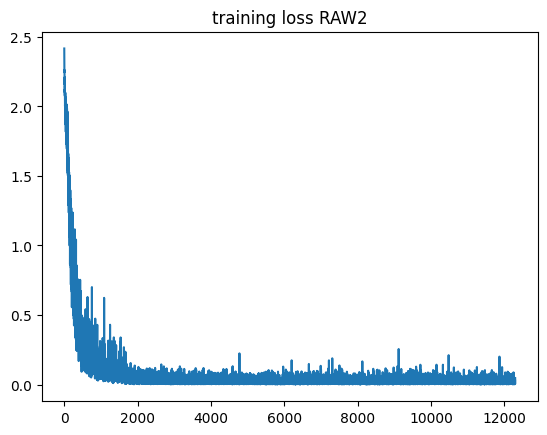

In [54]:
#RAW2 TRAINER
optimizer = optim.Adam(RAWmodel2.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
pbar_update = 1 / (len(RAWtrain_loader) + len(RAWvalid_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        RAWtrain(RAWmodel2, epoch, log_interval)
        RAWtest(RAWmodel2, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss RAW2");

In [58]:
error=0
print("test amount",len(RAWtest_set))
for i in range(len(RAWtest_set)-1) :
    if  i==2190: continue
    waveform, utterance = RAWtest_set[i]
    output = predict(waveform.to(device),RAWmodel2)
    
    if output != label_Encoder.classes_[utterance]:
        #Audio(waveform.numpy(), rate=sample_rate)
        #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
        error+=1        
else:
    # print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    #Audio(waveform.numpy(), rate=8000)
    print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")  
print("error: ",error)
print("acc: ",float(100-error/len(RAWtest_set)*100))

test amount 2763
In this case, let's just look at the last data point
Data point #2761. Expected: open vscode. Predicted: open vscode.
error:  1538
acc:  44.335866811436844


  0%|                                                                                                                                 | 0.009708737864077669/150 [00:00<1:38:17, 39.32s/it]

Train Epoch: 1 [0/10452 (0%)]	Loss: 2.394877


  0%|▏                                                                                                                                   | 0.21359223300970867/150 [00:04<52:09, 20.90s/it]

Train Epoch: 1 [2560/10452 (24%)]	Loss: 2.204322


  0%|▎                                                                                                                                 | 0.39805825242718434/150 [00:09<1:08:57, 27.65s/it]

Train Epoch: 1 [5120/10452 (49%)]	Loss: 2.177076


  0%|▌                                                                                                                                    | 0.6019417475728154/150 [00:13<57:46, 23.20s/it]

Train Epoch: 1 [7680/10452 (73%)]	Loss: 1.979590


  1%|▋                                                                                                                                    | 0.7961165048543687/150 [00:18<59:06, 23.77s/it]

Train Epoch: 1 [10240/10452 (98%)]	Loss: 2.058372


  1%|▉                                                                                                                                    | 0.9999999999999997/150 [00:23<51:56, 20.92s/it]


Validate Epoch: 1	Accuracy: 504/2613 (19%)



  1%|▉                                                                                                                                     | 1.019417475728155/150 [00:23<54:12, 21.83s/it]

Train Epoch: 2 [0/10452 (0%)]	Loss: 1.992651


  1%|█                                                                                                                                  | 1.2135922330097084/150 [00:28<1:03:18, 25.53s/it]

Train Epoch: 2 [2560/10452 (24%)]	Loss: 1.968244


  1%|█▏                                                                                                                                  | 1.398058252427184/150 [00:33<1:09:08, 27.92s/it]

Train Epoch: 2 [5120/10452 (49%)]	Loss: 1.768315


  1%|█▍                                                                                                                                 | 1.5922330097087374/150 [00:38<1:09:46, 28.21s/it]

Train Epoch: 2 [7680/10452 (73%)]	Loss: 1.797338


  1%|█▌                                                                                                                                   | 1.7961165048543684/150 [00:43<56:29, 22.87s/it]

Train Epoch: 2 [10240/10452 (98%)]	Loss: 1.733064


  1%|█▋                                                                                                                                 | 1.9902912621359217/150 [00:47<1:02:46, 25.45s/it]


Validate Epoch: 2	Accuracy: 996/2613 (38%)



  1%|█▊                                                                                                                                  | 2.019417475728155/150 [00:48<1:04:22, 26.10s/it]

Train Epoch: 3 [0/10452 (0%)]	Loss: 1.659477


  1%|█▉                                                                                                                                   | 2.2038834951456305/150 [00:52<59:20, 24.09s/it]

Train Epoch: 3 [2560/10452 (24%)]	Loss: 1.741484


  2%|██▏                                                                                                                                  | 2.4077669902912615/150 [00:57<51:18, 20.86s/it]

Train Epoch: 3 [5120/10452 (49%)]	Loss: 1.674344


  2%|██▎                                                                                                                                 | 2.592233009708737/150 [01:02<1:11:21, 29.05s/it]

Train Epoch: 3 [7680/10452 (73%)]	Loss: 1.680915


  2%|██▍                                                                                                                                   | 2.796116504854368/150 [01:06<48:32, 19.79s/it]

Train Epoch: 3 [10240/10452 (98%)]	Loss: 1.645459


  2%|██▋                                                                                                                                  | 3.0097087378640768/150 [01:11<42:25, 17.32s/it]


Validate Epoch: 3	Accuracy: 975/2613 (37%)

Train Epoch: 4 [0/10452 (0%)]	Loss: 1.543758


  2%|██▊                                                                                                                                  | 3.20388349514563/150 [01:15<1:06:30, 27.18s/it]

Train Epoch: 4 [2560/10452 (24%)]	Loss: 1.590970


  2%|██▉                                                                                                                                | 3.3980582524271834/150 [01:20<1:13:19, 30.01s/it]

Train Epoch: 4 [5120/10452 (49%)]	Loss: 1.571841


  2%|███▏                                                                                                                               | 3.5922330097087367/150 [01:24<1:08:28, 28.06s/it]

Train Epoch: 4 [7680/10452 (73%)]	Loss: 1.844509


  3%|███▎                                                                                                                                 | 3.7961165048543677/150 [01:29<50:45, 20.83s/it]

Train Epoch: 4 [10240/10452 (98%)]	Loss: 1.677810


  3%|███▌                                                                                                                                  | 4.009708737864076/150 [01:34<43:13, 17.76s/it]


Validate Epoch: 4	Accuracy: 1096/2613 (42%)

Train Epoch: 5 [0/10452 (0%)]	Loss: 1.342666


  3%|███▊                                                                                                                                  | 4.213592233009717/150 [01:39<55:51, 22.99s/it]

Train Epoch: 5 [2560/10452 (24%)]	Loss: 1.567650


  3%|███▉                                                                                                                                | 4.407766990291279/150 [01:44<1:01:29, 25.34s/it]

Train Epoch: 5 [5120/10452 (49%)]	Loss: 1.460189


  3%|████                                                                                                                                | 4.592233009708763/150 [01:48<1:10:08, 28.94s/it]

Train Epoch: 5 [7680/10452 (73%)]	Loss: 1.365246


  3%|████▎                                                                                                                                 | 4.796116504854403/150 [01:53<43:08, 17.82s/it]

Train Epoch: 5 [10240/10452 (98%)]	Loss: 1.509861


  3%|████▍                                                                                                                                 | 4.990291262135965/150 [01:57<53:37, 22.19s/it]


Validate Epoch: 5	Accuracy: 1074/2613 (41%)



  3%|████▌                                                                                                                                   | 5.0194174757282/150 [01:58<46:27, 19.23s/it]

Train Epoch: 6 [0/10452 (0%)]	Loss: 1.665217


  3%|████▋                                                                                                                                 | 5.203883495145684/150 [02:02<52:35, 21.79s/it]

Train Epoch: 6 [2560/10452 (24%)]	Loss: 1.470738


  4%|████▊                                                                                                                                 | 5.398058252427246/150 [02:06<54:59, 22.82s/it]

Train Epoch: 6 [5120/10452 (49%)]	Loss: 1.330581


  4%|████▉                                                                                                                                 | 5.592233009708808/150 [02:11<54:50, 22.78s/it]

Train Epoch: 6 [7680/10452 (73%)]	Loss: 1.365790


  4%|█████▏                                                                                                                               | 5.7961165048544485/150 [02:15<48:46, 20.29s/it]

Train Epoch: 6 [10240/10452 (98%)]	Loss: 1.409952


  4%|█████▎                                                                                                                                | 5.990291262136011/150 [02:19<45:34, 18.99s/it]


Validate Epoch: 6	Accuracy: 1090/2613 (42%)



  4%|█████▍                                                                                                                                | 6.019417475728245/150 [02:20<47:48, 19.92s/it]

Train Epoch: 7 [0/10452 (0%)]	Loss: 1.354852


  4%|█████▍                                                                                                                              | 6.213592233009807/150 [02:24<1:00:07, 25.09s/it]

Train Epoch: 7 [2560/10452 (24%)]	Loss: 1.572800


  4%|█████▋                                                                                                                                | 6.407766990291369/150 [02:28<48:46, 20.38s/it]

Train Epoch: 7 [5120/10452 (49%)]	Loss: 1.603487


  4%|█████▉                                                                                                                                | 6.601941747572932/150 [02:33<52:45, 22.07s/it]

Train Epoch: 7 [7680/10452 (73%)]	Loss: 1.475436


  5%|██████                                                                                                                                | 6.796116504854494/150 [02:37<44:58, 18.84s/it]

Train Epoch: 7 [10240/10452 (98%)]	Loss: 1.267741


  5%|██████▏                                                                                                                               | 6.990291262136056/150 [02:41<47:56, 20.11s/it]


Validate Epoch: 7	Accuracy: 1300/2613 (50%)

Train Epoch: 8 [0/10452 (0%)]	Loss: 1.138130


  5%|██████▍                                                                                                                              | 7.2135922330098525/150 [02:46<59:41, 25.08s/it]

Train Epoch: 8 [2560/10452 (24%)]	Loss: 1.104327


  5%|██████▌                                                                                                                               | 7.398058252427337/150 [02:50<50:25, 21.22s/it]

Train Epoch: 8 [5120/10452 (49%)]	Loss: 1.210629


  5%|██████▊                                                                                                                               | 7.592233009708899/150 [02:55<52:12, 21.99s/it]

Train Epoch: 8 [7680/10452 (73%)]	Loss: 1.398830


  5%|██████▉                                                                                                                               | 7.796116504854539/150 [02:59<46:23, 19.57s/it]

Train Epoch: 8 [10240/10452 (98%)]	Loss: 1.286025


  5%|███████▏                                                                                                                              | 7.990291262136101/150 [03:04<53:03, 22.42s/it]


Validate Epoch: 8	Accuracy: 1123/2613 (43%)



  5%|███████▏                                                                                                                              | 8.009708737864257/150 [03:04<49:35, 20.96s/it]

Train Epoch: 9 [0/10452 (0%)]	Loss: 1.483033


  5%|███████▎                                                                                                                              | 8.213592233009878/150 [03:09<50:53, 21.54s/it]

Train Epoch: 9 [2560/10452 (24%)]	Loss: 1.033477


  6%|███████▌                                                                                                                              | 8.398058252427345/150 [03:13<52:16, 22.15s/it]

Train Epoch: 9 [5120/10452 (49%)]	Loss: 1.192708


  6%|███████▌                                                                                                                             | 8.59223300970889/150 [03:18<1:08:55, 29.24s/it]

Train Epoch: 9 [7680/10452 (73%)]	Loss: 1.107058


  6%|███████▊                                                                                                                              | 8.796116504854512/150 [03:22<43:06, 18.31s/it]

Train Epoch: 9 [10240/10452 (98%)]	Loss: 1.140439


  6%|████████                                                                                                                               | 9.00970873786421/150 [03:27<50:37, 21.55s/it]


Validate Epoch: 9	Accuracy: 1389/2613 (53%)

Train Epoch: 10 [0/10452 (0%)]	Loss: 1.008704


  6%|████████▏                                                                                                                             | 9.213592233009832/150 [03:31<50:48, 21.65s/it]

Train Epoch: 10 [2560/10452 (24%)]	Loss: 1.080778


  6%|████████▌                                                                                                                               | 9.3980582524273/150 [03:36<49:14, 21.01s/it]

Train Epoch: 10 [5120/10452 (49%)]	Loss: 1.371697


  6%|████████▌                                                                                                                             | 9.592233009708844/150 [03:40<47:05, 20.13s/it]

Train Epoch: 10 [7680/10452 (73%)]	Loss: 1.060503


  7%|████████▊                                                                                                                             | 9.796116504854465/150 [03:45<42:52, 18.35s/it]

Train Epoch: 10 [10240/10452 (98%)]	Loss: 1.464064


  7%|████████▉                                                                                                                              | 9.99029126213601/150 [03:49<51:34, 22.10s/it]


Validate Epoch: 10	Accuracy: 1590/2613 (61%)

Train Epoch: 11 [0/10452 (0%)]	Loss: 1.170947


  7%|█████████                                                                                                                            | 10.203883495145709/150 [03:54<46:27, 19.94s/it]

Train Epoch: 11 [2560/10452 (24%)]	Loss: 1.244021


  7%|█████████                                                                                                                          | 10.398058252427253/150 [03:58<1:10:40, 30.38s/it]

Train Epoch: 11 [5120/10452 (49%)]	Loss: 1.218868


  7%|█████████▍                                                                                                                           | 10.601941747572875/150 [04:03<49:47, 21.43s/it]

Train Epoch: 11 [7680/10452 (73%)]	Loss: 0.991392


  7%|█████████▋                                                                                                                            | 10.79611650485442/150 [04:07<52:25, 22.60s/it]

Train Epoch: 11 [10240/10452 (98%)]	Loss: 0.972404


  7%|█████████▊                                                                                                                           | 11.009708737864118/150 [04:12<38:26, 16.60s/it]


Validate Epoch: 11	Accuracy: 1535/2613 (59%)

Train Epoch: 12 [0/10452 (0%)]	Loss: 1.244057


  7%|█████████▉                                                                                                                           | 11.203883495145663/150 [04:16<46:24, 20.06s/it]

Train Epoch: 12 [2560/10452 (24%)]	Loss: 0.973562


  8%|██████████                                                                                                                           | 11.398058252427207/150 [04:20<54:30, 23.60s/it]

Train Epoch: 12 [5120/10452 (49%)]	Loss: 1.228755


  8%|██████████▎                                                                                                                          | 11.601941747572829/150 [04:25<52:19, 22.69s/it]

Train Epoch: 12 [7680/10452 (73%)]	Loss: 1.247964


  8%|██████████▍                                                                                                                          | 11.796116504854373/150 [04:30<43:21, 18.83s/it]

Train Epoch: 12 [10240/10452 (98%)]	Loss: 0.958435


  8%|██████████▋                                                                                                                          | 11.990291262135917/150 [04:34<52:36, 22.87s/it]


Validate Epoch: 12	Accuracy: 1201/2613 (46%)



  8%|██████████▋                                                                                                                          | 12.009708737864072/150 [04:35<46:24, 20.18s/it]

Train Epoch: 13 [0/10452 (0%)]	Loss: 1.070817


  8%|██████████▊                                                                                                                          | 12.213592233009694/150 [04:39<48:03, 20.93s/it]

Train Epoch: 13 [2560/10452 (24%)]	Loss: 1.033306


  8%|██████████▉                                                                                                                         | 12.39805825242716/150 [04:44<1:07:52, 29.59s/it]

Train Epoch: 13 [5120/10452 (49%)]	Loss: 0.860887


  8%|██████████▉                                                                                                                        | 12.592233009708705/150 [04:48<1:01:50, 27.01s/it]

Train Epoch: 13 [7680/10452 (73%)]	Loss: 0.942811


  9%|███████████▎                                                                                                                         | 12.796116504854327/150 [04:53<45:55, 20.08s/it]

Train Epoch: 13 [10240/10452 (98%)]	Loss: 1.224459


  9%|███████████▌                                                                                                                         | 12.999999999999948/150 [04:57<46:47, 20.49s/it]


Validate Epoch: 13	Accuracy: 1268/2613 (49%)



  9%|███████████▌                                                                                                                         | 13.019417475728103/150 [04:58<54:19, 23.79s/it]

Train Epoch: 14 [0/10452 (0%)]	Loss: 1.184716


  9%|███████████▋                                                                                                                         | 13.213592233009647/150 [05:02<49:07, 21.55s/it]

Train Epoch: 14 [2560/10452 (24%)]	Loss: 1.052179


  9%|███████████▉                                                                                                                         | 13.407766990291192/150 [05:07<55:07, 24.21s/it]

Train Epoch: 14 [5120/10452 (49%)]	Loss: 0.910569


  9%|████████████                                                                                                                         | 13.601941747572736/150 [05:11<53:19, 23.46s/it]

Train Epoch: 14 [7680/10452 (73%)]	Loss: 1.171687


  9%|████████████▎                                                                                                                         | 13.79611650485428/150 [05:15<44:32, 19.62s/it]

Train Epoch: 14 [10240/10452 (98%)]	Loss: 1.016285


  9%|████████████▍                                                                                                                        | 13.990291262135825/150 [05:19<50:06, 22.11s/it]


Validate Epoch: 14	Accuracy: 1665/2613 (64%)



  9%|████████████▌                                                                                                                         | 14.00970873786398/150 [05:20<53:59, 23.82s/it]

Train Epoch: 15 [0/10452 (0%)]	Loss: 1.204116


  9%|████████████▌                                                                                                                        | 14.213592233009601/150 [05:24<49:14, 21.76s/it]

Train Epoch: 15 [2560/10452 (24%)]	Loss: 0.995977


 10%|████████████▊                                                                                                                        | 14.398058252427068/150 [05:28<46:58, 20.78s/it]

Train Epoch: 15 [5120/10452 (49%)]	Loss: 1.063261


 10%|████████████▋                                                                                                                      | 14.592233009708613/150 [05:33<1:07:49, 30.05s/it]

Train Epoch: 15 [7680/10452 (73%)]	Loss: 1.230835


 10%|█████████████                                                                                                                        | 14.796116504854234/150 [05:38<50:36, 22.46s/it]

Train Epoch: 15 [10240/10452 (98%)]	Loss: 0.891282


 10%|█████████████▎                                                                                                                       | 14.990291262135779/150 [05:42<49:05, 21.82s/it]


Validate Epoch: 15	Accuracy: 1819/2613 (70%)



 10%|█████████████▎                                                                                                                       | 15.009708737863933/150 [05:42<46:53, 20.85s/it]

Train Epoch: 16 [0/10452 (0%)]	Loss: 0.783840


 10%|█████████████▎                                                                                                                     | 15.203883495145478/150 [05:47<1:00:27, 26.91s/it]

Train Epoch: 16 [2560/10452 (24%)]	Loss: 0.792703


 10%|█████████████▍                                                                                                                     | 15.398058252427022/150 [05:52<1:06:06, 29.47s/it]

Train Epoch: 16 [5120/10452 (49%)]	Loss: 1.108350


 10%|█████████████▊                                                                                                                       | 15.592233009708567/150 [05:56<52:46, 23.56s/it]

Train Epoch: 16 [7680/10452 (73%)]	Loss: 0.897872


 11%|██████████████                                                                                                                       | 15.796116504854188/150 [06:01<53:42, 24.01s/it]

Train Epoch: 16 [10240/10452 (98%)]	Loss: 0.807632


 11%|██████████████▏                                                                                                                      | 15.990291262135733/150 [06:06<49:42, 22.26s/it]


Validate Epoch: 16	Accuracy: 1862/2613 (71%)



 11%|██████████████▏                                                                                                                      | 16.019417475727966/150 [06:06<44:18, 19.84s/it]

Train Epoch: 17 [0/10452 (0%)]	Loss: 0.712251


 11%|██████████████▍                                                                                                                       | 16.21359223300951/150 [06:10<45:38, 20.47s/it]

Train Epoch: 17 [2560/10452 (24%)]	Loss: 0.852389


 11%|██████████████▌                                                                                                                      | 16.407766990291055/150 [06:15<55:59, 25.15s/it]

Train Epoch: 17 [5120/10452 (49%)]	Loss: 1.241508


 11%|██████████████▋                                                                                                                      | 16.592233009708522/150 [06:20<47:22, 21.30s/it]

Train Epoch: 17 [7680/10452 (73%)]	Loss: 0.774770


 11%|██████████████▉                                                                                                                      | 16.796116504854144/150 [06:24<41:15, 18.58s/it]

Train Epoch: 17 [10240/10452 (98%)]	Loss: 1.068644


 11%|███████████████▏                                                                                                                      | 16.99029126213569/150 [06:28<48:54, 22.06s/it]


Validate Epoch: 17	Accuracy: 1725/2613 (66%)



 11%|███████████████                                                                                                                      | 17.009708737863843/150 [06:29<48:48, 22.02s/it]

Train Epoch: 18 [0/10452 (0%)]	Loss: 0.722839


 11%|███████████████▎                                                                                                                     | 17.213592233009464/150 [06:33<45:34, 20.60s/it]

Train Epoch: 18 [2560/10452 (24%)]	Loss: 0.972585


 12%|███████████████▎                                                                                                                    | 17.39805825242693/150 [06:38<1:02:23, 28.23s/it]

Train Epoch: 18 [5120/10452 (49%)]	Loss: 0.771960


 12%|███████████████▌                                                                                                                     | 17.601941747572553/150 [06:43<52:13, 23.67s/it]

Train Epoch: 18 [7680/10452 (73%)]	Loss: 0.775618


 12%|███████████████▊                                                                                                                     | 17.796116504854098/150 [06:47<44:33, 20.22s/it]

Train Epoch: 18 [10240/10452 (98%)]	Loss: 1.002203


 12%|████████████████                                                                                                                      | 17.99999999999972/150 [06:52<47:36, 21.64s/it]


Validate Epoch: 18	Accuracy: 1908/2613 (73%)



 12%|███████████████▉                                                                                                                     | 18.009708737863797/150 [06:52<58:51, 26.76s/it]

Train Epoch: 19 [0/10452 (0%)]	Loss: 0.991237


 12%|████████████████                                                                                                                    | 18.20388349514534/150 [06:57<1:01:04, 27.80s/it]

Train Epoch: 19 [2560/10452 (24%)]	Loss: 0.812622


 12%|████████████████▎                                                                                                                    | 18.398058252426885/150 [07:01<50:05, 22.84s/it]

Train Epoch: 19 [5120/10452 (49%)]	Loss: 0.691413


 12%|████████████████▎                                                                                                                   | 18.59223300970843/150 [07:06<1:01:44, 28.19s/it]

Train Epoch: 19 [7680/10452 (73%)]	Loss: 0.888306


 13%|████████████████▊                                                                                                                     | 18.79611650485405/150 [07:11<51:22, 23.49s/it]

Train Epoch: 19 [10240/10452 (98%)]	Loss: 0.790420


 13%|████████████████▊                                                                                                                    | 18.990291262135596/150 [07:16<56:56, 26.08s/it]


Validate Epoch: 19	Accuracy: 1909/2613 (73%)



 13%|████████████████▉                                                                                                                     | 19.00970873786375/150 [07:17<48:48, 22.36s/it]

Train Epoch: 20 [0/10452 (0%)]	Loss: 0.715944


 13%|█████████████████                                                                                                                    | 19.203883495145295/150 [07:21<53:27, 24.52s/it]

Train Epoch: 20 [2560/10452 (24%)]	Loss: 0.787599


 13%|█████████████████                                                                                                                   | 19.39805825242684/150 [07:26<1:01:22, 28.19s/it]

Train Epoch: 20 [5120/10452 (49%)]	Loss: 1.268831


 13%|█████████████████▎                                                                                                                   | 19.592233009708384/150 [07:31<47:26, 21.83s/it]

Train Epoch: 20 [7680/10452 (73%)]	Loss: 0.592867


 13%|█████████████████▌                                                                                                                   | 19.796116504854005/150 [07:36<51:40, 23.81s/it]

Train Epoch: 20 [10240/10452 (98%)]	Loss: 0.843401


 13%|█████████████████▋                                                                                                                   | 19.999999999999627/150 [07:41<40:54, 18.88s/it]


Validate Epoch: 20	Accuracy: 1983/2613 (76%)



 13%|█████████████████▋                                                                                                                   | 20.009708737863704/150 [07:41<47:27, 21.90s/it]

Train Epoch: 21 [0/10452 (0%)]	Loss: 0.917808


 13%|██████████████████                                                                                                                    | 20.20388349514525/150 [07:46<57:28, 26.57s/it]

Train Epoch: 21 [2560/10452 (24%)]	Loss: 0.759162


 14%|██████████████████                                                                                                                   | 20.398058252426793/150 [07:51<53:03, 24.56s/it]

Train Epoch: 21 [5120/10452 (49%)]	Loss: 0.902979


 14%|█████████████████▉                                                                                                                 | 20.592233009708337/150 [07:55<1:01:49, 28.67s/it]

Train Epoch: 21 [7680/10452 (73%)]	Loss: 0.628394


 14%|██████████████████▌                                                                                                                   | 20.79611650485396/150 [08:00<47:26, 22.03s/it]

Train Epoch: 21 [10240/10452 (98%)]	Loss: 0.708541


 14%|██████████████████▌                                                                                                                  | 20.990291262135504/150 [08:05<54:30, 25.35s/it]


Validate Epoch: 21	Accuracy: 2046/2613 (78%)



 14%|██████████████████▋                                                                                                                  | 21.019417475727735/150 [08:05<44:07, 20.53s/it]

Train Epoch: 22 [0/10452 (0%)]	Loss: 0.622644


 14%|██████████████████▌                                                                                                                | 21.203883495145202/150 [08:10<1:05:25, 30.48s/it]

Train Epoch: 22 [2560/10452 (24%)]	Loss: 0.747714


 14%|██████████████████▉                                                                                                                  | 21.398058252426747/150 [08:15<44:20, 20.69s/it]

Train Epoch: 22 [5120/10452 (49%)]	Loss: 1.239086


 14%|███████████████████▎                                                                                                                  | 21.60194174757237/150 [08:20<56:07, 26.23s/it]

Train Epoch: 22 [7680/10452 (73%)]	Loss: 0.718074


 15%|███████████████████▎                                                                                                                 | 21.796116504853913/150 [08:24<37:20, 17.48s/it]

Train Epoch: 22 [10240/10452 (98%)]	Loss: 0.543130


 15%|███████████████████▌                                                                                                                 | 21.999999999999535/150 [08:29<47:19, 22.18s/it]


Validate Epoch: 22	Accuracy: 2176/2613 (83%)



 15%|███████████████████▋                                                                                                                  | 22.01941747572769/150 [08:29<53:33, 25.11s/it]

Train Epoch: 23 [0/10452 (0%)]	Loss: 1.094783


 15%|███████████████████▋                                                                                                                 | 22.213592233009233/150 [08:33<43:56, 20.63s/it]

Train Epoch: 23 [2560/10452 (24%)]	Loss: 0.674547


 15%|███████████████████▊                                                                                                                 | 22.407766990290778/150 [08:38<51:48, 24.37s/it]

Train Epoch: 23 [5120/10452 (49%)]	Loss: 0.785303


 15%|████████████████████                                                                                                                 | 22.601941747572322/150 [08:43<55:35, 26.18s/it]

Train Epoch: 23 [7680/10452 (73%)]	Loss: 0.796038


 15%|████████████████████▏                                                                                                                | 22.796116504853867/150 [08:47<39:03, 18.42s/it]

Train Epoch: 23 [10240/10452 (98%)]	Loss: 0.647162


 15%|████████████████████▌                                                                                                                 | 22.99999999999949/150 [08:52<48:56, 23.12s/it]


Validate Epoch: 23	Accuracy: 2143/2613 (82%)



 15%|████████████████████▍                                                                                                                | 23.019417475727643/150 [08:52<51:08, 24.17s/it]

Train Epoch: 24 [0/10452 (0%)]	Loss: 0.475017


 15%|████████████████████▋                                                                                                                 | 23.20388349514511/150 [08:56<54:53, 25.97s/it]

Train Epoch: 24 [2560/10452 (24%)]	Loss: 0.591085


 16%|████████████████████▋                                                                                                                | 23.398058252426654/150 [09:01<57:01, 27.02s/it]

Train Epoch: 24 [5120/10452 (49%)]	Loss: 0.690576


 16%|█████████████████████▏                                                                                                                 | 23.5922330097082/150 [09:06<57:55, 27.49s/it]

Train Epoch: 24 [7680/10452 (73%)]	Loss: 0.607728


 16%|█████████████████████▎                                                                                                                | 23.79611650485382/150 [09:11<35:47, 17.01s/it]

Train Epoch: 24 [10240/10452 (98%)]	Loss: 0.679555


 16%|█████████████████████▎                                                                                                               | 23.990291262135365/150 [09:15<51:59, 24.75s/it]


Validate Epoch: 24	Accuracy: 2143/2613 (82%)



 16%|█████████████████████▍                                                                                                                | 24.00970873786352/150 [09:16<47:53, 22.81s/it]

Train Epoch: 25 [0/10452 (0%)]	Loss: 0.557128


 16%|█████████████████████▋                                                                                                                | 24.21359223300914/150 [09:21<45:34, 21.74s/it]

Train Epoch: 25 [2560/10452 (24%)]	Loss: 0.674116


 16%|█████████████████████▊                                                                                                                | 24.39805825242661/150 [09:25<49:07, 23.46s/it]

Train Epoch: 25 [5120/10452 (49%)]	Loss: 0.733711


 16%|█████████████████████▍                                                                                                             | 24.592233009708153/150 [09:30<1:03:11, 30.23s/it]

Train Epoch: 25 [7680/10452 (73%)]	Loss: 0.691285


 17%|█████████████████████▉                                                                                                               | 24.796116504853774/150 [09:35<47:13, 22.63s/it]

Train Epoch: 25 [10240/10452 (98%)]	Loss: 0.639147


 17%|██████████████████████▏                                                                                                              | 24.999999999999396/150 [09:40<40:41, 19.53s/it]


Validate Epoch: 25	Accuracy: 2095/2613 (80%)



 17%|██████████████████████▏                                                                                                              | 25.009708737863473/150 [09:40<46:34, 22.36s/it]

Train Epoch: 26 [0/10452 (0%)]	Loss: 0.695107


 17%|██████████████████████▎                                                                                                              | 25.203883495145018/150 [09:45<55:29, 26.68s/it]

Train Epoch: 26 [2560/10452 (24%)]	Loss: 0.643151


 17%|██████████████████████▋                                                                                                               | 25.40776699029064/150 [09:50<51:04, 24.59s/it]

Train Epoch: 26 [5120/10452 (49%)]	Loss: 0.809270


 17%|██████████████████████▋                                                                                                              | 25.601941747572184/150 [09:54<42:34, 20.54s/it]

Train Epoch: 26 [7680/10452 (73%)]	Loss: 0.570728


 17%|██████████████████████▊                                                                                                              | 25.796116504853728/150 [09:59<48:45, 23.56s/it]

Train Epoch: 26 [10240/10452 (98%)]	Loss: 0.807633


 17%|███████████████████████                                                                                                              | 25.990291262135273/150 [10:04<46:23, 22.45s/it]


Validate Epoch: 26	Accuracy: 2205/2613 (84%)



 17%|███████████████████████                                                                                                              | 26.009708737863427/150 [10:04<44:04, 21.33s/it]

Train Epoch: 27 [0/10452 (0%)]	Loss: 0.738573


 17%|███████████████████████▍                                                                                                              | 26.21359223300905/150 [10:09<41:55, 20.32s/it]

Train Epoch: 27 [2560/10452 (24%)]	Loss: 0.642140


 18%|███████████████████████▍                                                                                                             | 26.398058252426516/150 [10:13<58:56, 28.61s/it]

Train Epoch: 27 [5120/10452 (49%)]	Loss: 0.579642


 18%|███████████████████████▊                                                                                                              | 26.59223300970806/150 [10:18<55:33, 27.01s/it]

Train Epoch: 27 [7680/10452 (73%)]	Loss: 0.521481


 18%|███████████████████████▊                                                                                                             | 26.796116504853682/150 [10:23<50:04, 24.39s/it]

Train Epoch: 27 [10240/10452 (98%)]	Loss: 0.779141


 18%|███████████████████████▉                                                                                                             | 26.990291262135226/150 [10:28<50:34, 24.67s/it]


Validate Epoch: 27	Accuracy: 2211/2613 (85%)



 18%|████████████████████████▏                                                                                                             | 27.00970873786338/150 [10:28<44:42, 21.81s/it]

Train Epoch: 28 [0/10452 (0%)]	Loss: 0.761741


 18%|████████████████████████▏                                                                                                            | 27.213592233009003/150 [10:33<41:52, 20.46s/it]

Train Epoch: 28 [2560/10452 (24%)]	Loss: 0.876808


 18%|████████████████████████▍                                                                                                             | 27.39805825242647/150 [10:37<53:56, 26.40s/it]

Train Epoch: 28 [5120/10452 (49%)]	Loss: 0.726229


 18%|████████████████████████▋                                                                                                             | 27.60194174757209/150 [10:43<54:49, 26.88s/it]

Train Epoch: 28 [7680/10452 (73%)]	Loss: 0.908386


 19%|████████████████████████▋                                                                                                            | 27.796116504853636/150 [10:47<47:21, 23.25s/it]

Train Epoch: 28 [10240/10452 (98%)]	Loss: 0.505633


 19%|████████████████████████▊                                                                                                            | 27.999999999999257/150 [10:52<43:21, 21.32s/it]


Validate Epoch: 28	Accuracy: 1994/2613 (76%)



 19%|████████████████████████▊                                                                                                            | 28.019417475727412/150 [10:53<49:25, 24.31s/it]

Train Epoch: 29 [0/10452 (0%)]	Loss: 0.520348


 19%|█████████████████████████▏                                                                                                            | 28.20388349514488/150 [10:57<50:02, 24.66s/it]

Train Epoch: 29 [2560/10452 (24%)]	Loss: 0.782873


 19%|█████████████████████████▏                                                                                                           | 28.398058252426424/150 [11:02<56:58, 28.11s/it]

Train Epoch: 29 [5120/10452 (49%)]	Loss: 0.687990


 19%|█████████████████████████▎                                                                                                           | 28.592233009707968/150 [11:07<58:24, 28.87s/it]

Train Epoch: 29 [7680/10452 (73%)]	Loss: 0.538580


 19%|█████████████████████████▋                                                                                                            | 28.79611650485359/150 [11:12<48:29, 24.01s/it]

Train Epoch: 29 [10240/10452 (98%)]	Loss: 0.602473


 19%|█████████████████████████▋                                                                                                           | 28.990291262135134/150 [11:17<48:08, 23.87s/it]


Validate Epoch: 29	Accuracy: 2184/2613 (84%)



 19%|█████████████████████████▉                                                                                                            | 29.00970873786329/150 [11:17<50:05, 24.84s/it]

Train Epoch: 30 [0/10452 (0%)]	Loss: 0.742119


 19%|██████████████████████████                                                                                                            | 29.21359223300891/150 [11:21<43:07, 21.42s/it]

Train Epoch: 30 [2560/10452 (24%)]	Loss: 0.449062


 20%|██████████████████████████                                                                                                           | 29.398058252426377/150 [11:26<54:16, 27.00s/it]

Train Epoch: 30 [5120/10452 (49%)]	Loss: 0.704882


 20%|██████████████████████████▏                                                                                                          | 29.592233009707922/150 [11:31<43:05, 21.47s/it]

Train Epoch: 30 [7680/10452 (73%)]	Loss: 0.599852


 20%|██████████████████████████▍                                                                                                          | 29.796116504853543/150 [11:36<51:14, 25.58s/it]

Train Epoch: 30 [10240/10452 (98%)]	Loss: 0.651973


 20%|██████████████████████████▌                                                                                                          | 29.990291262135088/150 [11:40<45:36, 22.80s/it]


Validate Epoch: 30	Accuracy: 2189/2613 (84%)



 20%|██████████████████████████▌                                                                                                          | 30.009708737863242/150 [11:41<43:07, 21.57s/it]

Train Epoch: 31 [0/10452 (0%)]	Loss: 0.762247


 20%|██████████████████████████▊                                                                                                          | 30.203883495144787/150 [11:45<41:59, 21.03s/it]

Train Epoch: 31 [2560/10452 (24%)]	Loss: 0.588610


 20%|███████████████████████████▏                                                                                                          | 30.39805825242633/150 [11:50<53:22, 26.77s/it]

Train Epoch: 31 [5120/10452 (49%)]	Loss: 0.623952


 20%|███████████████████████████▏                                                                                                         | 30.592233009707876/150 [11:55<54:00, 27.14s/it]

Train Epoch: 31 [7680/10452 (73%)]	Loss: 0.600439


 21%|███████████████████████████▎                                                                                                         | 30.796116504853497/150 [11:59<36:41, 18.47s/it]

Train Epoch: 31 [10240/10452 (98%)]	Loss: 0.626407


 21%|███████████████████████████▋                                                                                                          | 30.99999999999912/150 [12:04<43:25, 21.90s/it]


Validate Epoch: 31	Accuracy: 2173/2613 (83%)



 21%|███████████████████████████▍                                                                                                         | 31.009708737863196/150 [12:04<52:12, 26.32s/it]

Train Epoch: 32 [0/10452 (0%)]	Loss: 0.659796


 21%|███████████████████████████▉                                                                                                          | 31.20388349514474/150 [12:08<43:43, 22.09s/it]

Train Epoch: 32 [2560/10452 (24%)]	Loss: 0.645130


 21%|███████████████████████████▊                                                                                                         | 31.398058252426285/150 [12:13<55:06, 27.88s/it]

Train Epoch: 32 [5120/10452 (49%)]	Loss: 0.477596


 21%|████████████████████████████                                                                                                         | 31.601941747571907/150 [12:18<38:40, 19.60s/it]

Train Epoch: 32 [7680/10452 (73%)]	Loss: 0.610482


 21%|████████████████████████████▍                                                                                                         | 31.79611650485345/150 [12:22<36:39, 18.61s/it]

Train Epoch: 32 [10240/10452 (98%)]	Loss: 0.785207


 21%|████████████████████████████▎                                                                                                        | 31.990291262134996/150 [12:26<44:54, 22.84s/it]


Validate Epoch: 32	Accuracy: 2196/2613 (84%)



 21%|████████████████████████████▌                                                                                                         | 32.00970873786315/150 [12:27<41:16, 20.99s/it]

Train Epoch: 33 [0/10452 (0%)]	Loss: 0.614913


 21%|████████████████████████████▌                                                                                                        | 32.213592233008846/150 [12:32<38:17, 19.50s/it]

Train Epoch: 33 [2560/10452 (24%)]	Loss: 0.502135


 22%|████████████████████████████▉                                                                                                         | 32.40776699029046/150 [12:36<44:38, 22.78s/it]

Train Epoch: 33 [5120/10452 (49%)]	Loss: 0.708637


 22%|█████████████████████████████                                                                                                         | 32.60194174757208/150 [12:41<46:54, 23.98s/it]

Train Epoch: 33 [7680/10452 (73%)]	Loss: 0.650381


 22%|█████████████████████████████▎                                                                                                        | 32.79611650485369/150 [12:45<35:02, 17.94s/it]

Train Epoch: 33 [10240/10452 (98%)]	Loss: 0.688671


 22%|█████████████████████████████▍                                                                                                        | 32.99029126213531/150 [12:50<42:07, 21.60s/it]


Validate Epoch: 33	Accuracy: 2159/2613 (83%)



 22%|█████████████████████████████▍                                                                                                        | 33.00970873786347/150 [12:50<38:39, 19.83s/it]

Train Epoch: 34 [0/10452 (0%)]	Loss: 0.632540


 22%|█████████████████████████████▍                                                                                                       | 33.203883495145085/150 [12:54<39:21, 20.22s/it]

Train Epoch: 34 [2560/10452 (24%)]	Loss: 0.592322


 22%|█████████████████████████████▊                                                                                                        | 33.40776699029078/150 [12:59<52:56, 27.24s/it]

Train Epoch: 34 [5120/10452 (49%)]	Loss: 0.906005


 22%|█████████████████████████████▊                                                                                                       | 33.592233009708316/150 [13:03<41:51, 21.57s/it]

Train Epoch: 34 [7680/10452 (73%)]	Loss: 0.762555


 23%|██████████████████████████████▏                                                                                                       | 33.79611650485401/150 [13:08<47:54, 24.73s/it]

Train Epoch: 34 [10240/10452 (98%)]	Loss: 0.629340


 23%|██████████████████████████████▎                                                                                                       | 33.99999999999971/150 [13:13<38:52, 20.11s/it]


Validate Epoch: 34	Accuracy: 2148/2613 (82%)



 23%|██████████████████████████████▍                                                                                                       | 34.01941747572787/150 [13:13<40:49, 21.12s/it]

Train Epoch: 35 [0/10452 (0%)]	Loss: 0.738099


 23%|██████████████████████████████▎                                                                                                      | 34.203883495145405/150 [13:18<52:12, 27.05s/it]

Train Epoch: 35 [2560/10452 (24%)]	Loss: 0.554995


 23%|██████████████████████████████▉                                                                                                        | 34.4077669902911/150 [13:23<41:04, 21.32s/it]

Train Epoch: 35 [5120/10452 (49%)]	Loss: 0.874305


 23%|██████████████████████████████▋                                                                                                      | 34.592233009708636/150 [13:28<53:46, 27.96s/it]

Train Epoch: 35 [7680/10452 (73%)]	Loss: 0.687095


 23%|███████████████████████████████                                                                                                       | 34.79611650485433/150 [13:32<35:53, 18.69s/it]

Train Epoch: 35 [10240/10452 (98%)]	Loss: 0.725852


 23%|███████████████████████████████▎                                                                                                      | 35.00000000000003/150 [13:37<44:32, 23.24s/it]


Validate Epoch: 35	Accuracy: 2156/2613 (83%)



 23%|███████████████████████████████▎                                                                                                      | 35.00970873786411/150 [13:37<53:32, 27.94s/it]

Train Epoch: 36 [0/10452 (0%)]	Loss: 0.700214


 23%|███████████████████████████████▏                                                                                                     | 35.213592233009805/150 [13:42<46:19, 24.22s/it]

Train Epoch: 36 [2560/10452 (24%)]	Loss: 0.391572


 24%|███████████████████████████████▌                                                                                                      | 35.39805825242734/150 [13:46<54:35, 28.58s/it]

Train Epoch: 36 [5120/10452 (49%)]	Loss: 0.835291


 24%|███████████████████████████████▌                                                                                                     | 35.592233009708956/150 [13:51<40:51, 21.43s/it]

Train Epoch: 36 [7680/10452 (73%)]	Loss: 1.101538


 24%|███████████████████████████████▉                                                                                                      | 35.79611650485465/150 [13:56<36:29, 19.17s/it]

Train Epoch: 36 [10240/10452 (98%)]	Loss: 0.541225


 24%|████████████████████████████████▏                                                                                                     | 35.99029126213627/150 [14:00<43:24, 22.85s/it]


Validate Epoch: 36	Accuracy: 2177/2613 (83%)



 24%|████████████████████████████████▏                                                                                                     | 36.01941747572851/150 [14:00<37:41, 19.84s/it]

Train Epoch: 37 [0/10452 (0%)]	Loss: 0.912870


 24%|████████████████████████████████                                                                                                     | 36.203883495146044/150 [14:05<47:27, 25.02s/it]

Train Epoch: 37 [2560/10452 (24%)]	Loss: 0.793896


 24%|████████████████████████████████▌                                                                                                     | 36.40776699029174/150 [14:10<44:38, 23.58s/it]

Train Epoch: 37 [5120/10452 (49%)]	Loss: 0.761464


 24%|████████████████████████████████▍                                                                                                    | 36.592233009709275/150 [14:14<45:27, 24.05s/it]

Train Epoch: 37 [7680/10452 (73%)]	Loss: 0.659726


 25%|████████████████████████████████▊                                                                                                     | 36.79611650485497/150 [14:19<44:22, 23.52s/it]

Train Epoch: 37 [10240/10452 (98%)]	Loss: 0.602980


 25%|█████████████████████████████████                                                                                                     | 36.99029126213659/150 [14:24<42:04, 22.34s/it]


Validate Epoch: 37	Accuracy: 2162/2613 (83%)



 25%|█████████████████████████████████                                                                                                     | 37.00970873786475/150 [14:24<37:35, 19.97s/it]

Train Epoch: 38 [0/10452 (0%)]	Loss: 0.609341


 25%|████████████████████████████████▉                                                                                                    | 37.213592233010445/150 [14:29<45:53, 24.41s/it]

Train Epoch: 38 [2560/10452 (24%)]	Loss: 0.475522


 25%|█████████████████████████████████▍                                                                                                    | 37.39805825242798/150 [14:33<37:21, 19.91s/it]

Train Epoch: 38 [5120/10452 (49%)]	Loss: 0.631522


 25%|█████████████████████████████████▎                                                                                                   | 37.601941747573676/150 [14:38<46:21, 24.74s/it]

Train Epoch: 38 [7680/10452 (73%)]	Loss: 0.659318


 25%|█████████████████████████████████▊                                                                                                    | 37.79611650485529/150 [14:43<33:43, 18.03s/it]

Train Epoch: 38 [10240/10452 (98%)]	Loss: 0.539146


 25%|█████████████████████████████████▉                                                                                                    | 38.00000000000099/150 [14:47<41:34, 22.27s/it]


Validate Epoch: 38	Accuracy: 2187/2613 (84%)



 25%|█████████████████████████████████▉                                                                                                    | 38.00970873786507/150 [14:48<48:31, 26.00s/it]

Train Epoch: 39 [0/10452 (0%)]	Loss: 0.594979


 25%|█████████████████████████████████▊                                                                                                   | 38.203883495146684/150 [14:52<41:02, 22.03s/it]

Train Epoch: 39 [2560/10452 (24%)]	Loss: 1.018050


 26%|██████████████████████████████████▎                                                                                                   | 38.40776699029238/150 [14:57<51:33, 27.72s/it]

Train Epoch: 39 [5120/10452 (49%)]	Loss: 0.588970


 26%|██████████████████████████████████▏                                                                                                  | 38.592233009709915/150 [15:02<51:22, 27.67s/it]

Train Epoch: 39 [7680/10452 (73%)]	Loss: 0.687658


 26%|██████████████████████████████████▋                                                                                                   | 38.79611650485561/150 [15:07<38:25, 20.74s/it]

Train Epoch: 39 [10240/10452 (98%)]	Loss: 0.600815


 26%|██████████████████████████████████▊                                                                                                   | 38.99029126213723/150 [15:11<42:48, 23.13s/it]


Validate Epoch: 39	Accuracy: 2143/2613 (82%)



 26%|██████████████████████████████████▊                                                                                                   | 39.00970873786539/150 [15:11<44:04, 23.83s/it]

Train Epoch: 40 [0/10452 (0%)]	Loss: 0.494922


 26%|██████████████████████████████████▊                                                                                                  | 39.213592233011084/150 [15:15<38:22, 20.79s/it]

Train Epoch: 40 [2560/10452 (24%)]	Loss: 0.776011


 26%|███████████████████████████████████▏                                                                                                  | 39.39805825242862/150 [15:20<51:52, 28.14s/it]

Train Epoch: 40 [5120/10452 (49%)]	Loss: 0.492029


 26%|███████████████████████████████████                                                                                                  | 39.592233009710235/150 [15:24<41:36, 22.61s/it]

Train Epoch: 40 [7680/10452 (73%)]	Loss: 0.882915


 27%|███████████████████████████████████▌                                                                                                  | 39.79611650485593/150 [15:30<45:21, 24.69s/it]

Train Epoch: 40 [10240/10452 (98%)]	Loss: 0.679407


 27%|███████████████████████████████████▍                                                                                                 | 39.990291262137546/150 [15:34<42:43, 23.31s/it]


Validate Epoch: 40	Accuracy: 2168/2613 (83%)



 27%|███████████████████████████████████▋                                                                                                  | 40.00970873786571/150 [15:34<37:30, 20.46s/it]

Train Epoch: 41 [0/10452 (0%)]	Loss: 0.686064


 27%|███████████████████████████████████▋                                                                                                 | 40.213592233011404/150 [15:39<37:37, 20.56s/it]

Train Epoch: 41 [2560/10452 (24%)]	Loss: 0.557267


 27%|████████████████████████████████████                                                                                                  | 40.40776699029302/150 [15:44<42:40, 23.37s/it]

Train Epoch: 41 [5120/10452 (49%)]	Loss: 0.589835


 27%|████████████████████████████████████                                                                                                 | 40.601941747574635/150 [15:49<44:56, 24.65s/it]

Train Epoch: 41 [7680/10452 (73%)]	Loss: 0.522635


 27%|████████████████████████████████████▍                                                                                                 | 40.79611650485625/150 [15:53<35:09, 19.32s/it]

Train Epoch: 41 [10240/10452 (98%)]	Loss: 0.610190


 27%|████████████████████████████████████▎                                                                                                | 40.990291262137866/150 [15:57<41:03, 22.60s/it]


Validate Epoch: 41	Accuracy: 2242/2613 (86%)

Train Epoch: 42 [0/10452 (0%)]	Loss: 0.620033


 27%|████████████████████████████████████▌                                                                                                | 41.213592233011724/150 [16:02<42:27, 23.42s/it]

Train Epoch: 42 [2560/10452 (24%)]	Loss: 0.795632


 28%|████████████████████████████████████▉                                                                                                 | 41.40776699029334/150 [16:07<43:25, 23.99s/it]

Train Epoch: 42 [5120/10452 (49%)]	Loss: 0.534522


 28%|████████████████████████████████████▉                                                                                                | 41.601941747574955/150 [16:12<38:01, 21.05s/it]

Train Epoch: 42 [7680/10452 (73%)]	Loss: 0.815632


 28%|█████████████████████████████████████▎                                                                                                | 41.79611650485657/150 [16:16<36:42, 20.36s/it]

Train Epoch: 42 [10240/10452 (98%)]	Loss: 0.719062


 28%|█████████████████████████████████████▌                                                                                                | 42.00000000000227/150 [16:21<35:08, 19.52s/it]


Validate Epoch: 42	Accuracy: 2164/2613 (83%)



 28%|█████████████████████████████████████▌                                                                                                | 42.00970873786635/150 [16:21<36:40, 20.38s/it]

Train Epoch: 43 [0/10452 (0%)]	Loss: 0.682232


 28%|█████████████████████████████████████▋                                                                                                | 42.20388349514796/150 [16:25<43:26, 24.18s/it]

Train Epoch: 43 [2560/10452 (24%)]	Loss: 0.559854


 28%|█████████████████████████████████████▉                                                                                                | 42.40776699029366/150 [16:30<35:52, 20.00s/it]

Train Epoch: 43 [5120/10452 (49%)]	Loss: 0.537084


 28%|█████████████████████████████████████▊                                                                                               | 42.592233009711194/150 [16:35<40:48, 22.80s/it]

Train Epoch: 43 [7680/10452 (73%)]	Loss: 0.590271


 29%|██████████████████████████████████████▏                                                                                               | 42.79611650485689/150 [16:39<34:40, 19.40s/it]

Train Epoch: 43 [10240/10452 (98%)]	Loss: 0.521104


 29%|██████████████████████████████████████                                                                                               | 42.990291262138506/150 [16:44<39:31, 22.16s/it]


Validate Epoch: 43	Accuracy: 2190/2613 (84%)

Train Epoch: 44 [0/10452 (0%)]	Loss: 0.578333


 29%|██████████████████████████████████████▌                                                                                               | 43.21359223301236/150 [16:49<43:14, 24.29s/it]

Train Epoch: 44 [2560/10452 (24%)]	Loss: 0.708117


 29%|███████████████████████████████████████                                                                                                | 43.3980582524299/150 [16:53<55:02, 30.98s/it]

Train Epoch: 44 [5120/10452 (49%)]	Loss: 0.701108


 29%|██████████████████████████████████████▋                                                                                              | 43.592233009711514/150 [16:57<53:41, 30.27s/it]

Train Epoch: 44 [7680/10452 (73%)]	Loss: 0.643997


 29%|███████████████████████████████████████                                                                                               | 43.79611650485721/150 [17:01<33:59, 19.20s/it]

Train Epoch: 44 [10240/10452 (98%)]	Loss: 0.562772


 29%|███████████████████████████████████████                                                                                              | 43.990291262138825/150 [17:06<43:22, 24.55s/it]


Validate Epoch: 44	Accuracy: 2252/2613 (86%)

Train Epoch: 45 [0/10452 (0%)]	Loss: 0.747311


 29%|███████████████████████████████████████▍                                                                                              | 44.21359223301268/150 [17:11<42:49, 24.29s/it]

Train Epoch: 45 [2560/10452 (24%)]	Loss: 0.714180


 30%|███████████████████████████████████████▉                                                                                               | 44.4077669902943/150 [17:15<37:08, 21.11s/it]

Train Epoch: 45 [5120/10452 (49%)]	Loss: 0.564856


 30%|███████████████████████████████████████▊                                                                                              | 44.59223300971183/150 [17:19<51:00, 29.03s/it]

Train Epoch: 45 [7680/10452 (73%)]	Loss: 0.579694


 30%|████████████████████████████████████████                                                                                              | 44.79611650485753/150 [17:24<36:55, 21.06s/it]

Train Epoch: 45 [10240/10452 (98%)]	Loss: 0.581651


 30%|███████████████████████████████████████▉                                                                                             | 45.000000000003226/150 [17:29<40:18, 23.03s/it]


Validate Epoch: 45	Accuracy: 2249/2613 (86%)



 30%|████████████████████████████████████████▏                                                                                             | 45.00970873786731/150 [17:29<42:13, 24.13s/it]

Train Epoch: 46 [0/10452 (0%)]	Loss: 0.511443


 30%|████████████████████████████████████████▍                                                                                             | 45.20388349514892/150 [17:33<40:05, 22.95s/it]

Train Epoch: 46 [2560/10452 (24%)]	Loss: 0.513546


 30%|████████████████████████████████████████▌                                                                                             | 45.39805825243054/150 [17:38<42:32, 24.40s/it]

Train Epoch: 46 [5120/10452 (49%)]	Loss: 0.790957


 30%|████████████████████████████████████████▍                                                                                            | 45.601941747576234/150 [17:42<37:39, 21.65s/it]

Train Epoch: 46 [7680/10452 (73%)]	Loss: 0.723087


 31%|████████████████████████████████████████▉                                                                                             | 45.79611650485785/150 [17:47<42:42, 24.59s/it]

Train Epoch: 46 [10240/10452 (98%)]	Loss: 0.920843


 31%|████████████████████████████████████████▊                                                                                            | 45.990291262139465/150 [17:51<40:52, 23.58s/it]


Validate Epoch: 46	Accuracy: 2104/2613 (81%)



 31%|████████████████████████████████████████▊                                                                                            | 46.009708737867626/150 [17:51<37:39, 21.72s/it]

Train Epoch: 47 [0/10452 (0%)]	Loss: 0.970240


 31%|█████████████████████████████████████████▎                                                                                            | 46.21359223301332/150 [17:56<33:38, 19.45s/it]

Train Epoch: 47 [2560/10452 (24%)]	Loss: 0.747558


 31%|█████████████████████████████████████████▍                                                                                            | 46.39805825243086/150 [18:00<43:32, 25.22s/it]

Train Epoch: 47 [5120/10452 (49%)]	Loss: 0.437999


 31%|█████████████████████████████████████████▌                                                                                            | 46.59223300971247/150 [18:04<39:19, 22.81s/it]

Train Epoch: 47 [7680/10452 (73%)]	Loss: 0.632141


 31%|█████████████████████████████████████████▊                                                                                            | 46.79611650485817/150 [18:09<42:37, 24.78s/it]

Train Epoch: 47 [10240/10452 (98%)]	Loss: 0.556693


 31%|█████████████████████████████████████████▋                                                                                           | 46.990291262139785/150 [18:14<46:55, 27.34s/it]


Validate Epoch: 47	Accuracy: 2251/2613 (86%)



 31%|█████████████████████████████████████████▋                                                                                           | 47.009708737867946/150 [18:14<40:08, 23.39s/it]

Train Epoch: 48 [0/10452 (0%)]	Loss: 0.627475


 31%|██████████████████████████████████████████▏                                                                                           | 47.21359223301364/150 [18:19<39:31, 23.08s/it]

Train Epoch: 48 [2560/10452 (24%)]	Loss: 0.597083


 32%|██████████████████████████████████████████▎                                                                                           | 47.40776699029526/150 [18:23<43:20, 25.35s/it]

Train Epoch: 48 [5120/10452 (49%)]	Loss: 0.706988


 32%|██████████████████████████████████████████▌                                                                                           | 47.59223300971279/150 [18:27<34:59, 20.50s/it]

Train Epoch: 48 [7680/10452 (73%)]	Loss: 1.071751


 32%|██████████████████████████████████████████▋                                                                                           | 47.79611650485849/150 [18:32<30:06, 17.68s/it]

Train Epoch: 48 [10240/10452 (98%)]	Loss: 0.533513


 32%|██████████████████████████████████████████▌                                                                                          | 47.990291262140104/150 [18:36<39:47, 23.41s/it]


Validate Epoch: 48	Accuracy: 2228/2613 (85%)



 32%|██████████████████████████████████████████▉                                                                                           | 48.01941747573235/150 [18:37<34:36, 20.36s/it]

Train Epoch: 49 [0/10452 (0%)]	Loss: 0.601838


 32%|███████████████████████████████████████████                                                                                           | 48.21359223301396/150 [18:41<35:24, 20.87s/it]

Train Epoch: 49 [2560/10452 (24%)]	Loss: 0.518536


 32%|███████████████████████████████████████████▏                                                                                          | 48.40776699029558/150 [18:45<34:57, 20.64s/it]

Train Epoch: 49 [5120/10452 (49%)]	Loss: 0.667262


 32%|███████████████████████████████████████████▍                                                                                          | 48.59223300971311/150 [18:50<34:19, 20.31s/it]

Train Epoch: 49 [7680/10452 (73%)]	Loss: 0.572178


 33%|███████████████████████████████████████████▌                                                                                          | 48.79611650485881/150 [18:54<42:01, 24.91s/it]

Train Epoch: 49 [10240/10452 (98%)]	Loss: 0.788777


 33%|███████████████████████████████████████████▍                                                                                         | 48.990291262140424/150 [18:59<32:23, 19.24s/it]


Validate Epoch: 49	Accuracy: 2152/2613 (82%)

Train Epoch: 50 [0/10452 (0%)]	Loss: 0.598860


 33%|████████████████████████████████████████████▎                                                                                          | 49.2038834951502/150 [19:03<51:42, 30.78s/it]

Train Epoch: 50 [2560/10452 (24%)]	Loss: 0.694640


 33%|████████████████████████████████████████████▏                                                                                         | 49.39805825243182/150 [19:08<37:31, 22.38s/it]

Train Epoch: 50 [5120/10452 (49%)]	Loss: 0.536457


 33%|████████████████████████████████████████████▎                                                                                         | 49.59223300971343/150 [19:12<37:23, 22.34s/it]

Train Epoch: 50 [7680/10452 (73%)]	Loss: 0.623641


 33%|████████████████████████████████████████████▍                                                                                         | 49.79611650485913/150 [19:17<33:18, 19.95s/it]

Train Epoch: 50 [10240/10452 (98%)]	Loss: 0.451476


 33%|████████████████████████████████████████████▎                                                                                        | 49.990291262140744/150 [19:21<33:21, 20.01s/it]


Validate Epoch: 50	Accuracy: 2213/2613 (85%)

Train Epoch: 51 [0/10452 (0%)]	Loss: 0.635992


 33%|████████████████████████████████████████████▊                                                                                         | 50.20388349515052/150 [19:26<36:51, 22.16s/it]

Train Epoch: 51 [2560/10452 (24%)]	Loss: 0.733419


 34%|█████████████████████████████████████████████                                                                                         | 50.40776699029622/150 [19:30<41:25, 24.96s/it]

Train Epoch: 51 [5120/10452 (49%)]	Loss: 0.704065


 34%|█████████████████████████████████████████████▏                                                                                        | 50.59223300971375/150 [19:34<47:27, 28.64s/it]

Train Epoch: 51 [7680/10452 (73%)]	Loss: 0.447421


 34%|█████████████████████████████████████████████▍                                                                                        | 50.79611650485945/150 [19:39<40:20, 24.40s/it]

Train Epoch: 51 [10240/10452 (98%)]	Loss: 0.480023


 34%|█████████████████████████████████████████████▏                                                                                       | 50.990291262141064/150 [19:44<33:20, 20.21s/it]


Validate Epoch: 51	Accuracy: 2145/2613 (82%)



 34%|█████████████████████████████████████████████▏                                                                                       | 51.009708737869225/150 [19:44<30:20, 18.39s/it]

Train Epoch: 52 [0/10452 (0%)]	Loss: 0.559580


 34%|█████████████████████████████████████████████▊                                                                                        | 51.21359223301492/150 [19:49<39:51, 24.21s/it]

Train Epoch: 52 [2560/10452 (24%)]	Loss: 0.533988


 34%|█████████████████████████████████████████████▌                                                                                       | 51.398058252432456/150 [19:53<39:42, 24.17s/it]

Train Epoch: 52 [5120/10452 (49%)]	Loss: 0.631897


 34%|██████████████████████████████████████████████                                                                                        | 51.59223300971407/150 [19:57<34:00, 20.73s/it]

Train Epoch: 52 [7680/10452 (73%)]	Loss: 0.648633


 35%|██████████████████████████████████████████████▎                                                                                       | 51.79611650485977/150 [20:02<31:44, 19.39s/it]

Train Epoch: 52 [10240/10452 (98%)]	Loss: 0.678018


 35%|██████████████████████████████████████████████▍                                                                                       | 51.99029126214138/150 [20:06<35:25, 21.69s/it]


Validate Epoch: 52	Accuracy: 2254/2613 (86%)

Train Epoch: 53 [0/10452 (0%)]	Loss: 0.632378


 35%|██████████████████████████████████████████████▋                                                                                       | 52.21359223301524/150 [20:11<34:29, 21.16s/it]

Train Epoch: 53 [2560/10452 (24%)]	Loss: 0.425628


 35%|██████████████████████████████████████████████▍                                                                                      | 52.398058252432776/150 [20:15<32:45, 20.14s/it]

Train Epoch: 53 [5120/10452 (49%)]	Loss: 0.669126


 35%|██████████████████████████████████████████████▉                                                                                       | 52.59223300971439/150 [20:20<49:21, 30.40s/it]

Train Epoch: 53 [7680/10452 (73%)]	Loss: 0.557953


 35%|███████████████████████████████████████████████▏                                                                                      | 52.79611650486009/150 [20:24<32:22, 19.99s/it]

Train Epoch: 53 [10240/10452 (98%)]	Loss: 0.699878


 35%|███████████████████████████████████████████████▋                                                                                       | 52.9902912621417/150 [20:29<39:26, 24.39s/it]


Validate Epoch: 53	Accuracy: 2239/2613 (86%)

Train Epoch: 54 [0/10452 (0%)]	Loss: 0.682122


 35%|███████████████████████████████████████████████▌                                                                                      | 53.20388349515148/150 [20:33<42:30, 26.35s/it]

Train Epoch: 54 [2560/10452 (24%)]	Loss: 0.438625


 36%|███████████████████████████████████████████████▎                                                                                     | 53.407766990297176/150 [20:38<35:12, 21.88s/it]

Train Epoch: 54 [5120/10452 (49%)]	Loss: 0.815228


 36%|███████████████████████████████████████████████▉                                                                                      | 53.60194174757879/150 [20:42<33:24, 20.79s/it]

Train Epoch: 54 [7680/10452 (73%)]	Loss: 0.598887


 36%|████████████████████████████████████████████████                                                                                      | 53.79611650486041/150 [20:47<36:43, 22.90s/it]

Train Epoch: 54 [10240/10452 (98%)]	Loss: 0.511626


 36%|████████████████████████████████████████████████▏                                                                                     | 53.99029126214202/150 [20:52<38:54, 24.32s/it]


Validate Epoch: 54	Accuracy: 2175/2613 (83%)



 36%|███████████████████████████████████████████████▉                                                                                     | 54.019417475734265/150 [20:52<32:39, 20.42s/it]

Train Epoch: 55 [0/10452 (0%)]	Loss: 0.612624


 36%|████████████████████████████████████████████████▍                                                                                     | 54.21359223301588/150 [20:57<32:08, 20.13s/it]

Train Epoch: 55 [2560/10452 (24%)]	Loss: 0.680133


 36%|████████████████████████████████████████████████▏                                                                                    | 54.398058252433415/150 [21:01<39:00, 24.48s/it]

Train Epoch: 55 [5120/10452 (49%)]	Loss: 0.626849


 36%|████████████████████████████████████████████████▊                                                                                     | 54.59223300971503/150 [21:05<44:28, 27.97s/it]

Train Epoch: 55 [7680/10452 (73%)]	Loss: 0.726955


 37%|████████████████████████████████████████████████▉                                                                                     | 54.79611650486073/150 [21:09<30:20, 19.12s/it]

Train Epoch: 55 [10240/10452 (98%)]	Loss: 0.567714


 37%|█████████████████████████████████████████████████                                                                                     | 54.99029126214234/150 [21:14<41:57, 26.49s/it]


Validate Epoch: 55	Accuracy: 2259/2613 (86%)

Train Epoch: 56 [0/10452 (0%)]	Loss: 0.647130


 37%|█████████████████████████████████████████████████▎                                                                                    | 55.20388349515212/150 [21:18<36:13, 22.92s/it]

Train Epoch: 56 [2560/10452 (24%)]	Loss: 0.401631


 37%|█████████████████████████████████████████████████▏                                                                                   | 55.407766990297816/150 [21:23<36:42, 23.28s/it]

Train Epoch: 56 [5120/10452 (49%)]	Loss: 0.649573


 37%|█████████████████████████████████████████████████▋                                                                                    | 55.59223300971535/150 [21:28<41:29, 26.36s/it]

Train Epoch: 56 [7680/10452 (73%)]	Loss: 0.476326


 37%|█████████████████████████████████████████████████▊                                                                                    | 55.79611650486105/150 [21:32<38:23, 24.46s/it]

Train Epoch: 56 [10240/10452 (98%)]	Loss: 0.630501


 37%|█████████████████████████████████████████████████▋                                                                                   | 56.009708737870824/150 [21:37<27:57, 17.85s/it]


Validate Epoch: 56	Accuracy: 2250/2613 (86%)

Train Epoch: 57 [0/10452 (0%)]	Loss: 0.621188


 37%|██████████████████████████████████████████████████▏                                                                                   | 56.20388349515244/150 [21:42<36:51, 23.57s/it]

Train Epoch: 57 [2560/10452 (24%)]	Loss: 0.630444


 38%|██████████████████████████████████████████████████                                                                                   | 56.398058252434055/150 [21:46<34:50, 22.33s/it]

Train Epoch: 57 [5120/10452 (49%)]	Loss: 0.771662


 38%|██████████████████████████████████████████████████▌                                                                                   | 56.59223300971567/150 [21:50<31:54, 20.50s/it]

Train Epoch: 57 [7680/10452 (73%)]	Loss: 0.574496


 38%|██████████████████████████████████████████████████▋                                                                                   | 56.79611650486137/150 [21:55<34:31, 22.23s/it]

Train Epoch: 57 [10240/10452 (98%)]	Loss: 0.605624


 38%|██████████████████████████████████████████████████▉                                                                                   | 56.99029126214298/150 [21:59<32:55, 21.24s/it]


Validate Epoch: 57	Accuracy: 2201/2613 (84%)



 38%|██████████████████████████████████████████████████▌                                                                                  | 57.009708737871144/150 [22:00<29:17, 18.90s/it]

Train Epoch: 58 [0/10452 (0%)]	Loss: 0.574673


 38%|███████████████████████████████████████████████████                                                                                   | 57.20388349515276/150 [22:04<36:47, 23.78s/it]

Train Epoch: 58 [2560/10452 (24%)]	Loss: 0.518889


 38%|██████████████████████████████████████████████████▉                                                                                  | 57.398058252434375/150 [22:09<39:18, 25.47s/it]

Train Epoch: 58 [5120/10452 (49%)]	Loss: 0.596016


 38%|███████████████████████████████████████████████████▍                                                                                  | 57.59223300971599/150 [22:13<37:49, 24.56s/it]

Train Epoch: 58 [7680/10452 (73%)]	Loss: 1.090843


 39%|███████████████████████████████████████████████████▏                                                                                 | 57.796116504861686/150 [22:18<39:20, 25.60s/it]

Train Epoch: 58 [10240/10452 (98%)]	Loss: 1.143371


 39%|████████████████████████████████████████████████████▏                                                                                  | 57.9902912621433/150 [22:22<35:18, 23.02s/it]


Validate Epoch: 58	Accuracy: 2117/2613 (81%)



 39%|███████████████████████████████████████████████████▍                                                                                 | 58.019417475735544/150 [22:23<32:11, 20.99s/it]

Train Epoch: 59 [0/10452 (0%)]	Loss: 0.664700


 39%|███████████████████████████████████████████████████▉                                                                                  | 58.20388349515308/150 [22:27<32:28, 21.23s/it]

Train Epoch: 59 [2560/10452 (24%)]	Loss: 0.411659


 39%|███████████████████████████████████████████████████▊                                                                                 | 58.407766990298775/150 [22:32<32:35, 21.35s/it]

Train Epoch: 59 [5120/10452 (49%)]	Loss: 0.665295


 39%|████████████████████████████████████████████████████▎                                                                                 | 58.60194174758039/150 [22:36<38:26, 25.23s/it]

Train Epoch: 59 [7680/10452 (73%)]	Loss: 0.798542


 39%|████████████████████████████████████████████████████▏                                                                                | 58.796116504862006/150 [22:41<35:06, 23.10s/it]

Train Epoch: 59 [10240/10452 (98%)]	Loss: 1.219063


 39%|████████████████████████████████████████████████████▋                                                                                 | 59.00970873787178/150 [22:46<26:59, 17.79s/it]


Validate Epoch: 59	Accuracy: 2092/2613 (80%)

Train Epoch: 60 [0/10452 (0%)]	Loss: 0.545726


 39%|████████████████████████████████████████████████████▉                                                                                 | 59.21359223301748/150 [22:50<35:15, 23.31s/it]

Train Epoch: 60 [2560/10452 (24%)]	Loss: 0.474501


 40%|████████████████████████████████████████████████████▋                                                                                | 59.398058252435014/150 [22:54<36:01, 23.86s/it]

Train Epoch: 60 [5120/10452 (49%)]	Loss: 0.961797


 40%|█████████████████████████████████████████████████████▏                                                                                | 59.59223300971663/150 [22:59<30:47, 20.44s/it]

Train Epoch: 60 [7680/10452 (73%)]	Loss: 0.713474


 40%|█████████████████████████████████████████████████████                                                                                | 59.796116504862326/150 [23:03<35:47, 23.80s/it]

Train Epoch: 60 [10240/10452 (98%)]	Loss: 0.623021


 40%|█████████████████████████████████████████████████████▌                                                                                | 60.00000000000802/150 [23:08<27:43, 18.49s/it]


Validate Epoch: 60	Accuracy: 2218/2613 (85%)



 40%|██████████████████████████████████████████████████████                                                                                 | 60.0097087378721/150 [23:08<35:26, 23.63s/it]

Train Epoch: 61 [0/10452 (0%)]	Loss: 0.511399


 40%|█████████████████████████████████████████████████████▊                                                                                | 60.20388349515372/150 [23:13<32:54, 21.99s/it]

Train Epoch: 61 [2560/10452 (24%)]	Loss: 0.488979


 40%|█████████████████████████████████████████████████████▌                                                                               | 60.407766990299415/150 [23:18<38:23, 25.71s/it]

Train Epoch: 61 [5120/10452 (49%)]	Loss: 0.601236


 40%|██████████████████████████████████████████████████████▏                                                                               | 60.60194174758103/150 [23:23<36:23, 24.42s/it]

Train Epoch: 61 [7680/10452 (73%)]	Loss: 0.609571


 41%|█████████████████████████████████████████████████████▉                                                                               | 60.796116504862646/150 [23:27<30:47, 20.71s/it]

Train Epoch: 61 [10240/10452 (98%)]	Loss: 0.735210


 41%|██████████████████████████████████████████████████████▍                                                                               | 61.00000000000834/150 [23:32<31:58, 21.55s/it]


Validate Epoch: 61	Accuracy: 2252/2613 (86%)



 41%|██████████████████████████████████████████████████████▉                                                                                | 61.0194174757365/150 [23:32<38:21, 25.86s/it]

Train Epoch: 62 [0/10452 (0%)]	Loss: 0.780153


 41%|██████████████████████████████████████████████████████▋                                                                               | 61.21359223301812/150 [23:36<31:04, 21.00s/it]

Train Epoch: 62 [2560/10452 (24%)]	Loss: 0.582300


 41%|██████████████████████████████████████████████████████▊                                                                               | 61.39805825243565/150 [23:41<42:00, 28.45s/it]

Train Epoch: 62 [5120/10452 (49%)]	Loss: 0.639752


 41%|███████████████████████████████████████████████████████                                                                               | 61.60194174758135/150 [23:46<30:11, 20.50s/it]

Train Epoch: 62 [7680/10452 (73%)]	Loss: 0.958777


 41%|██████████████████████████████████████████████████████▊                                                                              | 61.796116504862965/150 [23:50<29:08, 19.82s/it]

Train Epoch: 62 [10240/10452 (98%)]	Loss: 0.686202


 41%|███████████████████████████████████████████████████████▍                                                                              | 61.99029126214458/150 [23:54<32:35, 22.21s/it]


Validate Epoch: 62	Accuracy: 2253/2613 (86%)



 41%|███████████████████████████████████████████████████████▍                                                                              | 62.01941747573682/150 [23:55<30:05, 20.52s/it]

Train Epoch: 63 [0/10452 (0%)]	Loss: 0.594286


 41%|███████████████████████████████████████████████████████▌                                                                              | 62.21359223301844/150 [23:59<29:27, 20.14s/it]

Train Epoch: 63 [2560/10452 (24%)]	Loss: 0.567417


 42%|███████████████████████████████████████████████████████▎                                                                             | 62.407766990300054/150 [24:04<36:36, 25.08s/it]

Train Epoch: 63 [5120/10452 (49%)]	Loss: 0.592964


 42%|███████████████████████████████████████████████████████▉                                                                              | 62.60194174758167/150 [24:08<30:39, 21.04s/it]

Train Epoch: 63 [7680/10452 (73%)]	Loss: 0.783861


 42%|███████████████████████████████████████████████████████▋                                                                             | 62.796116504863285/150 [24:13<34:49, 23.96s/it]

Train Epoch: 63 [10240/10452 (98%)]	Loss: 0.407861


 42%|████████████████████████████████████████████████████████▎                                                                             | 63.00000000000898/150 [24:18<30:58, 21.36s/it]


Validate Epoch: 63	Accuracy: 2112/2613 (81%)



 42%|████████████████████████████████████████████████████████▎                                                                             | 63.00970873787306/150 [24:18<36:21, 25.08s/it]

Train Epoch: 64 [0/10452 (0%)]	Loss: 0.562449


 42%|████████████████████████████████████████████████████████▍                                                                             | 63.20388349515468/150 [24:23<39:23, 27.23s/it]

Train Epoch: 64 [2560/10452 (24%)]	Loss: 0.602110


 42%|████████████████████████████████████████████████████████▏                                                                            | 63.407766990300374/150 [24:27<29:22, 20.36s/it]

Train Epoch: 64 [5120/10452 (49%)]	Loss: 0.608966


 42%|████████████████████████████████████████████████████████▊                                                                             | 63.60194174758199/150 [24:32<34:43, 24.11s/it]

Train Epoch: 64 [7680/10452 (73%)]	Loss: 0.640436


 43%|████████████████████████████████████████████████████████▌                                                                            | 63.796116504863605/150 [24:37<32:28, 22.60s/it]

Train Epoch: 64 [10240/10452 (98%)]	Loss: 0.518232


 43%|█████████████████████████████████████████████████████████▏                                                                            | 63.99029126214522/150 [24:41<32:44, 22.84s/it]


Validate Epoch: 64	Accuracy: 2223/2613 (85%)



 43%|█████████████████████████████████████████████████████████▏                                                                            | 64.01941747573744/150 [24:42<28:40, 20.00s/it]

Train Epoch: 65 [0/10452 (0%)]	Loss: 0.648700


 43%|█████████████████████████████████████████████████████████▎                                                                            | 64.20388349515484/150 [24:47<39:07, 27.36s/it]

Train Epoch: 65 [2560/10452 (24%)]	Loss: 0.607993


 43%|█████████████████████████████████████████████████████████▌                                                                            | 64.39805825243631/150 [24:52<37:15, 26.11s/it]

Train Epoch: 65 [5120/10452 (49%)]	Loss: 0.620339


 43%|█████████████████████████████████████████████████████████▋                                                                            | 64.60194174758186/150 [24:56<32:25, 22.78s/it]

Train Epoch: 65 [7680/10452 (73%)]	Loss: 0.828532


 43%|█████████████████████████████████████████████████████████▉                                                                            | 64.79611650486333/150 [25:01<33:19, 23.46s/it]

Train Epoch: 65 [10240/10452 (98%)]	Loss: 0.807321


 43%|██████████████████████████████████████████████████████████                                                                            | 65.00000000000888/150 [25:05<30:49, 21.76s/it]


Validate Epoch: 65	Accuracy: 2089/2613 (80%)



 43%|██████████████████████████████████████████████████████████                                                                            | 65.01941747573703/150 [25:06<34:22, 24.27s/it]

Train Epoch: 66 [0/10452 (0%)]	Loss: 1.135913


 43%|██████████████████████████████████████████████████████████▋                                                                            | 65.2135922330185/150 [25:10<33:44, 23.88s/it]

Train Epoch: 66 [2560/10452 (24%)]	Loss: 0.700767


 44%|██████████████████████████████████████████████████████████▊                                                                            | 65.3980582524359/150 [25:15<40:08, 28.46s/it]

Train Epoch: 66 [5120/10452 (49%)]	Loss: 0.476780


 44%|██████████████████████████████████████████████████████████▌                                                                           | 65.60194174758145/150 [25:20<26:59, 19.19s/it]

Train Epoch: 66 [7680/10452 (73%)]	Loss: 0.753177


 44%|██████████████████████████████████████████████████████████▊                                                                           | 65.79611650486292/150 [25:24<30:28, 21.72s/it]

Train Epoch: 66 [10240/10452 (98%)]	Loss: 0.462572


 44%|███████████████████████████████████████████████████████████▍                                                                           | 65.9902912621444/150 [25:29<30:50, 22.03s/it]


Validate Epoch: 66	Accuracy: 2076/2613 (79%)



 44%|██████████████████████████████████████████████████████████▉                                                                           | 66.00970873787254/150 [25:29<32:57, 23.54s/it]

Train Epoch: 67 [0/10452 (0%)]	Loss: 0.842246


 44%|███████████████████████████████████████████████████████████▏                                                                          | 66.20388349515402/150 [25:33<31:21, 22.45s/it]

Train Epoch: 67 [2560/10452 (24%)]	Loss: 0.776698


 44%|███████████████████████████████████████████████████████████▎                                                                          | 66.39805825243549/150 [25:38<33:43, 24.20s/it]

Train Epoch: 67 [5120/10452 (49%)]	Loss: 0.713184


 44%|███████████████████████████████████████████████████████████▍                                                                          | 66.59223300971696/150 [25:43<39:03, 28.09s/it]

Train Epoch: 67 [7680/10452 (73%)]	Loss: 0.859347


 45%|███████████████████████████████████████████████████████████▋                                                                          | 66.79611650486251/150 [25:48<32:17, 23.29s/it]

Train Epoch: 67 [10240/10452 (98%)]	Loss: 0.615558


 45%|███████████████████████████████████████████████████████████▊                                                                          | 66.99029126214398/150 [25:52<30:28, 22.03s/it]


Validate Epoch: 67	Accuracy: 2109/2613 (81%)



 45%|███████████████████████████████████████████████████████████▊                                                                          | 67.00970873787213/150 [25:53<28:39, 20.72s/it]

Train Epoch: 68 [0/10452 (0%)]	Loss: 0.587535


 45%|████████████████████████████████████████████████████████████                                                                          | 67.21359223301768/150 [25:57<27:24, 19.87s/it]

Train Epoch: 68 [2560/10452 (24%)]	Loss: 0.608730


 45%|████████████████████████████████████████████████████████████▏                                                                         | 67.39805825243508/150 [26:02<38:12, 27.75s/it]

Train Epoch: 68 [5120/10452 (49%)]	Loss: 0.684426


 45%|████████████████████████████████████████████████████████████▍                                                                         | 67.59223300971655/150 [26:06<28:38, 20.86s/it]

Train Epoch: 68 [7680/10452 (73%)]	Loss: 0.635926


 45%|█████████████████████████████████████████████████████████████                                                                          | 67.7961165048621/150 [26:11<30:00, 21.91s/it]

Train Epoch: 68 [10240/10452 (98%)]	Loss: 0.739772


 45%|████████████████████████████████████████████████████████████▋                                                                         | 67.99029126214357/150 [26:16<33:52, 24.79s/it]


Validate Epoch: 68	Accuracy: 2144/2613 (82%)



 45%|████████████████████████████████████████████████████████████▊                                                                         | 68.01941747573579/150 [26:16<28:39, 20.98s/it]

Train Epoch: 69 [0/10452 (0%)]	Loss: 0.568848


 45%|████████████████████████████████████████████████████████████▉                                                                         | 68.21359223301727/150 [26:21<33:50, 24.83s/it]

Train Epoch: 69 [2560/10452 (24%)]	Loss: 0.622597


 46%|█████████████████████████████████████████████████████████████                                                                         | 68.39805825243467/150 [26:26<26:53, 19.77s/it]

Train Epoch: 69 [5120/10452 (49%)]	Loss: 0.464875


 46%|█████████████████████████████████████████████████████████████▎                                                                        | 68.59223300971614/150 [26:30<36:32, 26.94s/it]

Train Epoch: 69 [7680/10452 (73%)]	Loss: 0.607053


 46%|█████████████████████████████████████████████████████████████▍                                                                        | 68.79611650486169/150 [26:35<25:12, 18.62s/it]

Train Epoch: 69 [10240/10452 (98%)]	Loss: 0.722513


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 68.99029126214316/150 [26:39<32:43, 24.24s/it]


Validate Epoch: 69	Accuracy: 2270/2613 (87%)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 69.01941747573538/150 [26:40<31:08, 23.07s/it]

Train Epoch: 70 [0/10452 (0%)]	Loss: 0.621922


 46%|█████████████████████████████████████████████████████████████▊                                                                        | 69.20388349515278/150 [26:44<35:58, 26.71s/it]

Train Epoch: 70 [2560/10452 (24%)]	Loss: 0.737236


 46%|█████████████████████████████████████████████████████████████▉                                                                        | 69.39805825243425/150 [26:48<29:25, 21.90s/it]

Train Epoch: 70 [5120/10452 (49%)]	Loss: 0.842607


 46%|██████████████████████████████████████████████████████████████▏                                                                       | 69.59223300971573/150 [26:53<39:59, 29.84s/it]

Train Epoch: 70 [7680/10452 (73%)]	Loss: 0.555447


 47%|██████████████████████████████████████████████████████████████▎                                                                       | 69.79611650486127/150 [26:57<25:42, 19.23s/it]

Train Epoch: 70 [10240/10452 (98%)]	Loss: 0.756776


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 69.99029126214275/150 [27:02<36:00, 27.01s/it]


Validate Epoch: 70	Accuracy: 2237/2613 (86%)



 47%|███████████████████████████████████████████████████████████████                                                                        | 70.0097087378709/150 [27:02<33:37, 25.23s/it]

Train Epoch: 71 [0/10452 (0%)]	Loss: 0.657061


 47%|██████████████████████████████████████████████████████████████▋                                                                       | 70.20388349515237/150 [27:07<35:10, 26.44s/it]

Train Epoch: 71 [2560/10452 (24%)]	Loss: 0.409800


 47%|██████████████████████████████████████████████████████████████▉                                                                       | 70.39805825243384/150 [27:11<27:32, 20.76s/it]

Train Epoch: 71 [5120/10452 (49%)]	Loss: 0.526927


 47%|███████████████████████████████████████████████████████████████                                                                       | 70.60194174757939/150 [27:16<31:53, 24.11s/it]

Train Epoch: 71 [7680/10452 (73%)]	Loss: 0.512131


 47%|███████████████████████████████████████████████████████████████▏                                                                      | 70.79611650486086/150 [27:21<26:29, 20.06s/it]

Train Epoch: 71 [10240/10452 (98%)]	Loss: 0.497909


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 70.99029126214234/150 [27:25<29:33, 22.45s/it]


Validate Epoch: 71	Accuracy: 2174/2613 (83%)



 47%|███████████████████████████████████████████████████████████████▍                                                                      | 71.00970873787048/150 [27:26<25:42, 19.52s/it]

Train Epoch: 72 [0/10452 (0%)]	Loss: 0.555346


 47%|███████████████████████████████████████████████████████████████▌                                                                      | 71.21359223301603/150 [27:31<28:54, 22.01s/it]

Train Epoch: 72 [2560/10452 (24%)]	Loss: 0.633366


 48%|███████████████████████████████████████████████████████████████▊                                                                      | 71.39805825243343/150 [27:35<34:41, 26.49s/it]

Train Epoch: 72 [5120/10452 (49%)]	Loss: 0.545537


 48%|████████████████████████████████████████████████████████████████▍                                                                      | 71.5922330097149/150 [27:40<34:54, 26.72s/it]

Train Epoch: 72 [7680/10452 (73%)]	Loss: 0.435259


 48%|████████████████████████████████████████████████████████████████▏                                                                     | 71.79611650486045/150 [27:44<29:35, 22.71s/it]

Train Epoch: 72 [10240/10452 (98%)]	Loss: 0.576544


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 71.99029126214192/150 [27:49<30:40, 23.60s/it]


Validate Epoch: 72	Accuracy: 2221/2613 (85%)



 48%|████████████████████████████████████████████████████████████████▎                                                                     | 72.00970873787007/150 [27:49<26:53, 20.69s/it]

Train Epoch: 73 [0/10452 (0%)]	Loss: 0.556406


 48%|████████████████████████████████████████████████████████████████▌                                                                     | 72.20388349515154/150 [27:54<36:00, 27.77s/it]

Train Epoch: 73 [2560/10452 (24%)]	Loss: 0.614780


 48%|████████████████████████████████████████████████████████████████▋                                                                     | 72.39805825243302/150 [27:59<35:06, 27.14s/it]

Train Epoch: 73 [5120/10452 (49%)]	Loss: 0.389869


 48%|████████████████████████████████████████████████████████████████▊                                                                     | 72.59223300971449/150 [28:03<35:02, 27.16s/it]

Train Epoch: 73 [7680/10452 (73%)]	Loss: 0.534742


 49%|█████████████████████████████████████████████████████████████████                                                                     | 72.79611650486004/150 [28:08<28:53, 22.46s/it]

Train Epoch: 73 [10240/10452 (98%)]	Loss: 0.582000


 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 72.99029126214151/150 [28:13<28:29, 22.20s/it]


Validate Epoch: 73	Accuracy: 2181/2613 (83%)



 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 73.01941747573373/150 [28:13<26:19, 20.52s/it]

Train Epoch: 74 [0/10452 (0%)]	Loss: 0.562189


 49%|█████████████████████████████████████████████████████████████████▉                                                                     | 73.2135922330152/150 [28:18<31:07, 24.32s/it]

Train Epoch: 74 [2560/10452 (24%)]	Loss: 0.524869


 49%|█████████████████████████████████████████████████████████████████▌                                                                    | 73.40776699029668/150 [28:22<29:25, 23.05s/it]

Train Epoch: 74 [5120/10452 (49%)]	Loss: 0.574484


 49%|█████████████████████████████████████████████████████████████████▋                                                                    | 73.59223300971408/150 [28:27<35:31, 27.89s/it]

Train Epoch: 74 [7680/10452 (73%)]	Loss: 0.535780


 49%|█████████████████████████████████████████████████████████████████▉                                                                    | 73.79611650485963/150 [28:32<22:20, 17.60s/it]

Train Epoch: 74 [10240/10452 (98%)]	Loss: 1.012144


 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 73.9902912621411/150 [28:36<30:02, 23.72s/it]


Validate Epoch: 74	Accuracy: 2048/2613 (78%)



 49%|██████████████████████████████████████████████████████████████████                                                                    | 74.01941747573332/150 [28:37<26:00, 20.54s/it]

Train Epoch: 75 [0/10452 (0%)]	Loss: 0.684379


 49%|██████████████████████████████████████████████████████████████████▊                                                                    | 74.2135922330148/150 [28:42<31:51, 25.22s/it]

Train Epoch: 75 [2560/10452 (24%)]	Loss: 0.526365


 50%|██████████████████████████████████████████████████████████████████▉                                                                    | 74.3980582524322/150 [28:46<25:43, 20.41s/it]

Train Epoch: 75 [5120/10452 (49%)]	Loss: 0.552866


 50%|██████████████████████████████████████████████████████████████████▋                                                                   | 74.60194174757774/150 [28:51<29:45, 23.68s/it]

Train Epoch: 75 [7680/10452 (73%)]	Loss: 0.460143


 50%|██████████████████████████████████████████████████████████████████▊                                                                   | 74.79611650485921/150 [28:56<23:26, 18.71s/it]

Train Epoch: 75 [10240/10452 (98%)]	Loss: 0.578917


 50%|██████████████████████████████████████████████████████████████████▉                                                                   | 74.99029126214069/150 [29:00<31:40, 25.34s/it]


Validate Epoch: 75	Accuracy: 2179/2613 (83%)



 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.00970873786883/150 [29:01<29:25, 23.55s/it]

Train Epoch: 76 [0/10452 (0%)]	Loss: 0.749722


 50%|███████████████████████████████████████████████████████████████████▏                                                                  | 75.21359223301438/150 [29:06<31:00, 24.88s/it]

Train Epoch: 76 [2560/10452 (24%)]	Loss: 0.634131


 50%|███████████████████████████████████████████████████████████████████▎                                                                  | 75.39805825243178/150 [29:11<35:46, 28.78s/it]

Train Epoch: 76 [5120/10452 (49%)]	Loss: 0.574796


 50%|███████████████████████████████████████████████████████████████████▌                                                                  | 75.60194174757733/150 [29:16<30:44, 24.80s/it]

Train Epoch: 76 [7680/10452 (73%)]	Loss: 0.629668


 51%|████████████████████████████████████████████████████████████████████▏                                                                  | 75.7961165048588/150 [29:20<23:14, 18.80s/it]

Train Epoch: 76 [10240/10452 (98%)]	Loss: 0.567959


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.00000000000435/150 [29:24<24:55, 20.21s/it]


Validate Epoch: 76	Accuracy: 2179/2613 (83%)



 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.00970873786842/150 [29:25<32:51, 26.65s/it]

Train Epoch: 77 [0/10452 (0%)]	Loss: 0.518841


 51%|████████████████████████████████████████████████████████████████████▌                                                                  | 76.2038834951499/150 [29:29<33:50, 27.51s/it]

Train Epoch: 77 [2560/10452 (24%)]	Loss: 0.571295


 51%|████████████████████████████████████████████████████████████████████▏                                                                 | 76.39805825243137/150 [29:34<32:32, 26.52s/it]

Train Epoch: 77 [5120/10452 (49%)]	Loss: 0.630500


 51%|████████████████████████████████████████████████████████████████████▍                                                                 | 76.59223300971284/150 [29:39<31:48, 26.00s/it]

Train Epoch: 77 [7680/10452 (73%)]	Loss: 0.604065


 51%|████████████████████████████████████████████████████████████████████▌                                                                 | 76.79611650485839/150 [29:43<23:11, 19.01s/it]

Train Epoch: 77 [10240/10452 (98%)]	Loss: 0.510409


 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 76.99029126213986/150 [29:48<27:36, 22.69s/it]


Validate Epoch: 77	Accuracy: 2301/2613 (88%)



 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 77.00970873786801/150 [29:48<24:08, 19.85s/it]

Train Epoch: 78 [0/10452 (0%)]	Loss: 0.623234


 51%|████████████████████████████████████████████████████████████████████▉                                                                 | 77.20388349514948/150 [29:53<33:52, 27.91s/it]

Train Epoch: 78 [2560/10452 (24%)]	Loss: 0.582537


 52%|█████████████████████████████████████████████████████████████████████▏                                                                | 77.39805825243096/150 [29:58<30:12, 24.96s/it]

Train Epoch: 78 [5120/10452 (49%)]	Loss: 0.534241


 52%|█████████████████████████████████████████████████████████████████████▎                                                                | 77.59223300971243/150 [30:03<31:57, 26.48s/it]

Train Epoch: 78 [7680/10452 (73%)]	Loss: 0.559906


 52%|█████████████████████████████████████████████████████████████████████▍                                                                | 77.79611650485798/150 [30:08<28:11, 23.43s/it]

Train Epoch: 78 [10240/10452 (98%)]	Loss: 0.627471


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 78.00000000000352/150 [30:12<26:33, 22.13s/it]


Validate Epoch: 78	Accuracy: 2248/2613 (86%)



 52%|██████████████████████████████████████████████████████████████████████▏                                                                | 78.0097087378676/150 [30:13<28:38, 23.87s/it]

Train Epoch: 79 [0/10452 (0%)]	Loss: 0.641113


 52%|█████████████████████████████████████████████████████████████████████▊                                                                | 78.21359223301315/150 [30:17<24:04, 20.12s/it]

Train Epoch: 79 [2560/10452 (24%)]	Loss: 0.654578


 52%|██████████████████████████████████████████████████████████████████████                                                                | 78.39805825243054/150 [30:22<33:15, 27.87s/it]

Train Epoch: 79 [5120/10452 (49%)]	Loss: 0.658770


 52%|██████████████████████████████████████████████████████████████████████▏                                                               | 78.59223300971202/150 [30:27<31:15, 26.26s/it]

Train Epoch: 79 [7680/10452 (73%)]	Loss: 0.465132


 53%|██████████████████████████████████████████████████████████████████████▍                                                               | 78.79611650485757/150 [30:32<28:30, 24.02s/it]

Train Epoch: 79 [10240/10452 (98%)]	Loss: 0.821894


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 78.99029126213904/150 [30:36<29:24, 24.84s/it]


Validate Epoch: 79	Accuracy: 2214/2613 (85%)



 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 79.00970873786719/150 [30:37<25:45, 21.76s/it]

Train Epoch: 80 [0/10452 (0%)]	Loss: 0.809776


 53%|██████████████████████████████████████████████████████████████████████▊                                                               | 79.21359223301273/150 [30:41<22:40, 19.22s/it]

Train Epoch: 80 [2560/10452 (24%)]	Loss: 0.591529


 53%|██████████████████████████████████████████████████████████████████████▉                                                               | 79.39805825243013/150 [30:45<27:35, 23.45s/it]

Train Epoch: 80 [5120/10452 (49%)]	Loss: 0.798589


 53%|███████████████████████████████████████████████████████████████████████▋                                                               | 79.5922330097116/150 [30:50<32:15, 27.49s/it]

Train Epoch: 80 [7680/10452 (73%)]	Loss: 0.475177


 53%|███████████████████████████████████████████████████████████████████████▎                                                              | 79.79611650485715/150 [30:54<22:19, 19.08s/it]

Train Epoch: 80 [10240/10452 (98%)]	Loss: 0.626571


 53%|████████████████████████████████████████████████████████████████████████                                                               | 80.0000000000027/150 [30:59<25:14, 21.63s/it]


Validate Epoch: 80	Accuracy: 2254/2613 (86%)



 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 80.01941747573085/150 [30:59<28:18, 24.28s/it]

Train Epoch: 81 [0/10452 (0%)]	Loss: 0.764206


 53%|███████████████████████████████████████████████████████████████████████▋                                                              | 80.21359223301232/150 [31:03<24:30, 21.08s/it]

Train Epoch: 81 [2560/10452 (24%)]	Loss: 0.774959


 54%|███████████████████████████████████████████████████████████████████████▊                                                              | 80.39805825242972/150 [31:08<32:08, 27.71s/it]

Train Epoch: 81 [5120/10452 (49%)]	Loss: 0.511346


 54%|████████████████████████████████████████████████████████████████████████                                                              | 80.60194174757527/150 [31:13<29:08, 25.20s/it]

Train Epoch: 81 [7680/10452 (73%)]	Loss: 0.867282


 54%|████████████████████████████████████████████████████████████████████████▏                                                             | 80.79611650485674/150 [31:18<27:10, 23.56s/it]

Train Epoch: 81 [10240/10452 (98%)]	Loss: 0.463206


 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 81.00000000000229/150 [31:22<25:57, 22.57s/it]


Validate Epoch: 81	Accuracy: 2180/2613 (83%)



 54%|████████████████████████████████████████████████████████████████████████▎                                                             | 81.00970873786636/150 [31:22<27:58, 24.33s/it]

Train Epoch: 82 [0/10452 (0%)]	Loss: 0.564294


 54%|████████████████████████████████████████████████████████████████████████▌                                                             | 81.21359223301191/150 [31:27<22:55, 20.00s/it]

Train Epoch: 82 [2560/10452 (24%)]	Loss: 0.490940


 54%|████████████████████████████████████████████████████████████████████████▋                                                             | 81.39805825242931/150 [31:32<33:02, 28.89s/it]

Train Epoch: 82 [5120/10452 (49%)]	Loss: 0.546593


 54%|████████████████████████████████████████████████████████████████████████▉                                                             | 81.59223300971078/150 [31:36<25:26, 22.31s/it]

Train Epoch: 82 [7680/10452 (73%)]	Loss: 0.770904


 55%|█████████████████████████████████████████████████████████████████████████                                                             | 81.79611650485633/150 [31:40<20:35, 18.12s/it]

Train Epoch: 82 [10240/10452 (98%)]	Loss: 0.433507


 55%|█████████████████████████████████████████████████████████████████████████▊                                                             | 81.9902912621378/150 [31:45<28:33, 25.19s/it]


Validate Epoch: 82	Accuracy: 1947/2613 (75%)



 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 82.00970873786595/150 [31:45<26:45, 23.61s/it]

Train Epoch: 83 [0/10452 (0%)]	Loss: 0.874776


 55%|█████████████████████████████████████████████████████████████████████████▉                                                             | 82.2135922330115/150 [31:50<22:35, 20.00s/it]

Train Epoch: 83 [2560/10452 (24%)]	Loss: 0.765421


 55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 82.3980582524289/150 [31:55<30:25, 27.01s/it]

Train Epoch: 83 [5120/10452 (49%)]	Loss: 0.635512


 55%|█████████████████████████████████████████████████████████████████████████▊                                                            | 82.59223300971037/150 [31:59<23:12, 20.66s/it]

Train Epoch: 83 [7680/10452 (73%)]	Loss: 0.690203


 55%|█████████████████████████████████████████████████████████████████████████▉                                                            | 82.79611650485592/150 [32:04<26:49, 23.95s/it]

Train Epoch: 83 [10240/10452 (98%)]	Loss: 0.606271


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 82.99029126213739/150 [32:08<22:50, 20.45s/it]


Validate Epoch: 83	Accuracy: 2213/2613 (85%)



 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 83.00970873786554/150 [32:09<24:45, 22.17s/it]

Train Epoch: 84 [0/10452 (0%)]	Loss: 0.800158


 55%|██████████████████████████████████████████████████████████████████████████▎                                                           | 83.21359223301108/150 [32:13<23:04, 20.73s/it]

Train Epoch: 84 [2560/10452 (24%)]	Loss: 0.720181


 56%|██████████████████████████████████████████████████████████████████████████▌                                                           | 83.39805825242848/150 [32:17<22:34, 20.33s/it]

Train Epoch: 84 [5120/10452 (49%)]	Loss: 0.647448


 56%|██████████████████████████████████████████████████████████████████████████▋                                                           | 83.59223300970996/150 [32:21<31:01, 28.03s/it]

Train Epoch: 84 [7680/10452 (73%)]	Loss: 0.684742


 56%|███████████████████████████████████████████████████████████████████████████▍                                                           | 83.7961165048555/150 [32:26<19:00, 17.23s/it]

Train Epoch: 84 [10240/10452 (98%)]	Loss: 0.726621


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 83.99029126213698/150 [32:31<22:39, 20.59s/it]


Validate Epoch: 84	Accuracy: 2099/2613 (80%)

Train Epoch: 85 [0/10452 (0%)]	Loss: 0.939682


 56%|███████████████████████████████████████████████████████████████████████████▏                                                          | 84.21359223301067/150 [32:35<20:31, 18.71s/it]

Train Epoch: 85 [2560/10452 (24%)]	Loss: 0.714684


 56%|███████████████████████████████████████████████████████████████████████████▍                                                          | 84.40776699029215/150 [32:40<25:53, 23.69s/it]

Train Epoch: 85 [5120/10452 (49%)]	Loss: 0.508554


 56%|███████████████████████████████████████████████████████████████████████████▌                                                          | 84.59223300970955/150 [32:44<27:46, 25.48s/it]

Train Epoch: 85 [7680/10452 (73%)]	Loss: 0.593071


 57%|███████████████████████████████████████████████████████████████████████████▊                                                          | 84.79611650485509/150 [32:49<25:44, 23.68s/it]

Train Epoch: 85 [10240/10452 (98%)]	Loss: 0.750969


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 84.99029126213657/150 [32:53<25:47, 23.80s/it]


Validate Epoch: 85	Accuracy: 2239/2613 (86%)



 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 85.00970873786471/150 [32:54<22:57, 21.20s/it]

Train Epoch: 86 [0/10452 (0%)]	Loss: 0.695212


 57%|████████████████████████████████████████████████████████████████████████████                                                          | 85.20388349514619/150 [32:58<22:00, 20.38s/it]

Train Epoch: 86 [2560/10452 (24%)]	Loss: 0.605429


 57%|████████████████████████████████████████████████████████████████████████████▎                                                         | 85.40776699029173/150 [33:03<21:35, 20.06s/it]

Train Epoch: 86 [5120/10452 (49%)]	Loss: 0.600955


 57%|████████████████████████████████████████████████████████████████████████████▍                                                         | 85.59223300970913/150 [33:07<31:21, 29.22s/it]

Train Epoch: 86 [7680/10452 (73%)]	Loss: 0.429986


 57%|████████████████████████████████████████████████████████████████████████████▋                                                         | 85.79611650485468/150 [33:12<19:31, 18.25s/it]

Train Epoch: 86 [10240/10452 (98%)]	Loss: 0.736879


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 85.99029126213615/150 [33:16<24:13, 22.71s/it]


Validate Epoch: 86	Accuracy: 2223/2613 (85%)



 57%|█████████████████████████████████████████████████████████████████████████████▍                                                         | 86.0097087378643/150 [33:17<23:49, 22.35s/it]

Train Epoch: 87 [0/10452 (0%)]	Loss: 0.483148


 57%|█████████████████████████████████████████████████████████████████████████████                                                         | 86.21359223300985/150 [33:22<25:25, 23.92s/it]

Train Epoch: 87 [2560/10452 (24%)]	Loss: 0.528509


 58%|█████████████████████████████████████████████████████████████████████████████▏                                                        | 86.39805825242725/150 [33:26<22:09, 20.91s/it]

Train Epoch: 87 [5120/10452 (49%)]	Loss: 0.647400


 58%|█████████████████████████████████████████████████████████████████████████████▉                                                         | 86.6019417475728/150 [33:31<26:32, 25.11s/it]

Train Epoch: 87 [7680/10452 (73%)]	Loss: 0.463611


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                        | 86.79611650485427/150 [33:36<23:26, 22.26s/it]

Train Epoch: 87 [10240/10452 (98%)]	Loss: 0.445614


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 86.99999999999982/150 [33:40<22:31, 21.45s/it]


Validate Epoch: 87	Accuracy: 2219/2613 (85%)



 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 87.00970873786389/150 [33:41<23:54, 22.77s/it]

Train Epoch: 88 [0/10452 (0%)]	Loss: 0.526670


 58%|█████████████████████████████████████████████████████████████████████████████▉                                                        | 87.21359223300944/150 [33:46<23:04, 22.06s/it]

Train Epoch: 88 [2560/10452 (24%)]	Loss: 0.617315


 58%|██████████████████████████████████████████████████████████████████████████████                                                        | 87.39805825242684/150 [33:50<24:03, 23.06s/it]

Train Epoch: 88 [5120/10452 (49%)]	Loss: 0.661378


 58%|██████████████████████████████████████████████████████████████████████████████▏                                                       | 87.59223300970831/150 [33:55<30:25, 29.24s/it]

Train Epoch: 88 [7680/10452 (73%)]	Loss: 1.092502


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                       | 87.79611650485386/150 [33:59<22:22, 21.59s/it]

Train Epoch: 88 [10240/10452 (98%)]	Loss: 0.626903


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                       | 87.9999999999994/150 [34:04<20:48, 20.13s/it]


Validate Epoch: 88	Accuracy: 2107/2613 (81%)



 59%|██████████████████████████████████████████████████████████████████████████████▌                                                       | 88.00970873786348/150 [34:04<27:55, 27.03s/it]

Train Epoch: 89 [0/10452 (0%)]	Loss: 0.763102


 59%|██████████████████████████████████████████████████████████████████████████████▊                                                       | 88.20388349514495/150 [34:09<27:56, 27.12s/it]

Train Epoch: 89 [2560/10452 (24%)]	Loss: 0.608533


 59%|██████████████████████████████████████████████████████████████████████████████▉                                                       | 88.39805825242642/150 [34:13<21:01, 20.48s/it]

Train Epoch: 89 [5120/10452 (49%)]	Loss: 0.575736


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                      | 88.60194174757197/150 [34:18<25:55, 25.33s/it]

Train Epoch: 89 [7680/10452 (73%)]	Loss: 0.506056


 59%|███████████████████████████████████████████████████████████████████████████████▎                                                      | 88.79611650485344/150 [34:23<22:49, 22.37s/it]

Train Epoch: 89 [10240/10452 (98%)]	Loss: 0.697375


 59%|███████████████████████████████████████████████████████████████████████████████▍                                                      | 88.99029126213492/150 [34:27<24:02, 23.65s/it]


Validate Epoch: 89	Accuracy: 2186/2613 (84%)



 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 89.00970873786306/150 [34:28<21:20, 21.00s/it]

Train Epoch: 90 [0/10452 (0%)]	Loss: 0.555088


 59%|███████████████████████████████████████████████████████████████████████████████▋                                                      | 89.21359223300861/150 [34:33<25:56, 25.60s/it]

Train Epoch: 90 [2560/10452 (24%)]	Loss: 0.702983


 60%|███████████████████████████████████████████████████████████████████████████████▊                                                      | 89.40776699029009/150 [34:37<20:20, 20.14s/it]

Train Epoch: 90 [5120/10452 (49%)]	Loss: 0.538800


 60%|████████████████████████████████████████████████████████████████████████████████                                                      | 89.59223300970748/150 [34:41<25:06, 24.93s/it]

Train Epoch: 90 [7680/10452 (73%)]	Loss: 0.572113


 60%|████████████████████████████████████████████████████████████████████████████████▏                                                     | 89.79611650485303/150 [34:46<23:10, 23.10s/it]

Train Epoch: 90 [10240/10452 (98%)]	Loss: 0.873967


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 89.9902912621345/150 [34:51<22:37, 22.62s/it]


Validate Epoch: 90	Accuracy: 2231/2613 (85%)



 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90.00970873786265/150 [34:51<19:52, 19.88s/it]

Train Epoch: 91 [0/10452 (0%)]	Loss: 0.697202


 60%|█████████████████████████████████████████████████████████████████████████████████▏                                                     | 90.2135922330082/150 [34:56<23:57, 24.05s/it]

Train Epoch: 91 [2560/10452 (24%)]	Loss: 0.549868


 60%|████████████████████████████████████████████████████████████████████████████████▊                                                     | 90.40776699028967/150 [35:01<21:19, 21.47s/it]

Train Epoch: 91 [5120/10452 (49%)]	Loss: 0.513902


 60%|████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.59223300970707/150 [35:05<25:36, 25.87s/it]

Train Epoch: 91 [7680/10452 (73%)]	Loss: 0.478699


 61%|█████████████████████████████████████████████████████████████████████████████████                                                     | 90.79611650485262/150 [35:10<21:43, 22.02s/it]

Train Epoch: 91 [10240/10452 (98%)]	Loss: 0.444272


 61%|█████████████████████████████████████████████████████████████████████████████████▉                                                     | 90.9902912621341/150 [35:15<22:49, 23.20s/it]


Validate Epoch: 91	Accuracy: 2158/2613 (83%)



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 91.00970873786224/150 [35:15<20:13, 20.57s/it]

Train Epoch: 92 [0/10452 (0%)]	Loss: 0.551907


 61%|█████████████████████████████████████████████████████████████████████████████████▍                                                    | 91.20388349514371/150 [35:20<25:26, 25.96s/it]

Train Epoch: 92 [2560/10452 (24%)]	Loss: 0.648372


 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                    | 91.39805825242519/150 [35:25<28:45, 29.45s/it]

Train Epoch: 92 [5120/10452 (49%)]	Loss: 0.652330


 61%|█████████████████████████████████████████████████████████████████████████████████▊                                                    | 91.59223300970666/150 [35:29<20:22, 20.93s/it]

Train Epoch: 92 [7680/10452 (73%)]	Loss: 0.640764


 61%|██████████████████████████████████████████████████████████████████████████████████                                                    | 91.79611650485221/150 [35:34<21:43, 22.40s/it]

Train Epoch: 92 [10240/10452 (98%)]	Loss: 0.550671


 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 91.99029126213368/150 [35:38<24:13, 25.06s/it]


Validate Epoch: 92	Accuracy: 2179/2613 (83%)



 61%|██████████████████████████████████████████████████████████████████████████████████▊                                                    | 92.0194174757259/150 [35:39<20:04, 20.78s/it]

Train Epoch: 93 [0/10452 (0%)]	Loss: 0.507194


 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                    | 92.2038834951433/150 [35:44<28:45, 29.86s/it]

Train Epoch: 93 [2560/10452 (24%)]	Loss: 0.818357


 62%|██████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.39805825242478/150 [35:48<23:13, 24.19s/it]

Train Epoch: 93 [5120/10452 (49%)]	Loss: 0.542256


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                   | 92.60194174757032/150 [35:53<24:05, 25.18s/it]

Train Epoch: 93 [7680/10452 (73%)]	Loss: 0.973426


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                   | 92.7961165048518/150 [35:58<21:29, 22.54s/it]

Train Epoch: 93 [10240/10452 (98%)]	Loss: 0.646518


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 92.99029126213327/150 [36:02<21:09, 22.27s/it]


Validate Epoch: 93	Accuracy: 2175/2613 (83%)



 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 93.00970873786142/150 [36:03<18:43, 19.71s/it]

Train Epoch: 94 [0/10452 (0%)]	Loss: 0.724165


 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                  | 93.20388349514289/150 [36:07<19:08, 20.22s/it]

Train Epoch: 94 [2560/10452 (24%)]	Loss: 0.521710


 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                  | 93.39805825242436/150 [36:12<27:04, 28.70s/it]

Train Epoch: 94 [5120/10452 (49%)]	Loss: 0.526783


 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                  | 93.59223300970584/150 [36:17<25:57, 27.61s/it]

Train Epoch: 94 [7680/10452 (73%)]	Loss: 0.852027


 63%|███████████████████████████████████████████████████████████████████████████████████▊                                                  | 93.79611650485138/150 [36:22<19:40, 21.00s/it]

Train Epoch: 94 [10240/10452 (98%)]	Loss: 0.516011


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 93.99029126213286/150 [36:26<20:55, 22.41s/it]


Validate Epoch: 94	Accuracy: 2185/2613 (84%)



 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 94.01941747572508/150 [36:26<18:07, 19.43s/it]

Train Epoch: 95 [0/10452 (0%)]	Loss: 0.562806


 63%|████████████████████████████████████████████████████████████████████████████████████▏                                                 | 94.20388349514248/150 [36:31<26:10, 28.15s/it]

Train Epoch: 95 [2560/10452 (24%)]	Loss: 0.623726


 63%|████████████████████████████████████████████████████████████████████████████████████▎                                                 | 94.39805825242395/150 [36:36<19:15, 20.78s/it]

Train Epoch: 95 [5120/10452 (49%)]	Loss: 0.434565


 63%|█████████████████████████████████████████████████████████████████████████████████████▏                                                 | 94.6019417475695/150 [36:41<22:14, 24.09s/it]

Train Epoch: 95 [7680/10452 (73%)]	Loss: 0.570039


 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                 | 94.79611650485097/150 [36:45<21:07, 22.96s/it]

Train Epoch: 95 [10240/10452 (98%)]	Loss: 0.546623


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 94.99029126213244/150 [36:50<21:33, 23.52s/it]


Validate Epoch: 95	Accuracy: 2170/2613 (83%)



 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 95.00970873786059/150 [36:50<18:28, 20.15s/it]

Train Epoch: 96 [0/10452 (0%)]	Loss: 0.672810


 63%|█████████████████████████████████████████████████████████████████████████████████████                                                 | 95.20388349514207/150 [36:55<24:44, 27.09s/it]

Train Epoch: 96 [2560/10452 (24%)]	Loss: 0.464496


 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                                | 95.40776699028761/150 [36:59<19:17, 21.20s/it]

Train Epoch: 96 [5120/10452 (49%)]	Loss: 0.616911


 64%|█████████████████████████████████████████████████████████████████████████████████████▍                                                | 95.59223300970501/150 [37:04<18:54, 20.85s/it]

Train Epoch: 96 [7680/10452 (73%)]	Loss: 0.736436


 64%|█████████████████████████████████████████████████████████████████████████████████████▌                                                | 95.79611650485056/150 [37:09<21:05, 23.36s/it]

Train Epoch: 96 [10240/10452 (98%)]	Loss: 0.583981


 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                | 95.9999999999961/150 [37:14<19:31, 21.69s/it]


Validate Epoch: 96	Accuracy: 2241/2613 (86%)



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.00970873786018/150 [37:14<23:06, 25.69s/it]

Train Epoch: 97 [0/10452 (0%)]	Loss: 0.515922


 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.21359223300573/150 [37:19<22:13, 24.80s/it]

Train Epoch: 97 [2560/10452 (24%)]	Loss: 0.672902


 64%|██████████████████████████████████████████████████████████████████████████████████████                                                | 96.39805825242313/150 [37:24<19:48, 22.17s/it]

Train Epoch: 97 [5120/10452 (49%)]	Loss: 0.386389


 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                | 96.5922330097046/150 [37:28<18:09, 20.40s/it]

Train Epoch: 97 [7680/10452 (73%)]	Loss: 0.484605


 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                               | 96.79611650485015/150 [37:32<18:32, 20.92s/it]

Train Epoch: 97 [10240/10452 (98%)]	Loss: 0.493167


 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 96.99029126213162/150 [37:37<19:55, 22.55s/it]


Validate Epoch: 97	Accuracy: 2178/2613 (83%)

Train Epoch: 98 [0/10452 (0%)]	Loss: 0.722689


 65%|██████████████████████████████████████████████████████████████████████████████████████▊                                               | 97.20388349514124/150 [37:41<20:34, 23.39s/it]

Train Epoch: 98 [2560/10452 (24%)]	Loss: 0.624596


 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 97.39805825242271/150 [37:46<25:50, 29.48s/it]

Train Epoch: 98 [5120/10452 (49%)]	Loss: 0.560426


 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                              | 97.59223300970419/150 [37:51<20:33, 23.53s/it]

Train Epoch: 98 [7680/10452 (73%)]	Loss: 0.995574


 65%|███████████████████████████████████████████████████████████████████████████████████████▎                                              | 97.79611650484973/150 [37:55<18:30, 21.27s/it]

Train Epoch: 98 [10240/10452 (98%)]	Loss: 0.486989


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 97.99029126213121/150 [38:00<19:51, 22.91s/it]


Validate Epoch: 98	Accuracy: 2238/2613 (86%)



 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.00970873785936/150 [38:00<17:53, 20.65s/it]

Train Epoch: 99 [0/10452 (0%)]	Loss: 0.614632


 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                              | 98.2135922330049/150 [38:06<21:08, 24.49s/it]

Train Epoch: 99 [2560/10452 (24%)]	Loss: 0.590257


 66%|███████████████████████████████████████████████████████████████████████████████████████▉                                              | 98.40776699028638/150 [38:10<17:11, 19.99s/it]

Train Epoch: 99 [5120/10452 (49%)]	Loss: 0.431121


 66%|████████████████████████████████████████████████████████████████████████████████████████                                              | 98.59223300970378/150 [38:15<24:07, 28.16s/it]

Train Epoch: 99 [7680/10452 (73%)]	Loss: 0.507834


 66%|████████████████████████████████████████████████████████████████████████████████████████▎                                             | 98.79611650484932/150 [38:20<20:01, 23.47s/it]

Train Epoch: 99 [10240/10452 (98%)]	Loss: 0.545859


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 98.9902912621308/150 [38:24<18:52, 22.20s/it]


Validate Epoch: 99	Accuracy: 2209/2613 (85%)



 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                             | 99.01941747572302/150 [38:25<16:57, 19.96s/it]

Train Epoch: 100 [0/10452 (0%)]	Loss: 0.599854


 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                             | 99.20388349514042/150 [38:29<17:55, 21.17s/it]

Train Epoch: 100 [2560/10452 (24%)]	Loss: 0.790999


 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                             | 99.40776699028596/150 [38:34<21:18, 25.27s/it]

Train Epoch: 100 [5120/10452 (49%)]	Loss: 0.691757


 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                             | 99.59223300970336/150 [38:38<24:50, 29.58s/it]

Train Epoch: 100 [7680/10452 (73%)]	Loss: 0.626372


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                            | 99.79611650484891/150 [38:43<14:41, 17.56s/it]

Train Epoch: 100 [10240/10452 (98%)]	Loss: 0.553009


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 99.99999999999446/150 [38:47<16:31, 19.83s/it]


Validate Epoch: 100	Accuracy: 2191/2613 (84%)



 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 100.00970873785853/150 [38:48<19:21, 23.24s/it]

Train Epoch: 101 [0/10452 (0%)]	Loss: 0.699839


 67%|██████████████████████████████████████████████████████████████████████████████████████████▊                                             | 100.20388349514/150 [38:52<17:31, 21.11s/it]

Train Epoch: 101 [2560/10452 (24%)]	Loss: 0.609356


 67%|█████████████████████████████████████████████████████████████████████████████████████████                                            | 100.39805825242148/150 [38:56<20:41, 25.02s/it]

Train Epoch: 101 [5120/10452 (49%)]	Loss: 0.869190


 67%|█████████████████████████████████████████████████████████████████████████████████████████▏                                           | 100.60194174756703/150 [39:01<19:47, 24.03s/it]

Train Epoch: 101 [7680/10452 (73%)]	Loss: 0.705203


 67%|██████████████████████████████████████████████████████████████████████████████████████████                                            | 100.7961165048485/150 [39:06<20:00, 24.39s/it]

Train Epoch: 101 [10240/10452 (98%)]	Loss: 0.673111


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 100.99029126212997/150 [39:10<18:45, 22.97s/it]


Validate Epoch: 101	Accuracy: 2275/2613 (87%)



 67%|██████████████████████████████████████████████████████████████████████████████████████████▏                                           | 101.0194174757222/150 [39:10<16:15, 19.91s/it]

Train Epoch: 102 [0/10452 (0%)]	Loss: 0.451813


 67%|█████████████████████████████████████████████████████████████████████████████████████████▋                                           | 101.20388349513959/150 [39:14<17:14, 21.21s/it]

Train Epoch: 102 [2560/10452 (24%)]	Loss: 0.585461


 68%|█████████████████████████████████████████████████████████████████████████████████████████▉                                           | 101.40776699028514/150 [39:19<20:13, 24.97s/it]

Train Epoch: 102 [5120/10452 (49%)]	Loss: 0.950098


 68%|██████████████████████████████████████████████████████████████████████████████████████████                                           | 101.60194174756661/150 [39:24<20:17, 25.16s/it]

Train Epoch: 102 [7680/10452 (73%)]	Loss: 0.592752


 68%|██████████████████████████████████████████████████████████████████████████████████████████▎                                          | 101.79611650484809/150 [39:29<14:38, 18.22s/it]

Train Epoch: 102 [10240/10452 (98%)]	Loss: 0.661950


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 101.99999999999363/150 [39:33<17:16, 21.60s/it]


Validate Epoch: 102	Accuracy: 2220/2613 (85%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 102.01941747572178/150 [39:34<19:00, 23.78s/it]

Train Epoch: 103 [0/10452 (0%)]	Loss: 0.521430


 68%|██████████████████████████████████████████████████████████████████████████████████████████▋                                          | 102.21359223300325/150 [39:38<17:54, 22.49s/it]

Train Epoch: 103 [2560/10452 (24%)]	Loss: 0.577009


 68%|██████████████████████████████████████████████████████████████████████████████████████████▊                                          | 102.39805825242065/150 [39:43<22:01, 27.75s/it]

Train Epoch: 103 [5120/10452 (49%)]	Loss: 0.575362


 68%|██████████████████████████████████████████████████████████████████████████████████████████▉                                          | 102.59223300970213/150 [39:48<22:27, 28.43s/it]

Train Epoch: 103 [7680/10452 (73%)]	Loss: 0.612505


 69%|███████████████████████████████████████████████████████████████████████████████████████████▏                                         | 102.79611650484767/150 [39:52<18:55, 24.06s/it]

Train Epoch: 103 [10240/10452 (98%)]	Loss: 0.556947


 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 102.99999999999322/150 [39:57<15:45, 20.12s/it]


Validate Epoch: 103	Accuracy: 2232/2613 (85%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████                                          | 103.0097087378573/150 [39:57<20:33, 26.25s/it]

Train Epoch: 104 [0/10452 (0%)]	Loss: 0.752452


 69%|███████████████████████████████████████████████████████████████████████████████████████████▌                                         | 103.21359223300284/150 [40:02<16:32, 21.22s/it]

Train Epoch: 104 [2560/10452 (24%)]	Loss: 0.586773


 69%|███████████████████████████████████████████████████████████████████████████████████████████▋                                         | 103.39805825242024/150 [40:06<19:37, 25.28s/it]

Train Epoch: 104 [5120/10452 (49%)]	Loss: 0.568684


 69%|███████████████████████████████████████████████████████████████████████████████████████████▊                                         | 103.59223300970172/150 [40:11<21:10, 27.37s/it]

Train Epoch: 104 [7680/10452 (73%)]	Loss: 0.536596


 69%|████████████████████████████████████████████████████████████████████████████████████████████                                         | 103.79611650484726/150 [40:15<17:50, 23.18s/it]

Train Epoch: 104 [10240/10452 (98%)]	Loss: 0.675482


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 103.99029126212874/150 [40:20<21:23, 27.90s/it]


Validate Epoch: 104	Accuracy: 2243/2613 (86%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 104.00970873785688/150 [40:20<17:53, 23.34s/it]

Train Epoch: 105 [0/10452 (0%)]	Loss: 0.557773


 69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 104.21359223300243/150 [40:25<17:54, 23.46s/it]

Train Epoch: 105 [2560/10452 (24%)]	Loss: 0.516083


 70%|████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 104.39805825241983/150 [40:30<21:14, 27.94s/it]

Train Epoch: 105 [5120/10452 (49%)]	Loss: 0.624980


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 104.5922330097013/150 [40:35<20:41, 27.34s/it]

Train Epoch: 105 [7680/10452 (73%)]	Loss: 0.568430


 70%|████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 104.79611650484685/150 [40:39<13:14, 17.57s/it]

Train Epoch: 105 [10240/10452 (98%)]	Loss: 0.614857


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 104.9999999999924/150 [40:44<15:11, 20.26s/it]


Validate Epoch: 105	Accuracy: 2150/2613 (82%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 105.00970873785647/150 [40:44<18:44, 24.99s/it]

Train Epoch: 106 [0/10452 (0%)]	Loss: 0.641837


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 105.21359223300202/150 [40:49<14:19, 19.20s/it]

Train Epoch: 106 [2560/10452 (24%)]	Loss: 0.901481


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 105.39805825241942/150 [40:53<20:12, 27.19s/it]

Train Epoch: 106 [5120/10452 (49%)]	Loss: 1.038461


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 105.59223300970089/150 [40:58<21:35, 29.18s/it]

Train Epoch: 106 [7680/10452 (73%)]	Loss: 0.402829


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 105.79611650484644/150 [41:03<17:15, 23.44s/it]

Train Epoch: 106 [10240/10452 (98%)]	Loss: 0.728714


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 105.99029126212791/150 [41:08<16:17, 22.22s/it]


Validate Epoch: 106	Accuracy: 2280/2613 (87%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████                                       | 106.01941747572013/150 [41:08<14:19, 19.54s/it]

Train Epoch: 107 [0/10452 (0%)]	Loss: 0.606070


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 106.2135922330016/150 [41:13<15:50, 21.70s/it]

Train Epoch: 107 [2560/10452 (24%)]	Loss: 0.639561


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 106.40776699028308/150 [41:17<17:43, 24.39s/it]

Train Epoch: 107 [5120/10452 (49%)]	Loss: 0.481992


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 106.60194174756455/150 [41:23<17:11, 23.76s/it]

Train Epoch: 107 [7680/10452 (73%)]	Loss: 0.514631


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 106.79611650484603/150 [41:27<13:21, 18.55s/it]

Train Epoch: 107 [10240/10452 (98%)]	Loss: 0.455626


 71%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 106.9902912621275/150 [41:31<17:28, 24.38s/it]


Validate Epoch: 107	Accuracy: 2119/2613 (81%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.01941747571972/150 [41:32<14:51, 20.74s/it]

Train Epoch: 108 [0/10452 (0%)]	Loss: 0.737083


 71%|███████████████████████████████████████████████████████████████████████████████████████████████                                      | 107.20388349513712/150 [41:36<19:11, 26.90s/it]

Train Epoch: 108 [2560/10452 (24%)]	Loss: 0.559617


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 107.40776699028267/150 [41:41<14:05, 19.85s/it]

Train Epoch: 108 [5120/10452 (49%)]	Loss: 0.503222


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 107.59223300970007/150 [41:46<20:13, 28.61s/it]

Train Epoch: 108 [7680/10452 (73%)]	Loss: 1.046780


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 107.79611650484561/150 [41:51<15:03, 21.40s/it]

Train Epoch: 108 [10240/10452 (98%)]	Loss: 0.621548


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 107.99029126212709/150 [41:55<19:47, 28.26s/it]


Validate Epoch: 108	Accuracy: 2183/2613 (84%)

Train Epoch: 109 [0/10452 (0%)]	Loss: 0.587842


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 108.21359223300078/150 [42:00<14:42, 21.13s/it]

Train Epoch: 109 [2560/10452 (24%)]	Loss: 0.760595


 72%|████████████████████████████████████████████████████████████████████████████████████████████████                                     | 108.40776699028225/150 [42:05<17:48, 25.69s/it]

Train Epoch: 109 [5120/10452 (49%)]	Loss: 0.548063


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 108.60194174756373/150 [42:10<17:00, 24.65s/it]

Train Epoch: 109 [7680/10452 (73%)]	Loss: 0.434826


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 108.7961165048452/150 [42:14<13:19, 19.39s/it]

Train Epoch: 109 [10240/10452 (98%)]	Loss: 0.686200


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 108.99999999999075/150 [42:19<16:20, 23.92s/it]


Validate Epoch: 109	Accuracy: 2296/2613 (88%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 109.00970873785482/150 [42:19<16:23, 23.98s/it]

Train Epoch: 110 [0/10452 (0%)]	Loss: 0.667758


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 109.21359223300037/150 [42:24<16:02, 23.61s/it]

Train Epoch: 110 [2560/10452 (24%)]	Loss: 0.919023


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████                                    | 109.40776699028184/150 [42:28<16:43, 24.73s/it]

Train Epoch: 110 [5120/10452 (49%)]	Loss: 0.710047


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 109.60194174756332/150 [42:33<13:41, 20.33s/it]

Train Epoch: 110 [7680/10452 (73%)]	Loss: 0.569369


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 109.79611650484479/150 [42:38<15:50, 23.65s/it]

Train Epoch: 110 [10240/10452 (98%)]	Loss: 0.602121


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 109.99999999999034/150 [42:42<13:27, 20.19s/it]


Validate Epoch: 110	Accuracy: 2309/2613 (88%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 110.00970873785441/150 [42:42<15:21, 23.05s/it]

Train Epoch: 111 [0/10452 (0%)]	Loss: 0.860439


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 110.20388349513588/150 [42:46<15:02, 22.68s/it]

Train Epoch: 111 [2560/10452 (24%)]	Loss: 0.634682


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 110.40776699028143/150 [42:51<14:24, 21.83s/it]

Train Epoch: 111 [5120/10452 (49%)]	Loss: 0.594364


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████                                   | 110.59223300969883/150 [42:55<13:10, 20.06s/it]

Train Epoch: 111 [7680/10452 (73%)]	Loss: 0.420232


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 110.79611650484438/150 [43:00<15:58, 24.44s/it]

Train Epoch: 111 [10240/10452 (98%)]	Loss: 0.843214


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 110.99029126212585/150 [43:04<12:54, 19.85s/it]


Validate Epoch: 111	Accuracy: 2223/2613 (85%)

Train Epoch: 112 [0/10452 (0%)]	Loss: 0.597196


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 111.20388349513547/150 [43:09<17:45, 27.45s/it]

Train Epoch: 112 [2560/10452 (24%)]	Loss: 0.673331


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 111.39805825241694/150 [43:13<13:41, 21.28s/it]

Train Epoch: 112 [5120/10452 (49%)]	Loss: 0.684290


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 111.59223300969842/150 [43:18<19:14, 30.06s/it]

Train Epoch: 112 [7680/10452 (73%)]	Loss: 0.593013


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 111.79611650484397/150 [43:23<14:18, 22.48s/it]

Train Epoch: 112 [10240/10452 (98%)]	Loss: 0.551892


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 111.99029126212544/150 [43:27<13:39, 21.55s/it]


Validate Epoch: 112	Accuracy: 2178/2613 (83%)



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 112.00970873785359/150 [43:27<12:56, 20.44s/it]

Train Epoch: 113 [0/10452 (0%)]	Loss: 0.648049


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 112.20388349513506/150 [43:31<15:11, 24.12s/it]

Train Epoch: 113 [2560/10452 (24%)]	Loss: 0.731116


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 112.39805825241653/150 [43:35<13:27, 21.49s/it]

Train Epoch: 113 [5120/10452 (49%)]	Loss: 0.588255


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 112.592233009698/150 [43:40<18:16, 29.32s/it]

Train Epoch: 113 [7680/10452 (73%)]	Loss: 0.570443


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 112.79611650484355/150 [43:45<12:20, 19.92s/it]

Train Epoch: 113 [10240/10452 (98%)]	Loss: 0.515959


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 112.99029126212503/150 [43:49<15:11, 24.63s/it]


Validate Epoch: 113	Accuracy: 2309/2613 (88%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 113.00970873785317/150 [43:50<12:56, 20.98s/it]

Train Epoch: 114 [0/10452 (0%)]	Loss: 0.438685


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 113.20388349513465/150 [43:54<14:17, 23.30s/it]

Train Epoch: 114 [2560/10452 (24%)]	Loss: 0.433697


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 113.39805825241612/150 [43:58<12:27, 20.43s/it]

Train Epoch: 114 [5120/10452 (49%)]	Loss: 0.565808


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 113.5922330096976/150 [44:03<17:05, 28.16s/it]

Train Epoch: 114 [7680/10452 (73%)]	Loss: 0.555650


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 113.79611650484314/150 [44:08<13:38, 22.60s/it]

Train Epoch: 114 [10240/10452 (98%)]	Loss: 0.732921


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 113.99029126212461/150 [44:12<14:22, 23.96s/it]


Validate Epoch: 114	Accuracy: 2102/2613 (80%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 114.01941747571684/150 [44:13<12:02, 20.08s/it]

Train Epoch: 115 [0/10452 (0%)]	Loss: 0.486357


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 114.20388349513424/150 [44:17<12:20, 20.69s/it]

Train Epoch: 115 [2560/10452 (24%)]	Loss: 0.626325


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 114.39805825241571/150 [44:22<16:57, 28.58s/it]

Train Epoch: 115 [5120/10452 (49%)]	Loss: 0.866337


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 114.59223300969718/150 [44:26<12:28, 21.15s/it]

Train Epoch: 115 [7680/10452 (73%)]	Loss: 0.625164


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 114.79611650484273/150 [44:31<13:09, 22.42s/it]

Train Epoch: 115 [10240/10452 (98%)]	Loss: 0.533194


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 114.99999999998828/150 [44:36<12:07, 20.77s/it]


Validate Epoch: 115	Accuracy: 2045/2613 (78%)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 115.00970873785235/150 [44:36<14:22, 24.64s/it]

Train Epoch: 116 [0/10452 (0%)]	Loss: 0.677567


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 115.20388349513382/150 [44:41<15:57, 27.52s/it]

Train Epoch: 116 [2560/10452 (24%)]	Loss: 0.479592


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 115.40776699027937/150 [44:46<12:06, 21.00s/it]

Train Epoch: 116 [5120/10452 (49%)]	Loss: 0.717862


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 115.59223300969677/150 [44:50<15:51, 27.64s/it]

Train Epoch: 116 [7680/10452 (73%)]	Loss: 0.537093


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 115.79611650484232/150 [44:55<11:03, 19.39s/it]

Train Epoch: 116 [10240/10452 (98%)]	Loss: 0.726145


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 115.99029126212379/150 [45:00<14:24, 25.43s/it]


Validate Epoch: 116	Accuracy: 2268/2613 (87%)



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 116.01941747571601/150 [45:00<12:02, 21.26s/it]

Train Epoch: 117 [0/10452 (0%)]	Loss: 0.705962


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████                              | 116.21359223299748/150 [45:04<11:25, 20.30s/it]

Train Epoch: 117 [2560/10452 (24%)]	Loss: 0.602153


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 116.39805825241488/150 [45:09<15:38, 27.92s/it]

Train Epoch: 117 [5120/10452 (49%)]	Loss: 1.141593


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 116.59223300969636/150 [45:14<15:15, 27.39s/it]

Train Epoch: 117 [7680/10452 (73%)]	Loss: 1.052013


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 116.7961165048419/150 [45:19<13:33, 24.50s/it]

Train Epoch: 117 [10240/10452 (98%)]	Loss: 0.583492


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 117.00970873785153/150 [45:24<12:43, 23.13s/it]


Validate Epoch: 117	Accuracy: 2246/2613 (86%)

Train Epoch: 118 [0/10452 (0%)]	Loss: 0.583605


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 117.21359223299707/150 [45:28<11:16, 20.64s/it]

Train Epoch: 118 [2560/10452 (24%)]	Loss: 0.661964


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 117.39805825241447/150 [45:32<11:29, 21.16s/it]

Train Epoch: 118 [5120/10452 (49%)]	Loss: 0.635341


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 117.59223300969595/150 [45:36<16:23, 30.35s/it]

Train Epoch: 118 [7680/10452 (73%)]	Loss: 0.652069


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 117.79611650484149/150 [45:41<10:38, 19.83s/it]

Train Epoch: 118 [10240/10452 (98%)]	Loss: 0.574801


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 117.99029126212297/150 [45:45<10:51, 20.35s/it]


Validate Epoch: 118	Accuracy: 2209/2613 (85%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 118.00970873785111/150 [45:45<10:20, 19.39s/it]

Train Epoch: 119 [0/10452 (0%)]	Loss: 0.601470


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 118.20388349513259/150 [45:50<11:49, 22.32s/it]

Train Epoch: 119 [2560/10452 (24%)]	Loss: 0.578858


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 118.40776699027813/150 [45:55<10:27, 19.86s/it]

Train Epoch: 119 [5120/10452 (49%)]	Loss: 0.539628


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 118.60194174755961/150 [45:59<10:12, 19.52s/it]

Train Epoch: 119 [7680/10452 (73%)]	Loss: 0.569611


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 118.79611650484108/150 [46:03<11:16, 21.69s/it]

Train Epoch: 119 [10240/10452 (98%)]	Loss: 0.832956


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 118.99029126212255/150 [46:08<10:04, 19.48s/it]


Validate Epoch: 119	Accuracy: 2212/2613 (85%)

Train Epoch: 120 [0/10452 (0%)]	Loss: 0.791909


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 119.20388349513217/150 [46:12<12:30, 24.38s/it]

Train Epoch: 120 [2560/10452 (24%)]	Loss: 0.491250


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.40776699027772/150 [46:17<11:26, 22.46s/it]

Train Epoch: 120 [5120/10452 (49%)]	Loss: 0.853018


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.6019417475592/150 [46:22<10:38, 21.02s/it]

Train Epoch: 120 [7680/10452 (73%)]	Loss: 0.591064


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 119.79611650484067/150 [46:26<09:00, 17.90s/it]

Train Epoch: 120 [10240/10452 (98%)]	Loss: 0.541387


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 119.99029126212214/150 [46:30<11:57, 23.89s/it]


Validate Epoch: 120	Accuracy: 2232/2613 (85%)



 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 120.00970873785029/150 [46:31<12:06, 24.21s/it]

Train Epoch: 121 [0/10452 (0%)]	Loss: 0.585434


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 120.21359223299584/150 [46:35<09:56, 20.02s/it]

Train Epoch: 121 [2560/10452 (24%)]	Loss: 0.680075


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 120.40776699027731/150 [46:39<11:06, 22.51s/it]

Train Epoch: 121 [5120/10452 (49%)]	Loss: 0.587907


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 120.59223300969471/150 [46:43<12:11, 24.86s/it]

Train Epoch: 121 [7680/10452 (73%)]	Loss: 0.645834


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 120.79611650484026/150 [46:48<08:45, 17.98s/it]

Train Epoch: 121 [10240/10452 (98%)]	Loss: 0.897945


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 120.99029126212173/150 [46:52<11:02, 22.85s/it]


Validate Epoch: 121	Accuracy: 2151/2613 (82%)



 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 121.00970873784988/150 [46:52<10:15, 21.23s/it]

Train Epoch: 122 [0/10452 (0%)]	Loss: 0.637501


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 121.21359223299542/150 [46:57<09:30, 19.83s/it]

Train Epoch: 122 [2560/10452 (24%)]	Loss: 0.536445


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 121.39805825241282/150 [47:01<13:32, 28.41s/it]

Train Epoch: 122 [5120/10452 (49%)]	Loss: 0.485575


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 121.5922330096943/150 [47:06<13:18, 28.10s/it]

Train Epoch: 122 [7680/10452 (73%)]	Loss: 0.560743


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 121.79611650483984/150 [47:10<09:36, 20.44s/it]

Train Epoch: 122 [10240/10452 (98%)]	Loss: 0.767625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 121.99029126212132/150 [47:15<09:08, 19.59s/it]


Validate Epoch: 122	Accuracy: 2176/2613 (83%)

Train Epoch: 123 [0/10452 (0%)]	Loss: 0.588486


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 122.20388349513094/150 [47:20<14:30, 31.31s/it]

Train Epoch: 123 [2560/10452 (24%)]	Loss: 0.650206


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 122.39805825241241/150 [47:24<11:22, 24.72s/it]

Train Epoch: 123 [5120/10452 (49%)]	Loss: 0.733806


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 122.59223300969389/150 [47:29<12:43, 27.86s/it]

Train Epoch: 123 [7680/10452 (73%)]	Loss: 0.504780


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 122.79611650483943/150 [47:33<10:02, 22.15s/it]

Train Epoch: 123 [10240/10452 (98%)]	Loss: 0.521843


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 122.99999999998498/150 [47:38<09:45, 21.69s/it]


Validate Epoch: 123	Accuracy: 2274/2613 (87%)



 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.00970873784905/150 [47:38<10:35, 23.56s/it]

Train Epoch: 124 [0/10452 (0%)]	Loss: 0.428352


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 123.20388349513053/150 [47:42<08:49, 19.76s/it]

Train Epoch: 124 [2560/10452 (24%)]	Loss: 0.563101


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 123.398058252412/150 [47:46<11:04, 24.97s/it]

Train Epoch: 124 [5120/10452 (49%)]	Loss: 0.573671


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 123.59223300969347/150 [47:51<12:09, 27.63s/it]

Train Epoch: 124 [7680/10452 (73%)]	Loss: 0.509167


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.79611650483902/150 [47:57<10:09, 23.25s/it]

Train Epoch: 124 [10240/10452 (98%)]	Loss: 0.609860


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123.9902912621205/150 [48:01<09:24, 21.70s/it]


Validate Epoch: 124	Accuracy: 2185/2613 (84%)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 124.01941747571271/150 [48:01<08:08, 18.81s/it]

Train Epoch: 125 [0/10452 (0%)]	Loss: 0.669449


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 124.21359223299419/150 [48:06<08:24, 19.55s/it]

Train Epoch: 125 [2560/10452 (24%)]	Loss: 0.578271


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 124.40776699027566/150 [48:10<08:23, 19.67s/it]

Train Epoch: 125 [5120/10452 (49%)]	Loss: 0.613524


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 124.60194174755713/150 [48:14<08:23, 19.82s/it]

Train Epoch: 125 [7680/10452 (73%)]	Loss: 0.835492


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 124.79611650483861/150 [48:19<09:24, 22.40s/it]

Train Epoch: 125 [10240/10452 (98%)]	Loss: 0.529146


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 124.99029126212008/150 [48:24<10:17, 24.69s/it]


Validate Epoch: 125	Accuracy: 2201/2613 (84%)



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 125.0194174757123/150 [48:24<09:01, 21.68s/it]

Train Epoch: 126 [0/10452 (0%)]	Loss: 0.769932


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 125.2038834951297/150 [48:29<10:55, 26.43s/it]

Train Epoch: 126 [2560/10452 (24%)]	Loss: 0.630660


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 125.39805825241118/150 [48:34<11:56, 29.11s/it]

Train Epoch: 126 [5120/10452 (49%)]	Loss: 1.372305


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 125.59223300969265/150 [48:38<10:20, 25.42s/it]

Train Epoch: 126 [7680/10452 (73%)]	Loss: 0.657756


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 125.7961165048382/150 [48:43<08:18, 20.61s/it]

Train Epoch: 126 [10240/10452 (98%)]	Loss: 0.821446


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 125.99029126211967/150 [48:47<08:40, 21.66s/it]


Validate Epoch: 126	Accuracy: 2204/2613 (84%)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 126.00970873784782/150 [48:47<07:46, 19.46s/it]

Train Epoch: 127 [0/10452 (0%)]	Loss: 0.538467


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 126.20388349512929/150 [48:51<08:21, 21.06s/it]

Train Epoch: 127 [2560/10452 (24%)]	Loss: 0.589199


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 126.39805825241076/150 [48:56<10:59, 27.95s/it]

Train Epoch: 127 [5120/10452 (49%)]	Loss: 0.944195


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 126.59223300969224/150 [49:01<10:19, 26.47s/it]

Train Epoch: 127 [7680/10452 (73%)]	Loss: 0.845295


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 126.79611650483778/150 [49:05<07:11, 18.60s/it]

Train Epoch: 127 [10240/10452 (98%)]	Loss: 0.606630


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 126.99029126211926/150 [49:10<08:14, 21.48s/it]


Validate Epoch: 127	Accuracy: 2189/2613 (84%)

Train Epoch: 128 [0/10452 (0%)]	Loss: 0.638520


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 127.20388349512888/150 [49:15<10:23, 27.33s/it]

Train Epoch: 128 [2560/10452 (24%)]	Loss: 0.595397


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.39805825241035/150 [49:20<10:19, 27.42s/it]

Train Epoch: 128 [5120/10452 (49%)]	Loss: 0.747941


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 127.59223300969182/150 [49:24<08:29, 22.75s/it]

Train Epoch: 128 [7680/10452 (73%)]	Loss: 0.497203


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 127.79611650483737/150 [49:30<08:50, 23.90s/it]

Train Epoch: 128 [10240/10452 (98%)]	Loss: 0.834725


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 127.99029126211884/150 [49:34<08:45, 23.86s/it]


Validate Epoch: 128	Accuracy: 2135/2613 (82%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 128.009708737847/150 [49:35<07:45, 21.16s/it]

Train Epoch: 129 [0/10452 (0%)]	Loss: 0.561900


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 128.20388349512876/150 [49:40<11:33, 31.80s/it]

Train Epoch: 129 [2560/10452 (24%)]	Loss: 0.620774


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 128.4077669902746/150 [49:44<07:24, 20.59s/it]

Train Epoch: 129 [5120/10452 (49%)]	Loss: 0.620698


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 128.59223300969228/150 [49:49<08:34, 24.02s/it]

Train Epoch: 129 [7680/10452 (73%)]	Loss: 0.753927


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 128.79611650483812/150 [49:53<09:28, 26.82s/it]

Train Epoch: 129 [10240/10452 (98%)]	Loss: 0.443141


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 128.99999999998397/150 [49:58<06:32, 18.68s/it]


Validate Epoch: 129	Accuracy: 2213/2613 (85%)



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 129.00970873784806/150 [49:58<08:29, 24.25s/it]

Train Epoch: 130 [0/10452 (0%)]	Loss: 0.966436


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 129.2135922329939/150 [50:02<08:30, 24.55s/it]

Train Epoch: 130 [2560/10452 (24%)]	Loss: 0.688296


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 129.39805825241157/150 [50:06<07:34, 22.04s/it]

Train Epoch: 130 [5120/10452 (49%)]	Loss: 0.640029


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 129.60194174755742/150 [50:11<08:28, 24.95s/it]

Train Epoch: 130 [7680/10452 (73%)]	Loss: 0.559898


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 129.79611650483918/150 [50:16<06:04, 18.03s/it]

Train Epoch: 130 [10240/10452 (98%)]	Loss: 0.617745


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 129.99029126212093/150 [50:20<06:52, 20.63s/it]


Validate Epoch: 130	Accuracy: 2142/2613 (82%)

Train Epoch: 131 [0/10452 (0%)]	Loss: 0.714483


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 130.20388349513087/150 [50:24<06:52, 20.84s/it]

Train Epoch: 131 [2560/10452 (24%)]	Loss: 0.565887


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 130.4077669902767/150 [50:29<06:57, 21.32s/it]

Train Epoch: 131 [5120/10452 (49%)]	Loss: 0.561206


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 130.59223300969438/150 [50:33<08:14, 25.47s/it]

Train Epoch: 131 [7680/10452 (73%)]	Loss: 0.802250


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 130.79611650484023/150 [50:38<07:34, 23.69s/it]

Train Epoch: 131 [10240/10452 (98%)]	Loss: 0.708149


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 130.99999999998607/150 [50:42<06:10, 19.51s/it]


Validate Epoch: 131	Accuracy: 2263/2613 (87%)



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 131.01941747571425/150 [50:43<07:00, 22.14s/it]

Train Epoch: 132 [0/10452 (0%)]	Loss: 0.810540


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 131.213592232996/150 [50:47<06:09, 19.68s/it]

Train Epoch: 132 [2560/10452 (24%)]	Loss: 0.768775


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 131.40776699027776/150 [50:52<09:09, 29.55s/it]

Train Epoch: 132 [5120/10452 (49%)]	Loss: 0.707532


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 131.59223300969543/150 [50:55<06:53, 22.48s/it]

Train Epoch: 132 [7680/10452 (73%)]	Loss: 0.583559


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 131.79611650484128/150 [51:00<06:45, 22.28s/it]

Train Epoch: 132 [10240/10452 (98%)]	Loss: 0.463906


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 131.99029126212304/150 [51:04<06:41, 22.31s/it]


Validate Epoch: 132	Accuracy: 2205/2613 (84%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 132.0097087378512/150 [51:05<05:49, 19.40s/it]

Train Epoch: 133 [0/10452 (0%)]	Loss: 0.518708


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 132.20388349513297/150 [51:09<06:57, 23.46s/it]

Train Epoch: 133 [2560/10452 (24%)]	Loss: 0.640313


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 132.40776699027882/150 [51:14<07:18, 24.91s/it]

Train Epoch: 133 [5120/10452 (49%)]	Loss: 0.504707


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 132.60194174756057/150 [51:18<06:03, 20.91s/it]

Train Epoch: 133 [7680/10452 (73%)]	Loss: 0.812412


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 132.79611650484233/150 [51:23<06:00, 20.96s/it]

Train Epoch: 133 [10240/10452 (98%)]	Loss: 0.653090


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 132.9902912621241/150 [51:27<05:31, 19.50s/it]


Validate Epoch: 133	Accuracy: 2248/2613 (86%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 133.01941747571635/150 [51:27<05:43, 20.26s/it]

Train Epoch: 134 [0/10452 (0%)]	Loss: 1.120515


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 133.2135922329981/150 [51:32<05:26, 19.43s/it]

Train Epoch: 134 [2560/10452 (24%)]	Loss: 0.530164


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 133.39805825241578/150 [51:37<08:05, 29.25s/it]

Train Epoch: 134 [5120/10452 (49%)]	Loss: 0.617477


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 133.60194174756163/150 [51:41<06:01, 22.05s/it]

Train Epoch: 134 [7680/10452 (73%)]	Loss: 0.510587


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 133.79611650484338/150 [51:46<05:44, 21.23s/it]

Train Epoch: 134 [10240/10452 (98%)]	Loss: 0.628961


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 133.99029126212514/150 [51:50<06:01, 22.60s/it]


Validate Epoch: 134	Accuracy: 2258/2613 (86%)



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 134.00970873785332/150 [51:50<05:42, 21.43s/it]

Train Epoch: 135 [0/10452 (0%)]	Loss: 0.553041


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 134.20388349513507/150 [51:55<07:36, 28.92s/it]

Train Epoch: 135 [2560/10452 (24%)]	Loss: 0.524845


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 134.40776699028092/150 [52:00<05:22, 20.69s/it]

Train Epoch: 135 [5120/10452 (49%)]	Loss: 0.420574


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 134.60194174756268/150 [52:04<05:38, 22.00s/it]

Train Epoch: 135 [7680/10452 (73%)]	Loss: 0.538503


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 134.79611650484443/150 [52:09<06:06, 24.09s/it]

Train Epoch: 135 [10240/10452 (98%)]	Loss: 0.568458


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 134.99999999999028/150 [52:14<05:15, 21.04s/it]


Validate Epoch: 135	Accuracy: 2216/2613 (85%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 135.00970873785437/150 [52:14<06:11, 24.77s/it]

Train Epoch: 136 [0/10452 (0%)]	Loss: 0.653886


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 135.20388349513613/150 [52:19<06:36, 26.77s/it]

Train Epoch: 136 [2560/10452 (24%)]	Loss: 0.540237


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 135.40776699028197/150 [52:24<06:13, 25.63s/it]

Train Epoch: 136 [5120/10452 (49%)]	Loss: 0.589004


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 135.60194174756373/150 [52:29<05:00, 20.89s/it]

Train Epoch: 136 [7680/10452 (73%)]	Loss: 0.652938


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 135.7864077669814/150 [52:33<06:15, 26.45s/it]

Train Epoch: 136 [10240/10452 (98%)]	Loss: 0.514950


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 135.99029126212724/150 [52:38<05:41, 24.36s/it]


Validate Epoch: 136	Accuracy: 2180/2613 (83%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 136.0194174757195/150 [52:38<04:43, 20.29s/it]

Train Epoch: 137 [0/10452 (0%)]	Loss: 0.706366


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 136.21359223300126/150 [52:43<05:48, 25.28s/it]

Train Epoch: 137 [2560/10452 (24%)]	Loss: 0.601937


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 136.39805825241893/150 [52:48<04:42, 20.79s/it]

Train Epoch: 137 [5120/10452 (49%)]	Loss: 0.499064


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 136.60194174756478/150 [52:52<05:32, 24.80s/it]

Train Epoch: 137 [7680/10452 (73%)]	Loss: 0.613851


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 136.79611650484654/150 [52:57<03:57, 17.96s/it]

Train Epoch: 137 [10240/10452 (98%)]	Loss: 0.525011


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 136.99999999999238/150 [53:02<04:59, 23.05s/it]


Validate Epoch: 137	Accuracy: 2139/2613 (82%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 137.01941747572056/150 [53:02<05:43, 26.45s/it]

Train Epoch: 138 [0/10452 (0%)]	Loss: 0.905185


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 137.21359223300232/150 [53:06<04:36, 21.65s/it]

Train Epoch: 138 [2560/10452 (24%)]	Loss: 0.572505


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 137.40776699028407/150 [53:11<04:57, 23.65s/it]

Train Epoch: 138 [5120/10452 (49%)]	Loss: 0.608668


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 137.59223300970174/150 [53:16<05:44, 27.78s/it]

Train Epoch: 138 [7680/10452 (73%)]	Loss: 0.584628


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 137.7961165048476/150 [53:20<03:52, 19.03s/it]

Train Epoch: 138 [10240/10452 (98%)]	Loss: 0.792619


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 137.99029126212935/150 [53:25<04:48, 23.99s/it]


Validate Epoch: 138	Accuracy: 2268/2613 (87%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 138.0194174757216/150 [53:25<04:04, 20.43s/it]

Train Epoch: 139 [0/10452 (0%)]	Loss: 0.757303


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 138.20388349513928/150 [53:30<03:52, 19.67s/it]

Train Epoch: 139 [2560/10452 (24%)]	Loss: 0.527715


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 138.40776699028513/150 [53:35<04:47, 24.84s/it]

Train Epoch: 139 [5120/10452 (49%)]	Loss: 0.641625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 138.60194174756688/150 [53:39<04:34, 24.11s/it]

Train Epoch: 139 [7680/10452 (73%)]	Loss: 0.844119


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 138.79611650484864/150 [53:44<03:39, 19.58s/it]

Train Epoch: 139 [10240/10452 (98%)]	Loss: 0.588141


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 138.9902912621304/150 [53:49<04:17, 23.41s/it]


Validate Epoch: 139	Accuracy: 2271/2613 (87%)



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 139.01941747572266/150 [53:49<03:36, 19.71s/it]

Train Epoch: 140 [0/10452 (0%)]	Loss: 0.568194


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139.20388349514033/150 [53:54<03:49, 21.23s/it]

Train Epoch: 140 [2560/10452 (24%)]	Loss: 1.040420


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 139.40776699028618/150 [53:59<04:23, 24.84s/it]

Train Epoch: 140 [5120/10452 (49%)]	Loss: 0.639963


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 139.60194174756793/150 [54:04<03:59, 23.02s/it]

Train Epoch: 140 [7680/10452 (73%)]	Loss: 0.707385


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 139.7961165048497/150 [54:08<03:59, 23.46s/it]

Train Epoch: 140 [10240/10452 (98%)]	Loss: 0.765240


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139.99999999999554/150 [54:13<03:30, 21.10s/it]


Validate Epoch: 140	Accuracy: 2189/2613 (84%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 140.0194174757237/150 [54:13<03:50, 23.06s/it]

Train Epoch: 141 [0/10452 (0%)]	Loss: 0.527974


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 140.20388349514138/150 [54:18<04:36, 28.21s/it]

Train Epoch: 141 [2560/10452 (24%)]	Loss: 0.675976


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 140.40776699028723/150 [54:23<04:17, 26.86s/it]

Train Epoch: 141 [5120/10452 (49%)]	Loss: 0.821242


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 140.5922330097049/150 [54:28<03:30, 22.36s/it]

Train Epoch: 141 [7680/10452 (73%)]	Loss: 0.552769


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 140.79611650485074/150 [54:33<03:28, 22.69s/it]

Train Epoch: 141 [10240/10452 (98%)]	Loss: 0.470682


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 140.9902912621325/150 [54:37<03:45, 25.04s/it]


Validate Epoch: 141	Accuracy: 2174/2613 (83%)



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 141.00970873786068/150 [54:38<03:31, 23.48s/it]

Train Epoch: 142 [0/10452 (0%)]	Loss: 0.679921


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 141.20388349514243/150 [54:43<03:14, 22.15s/it]

Train Epoch: 142 [2560/10452 (24%)]	Loss: 0.793177


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 141.40776699028828/150 [54:47<03:31, 24.65s/it]

Train Epoch: 142 [5120/10452 (49%)]	Loss: 0.576136


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 141.59223300970595/150 [54:52<03:49, 27.34s/it]

Train Epoch: 142 [7680/10452 (73%)]	Loss: 0.576381


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 141.7961165048518/150 [54:57<02:57, 21.63s/it]

Train Epoch: 142 [10240/10452 (98%)]	Loss: 0.489183


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 141.99029126213355/150 [55:01<02:56, 22.01s/it]


Validate Epoch: 142	Accuracy: 2102/2613 (80%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 142.01941747572582/150 [55:02<02:42, 20.33s/it]

Train Epoch: 143 [0/10452 (0%)]	Loss: 0.755589


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142.21359223300757/150 [55:06<02:57, 22.84s/it]

Train Epoch: 143 [2560/10452 (24%)]	Loss: 0.847440


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 142.40776699028933/150 [55:11<03:04, 24.36s/it]

Train Epoch: 143 [5120/10452 (49%)]	Loss: 0.695623


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 142.6019417475711/150 [55:16<02:52, 23.38s/it]

Train Epoch: 143 [7680/10452 (73%)]	Loss: 0.518760


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142.79611650485285/150 [55:20<02:13, 18.51s/it]

Train Epoch: 143 [10240/10452 (98%)]	Loss: 0.995071


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 142.9902912621346/150 [55:24<02:44, 23.41s/it]


Validate Epoch: 143	Accuracy: 2161/2613 (83%)



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 143.01941747572687/150 [55:25<02:35, 22.22s/it]

Train Epoch: 144 [0/10452 (0%)]	Loss: 0.647955


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143.20388349514454/150 [55:29<02:39, 23.53s/it]

Train Epoch: 144 [2560/10452 (24%)]	Loss: 0.763873


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 143.40776699029038/150 [55:34<02:47, 25.39s/it]

Train Epoch: 144 [5120/10452 (49%)]	Loss: 1.033164


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 143.60194174757214/150 [55:38<02:33, 23.98s/it]

Train Epoch: 144 [7680/10452 (73%)]	Loss: 0.382459


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143.7961165048539/150 [55:43<02:25, 23.39s/it]

Train Epoch: 144 [10240/10452 (98%)]	Loss: 0.571233


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 143.99029126213566/150 [55:48<02:19, 23.22s/it]


Validate Epoch: 144	Accuracy: 2236/2613 (86%)



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 144.01941747572792/150 [55:48<01:56, 19.55s/it]

Train Epoch: 145 [0/10452 (0%)]	Loss: 0.494757


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.2038834951456/150 [55:53<02:44, 28.45s/it]

Train Epoch: 145 [2560/10452 (24%)]	Loss: 1.090856


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 144.39805825242735/150 [55:58<02:47, 29.94s/it]

Train Epoch: 145 [5120/10452 (49%)]	Loss: 0.881016


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144.6019417475732/150 [56:03<01:52, 20.80s/it]

Train Epoch: 145 [7680/10452 (73%)]	Loss: 0.602215


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 144.79611650485495/150 [56:08<02:02, 23.62s/it]

Train Epoch: 145 [10240/10452 (98%)]	Loss: 0.786363


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 144.9902912621367/150 [56:12<01:53, 22.61s/it]


Validate Epoch: 145	Accuracy: 2299/2613 (88%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 145.00970873786488/150 [56:12<01:36, 19.30s/it]

Train Epoch: 146 [0/10452 (0%)]	Loss: 0.528584


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 145.21359223301073/150 [56:18<01:47, 22.42s/it]

Train Epoch: 146 [2560/10452 (24%)]	Loss: 0.638554


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 145.4077669902925/150 [56:22<01:51, 24.35s/it]

Train Epoch: 146 [5120/10452 (49%)]	Loss: 0.758054


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145.59223300971016/150 [56:27<02:01, 27.63s/it]

Train Epoch: 146 [7680/10452 (73%)]	Loss: 0.515907


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 145.796116504856/150 [56:31<01:19, 18.97s/it]

Train Epoch: 146 [10240/10452 (98%)]	Loss: 0.977075


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 145.99029126213776/150 [56:36<01:30, 22.69s/it]


Validate Epoch: 146	Accuracy: 2282/2613 (87%)



 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 146.00970873786594/150 [56:36<01:20, 20.18s/it]

Train Epoch: 147 [0/10452 (0%)]	Loss: 0.553095


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.2038834951477/150 [56:40<01:21, 21.51s/it]

Train Epoch: 147 [2560/10452 (24%)]	Loss: 0.597409


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146.39805825242945/150 [56:45<01:47, 29.87s/it]

Train Epoch: 147 [5120/10452 (49%)]	Loss: 0.555725


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 146.5922330097112/150 [56:50<01:30, 26.59s/it]

Train Epoch: 147 [7680/10452 (73%)]	Loss: 0.542254


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 146.79611650485705/150 [56:55<01:09, 21.70s/it]

Train Epoch: 147 [10240/10452 (98%)]	Loss: 0.665503


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 146.9902912621388/150 [56:59<01:08, 22.84s/it]


Validate Epoch: 147	Accuracy: 2221/2613 (85%)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147.01941747573107/150 [57:00<01:02, 21.01s/it]

Train Epoch: 148 [0/10452 (0%)]	Loss: 0.528460


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147.20388349514874/150 [57:04<00:59, 21.44s/it]

Train Epoch: 148 [2560/10452 (24%)]	Loss: 0.506217


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 147.3980582524305/150 [57:09<01:14, 28.80s/it]

Train Epoch: 148 [5120/10452 (49%)]	Loss: 0.734247


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 147.59223300971226/150 [57:13<01:02, 26.14s/it]

Train Epoch: 148 [7680/10452 (73%)]	Loss: 0.723128


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 147.7961165048581/150 [57:19<00:50, 23.03s/it]

Train Epoch: 148 [10240/10452 (98%)]	Loss: 0.730451


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 147.99029126213986/150 [57:23<00:46, 22.89s/it]


Validate Epoch: 148	Accuracy: 2123/2613 (81%)



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 148.00970873786804/150 [57:23<00:40, 20.41s/it]

Train Epoch: 149 [0/10452 (0%)]	Loss: 0.602858


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148.21359223301388/150 [57:29<00:44, 24.73s/it]

Train Epoch: 149 [2560/10452 (24%)]	Loss: 0.581946


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 148.39805825243155/150 [57:33<00:33, 20.66s/it]

Train Epoch: 149 [5120/10452 (49%)]	Loss: 0.525303


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 148.5922330097133/150 [57:38<00:38, 27.11s/it]

Train Epoch: 149 [7680/10452 (73%)]	Loss: 0.589632


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 148.79611650485916/150 [57:42<00:23, 19.50s/it]

Train Epoch: 149 [10240/10452 (98%)]	Loss: 0.502277


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 148.99029126214091/150 [57:47<00:23, 23.12s/it]


Validate Epoch: 149	Accuracy: 2289/2613 (88%)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149.0097087378691/150 [57:47<00:20, 20.32s/it]

Train Epoch: 150 [0/10452 (0%)]	Loss: 0.481053


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 149.21359223301494/150 [57:52<00:17, 22.89s/it]

Train Epoch: 150 [2560/10452 (24%)]	Loss: 0.500695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 149.3980582524326/150 [57:56<00:16, 27.27s/it]

Train Epoch: 150 [5120/10452 (49%)]	Loss: 0.725681


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 149.59223300971436/150 [58:02<00:11, 28.61s/it]

Train Epoch: 150 [7680/10452 (73%)]	Loss: 0.674226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 149.7961165048602/150 [58:06<00:03, 19.00s/it]

Train Epoch: 150 [10240/10452 (98%)]	Loss: 0.718458


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150.00000000000605/150 [58:10<00:00, 23.27s/it]



Validate Epoch: 150	Accuracy: 2228/2613 (85%)



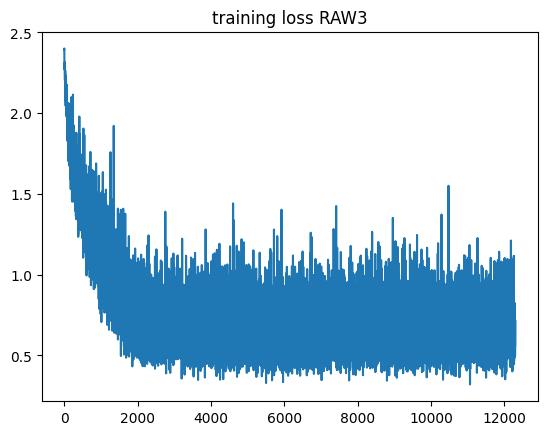

In [83]:
#RAW3 TRAINER
optimizer = optim.Adam(RAWmodel3.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
pbar_update = 1 / (len(RAWtrain_loader) + len(RAWvalid_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        RAWtrain(RAWmodel3, epoch, log_interval)
        RAWtest(RAWmodel3, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss RAW3");

In [84]:
error=0
print("test amount",len(RAWtest_set))
for i in range(len(RAWtest_set)-1) :
    if i==1685 or i==1692 or i==1753: 
            continue
    waveform, utterance = RAWtest_set[i]
    output = predict(waveform.to(device),RAWmodel3)
    if output != label_Encoder.classes_[utterance]:
        #Audio(waveform.numpy(), rate=sample_rate)
        #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
        error+=1        
else:
    # print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    #Audio(waveform.numpy(), rate=8000)
    print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")  
print("error: ",error)
print("acc: ",float(100-error/len(RAWtest_set)*100))

test amount 2763
In this case, let's just look at the last data point
Data point #2761. Expected: open vscode. Predicted: open vscode.
error:  1832
acc:  33.695258776692


  0%|                                                                                                                                  | 0.07142857142857142/150 [00:02<1:33:22, 37.36s/it]

Train Epoch: 1 [0/10452 (0%)]	Loss: 2.397196


  1%|▊                                                                                                                                  | 0.9999999999999997/150 [00:33<1:09:18, 27.91s/it]


Validate Epoch: 1	Accuracy: 218/2613 (8%)



  1%|▉                                                                                                                                  | 1.0714285714285712/150 [00:35<1:14:25, 29.98s/it]

Train Epoch: 2 [0/10452 (0%)]	Loss: 2.399762


  1%|█▋                                                                                                                                 | 1.9999999999999993/150 [01:05<1:07:15, 27.27s/it]


Validate Epoch: 2	Accuracy: 254/2613 (10%)



  1%|█▊                                                                                                                                 | 2.0714285714285707/150 [01:07<1:12:45, 29.51s/it]

Train Epoch: 3 [0/10452 (0%)]	Loss: 2.393501


  2%|██▌                                                                                                                                | 3.0000000000000018/150 [01:37<1:07:49, 27.69s/it]


Validate Epoch: 3	Accuracy: 218/2613 (8%)



  2%|██▋                                                                                                                                | 3.0714285714285734/150 [01:40<1:14:02, 30.23s/it]

Train Epoch: 4 [0/10452 (0%)]	Loss: 2.396490


  3%|███▌                                                                                                                                | 4.000000000000004/150 [02:10<1:07:31, 27.75s/it]


Validate Epoch: 4	Accuracy: 218/2613 (8%)



  3%|███▌                                                                                                                                | 4.071428571428576/150 [02:12<1:13:57, 30.41s/it]

Train Epoch: 5 [0/10452 (0%)]	Loss: 2.397830


  3%|████▍                                                                                                                               | 5.000000000000001/150 [02:43<1:07:07, 27.77s/it]


Validate Epoch: 5	Accuracy: 218/2613 (8%)



  3%|████▍                                                                                                                               | 5.071428571428572/150 [02:45<1:11:55, 29.78s/it]

Train Epoch: 6 [0/10452 (0%)]	Loss: 2.397418


  4%|█████▎                                                                                                                              | 5.999999999999997/150 [03:15<1:06:20, 27.65s/it]


Validate Epoch: 6	Accuracy: 218/2613 (8%)



  4%|█████▎                                                                                                                             | 6.0714285714285685/150 [03:18<1:13:10, 30.50s/it]

Train Epoch: 7 [0/10452 (0%)]	Loss: 2.387469


  5%|██████▏                                                                                                                             | 6.999999999999994/150 [03:48<1:06:11, 27.77s/it]


Validate Epoch: 7	Accuracy: 498/2613 (19%)



  5%|██████▏                                                                                                                             | 7.071428571428565/150 [03:50<1:12:08, 30.29s/it]

Train Epoch: 8 [0/10452 (0%)]	Loss: 2.122145


  5%|███████                                                                                                                              | 7.99999999999999/150 [04:20<1:06:08, 27.95s/it]


Validate Epoch: 8	Accuracy: 657/2613 (25%)



  5%|███████                                                                                                                             | 8.071428571428562/150 [04:23<1:13:33, 31.09s/it]

Train Epoch: 9 [0/10452 (0%)]	Loss: 2.057587


  6%|███████▉                                                                                                                            | 8.999999999999988/150 [04:53<1:05:24, 27.83s/it]


Validate Epoch: 9	Accuracy: 647/2613 (25%)



  6%|███████▉                                                                                                                            | 9.071428571428559/150 [04:56<1:11:32, 30.46s/it]

Train Epoch: 10 [0/10452 (0%)]	Loss: 1.884042


  7%|████████▊                                                                                                                           | 9.999999999999984/150 [05:26<1:03:40, 27.29s/it]


Validate Epoch: 10	Accuracy: 714/2613 (27%)



  7%|████████▊                                                                                                                          | 10.071428571428555/150 [05:28<1:10:00, 30.02s/it]

Train Epoch: 11 [0/10452 (0%)]	Loss: 1.801485


  7%|█████████▋                                                                                                                          | 10.99999999999998/150 [05:58<1:03:52, 27.57s/it]


Validate Epoch: 11	Accuracy: 874/2613 (33%)



  7%|█████████▋                                                                                                                         | 11.071428571428552/150 [06:01<1:09:41, 30.10s/it]

Train Epoch: 12 [0/10452 (0%)]	Loss: 1.735340


  8%|██████████▍                                                                                                                        | 11.999999999999977/150 [06:31<1:05:21, 28.42s/it]


Validate Epoch: 12	Accuracy: 884/2613 (34%)



  8%|██████████▌                                                                                                                        | 12.071428571428548/150 [06:34<1:10:32, 30.68s/it]

Train Epoch: 13 [0/10452 (0%)]	Loss: 1.759230


  9%|███████████▎                                                                                                                       | 12.999999999999973/150 [07:04<1:02:42, 27.47s/it]


Validate Epoch: 13	Accuracy: 1004/2613 (38%)



  9%|███████████▍                                                                                                                       | 13.071428571428545/150 [07:06<1:07:47, 29.71s/it]

Train Epoch: 14 [0/10452 (0%)]	Loss: 1.534706


  9%|████████████▎                                                                                                                       | 13.99999999999997/150 [07:36<1:01:53, 27.31s/it]


Validate Epoch: 14	Accuracy: 1216/2613 (47%)



  9%|████████████▎                                                                                                                      | 14.071428571428541/150 [07:39<1:06:56, 29.55s/it]

Train Epoch: 15 [0/10452 (0%)]	Loss: 1.429945


 10%|█████████████                                                                                                                      | 14.999999999999966/150 [08:08<1:01:00, 27.12s/it]


Validate Epoch: 15	Accuracy: 1196/2613 (46%)



 10%|█████████████▏                                                                                                                     | 15.071428571428537/150 [08:11<1:07:08, 29.86s/it]

Train Epoch: 16 [0/10452 (0%)]	Loss: 1.385308


 11%|█████████████▉                                                                                                                     | 15.999999999999963/150 [08:41<1:00:55, 27.28s/it]


Validate Epoch: 16	Accuracy: 1518/2613 (58%)



 11%|██████████████                                                                                                                     | 16.071428571428534/150 [08:43<1:06:54, 29.98s/it]

Train Epoch: 17 [0/10452 (0%)]	Loss: 1.154328


 11%|██████████████▊                                                                                                                    | 16.999999999999982/150 [09:13<1:00:01, 27.08s/it]


Validate Epoch: 17	Accuracy: 1723/2613 (66%)



 11%|██████████████▉                                                                                                                    | 17.071428571428555/150 [09:15<1:06:05, 29.83s/it]

Train Epoch: 18 [0/10452 (0%)]	Loss: 1.076211


 12%|███████████████▉                                                                                                                     | 18.000000000000004/150 [09:45<59:56, 27.25s/it]


Validate Epoch: 18	Accuracy: 1914/2613 (73%)



 12%|███████████████▊                                                                                                                   | 18.071428571428577/150 [09:47<1:05:50, 29.94s/it]

Train Epoch: 19 [0/10452 (0%)]	Loss: 0.753295


 13%|████████████████▊                                                                                                                    | 19.000000000000025/150 [10:17<59:41, 27.34s/it]


Validate Epoch: 19	Accuracy: 2002/2613 (77%)



 13%|████████████████▋                                                                                                                  | 19.071428571428598/150 [10:19<1:05:39, 30.09s/it]

Train Epoch: 20 [0/10452 (0%)]	Loss: 0.754749


 13%|█████████████████▋                                                                                                                   | 20.000000000000046/150 [10:49<59:05, 27.28s/it]


Validate Epoch: 20	Accuracy: 2059/2613 (79%)



 13%|█████████████████▋                                                                                                                  | 20.07142857142862/150 [10:52<1:05:09, 30.09s/it]

Train Epoch: 21 [0/10452 (0%)]	Loss: 0.814280


 14%|██████████████████▎                                                                                                                | 21.000000000000068/150 [11:23<1:00:10, 27.99s/it]


Validate Epoch: 21	Accuracy: 2133/2613 (82%)



 14%|██████████████████▌                                                                                                                 | 21.07142857142864/150 [11:26<1:05:32, 30.50s/it]

Train Epoch: 22 [0/10452 (0%)]	Loss: 0.590711


 15%|███████████████████▎                                                                                                                | 22.00000000000009/150 [11:57<1:03:06, 29.58s/it]


Validate Epoch: 22	Accuracy: 2183/2613 (84%)



 15%|███████████████████▍                                                                                                                | 22.07142857142866/150 [11:59<1:08:09, 31.96s/it]

Train Epoch: 23 [0/10452 (0%)]	Loss: 0.553120


 15%|████████████████████▏                                                                                                               | 23.00000000000011/150 [12:30<1:00:20, 28.51s/it]


Validate Epoch: 23	Accuracy: 2206/2613 (84%)



 15%|████████████████████▏                                                                                                              | 23.071428571428683/150 [12:33<1:05:11, 30.82s/it]

Train Epoch: 24 [0/10452 (0%)]	Loss: 0.518408


 16%|█████████████████████▍                                                                                                                | 24.00000000000013/150 [13:03<57:54, 27.57s/it]


Validate Epoch: 24	Accuracy: 2251/2613 (86%)



 16%|█████████████████████                                                                                                              | 24.071428571428704/150 [13:05<1:02:25, 29.74s/it]

Train Epoch: 25 [0/10452 (0%)]	Loss: 0.537507


 17%|██████████████████████▏                                                                                                              | 25.000000000000153/150 [13:35<56:04, 26.92s/it]


Validate Epoch: 25	Accuracy: 2249/2613 (86%)



 17%|█████████████████████▉                                                                                                             | 25.071428571428726/150 [13:37<1:01:55, 29.74s/it]

Train Epoch: 26 [0/10452 (0%)]	Loss: 0.515498


 17%|███████████████████████                                                                                                              | 26.000000000000174/150 [14:07<56:32, 27.36s/it]


Validate Epoch: 26	Accuracy: 2278/2613 (87%)



 17%|██████████████████████▊                                                                                                            | 26.071428571428747/150 [14:09<1:01:14, 29.65s/it]

Train Epoch: 27 [0/10452 (0%)]	Loss: 0.462553


 18%|███████████████████████▉                                                                                                             | 27.000000000000195/150 [14:40<57:45, 28.18s/it]


Validate Epoch: 27	Accuracy: 2292/2613 (88%)



 18%|███████████████████████▊                                                                                                            | 27.07142857142877/150 [14:42<1:03:21, 30.92s/it]

Train Epoch: 28 [0/10452 (0%)]	Loss: 0.468810


 19%|████████████████████████▊                                                                                                            | 28.000000000000217/150 [15:13<58:40, 28.86s/it]


Validate Epoch: 28	Accuracy: 2298/2613 (88%)



 19%|████████████████████████▋                                                                                                           | 28.07142857142879/150 [15:15<1:04:07, 31.56s/it]

Train Epoch: 29 [0/10452 (0%)]	Loss: 0.481368


 19%|█████████████████████████▋                                                                                                           | 29.000000000000238/150 [15:46<55:55, 27.73s/it]


Validate Epoch: 29	Accuracy: 2291/2613 (88%)



 19%|█████████████████████████▌                                                                                                          | 29.07142857142881/150 [15:48<1:01:15, 30.40s/it]

Train Epoch: 30 [0/10452 (0%)]	Loss: 0.447712


 20%|██████████████████████████▊                                                                                                           | 30.00000000000026/150 [16:19<57:19, 28.66s/it]


Validate Epoch: 30	Accuracy: 2302/2613 (88%)



 20%|██████████████████████████▎                                                                                                        | 30.071428571428832/150 [16:22<1:01:23, 30.72s/it]

Train Epoch: 31 [0/10452 (0%)]	Loss: 0.501661


 21%|███████████████████████████▋                                                                                                          | 31.00000000000028/150 [16:53<56:08, 28.31s/it]


Validate Epoch: 31	Accuracy: 2319/2613 (89%)



 21%|███████████████████████████▏                                                                                                       | 31.071428571428854/150 [16:56<1:00:55, 30.74s/it]

Train Epoch: 32 [0/10452 (0%)]	Loss: 0.499936


 21%|████████████████████████████▊                                                                                                          | 32.0000000000003/150 [17:26<53:04, 26.99s/it]


Validate Epoch: 32	Accuracy: 2307/2613 (88%)



 21%|████████████████████████████▋                                                                                                         | 32.07142857142887/150 [17:29<58:37, 29.83s/it]

Train Epoch: 33 [0/10452 (0%)]	Loss: 0.441780


 22%|█████████████████████████████▍                                                                                                        | 33.00000000000027/150 [17:58<52:23, 26.87s/it]


Validate Epoch: 33	Accuracy: 2298/2613 (88%)



 22%|█████████████████████████████▌                                                                                                        | 33.07142857142884/150 [18:00<57:52, 29.70s/it]

Train Epoch: 34 [0/10452 (0%)]	Loss: 0.444109


 23%|██████████████████████████████▎                                                                                                       | 34.00000000000024/150 [18:30<53:33, 27.70s/it]


Validate Epoch: 34	Accuracy: 2336/2613 (89%)



 23%|██████████████████████████████▍                                                                                                       | 34.07142857142881/150 [18:32<57:47, 29.91s/it]

Train Epoch: 35 [0/10452 (0%)]	Loss: 0.414472


 23%|███████████████████████████████▎                                                                                                      | 35.00000000000021/150 [19:01<51:23, 26.81s/it]


Validate Epoch: 35	Accuracy: 2339/2613 (90%)



 23%|███████████████████████████████▎                                                                                                      | 35.07142857142878/150 [19:04<56:40, 29.59s/it]

Train Epoch: 36 [0/10452 (0%)]	Loss: 0.395928


 24%|███████████████████████████████▉                                                                                                     | 36.000000000000185/150 [19:33<51:28, 27.09s/it]


Validate Epoch: 36	Accuracy: 2327/2613 (89%)



 24%|███████████████████████████████▉                                                                                                     | 36.071428571428754/150 [19:36<56:34, 29.80s/it]

Train Epoch: 37 [0/10452 (0%)]	Loss: 0.416900


 25%|████████████████████████████████▊                                                                                                    | 37.000000000000156/150 [20:05<50:19, 26.72s/it]


Validate Epoch: 37	Accuracy: 2338/2613 (89%)



 25%|████████████████████████████████▊                                                                                                    | 37.071428571428726/150 [20:08<54:31, 28.97s/it]

Train Epoch: 38 [0/10452 (0%)]	Loss: 0.362053


 25%|█████████████████████████████████▉                                                                                                    | 38.00000000000013/150 [20:37<51:30, 27.59s/it]


Validate Epoch: 38	Accuracy: 2364/2613 (90%)



 25%|██████████████████████████████████▎                                                                                                    | 38.0714285714287/150 [20:39<55:07, 29.55s/it]

Train Epoch: 39 [0/10452 (0%)]	Loss: 0.410995


 26%|███████████████████████████████████                                                                                                    | 39.0000000000001/150 [21:08<49:53, 26.97s/it]


Validate Epoch: 39	Accuracy: 2358/2613 (90%)



 26%|██████████████████████████████████▉                                                                                                   | 39.07142857142867/150 [21:11<53:54, 29.16s/it]

Train Epoch: 40 [0/10452 (0%)]	Loss: 0.349994


 27%|███████████████████████████████████▋                                                                                                  | 40.00000000000007/150 [21:41<51:24, 28.04s/it]


Validate Epoch: 40	Accuracy: 2356/2613 (90%)



 27%|███████████████████████████████████▊                                                                                                  | 40.07142857142864/150 [21:43<56:47, 31.00s/it]

Train Epoch: 41 [0/10452 (0%)]	Loss: 0.336329


 27%|████████████████████████████████████▋                                                                                                 | 41.00000000000004/150 [22:15<52:38, 28.97s/it]


Validate Epoch: 41	Accuracy: 2364/2613 (90%)



 27%|████████████████████████████████████▋                                                                                                 | 41.07142857142861/150 [22:17<56:44, 31.26s/it]

Train Epoch: 42 [0/10452 (0%)]	Loss: 0.376686


 28%|█████████████████████████████████████▏                                                                                               | 42.000000000000014/150 [22:49<50:50, 28.24s/it]


Validate Epoch: 42	Accuracy: 2365/2613 (91%)



 28%|█████████████████████████████████████▎                                                                                               | 42.071428571428584/150 [22:51<55:03, 30.61s/it]

Train Epoch: 43 [0/10452 (0%)]	Loss: 0.415261


 29%|██████████████████████████████████████▏                                                                                              | 42.999999999999986/150 [23:22<51:00, 28.60s/it]


Validate Epoch: 43	Accuracy: 2368/2613 (91%)



 29%|██████████████████████████████████████▏                                                                                              | 43.071428571428555/150 [23:24<55:15, 31.00s/it]

Train Epoch: 44 [0/10452 (0%)]	Loss: 0.395909


 29%|███████████████████████████████████████▎                                                                                              | 43.99999999999996/150 [23:56<49:10, 27.84s/it]


Validate Epoch: 44	Accuracy: 2364/2613 (90%)



 29%|███████████████████████████████████████▎                                                                                              | 44.07142857142853/150 [23:58<53:29, 30.29s/it]

Train Epoch: 45 [0/10452 (0%)]	Loss: 0.369803


 30%|████████████████████████████████████████▏                                                                                             | 44.99999999999993/150 [24:29<49:00, 28.01s/it]


Validate Epoch: 45	Accuracy: 2367/2613 (91%)



 30%|████████████████████████████████████████▌                                                                                              | 45.0714285714285/150 [24:31<54:31, 31.18s/it]

Train Epoch: 46 [0/10452 (0%)]	Loss: 0.376228


 31%|█████████████████████████████████████████▍                                                                                             | 45.9999999999999/150 [25:02<48:58, 28.26s/it]


Validate Epoch: 46	Accuracy: 2369/2613 (91%)



 31%|█████████████████████████████████████████▏                                                                                            | 46.07142857142847/150 [25:04<52:38, 30.39s/it]

Train Epoch: 47 [0/10452 (0%)]	Loss: 0.374899


 31%|█████████████████████████████████████████▉                                                                                            | 46.99999999999987/150 [25:34<47:07, 27.45s/it]


Validate Epoch: 47	Accuracy: 2364/2613 (90%)



 31%|██████████████████████████████████████████                                                                                            | 47.07142857142844/150 [25:37<51:25, 29.98s/it]

Train Epoch: 48 [0/10452 (0%)]	Loss: 0.346257


 32%|██████████████████████████████████████████▌                                                                                          | 47.999999999999844/150 [26:07<47:07, 27.72s/it]


Validate Epoch: 48	Accuracy: 2365/2613 (91%)



 32%|██████████████████████████████████████████▉                                                                                           | 48.07142857142841/150 [26:09<51:56, 30.58s/it]

Train Epoch: 49 [0/10452 (0%)]	Loss: 0.365901


 33%|███████████████████████████████████████████▍                                                                                         | 48.999999999999815/150 [26:40<47:05, 27.98s/it]


Validate Epoch: 49	Accuracy: 2370/2613 (91%)



 33%|███████████████████████████████████████████▌                                                                                         | 49.071428571428385/150 [26:42<51:21, 30.53s/it]

Train Epoch: 50 [0/10452 (0%)]	Loss: 0.385306


 33%|████████████████████████████████████████████▋                                                                                         | 49.99999999999979/150 [27:13<48:27, 29.07s/it]


Validate Epoch: 50	Accuracy: 2374/2613 (91%)



 33%|████████████████████████████████████████████▍                                                                                        | 50.071428571428356/150 [27:16<54:01, 32.44s/it]

Train Epoch: 51 [0/10452 (0%)]	Loss: 0.395031


 34%|█████████████████████████████████████████████▌                                                                                        | 50.99999999999976/150 [27:48<47:25, 28.74s/it]


Validate Epoch: 51	Accuracy: 2372/2613 (91%)



 34%|█████████████████████████████████████████████▌                                                                                        | 51.07142857142833/150 [27:50<50:59, 30.92s/it]

Train Epoch: 52 [0/10452 (0%)]	Loss: 0.371241


 35%|██████████████████████████████████████████████▍                                                                                       | 51.99999999999973/150 [28:21<48:28, 29.68s/it]


Validate Epoch: 52	Accuracy: 2372/2613 (91%)



 35%|██████████████████████████████████████████████▊                                                                                        | 52.0714285714283/150 [28:24<52:44, 32.31s/it]

Train Epoch: 53 [0/10452 (0%)]	Loss: 0.401583


 35%|███████████████████████████████████████████████▋                                                                                       | 52.9999999999997/150 [28:54<44:14, 27.36s/it]


Validate Epoch: 53	Accuracy: 2375/2613 (91%)



 35%|███████████████████████████████████████████████▍                                                                                      | 53.07142857142827/150 [28:57<48:21, 29.93s/it]

Train Epoch: 54 [0/10452 (0%)]	Loss: 0.436213


 36%|████████████████████████████████████████████████▏                                                                                     | 53.99999999999967/150 [29:26<42:47, 26.75s/it]


Validate Epoch: 54	Accuracy: 2376/2613 (91%)



 36%|████████████████████████████████████████████████▎                                                                                     | 54.07142857142824/150 [29:28<46:09, 28.87s/it]

Train Epoch: 55 [0/10452 (0%)]	Loss: 0.349813


 37%|████████████████████████████████████████████████▊                                                                                    | 54.999999999999645/150 [29:58<43:22, 27.40s/it]


Validate Epoch: 55	Accuracy: 2371/2613 (91%)



 37%|████████████████████████████████████████████████▊                                                                                    | 55.071428571428214/150 [30:00<47:25, 29.97s/it]

Train Epoch: 56 [0/10452 (0%)]	Loss: 0.362898


 37%|█████████████████████████████████████████████████▋                                                                                   | 55.999999999999616/150 [30:31<46:33, 29.72s/it]


Validate Epoch: 56	Accuracy: 2377/2613 (91%)



 37%|█████████████████████████████████████████████████▋                                                                                   | 56.071428571428186/150 [30:34<50:21, 32.17s/it]

Train Epoch: 57 [0/10452 (0%)]	Loss: 0.345545


 38%|██████████████████████████████████████████████████▉                                                                                   | 56.99999999999959/150 [31:04<42:15, 27.26s/it]


Validate Epoch: 57	Accuracy: 2380/2613 (91%)



 38%|██████████████████████████████████████████████████▉                                                                                   | 57.07142857142816/150 [31:07<46:27, 29.99s/it]

Train Epoch: 58 [0/10452 (0%)]	Loss: 0.353816


 39%|███████████████████████████████████████████████████▊                                                                                  | 57.99999999999956/150 [31:36<42:18, 27.59s/it]


Validate Epoch: 58	Accuracy: 2379/2613 (91%)



 39%|███████████████████████████████████████████████████▉                                                                                  | 58.07142857142813/150 [31:39<46:21, 30.26s/it]

Train Epoch: 59 [0/10452 (0%)]	Loss: 0.349415


 39%|████████████████████████████████████████████████████▋                                                                                 | 58.99999999999953/150 [32:09<42:37, 28.10s/it]


Validate Epoch: 59	Accuracy: 2383/2613 (91%)



 39%|█████████████████████████████████████████████████████▏                                                                                 | 59.0714285714281/150 [32:12<46:35, 30.74s/it]

Train Epoch: 60 [0/10452 (0%)]	Loss: 0.374090


 40%|█████████████████████████████████████████████████████▉                                                                                 | 59.9999999999995/150 [32:42<41:52, 27.92s/it]


Validate Epoch: 60	Accuracy: 2383/2613 (91%)



 40%|█████████████████████████████████████████████████████▋                                                                                | 60.07142857142807/150 [32:44<44:57, 30.00s/it]

Train Epoch: 61 [0/10452 (0%)]	Loss: 0.355292


 41%|██████████████████████████████████████████████████████                                                                               | 60.999999999999474/150 [33:14<40:38, 27.40s/it]


Validate Epoch: 61	Accuracy: 2382/2613 (91%)



 41%|██████████████████████████████████████████████████████▏                                                                              | 61.071428571428044/150 [33:16<43:42, 29.49s/it]

Train Epoch: 62 [0/10452 (0%)]	Loss: 0.359457


 41%|██████████████████████████████████████████████████████▉                                                                              | 61.999999999999446/150 [33:46<39:48, 27.14s/it]


Validate Epoch: 62	Accuracy: 2382/2613 (91%)



 41%|███████████████████████████████████████████████████████                                                                              | 62.071428571428015/150 [33:49<43:48, 29.89s/it]

Train Epoch: 63 [0/10452 (0%)]	Loss: 0.381435


 42%|████████████████████████████████████████████████████████▎                                                                             | 62.99999999999942/150 [34:18<39:39, 27.35s/it]


Validate Epoch: 63	Accuracy: 2381/2613 (91%)



 42%|████████████████████████████████████████████████████████▎                                                                             | 63.07142857142799/150 [34:21<43:24, 29.96s/it]

Train Epoch: 64 [0/10452 (0%)]	Loss: 0.358648


 43%|█████████████████████████████████████████████████████████▏                                                                            | 63.99999999999939/150 [34:51<39:11, 27.35s/it]


Validate Epoch: 64	Accuracy: 2380/2613 (91%)



 43%|█████████████████████████████████████████████████████████▏                                                                            | 64.07142857142796/150 [34:54<43:24, 30.31s/it]

Train Epoch: 65 [0/10452 (0%)]	Loss: 0.357423


 43%|██████████████████████████████████████████████████████████                                                                            | 64.99999999999936/150 [35:23<38:38, 27.28s/it]


Validate Epoch: 65	Accuracy: 2379/2613 (91%)



 43%|██████████████████████████████████████████████████████████▏                                                                           | 65.07142857142793/150 [35:26<42:46, 30.22s/it]

Train Epoch: 66 [0/10452 (0%)]	Loss: 0.376492


 44%|██████████████████████████████████████████████████████████▉                                                                           | 65.99999999999933/150 [35:56<38:44, 27.67s/it]


Validate Epoch: 66	Accuracy: 2378/2613 (91%)



 44%|███████████████████████████████████████████████████████████▍                                                                           | 66.0714285714279/150 [35:58<42:20, 30.27s/it]

Train Epoch: 67 [0/10452 (0%)]	Loss: 0.333744


 45%|████████████████████████████████████████████████████████████▎                                                                          | 66.9999999999993/150 [36:28<38:10, 27.59s/it]


Validate Epoch: 67	Accuracy: 2378/2613 (91%)



 45%|███████████████████████████████████████████████████████████▉                                                                          | 67.07142857142787/150 [36:31<41:45, 30.22s/it]

Train Epoch: 68 [0/10452 (0%)]	Loss: 0.350178


 45%|████████████████████████████████████████████████████████████▋                                                                         | 67.99999999999928/150 [37:01<37:29, 27.43s/it]


Validate Epoch: 68	Accuracy: 2377/2613 (91%)



 45%|████████████████████████████████████████████████████████████▊                                                                         | 68.07142857142784/150 [37:03<40:25, 29.61s/it]

Train Epoch: 69 [0/10452 (0%)]	Loss: 0.407537


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 68.99999999999925/150 [37:33<36:58, 27.39s/it]


Validate Epoch: 69	Accuracy: 2378/2613 (91%)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 69.07142857142782/150 [37:36<40:53, 30.31s/it]

Train Epoch: 70 [0/10452 (0%)]	Loss: 0.338309


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 69.99999999999922/150 [38:05<36:21, 27.26s/it]


Validate Epoch: 70	Accuracy: 2378/2613 (91%)



 47%|██████████████████████████████████████████████████████████████▌                                                                       | 70.07142857142779/150 [38:08<39:52, 29.93s/it]

Train Epoch: 71 [0/10452 (0%)]	Loss: 0.348710


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 70.99999999999919/150 [38:38<36:39, 27.84s/it]


Validate Epoch: 71	Accuracy: 2379/2613 (91%)



 47%|███████████████████████████████████████████████████████████████▍                                                                      | 71.07142857142776/150 [38:40<40:55, 31.11s/it]

Train Epoch: 72 [0/10452 (0%)]	Loss: 0.364615


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 71.99999999999916/150 [39:10<35:35, 27.38s/it]


Validate Epoch: 72	Accuracy: 2379/2613 (91%)



 48%|████████████████████████████████████████████████████████████████▍                                                                     | 72.07142857142773/150 [39:13<39:00, 30.03s/it]

Train Epoch: 73 [0/10452 (0%)]	Loss: 0.344435


 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 72.99999999999913/150 [39:43<35:08, 27.39s/it]


Validate Epoch: 73	Accuracy: 2378/2613 (91%)



 49%|█████████████████████████████████████████████████████████████████▊                                                                     | 73.0714285714277/150 [39:45<38:25, 29.98s/it]

Train Epoch: 74 [0/10452 (0%)]	Loss: 0.386998


 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 73.9999999999991/150 [40:15<34:27, 27.21s/it]


Validate Epoch: 74	Accuracy: 2379/2613 (91%)



 49%|██████████████████████████████████████████████████████████████████▏                                                                   | 74.07142857142767/150 [40:17<37:57, 29.99s/it]

Train Epoch: 75 [0/10452 (0%)]	Loss: 0.381207


 50%|██████████████████████████████████████████████████████████████████▉                                                                   | 74.99999999999908/150 [40:47<34:57, 27.96s/it]


Validate Epoch: 75	Accuracy: 2381/2613 (91%)



 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.07142857142765/150 [40:50<38:02, 30.47s/it]

Train Epoch: 76 [0/10452 (0%)]	Loss: 0.340309


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 75.99999999999905/150 [41:20<33:37, 27.27s/it]


Validate Epoch: 76	Accuracy: 2381/2613 (91%)



 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.07142857142762/150 [41:22<36:57, 29.99s/it]

Train Epoch: 77 [0/10452 (0%)]	Loss: 0.346880


 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 76.99999999999902/150 [41:52<33:09, 27.26s/it]


Validate Epoch: 77	Accuracy: 2382/2613 (91%)



 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 77.07142857142759/150 [41:54<35:45, 29.42s/it]

Train Epoch: 78 [0/10452 (0%)]	Loss: 0.381524


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 77.99999999999899/150 [42:24<32:31, 27.10s/it]


Validate Epoch: 78	Accuracy: 2381/2613 (91%)



 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 78.07142857142756/150 [42:27<35:43, 29.80s/it]

Train Epoch: 79 [0/10452 (0%)]	Loss: 0.344308


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 78.99999999999896/150 [42:57<32:27, 27.42s/it]


Validate Epoch: 79	Accuracy: 2381/2613 (91%)



 53%|██████████████████████████████████████████████████████████████████████▋                                                               | 79.07142857142753/150 [42:59<35:49, 30.31s/it]

Train Epoch: 80 [0/10452 (0%)]	Loss: 0.357422


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 79.99999999999893/150 [43:29<32:49, 28.14s/it]


Validate Epoch: 80	Accuracy: 2381/2613 (91%)



 53%|████████████████████████████████████████████████████████████████████████                                                               | 80.0714285714275/150 [43:32<36:08, 31.01s/it]

Train Epoch: 81 [0/10452 (0%)]	Loss: 0.422996


 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 80.9999999999989/150 [44:02<31:21, 27.26s/it]


Validate Epoch: 81	Accuracy: 2381/2613 (91%)



 54%|████████████████████████████████████████████████████████████████████████▍                                                             | 81.07142857142748/150 [44:04<33:47, 29.42s/it]

Train Epoch: 82 [0/10452 (0%)]	Loss: 0.402769


 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 81.99999999999888/150 [44:35<31:41, 27.96s/it]


Validate Epoch: 82	Accuracy: 2381/2613 (91%)



 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 82.07142857142745/150 [44:37<34:38, 30.60s/it]

Train Epoch: 83 [0/10452 (0%)]	Loss: 0.401368


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 82.99999999999885/150 [45:09<33:41, 30.18s/it]


Validate Epoch: 83	Accuracy: 2382/2613 (91%)



 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 83.07142857142742/150 [45:12<37:11, 33.34s/it]

Train Epoch: 84 [0/10452 (0%)]	Loss: 0.394193


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 83.99999999999882/150 [45:43<31:05, 28.26s/it]


Validate Epoch: 84	Accuracy: 2382/2613 (91%)



 56%|███████████████████████████████████████████████████████████████████████████                                                           | 84.07142857142739/150 [45:46<33:53, 30.84s/it]

Train Epoch: 85 [0/10452 (0%)]	Loss: 0.357591


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 84.99999999999879/150 [46:17<30:35, 28.25s/it]


Validate Epoch: 85	Accuracy: 2382/2613 (91%)



 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 85.07142857142736/150 [46:19<33:42, 31.15s/it]

Train Epoch: 86 [0/10452 (0%)]	Loss: 0.357202


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 85.99999999999876/150 [46:50<30:04, 28.20s/it]


Validate Epoch: 86	Accuracy: 2382/2613 (91%)



 57%|████████████████████████████████████████████████████████████████████████████▉                                                         | 86.07142857142733/150 [46:53<32:26, 30.44s/it]

Train Epoch: 87 [0/10452 (0%)]	Loss: 0.369748


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 86.99999999999874/150 [47:22<28:35, 27.24s/it]


Validate Epoch: 87	Accuracy: 2382/2613 (91%)



 58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 87.0714285714273/150 [47:25<31:12, 29.76s/it]

Train Epoch: 88 [0/10452 (0%)]	Loss: 0.340485


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                       | 87.9999999999987/150 [47:54<27:58, 27.07s/it]


Validate Epoch: 88	Accuracy: 2382/2613 (91%)



 59%|██████████████████████████████████████████████████████████████████████████████▋                                                       | 88.07142857142728/150 [47:57<30:55, 29.97s/it]

Train Epoch: 89 [0/10452 (0%)]	Loss: 0.333439


 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 88.99999999999868/150 [48:27<28:40, 28.21s/it]


Validate Epoch: 89	Accuracy: 2382/2613 (91%)



 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 89.07142857142725/150 [48:30<30:51, 30.39s/it]

Train Epoch: 90 [0/10452 (0%)]	Loss: 0.347213


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 89.99999999999865/150 [49:00<27:31, 27.53s/it]


Validate Epoch: 90	Accuracy: 2382/2613 (91%)



 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90.07142857142722/150 [49:03<30:22, 30.41s/it]

Train Epoch: 91 [0/10452 (0%)]	Loss: 0.353519


 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 90.99999999999862/150 [49:32<26:58, 27.42s/it]


Validate Epoch: 91	Accuracy: 2382/2613 (91%)



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 91.07142857142719/150 [49:35<29:04, 29.60s/it]

Train Epoch: 92 [0/10452 (0%)]	Loss: 0.335474


 61%|██████████████████████████████████████████████████████████████████████████████████▊                                                    | 91.9999999999986/150 [50:05<26:18, 27.22s/it]


Validate Epoch: 92	Accuracy: 2382/2613 (91%)



 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                   | 92.07142857142716/150 [50:07<28:52, 29.91s/it]

Train Epoch: 93 [0/10452 (0%)]	Loss: 0.402492


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 92.99999999999856/150 [50:37<25:44, 27.10s/it]


Validate Epoch: 93	Accuracy: 2382/2613 (91%)



 62%|███████████████████████████████████████████████████████████████████████████████████▏                                                  | 93.07142857142713/150 [50:39<28:18, 29.83s/it]

Train Epoch: 94 [0/10452 (0%)]	Loss: 0.368256


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 93.99999999999854/150 [51:09<25:43, 27.57s/it]


Validate Epoch: 94	Accuracy: 2382/2613 (91%)



 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                  | 94.0714285714271/150 [51:12<28:12, 30.26s/it]

Train Epoch: 95 [0/10452 (0%)]	Loss: 0.348128


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 94.99999999999851/150 [51:42<25:32, 27.87s/it]


Validate Epoch: 95	Accuracy: 2381/2613 (91%)



 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 95.07142857142708/150 [51:44<27:59, 30.57s/it]

Train Epoch: 96 [0/10452 (0%)]	Loss: 0.364063


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 95.99999999999848/150 [52:14<24:27, 27.18s/it]


Validate Epoch: 96	Accuracy: 2381/2613 (91%)



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.07142857142705/150 [52:17<26:52, 29.91s/it]

Train Epoch: 97 [0/10452 (0%)]	Loss: 0.361635


 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 96.99999999999845/150 [52:46<24:53, 28.18s/it]


Validate Epoch: 97	Accuracy: 2381/2613 (91%)



 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 97.07142857142702/150 [52:49<27:01, 30.64s/it]

Train Epoch: 98 [0/10452 (0%)]	Loss: 0.332612


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 97.99999999999842/150 [53:19<23:35, 27.21s/it]


Validate Epoch: 98	Accuracy: 2381/2613 (91%)



 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.07142857142699/150 [53:21<25:54, 29.94s/it]

Train Epoch: 99 [0/10452 (0%)]	Loss: 0.381231


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 98.9999999999984/150 [53:51<22:57, 27.02s/it]


Validate Epoch: 99	Accuracy: 2381/2613 (91%)



 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                             | 99.07142857142696/150 [53:53<25:22, 29.90s/it]

Train Epoch: 100 [0/10452 (0%)]	Loss: 0.326288


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 99.99999999999837/150 [54:23<22:38, 27.18s/it]


Validate Epoch: 100	Accuracy: 2382/2613 (91%)



 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 100.07142857142694/150 [54:25<24:54, 29.94s/it]

Train Epoch: 101 [0/10452 (0%)]	Loss: 0.390039


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 100.99999999999834/150 [54:55<22:22, 27.40s/it]


Validate Epoch: 101	Accuracy: 2382/2613 (91%)



 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                           | 101.0714285714269/150 [54:58<24:35, 30.16s/it]

Train Epoch: 102 [0/10452 (0%)]	Loss: 0.358381


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 101.99999999999831/150 [55:28<21:46, 27.22s/it]


Validate Epoch: 102	Accuracy: 2382/2613 (91%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                          | 102.07142857142688/150 [55:30<23:55, 29.94s/it]

Train Epoch: 103 [0/10452 (0%)]	Loss: 0.384923


 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 102.99999999999828/150 [56:00<21:28, 27.41s/it]


Validate Epoch: 103	Accuracy: 2382/2613 (91%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████▍                                         | 103.07142857142685/150 [56:02<23:10, 29.63s/it]

Train Epoch: 104 [0/10452 (0%)]	Loss: 0.395525


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 103.99999999999825/150 [56:32<20:52, 27.24s/it]


Validate Epoch: 104	Accuracy: 2382/2613 (91%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 104.07142857142682/150 [56:35<22:57, 29.98s/it]

Train Epoch: 105 [0/10452 (0%)]	Loss: 0.359965


 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 104.99999999999822/150 [57:05<20:28, 27.30s/it]


Validate Epoch: 105	Accuracy: 2382/2613 (91%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 105.0714285714268/150 [57:07<22:25, 29.94s/it]

Train Epoch: 106 [0/10452 (0%)]	Loss: 0.347933


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 105.9999999999982/150 [57:37<20:09, 27.50s/it]


Validate Epoch: 106	Accuracy: 2382/2613 (91%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████                                       | 106.07142857142676/150 [57:40<21:38, 29.57s/it]

Train Epoch: 107 [0/10452 (0%)]	Loss: 0.325758


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 106.99999999999817/150 [58:09<19:23, 27.06s/it]


Validate Epoch: 107	Accuracy: 2382/2613 (91%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.07142857142674/150 [58:12<21:21, 29.85s/it]

Train Epoch: 108 [0/10452 (0%)]	Loss: 0.409369


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 107.99999999999814/150 [58:42<19:05, 27.26s/it]


Validate Epoch: 108	Accuracy: 2382/2613 (91%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 108.07142857142671/150 [58:44<20:55, 29.95s/it]

Train Epoch: 109 [0/10452 (0%)]	Loss: 0.368574


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 108.99999999999811/150 [59:14<18:41, 27.35s/it]


Validate Epoch: 109	Accuracy: 2381/2613 (91%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 109.07142857142668/150 [59:17<20:11, 29.59s/it]

Train Epoch: 110 [0/10452 (0%)]	Loss: 0.349833


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 109.99999999999808/150 [59:46<18:16, 27.40s/it]


Validate Epoch: 110	Accuracy: 2381/2613 (91%)



 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 110.07142857142665/150 [59:49<19:55, 29.94s/it]

Train Epoch: 111 [0/10452 (0%)]	Loss: 0.344277


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 110.99999999999805/150 [1:00:19<18:22, 28.27s/it]


Validate Epoch: 111	Accuracy: 2381/2613 (91%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 111.07142857142662/150 [1:00:22<19:53, 30.67s/it]

Train Epoch: 112 [0/10452 (0%)]	Loss: 0.326841


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 111.99999999999802/150 [1:00:52<17:38, 27.87s/it]


Validate Epoch: 112	Accuracy: 2381/2613 (91%)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 112.0714285714266/150 [1:00:55<19:10, 30.33s/it]

Train Epoch: 113 [0/10452 (0%)]	Loss: 0.408982


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 112.999999999998/150 [1:01:24<16:51, 27.34s/it]


Validate Epoch: 113	Accuracy: 2382/2613 (91%)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 113.07142857142657/150 [1:01:27<18:29, 30.04s/it]

Train Epoch: 114 [0/10452 (0%)]	Loss: 0.361158


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 113.99999999999797/150 [1:01:57<16:24, 27.36s/it]


Validate Epoch: 114	Accuracy: 2382/2613 (91%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 114.07142857142654/150 [1:01:59<18:11, 30.37s/it]

Train Epoch: 115 [0/10452 (0%)]	Loss: 0.323072


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 114.99999999999794/150 [1:02:29<15:57, 27.36s/it]


Validate Epoch: 115	Accuracy: 2382/2613 (91%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 115.07142857142651/150 [1:02:31<17:13, 29.59s/it]

Train Epoch: 116 [0/10452 (0%)]	Loss: 0.360359


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 115.99999999999791/150 [1:03:01<15:45, 27.82s/it]


Validate Epoch: 116	Accuracy: 2382/2613 (91%)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 116.07142857142648/150 [1:03:04<17:08, 30.32s/it]

Train Epoch: 117 [0/10452 (0%)]	Loss: 0.381440


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 116.99999999999788/150 [1:03:34<15:12, 27.64s/it]


Validate Epoch: 117	Accuracy: 2382/2613 (91%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 117.07142857142645/150 [1:03:36<16:18, 29.72s/it]

Train Epoch: 118 [0/10452 (0%)]	Loss: 0.337227


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 117.99999999999785/150 [1:04:06<14:30, 27.20s/it]


Validate Epoch: 118	Accuracy: 2382/2613 (91%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 118.07142857142642/150 [1:04:09<15:54, 29.89s/it]

Train Epoch: 119 [0/10452 (0%)]	Loss: 0.401744


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 118.99999999999783/150 [1:04:38<13:55, 26.96s/it]


Validate Epoch: 119	Accuracy: 2382/2613 (91%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.0714285714264/150 [1:04:41<15:21, 29.80s/it]

Train Epoch: 120 [0/10452 (0%)]	Loss: 0.359654


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 119.9999999999978/150 [1:05:11<13:52, 27.76s/it]


Validate Epoch: 120	Accuracy: 2382/2613 (91%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 120.07142857142637/150 [1:05:14<15:15, 30.59s/it]

Train Epoch: 121 [0/10452 (0%)]	Loss: 0.358658


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 120.99999999999777/150 [1:05:44<13:10, 27.25s/it]


Validate Epoch: 121	Accuracy: 2382/2613 (91%)



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 121.07142857142634/150 [1:05:46<14:25, 29.92s/it]

Train Epoch: 122 [0/10452 (0%)]	Loss: 0.355779


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 121.99999999999774/150 [1:06:16<12:44, 27.29s/it]


Validate Epoch: 122	Accuracy: 2382/2613 (91%)



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 122.07142857142631/150 [1:06:18<13:45, 29.57s/it]

Train Epoch: 123 [0/10452 (0%)]	Loss: 0.343851


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 122.99999999999771/150 [1:06:48<12:18, 27.34s/it]


Validate Epoch: 123	Accuracy: 2382/2613 (91%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 123.07142857142628/150 [1:06:51<13:47, 30.74s/it]

Train Epoch: 124 [0/10452 (0%)]	Loss: 0.361409


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 123.99999999999768/150 [1:07:21<11:56, 27.57s/it]


Validate Epoch: 124	Accuracy: 2382/2613 (91%)



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 124.07142857142625/150 [1:07:23<13:04, 30.24s/it]

Train Epoch: 125 [0/10452 (0%)]	Loss: 0.335381


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 124.99999999999766/150 [1:07:53<11:26, 27.48s/it]


Validate Epoch: 125	Accuracy: 2382/2613 (91%)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 125.07142857142622/150 [1:07:56<12:36, 30.36s/it]

Train Epoch: 126 [0/10452 (0%)]	Loss: 0.349063


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 125.99999999999763/150 [1:08:25<10:55, 27.31s/it]


Validate Epoch: 126	Accuracy: 2382/2613 (91%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 126.0714285714262/150 [1:08:28<11:57, 29.97s/it]

Train Epoch: 127 [0/10452 (0%)]	Loss: 0.361863


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 126.9999999999976/150 [1:08:57<10:46, 28.10s/it]


Validate Epoch: 127	Accuracy: 2382/2613 (91%)



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.07142857142617/150 [1:09:00<11:43, 30.69s/it]

Train Epoch: 128 [0/10452 (0%)]	Loss: 0.318211


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 127.99999999999757/150 [1:09:30<09:59, 27.27s/it]


Validate Epoch: 128	Accuracy: 2382/2613 (91%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 128.07142857142614/150 [1:09:32<10:56, 29.96s/it]

Train Epoch: 129 [0/10452 (0%)]	Loss: 0.313103


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 128.99999999999773/150 [1:10:02<09:31, 27.19s/it]


Validate Epoch: 129	Accuracy: 2382/2613 (91%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 129.0714285714263/150 [1:10:04<10:16, 29.43s/it]

Train Epoch: 130 [0/10452 (0%)]	Loss: 0.371595


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 129.9999999999979/150 [1:10:34<09:05, 27.26s/it]


Validate Epoch: 130	Accuracy: 2382/2613 (91%)



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 130.07142857142648/150 [1:10:37<09:57, 29.98s/it]

Train Epoch: 131 [0/10452 (0%)]	Loss: 0.354147


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 130.99999999999807/150 [1:11:07<08:53, 28.07s/it]


Validate Epoch: 131	Accuracy: 2382/2613 (91%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 131.07142857142665/150 [1:11:10<09:38, 30.58s/it]

Train Epoch: 132 [0/10452 (0%)]	Loss: 0.381949


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 131.99999999999824/150 [1:11:41<08:24, 28.04s/it]


Validate Epoch: 132	Accuracy: 2382/2613 (91%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 132.07142857142682/150 [1:11:44<09:05, 30.45s/it]

Train Epoch: 133 [0/10452 (0%)]	Loss: 0.340351


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 132.9999999999984/150 [1:12:15<08:23, 29.63s/it]


Validate Epoch: 133	Accuracy: 2382/2613 (91%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 133.071428571427/150 [1:12:18<09:01, 32.00s/it]

Train Epoch: 134 [0/10452 (0%)]	Loss: 0.360673


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 133.99999999999858/150 [1:12:48<07:23, 27.73s/it]


Validate Epoch: 134	Accuracy: 2382/2613 (91%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 134.07142857142716/150 [1:12:51<08:06, 30.55s/it]

Train Epoch: 135 [0/10452 (0%)]	Loss: 0.344543


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 134.99999999999875/150 [1:13:21<06:52, 27.52s/it]


Validate Epoch: 135	Accuracy: 2382/2613 (91%)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 135.07142857142733/150 [1:13:24<07:22, 29.66s/it]

Train Epoch: 136 [0/10452 (0%)]	Loss: 0.363322


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 135.99999999999892/150 [1:13:53<06:23, 27.38s/it]


Validate Epoch: 136	Accuracy: 2382/2613 (91%)



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 136.0714285714275/150 [1:13:56<07:00, 30.20s/it]

Train Epoch: 137 [0/10452 (0%)]	Loss: 0.358663


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136.9999999999991/150 [1:14:26<05:54, 27.26s/it]


Validate Epoch: 137	Accuracy: 2382/2613 (91%)



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 137.07142857142767/150 [1:14:28<06:27, 29.94s/it]

Train Epoch: 138 [0/10452 (0%)]	Loss: 0.361857


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137.99999999999926/150 [1:14:58<05:37, 28.10s/it]


Validate Epoch: 138	Accuracy: 2382/2613 (91%)



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 138.07142857142784/150 [1:15:01<06:02, 30.39s/it]

Train Epoch: 139 [0/10452 (0%)]	Loss: 0.378619


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 138.99999999999943/150 [1:15:31<05:00, 27.28s/it]


Validate Epoch: 139	Accuracy: 2382/2613 (91%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139.07142857142802/150 [1:15:33<05:27, 29.97s/it]

Train Epoch: 140 [0/10452 (0%)]	Loss: 0.365015


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139.9999999999996/150 [1:16:03<04:34, 27.46s/it]


Validate Epoch: 140	Accuracy: 2382/2613 (91%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 140.07142857142819/150 [1:16:06<04:59, 30.17s/it]

Train Epoch: 141 [0/10452 (0%)]	Loss: 0.342568


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 140.99999999999977/150 [1:16:35<04:05, 27.28s/it]


Validate Epoch: 141	Accuracy: 2382/2613 (91%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 141.07142857142836/150 [1:16:38<04:23, 29.49s/it]

Train Epoch: 142 [0/10452 (0%)]	Loss: 0.342684


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 141.99999999999994/150 [1:17:07<03:40, 27.55s/it]


Validate Epoch: 142	Accuracy: 2382/2613 (91%)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142.07142857142853/150 [1:17:10<03:54, 29.60s/it]

Train Epoch: 143 [0/10452 (0%)]	Loss: 0.349190


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 143.0000000000001/150 [1:17:40<03:09, 27.05s/it]


Validate Epoch: 143	Accuracy: 2382/2613 (91%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143.0714285714287/150 [1:17:42<03:26, 29.81s/it]

Train Epoch: 144 [0/10452 (0%)]	Loss: 0.342563


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.00000000000028/150 [1:18:12<02:42, 27.12s/it]


Validate Epoch: 144	Accuracy: 2382/2613 (91%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.07142857142887/150 [1:18:14<02:57, 29.97s/it]

Train Epoch: 145 [0/10452 (0%)]	Loss: 0.394501


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145.00000000000045/150 [1:18:44<02:16, 27.24s/it]


Validate Epoch: 145	Accuracy: 2382/2613 (91%)



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145.07142857142904/150 [1:18:46<02:27, 29.92s/it]

Train Epoch: 146 [0/10452 (0%)]	Loss: 0.360530


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.00000000000063/150 [1:19:17<01:50, 27.51s/it]


Validate Epoch: 146	Accuracy: 2382/2613 (91%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.0714285714292/150 [1:19:19<01:56, 29.59s/it]

Train Epoch: 147 [0/10452 (0%)]	Loss: 0.323143


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147.0000000000008/150 [1:19:49<01:22, 27.33s/it]


Validate Epoch: 147	Accuracy: 2382/2613 (91%)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 147.07142857142938/150 [1:19:51<01:27, 30.04s/it]

Train Epoch: 148 [0/10452 (0%)]	Loss: 0.340737


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148.00000000000097/150 [1:20:21<00:54, 27.46s/it]


Validate Epoch: 148	Accuracy: 2382/2613 (91%)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148.07142857142955/150 [1:20:23<00:56, 29.56s/it]

Train Epoch: 149 [0/10452 (0%)]	Loss: 0.372922


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149.00000000000114/150 [1:20:53<00:27, 27.36s/it]


Validate Epoch: 149	Accuracy: 2382/2613 (91%)



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149.07142857142972/150 [1:20:56<00:28, 30.43s/it]

Train Epoch: 150 [0/10452 (0%)]	Loss: 0.344292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150.0000000000013/150 [1:21:26<00:00, 32.58s/it]


Validate Epoch: 150	Accuracy: 2382/2613 (91%)



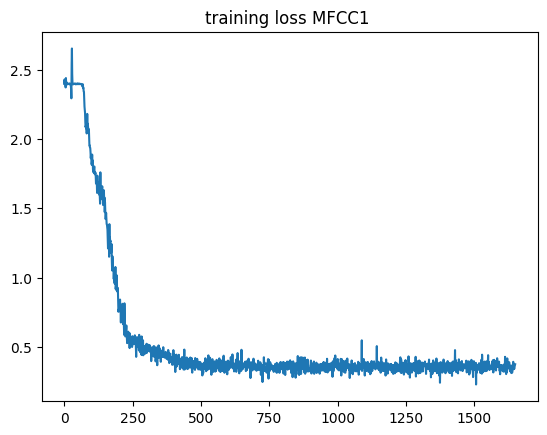

In [114]:
#MFCC1 TRAINER
pbar_update = 1 / (len(MFCCtrain_loader) + len(MFCCvalid_loader))
losses = []
optimizer = optim.Adam(MFCCmodel1.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        MFCCtrain(MFCCmodel1, epoch, log_interval)
        MFCCtest(MFCCmodel1, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss MFCC1 ");

In [115]:
error=0
print("test amount",len(MFCCtest_set))
for i in range(len(MFCCtest_set)-1) :
    if i==1685 or i==1692 or i==1753: 
            continue
    waveform, utterance = MFCCtest_set[i]
    output = predict(waveform,MFCCmodel1)
    if output != label_Encoder.classes_[utterance]:
        #Audio(waveform.numpy(), rate=sample_rate)
        #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
        error+=1        
else:
    # print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    #Audio(waveform.numpy(), rate=8000)
    print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")  
print("error: ",error)
print("acc: ",float(100-error/len(MFCCtest_set)*100))

test amount 2763
In this case, let's just look at the last data point
Data point #2761. Expected: open vscode. Predicted: open arduino.
error:  1020
acc:  63.08360477741585


In [ ]:
# MFCC2 TRAINER
# pbar_update = 1 / (len(MFCCtrain_loader) + len(MFCCvalid_loader))
# losses = []
# optimizer = optim.Adam(MFCCmodel2parameters(), lr=lr, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# # The transform needs to live on the same device as the model and the data.
# with tqdm(total=n_epoch) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         MFCCtrain(MFCCmodel2, epoch, log_interval)
#         MFCCtest(MFCCmodel2, epoch)
#         scheduler.step()

# # Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

In [ ]:
# error=0
# print("test amount",len(MFCCtest_set))
# for i in range(len(MFCCtest_set)-1) :
#     if i==1685 or i==1692 or i==1753: 
#             continue  
#     waveform, utterance = MFCCtest_set[i]
#     output = predict(waveform,MFCCmodel2)
#     if output != label_Encoder.classes_[utterance]:
#         #Audio(waveform.numpy(), rate=sample_rate)
#         #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
#         error+=1        
# else:
#     # print("All examples in this dataset were correctly classified!")
#     print("In this case, let's just look at the last data point")
#     #Audio(waveform.numpy(), rate=8000)
#     print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")  
# print("error: ",error)
# print("acc: ",float(100-error/len(MFCCtest_set)*100))

  0%|                                                                                                                                  | 0.07142857142857142/150 [00:02<1:29:00, 35.62s/it]

Train Epoch: 1 [0/10452 (0%)]	Loss: 2.398985


  1%|▊                                                                                                                                  | 0.9999999999999997/150 [00:32<1:06:53, 26.93s/it]


Validate Epoch: 1	Accuracy: 418/2613 (16%)



  1%|▉                                                                                                                                  | 1.0714285714285712/150 [00:34<1:14:05, 29.85s/it]

Train Epoch: 2 [0/10452 (0%)]	Loss: 2.174893


  1%|█▋                                                                                                                                 | 1.9999999999999993/150 [01:04<1:06:39, 27.02s/it]


Validate Epoch: 2	Accuracy: 446/2613 (17%)



  1%|█▊                                                                                                                                 | 2.0714285714285707/150 [01:06<1:13:21, 29.76s/it]

Train Epoch: 3 [0/10452 (0%)]	Loss: 2.118298


  2%|██▌                                                                                                                                | 3.0000000000000018/150 [01:36<1:06:44, 27.24s/it]


Validate Epoch: 3	Accuracy: 591/2613 (23%)



  2%|██▋                                                                                                                                | 3.0714285714285734/150 [01:39<1:13:50, 30.15s/it]

Train Epoch: 4 [0/10452 (0%)]	Loss: 1.940721


  3%|███▌                                                                                                                                | 4.000000000000004/150 [02:09<1:06:07, 27.17s/it]


Validate Epoch: 4	Accuracy: 718/2613 (27%)



  3%|███▌                                                                                                                                | 4.071428571428576/150 [02:11<1:13:05, 30.05s/it]

Train Epoch: 5 [0/10452 (0%)]	Loss: 1.813013


  3%|████▍                                                                                                                               | 5.000000000000001/150 [02:41<1:04:49, 26.82s/it]


Validate Epoch: 5	Accuracy: 903/2613 (35%)



  3%|████▍                                                                                                                               | 5.071428571428572/150 [02:43<1:11:56, 29.78s/it]

Train Epoch: 6 [0/10452 (0%)]	Loss: 1.748449


  4%|█████▎                                                                                                                              | 5.999999999999997/150 [03:14<1:09:53, 29.12s/it]


Validate Epoch: 6	Accuracy: 899/2613 (34%)



  4%|█████▎                                                                                                                             | 6.0714285714285685/150 [03:17<1:19:17, 33.05s/it]

Train Epoch: 7 [0/10452 (0%)]	Loss: 1.641861


  5%|██████▏                                                                                                                             | 6.999999999999994/150 [03:48<1:07:14, 28.21s/it]


Validate Epoch: 7	Accuracy: 847/2613 (32%)



  5%|██████▏                                                                                                                             | 7.071428571428565/150 [03:50<1:13:01, 30.65s/it]

Train Epoch: 8 [0/10452 (0%)]	Loss: 1.597520


  5%|███████                                                                                                                              | 7.99999999999999/150 [04:21<1:06:43, 28.19s/it]


Validate Epoch: 8	Accuracy: 987/2613 (38%)



  5%|███████                                                                                                                             | 8.071428571428562/150 [04:23<1:10:59, 30.01s/it]

Train Epoch: 9 [0/10452 (0%)]	Loss: 1.459921


  6%|███████▉                                                                                                                            | 8.999999999999988/150 [04:52<1:02:40, 26.67s/it]


Validate Epoch: 9	Accuracy: 1166/2613 (45%)



  6%|███████▉                                                                                                                            | 9.071428571428559/150 [04:55<1:07:44, 28.84s/it]

Train Epoch: 10 [0/10452 (0%)]	Loss: 1.304846


  7%|████████▊                                                                                                                           | 9.999999999999984/150 [05:24<1:03:03, 27.03s/it]


Validate Epoch: 10	Accuracy: 1538/2613 (59%)



  7%|████████▊                                                                                                                          | 10.071428571428555/150 [05:27<1:11:23, 30.62s/it]

Train Epoch: 11 [0/10452 (0%)]	Loss: 1.154762


  7%|█████████▋                                                                                                                          | 10.99999999999998/150 [05:55<1:02:02, 26.78s/it]


Validate Epoch: 11	Accuracy: 1797/2613 (69%)



  7%|█████████▋                                                                                                                         | 11.071428571428552/150 [05:58<1:08:38, 29.65s/it]

Train Epoch: 12 [0/10452 (0%)]	Loss: 1.029127


  8%|██████████▍                                                                                                                        | 11.999999999999977/150 [06:27<1:00:52, 26.47s/it]


Validate Epoch: 12	Accuracy: 1731/2613 (66%)



  8%|██████████▌                                                                                                                        | 12.071428571428548/150 [06:29<1:05:58, 28.70s/it]

Train Epoch: 13 [0/10452 (0%)]	Loss: 1.061424


  9%|███████████▎                                                                                                                       | 12.999999999999973/150 [06:58<1:00:55, 26.68s/it]


Validate Epoch: 13	Accuracy: 2128/2613 (81%)



  9%|███████████▍                                                                                                                       | 13.071428571428545/150 [07:01<1:07:25, 29.55s/it]

Train Epoch: 14 [0/10452 (0%)]	Loss: 0.799306


  9%|████████████▎                                                                                                                       | 13.99999999999997/150 [07:30<1:02:40, 27.65s/it]


Validate Epoch: 14	Accuracy: 2159/2613 (83%)



  9%|████████████▎                                                                                                                      | 14.071428571428541/150 [07:33<1:07:07, 29.63s/it]

Train Epoch: 15 [0/10452 (0%)]	Loss: 0.736902


 10%|█████████████                                                                                                                      | 14.999999999999966/150 [08:02<1:05:04, 28.92s/it]


Validate Epoch: 15	Accuracy: 2139/2613 (82%)



 10%|█████████████▏                                                                                                                     | 15.071428571428537/150 [08:05<1:11:23, 31.75s/it]

Train Epoch: 16 [0/10452 (0%)]	Loss: 0.701621


 11%|█████████████▉                                                                                                                     | 15.999999999999963/150 [08:36<1:02:13, 27.86s/it]


Validate Epoch: 16	Accuracy: 2321/2613 (89%)



 11%|██████████████                                                                                                                     | 16.071428571428534/150 [08:39<1:08:11, 30.55s/it]

Train Epoch: 17 [0/10452 (0%)]	Loss: 0.618404


 11%|██████████████▊                                                                                                                    | 16.999999999999982/150 [09:09<1:04:03, 28.90s/it]


Validate Epoch: 17	Accuracy: 2268/2613 (87%)



 11%|██████████████▉                                                                                                                    | 17.071428571428555/150 [09:12<1:11:51, 32.44s/it]

Train Epoch: 18 [0/10452 (0%)]	Loss: 0.553192


 12%|███████████████▋                                                                                                                   | 18.000000000000004/150 [09:43<1:00:38, 27.57s/it]


Validate Epoch: 18	Accuracy: 2317/2613 (89%)



 12%|███████████████▊                                                                                                                   | 18.071428571428577/150 [09:46<1:06:27, 30.23s/it]

Train Epoch: 19 [0/10452 (0%)]	Loss: 0.580866


 13%|████████████████▌                                                                                                                  | 19.000000000000025/150 [10:16<1:00:51, 27.88s/it]


Validate Epoch: 19	Accuracy: 2392/2613 (92%)



 13%|████████████████▋                                                                                                                  | 19.071428571428598/150 [10:18<1:07:05, 30.75s/it]

Train Epoch: 20 [0/10452 (0%)]	Loss: 0.483947


 13%|█████████████████▍                                                                                                                 | 20.000000000000046/150 [10:49<1:03:07, 29.14s/it]


Validate Epoch: 20	Accuracy: 2353/2613 (90%)



 13%|█████████████████▋                                                                                                                  | 20.07142857142862/150 [10:52<1:08:51, 31.80s/it]

Train Epoch: 21 [0/10452 (0%)]	Loss: 0.410094


 14%|██████████████████▌                                                                                                                  | 21.000000000000068/150 [11:21<57:28, 26.73s/it]


Validate Epoch: 21	Accuracy: 2407/2613 (92%)



 14%|██████████████████▌                                                                                                                 | 21.07142857142864/150 [11:23<1:03:10, 29.40s/it]

Train Epoch: 22 [0/10452 (0%)]	Loss: 0.434955


 15%|███████████████████▋                                                                                                                  | 22.00000000000009/150 [11:53<57:20, 26.88s/it]


Validate Epoch: 22	Accuracy: 2403/2613 (92%)



 15%|███████████████████▍                                                                                                                | 22.07142857142866/150 [11:55<1:03:49, 29.93s/it]

Train Epoch: 23 [0/10452 (0%)]	Loss: 0.431893


 15%|████████████████████▌                                                                                                                 | 23.00000000000011/150 [12:25<57:11, 27.02s/it]


Validate Epoch: 23	Accuracy: 2408/2613 (92%)



 15%|████████████████████▏                                                                                                              | 23.071428571428683/150 [12:27<1:02:50, 29.71s/it]

Train Epoch: 24 [0/10452 (0%)]	Loss: 0.367780


 16%|█████████████████████▍                                                                                                                | 24.00000000000013/150 [12:57<57:09, 27.22s/it]


Validate Epoch: 24	Accuracy: 2429/2613 (93%)



 16%|█████████████████████                                                                                                              | 24.071428571428704/150 [12:59<1:03:10, 30.10s/it]

Train Epoch: 25 [0/10452 (0%)]	Loss: 0.372554


 17%|█████████████████████▊                                                                                                             | 25.000000000000153/150 [13:30<1:02:03, 29.79s/it]


Validate Epoch: 25	Accuracy: 2420/2613 (93%)



 17%|█████████████████████▉                                                                                                             | 25.071428571428726/150 [13:33<1:06:16, 31.83s/it]

Train Epoch: 26 [0/10452 (0%)]	Loss: 0.339220


 17%|███████████████████████                                                                                                              | 26.000000000000174/150 [14:03<55:40, 26.94s/it]


Validate Epoch: 26	Accuracy: 2431/2613 (93%)



 17%|███████████████████████                                                                                                              | 26.071428571428747/150 [14:05<59:54, 29.00s/it]

Train Epoch: 27 [0/10452 (0%)]	Loss: 0.381200


 18%|███████████████████████▉                                                                                                             | 27.000000000000195/150 [14:35<56:33, 27.59s/it]


Validate Epoch: 27	Accuracy: 2426/2613 (93%)



 18%|███████████████████████▊                                                                                                            | 27.07142857142877/150 [14:37<1:00:34, 29.57s/it]

Train Epoch: 28 [0/10452 (0%)]	Loss: 0.323625


 19%|████████████████████████▊                                                                                                            | 28.000000000000217/150 [15:08<58:59, 29.01s/it]


Validate Epoch: 28	Accuracy: 2443/2613 (93%)



 19%|████████████████████████▋                                                                                                           | 28.07142857142879/150 [15:11<1:03:57, 31.48s/it]

Train Epoch: 29 [0/10452 (0%)]	Loss: 0.346097


 19%|█████████████████████████▋                                                                                                           | 29.000000000000238/150 [15:41<57:10, 28.36s/it]


Validate Epoch: 29	Accuracy: 2444/2613 (94%)



 19%|█████████████████████████▌                                                                                                          | 29.07142857142881/150 [15:44<1:02:12, 30.87s/it]

Train Epoch: 30 [0/10452 (0%)]	Loss: 0.296543


 20%|██████████████████████████▊                                                                                                           | 30.00000000000026/150 [16:15<56:28, 28.24s/it]


Validate Epoch: 30	Accuracy: 2445/2613 (94%)



 20%|██████████████████████████▎                                                                                                        | 30.071428571428832/150 [16:18<1:02:19, 31.18s/it]

Train Epoch: 31 [0/10452 (0%)]	Loss: 0.347569


 21%|███████████████████████████▋                                                                                                          | 31.00000000000028/150 [16:47<54:14, 27.35s/it]


Validate Epoch: 31	Accuracy: 2444/2613 (94%)



 21%|███████████████████████████▌                                                                                                         | 31.071428571428854/150 [16:50<59:33, 30.04s/it]

Train Epoch: 32 [0/10452 (0%)]	Loss: 0.370122


 21%|████████████████████████████▊                                                                                                          | 32.0000000000003/150 [17:21<59:28, 30.24s/it]


Validate Epoch: 32	Accuracy: 2449/2613 (94%)



 21%|████████████████████████████▏                                                                                                       | 32.07142857142887/150 [17:24<1:04:54, 33.02s/it]

Train Epoch: 33 [0/10452 (0%)]	Loss: 0.327399


 22%|█████████████████████████████▍                                                                                                        | 33.00000000000027/150 [17:56<54:22, 27.89s/it]


Validate Epoch: 33	Accuracy: 2454/2613 (94%)



 22%|█████████████████████████████▌                                                                                                        | 33.07142857142884/150 [17:58<59:08, 30.35s/it]

Train Epoch: 34 [0/10452 (0%)]	Loss: 0.366489


 23%|██████████████████████████████▎                                                                                                       | 34.00000000000024/150 [18:29<53:23, 27.61s/it]


Validate Epoch: 34	Accuracy: 2449/2613 (94%)



 23%|██████████████████████████████▍                                                                                                       | 34.07142857142881/150 [18:31<57:39, 29.84s/it]

Train Epoch: 35 [0/10452 (0%)]	Loss: 0.319993


 23%|███████████████████████████████▎                                                                                                      | 35.00000000000021/150 [19:02<54:50, 28.61s/it]


Validate Epoch: 35	Accuracy: 2449/2613 (94%)



 23%|███████████████████████████████▎                                                                                                      | 35.07142857142878/150 [19:05<59:10, 30.89s/it]

Train Epoch: 36 [0/10452 (0%)]	Loss: 0.285540


 24%|███████████████████████████████▉                                                                                                     | 36.000000000000185/150 [19:36<52:04, 27.41s/it]


Validate Epoch: 36	Accuracy: 2448/2613 (94%)



 24%|███████████████████████████████▉                                                                                                     | 36.071428571428754/150 [19:39<57:14, 30.15s/it]

Train Epoch: 37 [0/10452 (0%)]	Loss: 0.321486


 25%|████████████████████████████████▊                                                                                                    | 37.000000000000156/150 [20:09<52:06, 27.66s/it]


Validate Epoch: 37	Accuracy: 2461/2613 (94%)



 25%|████████████████████████████████▊                                                                                                    | 37.071428571428726/150 [20:11<56:07, 29.82s/it]

Train Epoch: 38 [0/10452 (0%)]	Loss: 0.318762


 25%|█████████████████████████████████▉                                                                                                    | 38.00000000000013/150 [20:41<51:06, 27.38s/it]


Validate Epoch: 38	Accuracy: 2466/2613 (94%)



 25%|██████████████████████████████████▎                                                                                                    | 38.0714285714287/150 [20:44<56:31, 30.30s/it]

Train Epoch: 39 [0/10452 (0%)]	Loss: 0.336162


 26%|███████████████████████████████████                                                                                                    | 39.0000000000001/150 [21:15<57:23, 31.02s/it]


Validate Epoch: 39	Accuracy: 2456/2613 (94%)



 26%|██████████████████████████████████▍                                                                                                 | 39.07142857142867/150 [21:17<1:01:25, 33.23s/it]

Train Epoch: 40 [0/10452 (0%)]	Loss: 0.314958


 27%|███████████████████████████████████▋                                                                                                  | 40.00000000000007/150 [21:49<55:01, 30.02s/it]


Validate Epoch: 40	Accuracy: 2458/2613 (94%)



 27%|███████████████████████████████████▎                                                                                                | 40.07142857142864/150 [21:52<1:00:17, 32.91s/it]

Train Epoch: 41 [0/10452 (0%)]	Loss: 0.338345


 27%|████████████████████████████████████▋                                                                                                 | 41.00000000000004/150 [22:24<54:22, 29.93s/it]


Validate Epoch: 41	Accuracy: 2457/2613 (94%)



 27%|████████████████████████████████████▋                                                                                                 | 41.07142857142861/150 [22:27<59:26, 32.75s/it]

Train Epoch: 42 [0/10452 (0%)]	Loss: 0.379285


 28%|█████████████████████████████████████▏                                                                                               | 42.000000000000014/150 [22:59<53:06, 29.50s/it]


Validate Epoch: 42	Accuracy: 2461/2613 (94%)



 28%|█████████████████████████████████████▎                                                                                               | 42.071428571428584/150 [23:02<57:42, 32.08s/it]

Train Epoch: 43 [0/10452 (0%)]	Loss: 0.330572


 29%|██████████████████████████████████████▏                                                                                              | 42.999999999999986/150 [23:34<53:58, 30.27s/it]


Validate Epoch: 43	Accuracy: 2463/2613 (94%)



 29%|██████████████████████████████████████▏                                                                                              | 43.071428571428555/150 [23:37<58:59, 33.10s/it]

Train Epoch: 44 [0/10452 (0%)]	Loss: 0.300340


 29%|███████████████████████████████████████▎                                                                                              | 43.99999999999996/150 [24:08<51:19, 29.05s/it]


Validate Epoch: 44	Accuracy: 2463/2613 (94%)



 29%|███████████████████████████████████████▎                                                                                              | 44.07142857142853/150 [24:11<56:46, 32.16s/it]

Train Epoch: 45 [0/10452 (0%)]	Loss: 0.309892


 30%|████████████████████████████████████████▏                                                                                             | 44.99999999999993/150 [24:44<52:32, 30.02s/it]


Validate Epoch: 45	Accuracy: 2462/2613 (94%)



 30%|████████████████████████████████████████▌                                                                                              | 45.0714285714285/150 [24:47<58:00, 33.17s/it]

Train Epoch: 46 [0/10452 (0%)]	Loss: 0.355689


 31%|█████████████████████████████████████████▍                                                                                             | 45.9999999999999/150 [25:18<49:31, 28.57s/it]


Validate Epoch: 46	Accuracy: 2462/2613 (94%)



 31%|█████████████████████████████████████████▏                                                                                            | 46.07142857142847/150 [25:20<52:59, 30.60s/it]

Train Epoch: 47 [0/10452 (0%)]	Loss: 0.301725


 31%|█████████████████████████████████████████▉                                                                                            | 46.99999999999987/150 [25:50<47:29, 27.66s/it]


Validate Epoch: 47	Accuracy: 2463/2613 (94%)



 31%|██████████████████████████████████████████                                                                                            | 47.07142857142844/150 [25:53<52:27, 30.58s/it]

Train Epoch: 48 [0/10452 (0%)]	Loss: 0.316939


 32%|██████████████████████████████████████████▌                                                                                          | 47.999999999999844/150 [26:22<45:22, 26.69s/it]


Validate Epoch: 48	Accuracy: 2464/2613 (94%)



 32%|██████████████████████████████████████████▉                                                                                           | 48.07142857142841/150 [26:25<50:23, 29.66s/it]

Train Epoch: 49 [0/10452 (0%)]	Loss: 0.318869


 33%|███████████████████████████████████████████▍                                                                                         | 48.999999999999815/150 [26:55<45:28, 27.02s/it]


Validate Epoch: 49	Accuracy: 2462/2613 (94%)



 33%|███████████████████████████████████████████▌                                                                                         | 49.071428571428385/150 [26:57<50:11, 29.84s/it]

Train Epoch: 50 [0/10452 (0%)]	Loss: 0.259612


 33%|████████████████████████████████████████████▋                                                                                         | 49.99999999999979/150 [27:28<46:50, 28.10s/it]


Validate Epoch: 50	Accuracy: 2464/2613 (94%)



 33%|████████████████████████████████████████████▍                                                                                        | 50.071428571428356/150 [27:30<50:25, 30.28s/it]

Train Epoch: 51 [0/10452 (0%)]	Loss: 0.385715


 34%|█████████████████████████████████████████████▌                                                                                        | 50.99999999999976/150 [28:00<45:21, 27.49s/it]


Validate Epoch: 51	Accuracy: 2464/2613 (94%)



 34%|█████████████████████████████████████████████▌                                                                                        | 51.07142857142833/150 [28:02<49:28, 30.01s/it]

Train Epoch: 52 [0/10452 (0%)]	Loss: 0.335568


 35%|██████████████████████████████████████████████▍                                                                                       | 51.99999999999973/150 [28:32<45:09, 27.65s/it]


Validate Epoch: 52	Accuracy: 2469/2613 (94%)



 35%|██████████████████████████████████████████████▊                                                                                        | 52.0714285714283/150 [28:35<48:31, 29.73s/it]

Train Epoch: 53 [0/10452 (0%)]	Loss: 0.296312


 35%|███████████████████████████████████████████████▋                                                                                       | 52.9999999999997/150 [29:05<44:37, 27.61s/it]


Validate Epoch: 53	Accuracy: 2465/2613 (94%)



 35%|███████████████████████████████████████████████▍                                                                                      | 53.07142857142827/150 [29:07<48:58, 30.32s/it]

Train Epoch: 54 [0/10452 (0%)]	Loss: 0.270428


 36%|████████████████████████████████████████████████▏                                                                                     | 53.99999999999967/150 [29:38<44:21, 27.73s/it]


Validate Epoch: 54	Accuracy: 2465/2613 (94%)



 36%|████████████████████████████████████████████████▎                                                                                     | 54.07142857142824/150 [29:40<48:36, 30.40s/it]

Train Epoch: 55 [0/10452 (0%)]	Loss: 0.285083


 37%|████████████████████████████████████████████████▊                                                                                    | 54.999999999999645/150 [30:10<43:38, 27.56s/it]


Validate Epoch: 55	Accuracy: 2465/2613 (94%)



 37%|████████████████████████████████████████████████▊                                                                                    | 55.071428571428214/150 [30:13<48:05, 30.40s/it]

Train Epoch: 56 [0/10452 (0%)]	Loss: 0.304777


 37%|█████████████████████████████████████████████████▋                                                                                   | 55.999999999999616/150 [30:43<43:12, 27.58s/it]


Validate Epoch: 56	Accuracy: 2467/2613 (94%)



 37%|█████████████████████████████████████████████████▋                                                                                   | 56.071428571428186/150 [30:45<46:29, 29.70s/it]

Train Epoch: 57 [0/10452 (0%)]	Loss: 0.269649


 38%|██████████████████████████████████████████████████▉                                                                                   | 56.99999999999959/150 [31:15<43:44, 28.22s/it]


Validate Epoch: 57	Accuracy: 2468/2613 (94%)



 38%|██████████████████████████████████████████████████▉                                                                                   | 57.07142857142816/150 [31:18<48:18, 31.19s/it]

Train Epoch: 58 [0/10452 (0%)]	Loss: 0.311553


 39%|███████████████████████████████████████████████████▊                                                                                  | 57.99999999999956/150 [31:48<42:23, 27.64s/it]


Validate Epoch: 58	Accuracy: 2467/2613 (94%)



 39%|███████████████████████████████████████████████████▉                                                                                  | 58.07142857142813/150 [31:51<46:13, 30.17s/it]

Train Epoch: 59 [0/10452 (0%)]	Loss: 0.323263


 39%|████████████████████████████████████████████████████▋                                                                                 | 58.99999999999953/150 [32:20<41:32, 27.39s/it]


Validate Epoch: 59	Accuracy: 2466/2613 (94%)



 39%|█████████████████████████████████████████████████████▏                                                                                 | 59.0714285714281/150 [32:23<46:20, 30.58s/it]

Train Epoch: 60 [0/10452 (0%)]	Loss: 0.358470


 40%|█████████████████████████████████████████████████████▉                                                                                 | 59.9999999999995/150 [32:54<42:21, 28.24s/it]


Validate Epoch: 60	Accuracy: 2467/2613 (94%)



 40%|█████████████████████████████████████████████████████▋                                                                                | 60.07142857142807/150 [32:57<46:08, 30.79s/it]

Train Epoch: 61 [0/10452 (0%)]	Loss: 0.317466


 41%|██████████████████████████████████████████████████████                                                                               | 60.999999999999474/150 [33:28<44:33, 30.04s/it]


Validate Epoch: 61	Accuracy: 2467/2613 (94%)



 41%|██████████████████████████████████████████████████████▏                                                                              | 61.071428571428044/150 [33:31<48:06, 32.46s/it]

Train Epoch: 62 [0/10452 (0%)]	Loss: 0.278176


 41%|██████████████████████████████████████████████████████▉                                                                              | 61.999999999999446/150 [34:01<40:18, 27.48s/it]


Validate Epoch: 62	Accuracy: 2467/2613 (94%)



 41%|███████████████████████████████████████████████████████                                                                              | 62.071428571428015/150 [34:04<43:53, 29.96s/it]

Train Epoch: 63 [0/10452 (0%)]	Loss: 0.288494


 42%|████████████████████████████████████████████████████████▎                                                                             | 62.99999999999942/150 [34:34<40:02, 27.62s/it]


Validate Epoch: 63	Accuracy: 2467/2613 (94%)



 42%|████████████████████████████████████████████████████████▎                                                                             | 63.07142857142799/150 [34:36<43:46, 30.21s/it]

Train Epoch: 64 [0/10452 (0%)]	Loss: 0.264645


 43%|█████████████████████████████████████████████████████████▏                                                                            | 63.99999999999939/150 [35:08<41:16, 28.80s/it]


Validate Epoch: 64	Accuracy: 2466/2613 (94%)



 43%|█████████████████████████████████████████████████████████▏                                                                            | 64.07142857142796/150 [35:10<44:47, 31.28s/it]

Train Epoch: 65 [0/10452 (0%)]	Loss: 0.315633


 43%|██████████████████████████████████████████████████████████                                                                            | 64.99999999999936/150 [35:42<39:44, 28.05s/it]


Validate Epoch: 65	Accuracy: 2466/2613 (94%)



 43%|██████████████████████████████████████████████████████████▏                                                                           | 65.07142857142793/150 [35:44<43:10, 30.51s/it]

Train Epoch: 66 [0/10452 (0%)]	Loss: 0.284011


 44%|██████████████████████████████████████████████████████████▉                                                                           | 65.99999999999933/150 [36:15<39:05, 27.92s/it]


Validate Epoch: 66	Accuracy: 2466/2613 (94%)



 44%|███████████████████████████████████████████████████████████▍                                                                           | 66.0714285714279/150 [36:17<43:55, 31.40s/it]

Train Epoch: 67 [0/10452 (0%)]	Loss: 0.382896


 45%|████████████████████████████████████████████████████████████▎                                                                          | 66.9999999999993/150 [36:48<38:26, 27.79s/it]


Validate Epoch: 67	Accuracy: 2466/2613 (94%)



 45%|███████████████████████████████████████████████████████████▉                                                                          | 67.07142857142787/150 [36:50<42:01, 30.41s/it]

Train Epoch: 68 [0/10452 (0%)]	Loss: 0.294535


 45%|████████████████████████████████████████████████████████████▋                                                                         | 67.99999999999928/150 [37:21<40:32, 29.66s/it]


Validate Epoch: 68	Accuracy: 2466/2613 (94%)



 45%|████████████████████████████████████████████████████████████▊                                                                         | 68.07142857142784/150 [37:24<43:43, 32.03s/it]

Train Epoch: 69 [0/10452 (0%)]	Loss: 0.288651


 46%|█████████████████████████████████████████████████████████████▋                                                                        | 68.99999999999925/150 [37:54<37:34, 27.83s/it]


Validate Epoch: 69	Accuracy: 2466/2613 (94%)



 46%|█████████████████████████████████████████████████████████████▋                                                                        | 69.07142857142782/150 [37:56<40:57, 30.37s/it]

Train Epoch: 70 [0/10452 (0%)]	Loss: 0.335610


 47%|██████████████████████████████████████████████████████████████▌                                                                       | 69.99999999999922/150 [38:27<37:07, 27.84s/it]


Validate Epoch: 70	Accuracy: 2466/2613 (94%)



 47%|██████████████████████████████████████████████████████████████▌                                                                       | 70.07142857142779/150 [38:29<40:52, 30.69s/it]

Train Epoch: 71 [0/10452 (0%)]	Loss: 0.306229


 47%|███████████████████████████████████████████████████████████████▍                                                                      | 70.99999999999919/150 [38:59<36:42, 27.88s/it]


Validate Epoch: 71	Accuracy: 2466/2613 (94%)



 47%|███████████████████████████████████████████████████████████████▍                                                                      | 71.07142857142776/150 [39:02<39:41, 30.18s/it]

Train Epoch: 72 [0/10452 (0%)]	Loss: 0.284420


 48%|████████████████████████████████████████████████████████████████▎                                                                     | 71.99999999999916/150 [39:32<36:22, 27.98s/it]


Validate Epoch: 72	Accuracy: 2466/2613 (94%)



 48%|████████████████████████████████████████████████████████████████▍                                                                     | 72.07142857142773/150 [39:35<39:53, 30.71s/it]

Train Epoch: 73 [0/10452 (0%)]	Loss: 0.300494


 49%|█████████████████████████████████████████████████████████████████▏                                                                    | 72.99999999999913/150 [40:06<36:11, 28.20s/it]


Validate Epoch: 73	Accuracy: 2465/2613 (94%)



 49%|█████████████████████████████████████████████████████████████████▊                                                                     | 73.0714285714277/150 [40:08<39:10, 30.55s/it]

Train Epoch: 74 [0/10452 (0%)]	Loss: 0.290345


 49%|██████████████████████████████████████████████████████████████████▌                                                                    | 73.9999999999991/150 [40:40<36:58, 29.20s/it]


Validate Epoch: 74	Accuracy: 2466/2613 (94%)



 49%|██████████████████████████████████████████████████████████████████▏                                                                   | 74.07142857142767/150 [40:42<40:21, 31.89s/it]

Train Epoch: 75 [0/10452 (0%)]	Loss: 0.249034


 50%|██████████████████████████████████████████████████████████████████▉                                                                   | 74.99999999999908/150 [41:13<36:05, 28.87s/it]


Validate Epoch: 75	Accuracy: 2466/2613 (94%)



 50%|███████████████████████████████████████████████████████████████████                                                                   | 75.07142857142765/150 [41:16<39:30, 31.64s/it]

Train Epoch: 76 [0/10452 (0%)]	Loss: 0.261215


 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 75.99999999999905/150 [41:47<33:52, 27.47s/it]


Validate Epoch: 76	Accuracy: 2466/2613 (94%)



 51%|███████████████████████████████████████████████████████████████████▉                                                                  | 76.07142857142762/150 [41:49<36:55, 29.97s/it]

Train Epoch: 77 [0/10452 (0%)]	Loss: 0.294552


 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 76.99999999999902/150 [42:19<33:13, 27.31s/it]


Validate Epoch: 77	Accuracy: 2466/2613 (94%)



 51%|████████████████████████████████████████████████████████████████████▊                                                                 | 77.07142857142759/150 [42:22<36:24, 29.95s/it]

Train Epoch: 78 [0/10452 (0%)]	Loss: 0.330648


 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 77.99999999999899/150 [42:52<32:48, 27.34s/it]


Validate Epoch: 78	Accuracy: 2466/2613 (94%)



 52%|█████████████████████████████████████████████████████████████████████▋                                                                | 78.07142857142756/150 [42:54<35:55, 29.96s/it]

Train Epoch: 79 [0/10452 (0%)]	Loss: 0.267880


 53%|██████████████████████████████████████████████████████████████████████▌                                                               | 78.99999999999896/150 [43:24<34:23, 29.06s/it]


Validate Epoch: 79	Accuracy: 2467/2613 (94%)



 53%|██████████████████████████████████████████████████████████████████████▋                                                               | 79.07142857142753/150 [43:27<37:36, 31.82s/it]

Train Epoch: 80 [0/10452 (0%)]	Loss: 0.284379


 53%|███████████████████████████████████████████████████████████████████████▍                                                              | 79.99999999999893/150 [43:57<31:49, 27.28s/it]


Validate Epoch: 80	Accuracy: 2467/2613 (94%)



 53%|████████████████████████████████████████████████████████████████████████                                                               | 80.0714285714275/150 [44:00<34:58, 30.00s/it]

Train Epoch: 81 [0/10452 (0%)]	Loss: 0.266162


 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 80.9999999999989/150 [44:29<31:33, 27.44s/it]


Validate Epoch: 81	Accuracy: 2467/2613 (94%)



 54%|████████████████████████████████████████████████████████████████████████▍                                                             | 81.07142857142748/150 [44:32<33:59, 29.59s/it]

Train Epoch: 82 [0/10452 (0%)]	Loss: 0.300494


 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 81.99999999999888/150 [45:01<31:08, 27.48s/it]


Validate Epoch: 82	Accuracy: 2467/2613 (94%)



 55%|█████████████████████████████████████████████████████████████████████████▎                                                            | 82.07142857142745/150 [45:04<33:30, 29.59s/it]

Train Epoch: 83 [0/10452 (0%)]	Loss: 0.334767


 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 82.99999999999885/150 [45:34<31:03, 27.82s/it]


Validate Epoch: 83	Accuracy: 2467/2613 (94%)



 55%|██████████████████████████████████████████████████████████████████████████▏                                                           | 83.07142857142742/150 [45:37<33:53, 30.38s/it]

Train Epoch: 84 [0/10452 (0%)]	Loss: 0.276803


 56%|███████████████████████████████████████████████████████████████████████████                                                           | 83.99999999999882/150 [46:06<30:13, 27.47s/it]


Validate Epoch: 84	Accuracy: 2467/2613 (94%)



 56%|███████████████████████████████████████████████████████████████████████████                                                           | 84.07142857142739/150 [46:09<32:35, 29.67s/it]

Train Epoch: 85 [0/10452 (0%)]	Loss: 0.338707


 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 84.99999999999879/150 [46:39<29:51, 27.56s/it]


Validate Epoch: 85	Accuracy: 2467/2613 (94%)



 57%|███████████████████████████████████████████████████████████████████████████▉                                                          | 85.07142857142736/150 [46:41<32:49, 30.34s/it]

Train Epoch: 86 [0/10452 (0%)]	Loss: 0.298583


 57%|████████████████████████████████████████████████████████████████████████████▊                                                         | 85.99999999999876/150 [47:11<29:29, 27.65s/it]


Validate Epoch: 86	Accuracy: 2467/2613 (94%)



 57%|████████████████████████████████████████████████████████████████████████████▉                                                         | 86.07142857142733/150 [47:14<32:22, 30.38s/it]

Train Epoch: 87 [0/10452 (0%)]	Loss: 0.280352


 58%|█████████████████████████████████████████████████████████████████████████████▋                                                        | 86.99999999999874/150 [47:44<28:51, 27.48s/it]


Validate Epoch: 87	Accuracy: 2467/2613 (94%)



 58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 87.0714285714273/150 [47:47<31:37, 30.16s/it]

Train Epoch: 88 [0/10452 (0%)]	Loss: 0.293113


 59%|███████████████████████████████████████████████████████████████████████████████▏                                                       | 87.9999999999987/150 [48:17<28:14, 27.33s/it]


Validate Epoch: 88	Accuracy: 2467/2613 (94%)



 59%|██████████████████████████████████████████████████████████████████████████████▋                                                       | 88.07142857142728/150 [48:20<31:48, 30.83s/it]

Train Epoch: 89 [0/10452 (0%)]	Loss: 0.306454


 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 88.99999999999868/150 [48:49<27:48, 27.35s/it]


Validate Epoch: 89	Accuracy: 2467/2613 (94%)



 59%|███████████████████████████████████████████████████████████████████████████████▌                                                      | 89.07142857142725/150 [48:52<30:23, 29.93s/it]

Train Epoch: 90 [0/10452 (0%)]	Loss: 0.301375


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 89.99999999999865/150 [49:22<28:15, 28.25s/it]


Validate Epoch: 90	Accuracy: 2467/2613 (94%)



 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 90.07142857142722/150 [49:25<32:11, 32.24s/it]

Train Epoch: 91 [0/10452 (0%)]	Loss: 0.310968


 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 90.99999999999862/150 [49:56<28:44, 29.22s/it]


Validate Epoch: 91	Accuracy: 2467/2613 (94%)



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 91.07142857142719/150 [49:59<32:09, 32.74s/it]

Train Epoch: 92 [0/10452 (0%)]	Loss: 0.301032


 61%|██████████████████████████████████████████████████████████████████████████████████▊                                                    | 91.9999999999986/150 [50:29<26:46, 27.70s/it]


Validate Epoch: 92	Accuracy: 2467/2613 (94%)



 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                   | 92.07142857142716/150 [50:32<29:18, 30.36s/it]

Train Epoch: 93 [0/10452 (0%)]	Loss: 0.270096


 62%|███████████████████████████████████████████████████████████████████████████████████                                                   | 92.99999999999856/150 [51:02<25:54, 27.27s/it]


Validate Epoch: 93	Accuracy: 2467/2613 (94%)



 62%|███████████████████████████████████████████████████████████████████████████████████▏                                                  | 93.07142857142713/150 [51:05<28:30, 30.04s/it]

Train Epoch: 94 [0/10452 (0%)]	Loss: 0.300578


 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 93.99999999999854/150 [51:35<26:00, 27.86s/it]


Validate Epoch: 94	Accuracy: 2467/2613 (94%)



 63%|████████████████████████████████████████████████████████████████████████████████████▋                                                  | 94.0714285714271/150 [51:38<28:22, 30.44s/it]

Train Epoch: 95 [0/10452 (0%)]	Loss: 0.286598


 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                 | 94.99999999999851/150 [52:08<25:10, 27.46s/it]


Validate Epoch: 95	Accuracy: 2467/2613 (94%)



 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                 | 95.07142857142708/150 [52:10<27:09, 29.67s/it]

Train Epoch: 96 [0/10452 (0%)]	Loss: 0.304556


 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 95.99999999999848/150 [52:40<24:31, 27.24s/it]


Validate Epoch: 96	Accuracy: 2467/2613 (94%)



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 96.07142857142705/150 [52:42<26:25, 29.40s/it]

Train Epoch: 97 [0/10452 (0%)]	Loss: 0.331381


 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 96.99999999999845/150 [53:12<24:15, 27.47s/it]


Validate Epoch: 97	Accuracy: 2467/2613 (94%)



 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                               | 97.07142857142702/150 [53:15<26:43, 30.29s/it]

Train Epoch: 98 [0/10452 (0%)]	Loss: 0.273275


 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 97.99999999999842/150 [53:45<23:41, 27.33s/it]


Validate Epoch: 98	Accuracy: 2467/2613 (94%)



 65%|███████████████████████████████████████████████████████████████████████████████████████▌                                              | 98.07142857142699/150 [53:48<26:01, 30.08s/it]

Train Epoch: 99 [0/10452 (0%)]	Loss: 0.255205


 66%|█████████████████████████████████████████████████████████████████████████████████████████                                              | 98.9999999999984/150 [54:17<23:22, 27.50s/it]


Validate Epoch: 99	Accuracy: 2467/2613 (94%)



 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                             | 99.07142857142696/150 [54:20<25:44, 30.33s/it]

Train Epoch: 100 [0/10452 (0%)]	Loss: 0.321503


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 99.99999999999837/150 [54:50<23:12, 27.86s/it]


Validate Epoch: 100	Accuracy: 2467/2613 (94%)



 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 100.07142857142694/150 [54:53<25:14, 30.34s/it]

Train Epoch: 101 [0/10452 (0%)]	Loss: 0.275154


 67%|█████████████████████████████████████████████████████████████████████████████████████████▌                                           | 100.99999999999834/150 [55:23<22:56, 28.08s/it]


Validate Epoch: 101	Accuracy: 2467/2613 (94%)



 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                           | 101.0714285714269/150 [55:26<25:22, 31.12s/it]

Train Epoch: 102 [0/10452 (0%)]	Loss: 0.308581


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 101.99999999999831/150 [55:56<22:09, 27.70s/it]


Validate Epoch: 102	Accuracy: 2467/2613 (94%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████▌                                          | 102.07142857142688/150 [55:59<23:48, 29.80s/it]

Train Epoch: 103 [0/10452 (0%)]	Loss: 0.286959


 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 102.99999999999828/150 [56:29<21:41, 27.70s/it]


Validate Epoch: 103	Accuracy: 2467/2613 (94%)



 69%|███████████████████████████████████████████████████████████████████████████████████████████▍                                         | 103.07142857142685/150 [56:31<23:58, 30.66s/it]

Train Epoch: 104 [0/10452 (0%)]	Loss: 0.306574


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 103.99999999999825/150 [57:01<20:55, 27.30s/it]


Validate Epoch: 104	Accuracy: 2467/2613 (94%)



 69%|████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 104.07142857142682/150 [57:04<22:56, 29.98s/it]

Train Epoch: 105 [0/10452 (0%)]	Loss: 0.283391


 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 104.99999999999822/150 [57:34<21:11, 28.25s/it]


Validate Epoch: 105	Accuracy: 2467/2613 (94%)



 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 105.0714285714268/150 [57:37<22:48, 30.47s/it]

Train Epoch: 106 [0/10452 (0%)]	Loss: 0.273565


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 105.9999999999982/150 [58:06<20:04, 27.38s/it]


Validate Epoch: 106	Accuracy: 2467/2613 (94%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████                                       | 106.07142857142676/150 [58:09<21:54, 29.92s/it]

Train Epoch: 107 [0/10452 (0%)]	Loss: 0.311797


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 106.99999999999817/150 [58:39<19:33, 27.28s/it]


Validate Epoch: 107	Accuracy: 2467/2613 (94%)



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 107.07142857142674/150 [58:41<21:28, 30.01s/it]

Train Epoch: 108 [0/10452 (0%)]	Loss: 0.333878


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 107.99999999999814/150 [59:12<19:35, 27.99s/it]


Validate Epoch: 108	Accuracy: 2467/2613 (94%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 108.07142857142671/150 [59:14<20:54, 29.91s/it]

Train Epoch: 109 [0/10452 (0%)]	Loss: 0.327675


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 108.99999999999811/150 [59:44<18:46, 27.49s/it]


Validate Epoch: 109	Accuracy: 2467/2613 (94%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 109.07142857142668/150 [59:47<20:43, 30.39s/it]

Train Epoch: 110 [0/10452 (0%)]	Loss: 0.286241


 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 109.99999999999808/150 [1:00:18<18:40, 28.00s/it]


Validate Epoch: 110	Accuracy: 2467/2613 (94%)



 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 110.07142857142665/150 [1:00:21<20:12, 30.36s/it]

Train Epoch: 111 [0/10452 (0%)]	Loss: 0.332420


 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 110.99999999999805/150 [1:00:51<17:58, 27.65s/it]


Validate Epoch: 111	Accuracy: 2467/2613 (94%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 111.07142857142662/150 [1:00:54<19:50, 30.58s/it]

Train Epoch: 112 [0/10452 (0%)]	Loss: 0.281622


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 111.99999999999802/150 [1:01:24<17:20, 27.37s/it]


Validate Epoch: 112	Accuracy: 2467/2613 (94%)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 112.0714285714266/150 [1:01:26<19:02, 30.13s/it]

Train Epoch: 113 [0/10452 (0%)]	Loss: 0.301213


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 112.999999999998/150 [1:01:56<16:55, 27.44s/it]


Validate Epoch: 113	Accuracy: 2467/2613 (94%)



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 113.07142857142657/150 [1:01:59<18:18, 29.75s/it]

Train Epoch: 114 [0/10452 (0%)]	Loss: 0.275739


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 113.99999999999797/150 [1:02:29<16:16, 27.13s/it]


Validate Epoch: 114	Accuracy: 2467/2613 (94%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 114.07142857142654/150 [1:02:31<17:49, 29.76s/it]

Train Epoch: 115 [0/10452 (0%)]	Loss: 0.300569


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 114.99999999999794/150 [1:03:01<16:12, 27.78s/it]


Validate Epoch: 115	Accuracy: 2467/2613 (94%)



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 115.07142857142651/150 [1:03:04<17:44, 30.48s/it]

Train Epoch: 116 [0/10452 (0%)]	Loss: 0.287623


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 115.99999999999791/150 [1:03:34<16:23, 28.92s/it]


Validate Epoch: 116	Accuracy: 2467/2613 (94%)



 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 116.07142857142648/150 [1:03:37<17:46, 31.44s/it]

Train Epoch: 117 [0/10452 (0%)]	Loss: 0.284127


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 116.99999999999788/150 [1:04:07<15:13, 27.67s/it]


Validate Epoch: 117	Accuracy: 2467/2613 (94%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 117.07142857142645/150 [1:04:10<16:43, 30.47s/it]

Train Epoch: 118 [0/10452 (0%)]	Loss: 0.319285


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 117.99999999999785/150 [1:04:40<14:44, 27.63s/it]


Validate Epoch: 118	Accuracy: 2467/2613 (94%)



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 118.07142857142642/150 [1:04:42<15:55, 29.92s/it]

Train Epoch: 119 [0/10452 (0%)]	Loss: 0.342706


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 118.99999999999783/150 [1:05:12<14:16, 27.64s/it]


Validate Epoch: 119	Accuracy: 2467/2613 (94%)



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 119.0714285714264/150 [1:05:15<15:42, 30.47s/it]

Train Epoch: 120 [0/10452 (0%)]	Loss: 0.284728


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 119.9999999999978/150 [1:05:45<14:04, 28.14s/it]


Validate Epoch: 120	Accuracy: 2467/2613 (94%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 120.07142857142637/150 [1:05:48<15:10, 30.41s/it]

Train Epoch: 121 [0/10452 (0%)]	Loss: 0.303055


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 120.99999999999777/150 [1:06:18<13:23, 27.70s/it]


Validate Epoch: 121	Accuracy: 2467/2613 (94%)



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 121.07142857142634/150 [1:06:21<14:37, 30.33s/it]

Train Epoch: 122 [0/10452 (0%)]	Loss: 0.318898


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 121.99999999999774/150 [1:06:52<13:09, 28.20s/it]


Validate Epoch: 122	Accuracy: 2467/2613 (94%)



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 122.07142857142631/150 [1:06:54<14:09, 30.41s/it]

Train Epoch: 123 [0/10452 (0%)]	Loss: 0.307406


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 122.99999999999771/150 [1:07:24<12:27, 27.68s/it]


Validate Epoch: 123	Accuracy: 2467/2613 (94%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 123.07142857142628/150 [1:07:27<13:38, 30.40s/it]

Train Epoch: 124 [0/10452 (0%)]	Loss: 0.303827


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 123.99999999999768/150 [1:07:59<12:36, 29.09s/it]


Validate Epoch: 124	Accuracy: 2467/2613 (94%)



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 124.07142857142625/150 [1:08:01<13:44, 31.81s/it]

Train Epoch: 125 [0/10452 (0%)]	Loss: 0.284415


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 124.99999999999766/150 [1:08:32<11:33, 27.75s/it]


Validate Epoch: 125	Accuracy: 2467/2613 (94%)



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 125.07142857142622/150 [1:08:34<12:24, 29.87s/it]

Train Epoch: 126 [0/10452 (0%)]	Loss: 0.298741


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 125.99999999999763/150 [1:09:05<11:16, 28.20s/it]


Validate Epoch: 126	Accuracy: 2467/2613 (94%)



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 126.0714285714262/150 [1:09:07<12:14, 30.70s/it]

Train Epoch: 127 [0/10452 (0%)]	Loss: 0.354671


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 126.9999999999976/150 [1:09:38<10:54, 28.44s/it]


Validate Epoch: 127	Accuracy: 2467/2613 (94%)



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 127.07142857142617/150 [1:09:40<11:44, 30.74s/it]

Train Epoch: 128 [0/10452 (0%)]	Loss: 0.302993


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 127.99999999999757/150 [1:10:10<10:01, 27.33s/it]


Validate Epoch: 128	Accuracy: 2467/2613 (94%)



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 128.07142857142614/150 [1:10:13<10:56, 29.92s/it]

Train Epoch: 129 [0/10452 (0%)]	Loss: 0.320247


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 128.99999999999773/150 [1:10:42<09:37, 27.51s/it]


Validate Epoch: 129	Accuracy: 2467/2613 (94%)



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 129.0714285714263/150 [1:10:45<10:31, 30.18s/it]

Train Epoch: 130 [0/10452 (0%)]	Loss: 0.313335


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 129.9999999999979/150 [1:11:15<09:06, 27.34s/it]


Validate Epoch: 130	Accuracy: 2467/2613 (94%)



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 130.07142857142648/150 [1:11:17<10:04, 30.33s/it]

Train Epoch: 131 [0/10452 (0%)]	Loss: 0.297720


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 130.99999999999807/150 [1:11:48<08:54, 28.14s/it]


Validate Epoch: 131	Accuracy: 2467/2613 (94%)



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 131.07142857142665/150 [1:11:51<09:56, 31.53s/it]

Train Epoch: 132 [0/10452 (0%)]	Loss: 0.301910


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 131.99999999999824/150 [1:12:22<08:36, 28.69s/it]


Validate Epoch: 132	Accuracy: 2467/2613 (94%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 132.07142857142682/150 [1:12:25<09:35, 32.11s/it]

Train Epoch: 133 [0/10452 (0%)]	Loss: 0.306257


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 132.9999999999984/150 [1:12:55<08:04, 28.51s/it]


Validate Epoch: 133	Accuracy: 2467/2613 (94%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 133.071428571427/150 [1:12:58<08:50, 31.31s/it]

Train Epoch: 134 [0/10452 (0%)]	Loss: 0.300621


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 133.99999999999858/150 [1:13:28<07:31, 28.22s/it]


Validate Epoch: 134	Accuracy: 2467/2613 (94%)



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 134.07142857142716/150 [1:13:31<08:02, 30.31s/it]

Train Epoch: 135 [0/10452 (0%)]	Loss: 0.325057


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 134.99999999999875/150 [1:14:01<07:13, 28.93s/it]


Validate Epoch: 135	Accuracy: 2467/2613 (94%)



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 135.07142857142733/150 [1:14:04<07:57, 31.97s/it]

Train Epoch: 136 [0/10452 (0%)]	Loss: 0.288193


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 135.99999999999892/150 [1:14:35<06:29, 27.82s/it]


Validate Epoch: 136	Accuracy: 2467/2613 (94%)



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 136.0714285714275/150 [1:14:38<06:56, 29.89s/it]

Train Epoch: 137 [0/10452 (0%)]	Loss: 0.320504


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 136.9999999999991/150 [1:15:07<05:51, 27.05s/it]


Validate Epoch: 137	Accuracy: 2467/2613 (94%)



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 137.07142857142767/150 [1:15:10<06:25, 29.80s/it]

Train Epoch: 138 [0/10452 (0%)]	Loss: 0.262189


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137.99999999999926/150 [1:15:40<05:39, 28.28s/it]


Validate Epoch: 138	Accuracy: 2467/2613 (94%)



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 138.07142857142784/150 [1:15:43<06:07, 30.81s/it]

Train Epoch: 139 [0/10452 (0%)]	Loss: 0.313214


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 138.99999999999943/150 [1:16:13<05:02, 27.47s/it]


Validate Epoch: 139	Accuracy: 2467/2613 (94%)



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 139.07142857142802/150 [1:16:15<05:27, 29.94s/it]

Train Epoch: 140 [0/10452 (0%)]	Loss: 0.301309


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139.9999999999996/150 [1:16:45<04:35, 27.52s/it]


Validate Epoch: 140	Accuracy: 2467/2613 (94%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 140.07142857142819/150 [1:16:48<05:02, 30.47s/it]

Train Epoch: 141 [0/10452 (0%)]	Loss: 0.311057


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 140.99999999999977/150 [1:17:18<04:15, 28.40s/it]


Validate Epoch: 141	Accuracy: 2467/2613 (94%)



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 141.07142857142836/150 [1:17:21<04:43, 31.75s/it]

Train Epoch: 142 [0/10452 (0%)]	Loss: 0.278037


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 141.99999999999994/150 [1:17:52<03:46, 28.33s/it]


Validate Epoch: 142	Accuracy: 2467/2613 (94%)



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142.07142857142853/150 [1:17:54<04:03, 30.69s/it]

Train Epoch: 143 [0/10452 (0%)]	Loss: 0.311457


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 143.0000000000001/150 [1:18:24<03:12, 27.53s/it]


Validate Epoch: 143	Accuracy: 2467/2613 (94%)



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143.0714285714287/150 [1:18:27<03:30, 30.31s/it]

Train Epoch: 144 [0/10452 (0%)]	Loss: 0.290247


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.00000000000028/150 [1:18:57<02:47, 27.93s/it]


Validate Epoch: 144	Accuracy: 2467/2613 (94%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144.07142857142887/150 [1:19:00<03:00, 30.39s/it]

Train Epoch: 145 [0/10452 (0%)]	Loss: 0.300565


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145.00000000000045/150 [1:19:33<02:31, 30.26s/it]


Validate Epoch: 145	Accuracy: 2467/2613 (94%)



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145.07142857142904/150 [1:19:36<02:42, 32.94s/it]

Train Epoch: 146 [0/10452 (0%)]	Loss: 0.327817


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.00000000000063/150 [1:20:07<01:56, 29.04s/it]


Validate Epoch: 146	Accuracy: 2467/2613 (94%)



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146.0714285714292/150 [1:20:09<02:02, 31.14s/it]

Train Epoch: 147 [0/10452 (0%)]	Loss: 0.337851


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 147.0000000000008/150 [1:20:40<01:25, 28.63s/it]


Validate Epoch: 147	Accuracy: 2467/2613 (94%)



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 147.07142857142938/150 [1:20:43<01:32, 31.68s/it]

Train Epoch: 148 [0/10452 (0%)]	Loss: 0.306572


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148.00000000000097/150 [1:21:14<00:57, 28.96s/it]


Validate Epoch: 148	Accuracy: 2467/2613 (94%)



 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148.07142857142955/150 [1:21:17<00:59, 30.88s/it]

Train Epoch: 149 [0/10452 (0%)]	Loss: 0.307470


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149.00000000000114/150 [1:21:48<00:29, 29.10s/it]


Validate Epoch: 149	Accuracy: 2467/2613 (94%)



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149.07142857142972/150 [1:21:51<00:29, 31.93s/it]

Train Epoch: 150 [0/10452 (0%)]	Loss: 0.310889


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150.0000000000013/150 [1:22:22<00:00, 32.95s/it]


Validate Epoch: 150	Accuracy: 2467/2613 (94%)



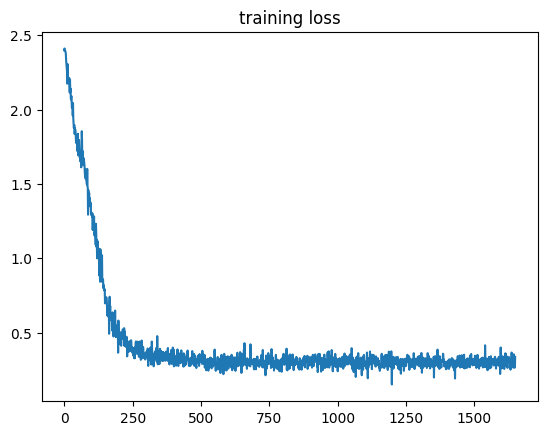

In [112]:
#MFCC3 TRAINER
pbar_update = 1 / (len(MFCCtrain_loader) + len(MFCCvalid_loader))
losses = []
optimizer = optim.Adam(MFCCmodel3.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# The transform needs to live on the same device as the model and the data.
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        MFCCtrain(MFCCmodel3, epoch, log_interval)
        MFCCtest(MFCCmodel3, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [113]:
error=0
print("test amount",len(MFCCtest_set))
for i in range(len(MFCCtest_set)-1) :
    if i==1685 or i==1692 or i==1753: 
            continue
    waveform, utterance = MFCCtest_set[i]
    output = predict(waveform,MFCCmodel3)
    if output != label_Encoder.classes_[utterance]:
        #Audio(waveform.numpy(), rate=sample_rate)
        #print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")
        error+=1        
else:
    # print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    #Audio(waveform.numpy(), rate=8000)
    print(f"Data point #{i}. Expected: {label_Encoder.classes_[utterance]}. Predicted: {output}.")  
print("error: ",error)
print("acc: ",float(100-error/len(MFCCtest_set)*100))

test amount 2763
In this case, let's just look at the last data point
Data point #2761. Expected: open vscode. Predicted: open vscode.
error:  1654
acc:  40.13753166847629


In [ ]:
torch.cuda.empty_cache()